# Image Classification

**Level:** High. Using a library. Primarily conceptual, not coding.

These notes are based on Chapters 5 through 7 of the [fast.ai book](https://github.com/fastai/fastbook/tree/master).

## Sections in this Notebook

* [1. Return to Image Classification](#scrollTo=f8D4Yut6JZ0I)
* [2. Classification vs. Regression](#scrollTo=SS9v-5ZipszP)
* [3. Architectures and Transfer Learning](#scrollTo=5TXWrtthaB6p)
* [4. Towards a State-of-the-Art Model:](#scrollTo=XuzsIkQoqFuk)
  * [4.1 Learning Rate Finder](#scrollTo=_-nIW5cMlapn)
  * [4.2 Data Augmentation](#scrollTo=atWIEYT7l1qH)
  * [4.3 Normalization](#scrollTo=WG8ysBbKulYA)
  * [4.4 Mixup](#scrollTo=b8zkZeQ1v0HT)
  * [4.5 Label Smoothing](#scrollTo=0MDT3jEZv5KG)
  * [4.6 Progressive Resizing](#scrollTo=9dTSI3TemTeM)
  * [4.7 Test-Time Augmentation](#scrollTo=Ph4TS7fIxDLF)

## Vocab Terms

* **model architecture.** The particular choices of size, type, and connection between nodes in a neural network. There are many common and generic model architectures, such as fully connected networks (the general version of what we've built), or resnets (which are very popular for image classification). More generally, a neural network is a type of architecture, just as a linear model is a different type of architecture.

* **classifier.** A model that predicts a discrete class: dog or cat, for example. Logistic regression is an example of a classification model (despite having "regression" in its name), as is the Naive Bayes Classifier and Support Vector Machines.

* **data augmentation.** Modifying and copying the training data (but *not* the validation data) to produce additional training examples. For example, you might mirror an image horizontally to produce a new image. There are many other strategies, which are particular to the problem at hand.

* **normalization.** Rescaling data to make it fit in a smaller, uniform range. This is often done by subtracting the mean and dividing by the standard deviation of a variable, i.e. $x_{norm} = \frac{x - \bar{x}}{\sigma_x}$. This particular normalization also centers the data at 0.

* **regression.** A model which predicts continuous numeric outputs: 5.2, 3.9, 100. Linear regression is an example of a regression model.

* **transfer learning.** Using a pre-trained model, removing the last layer (or a few final layers), and then making small adjustments so that the model can do some new task. You might take an image classifier and train it on a new image type, or make it do something that to a human seems very different, like classifying sounds based on a [spectral waterfall plot](https://www.researchgate.net/figure/Waterfall-plot-of-indoor-RF-noise-from-1200-1800-kHz-over-a-five-day-period_fig5_276919686).


In [ ]:
from fastai.vision.all import *
import pandas as pd

## 1. Back to Image Recognition

Let's try a new dataset, specifically the one of [microscopic images of fungal infections](https://www.kaggle.com/datasets/anshtanwar/microscopic-fungi-images), along with the labels of which type of fungus we're looking at. This dataset was posted on Kaggle by the author of an [academic paper](https://arxiv.org/abs/2109.07322).

The authors were able to get an 85% accuracy (or 15% error rate) on the dataset, after using a complex architecture and training for over 100 epochs. Then they published this in an academic paper. Let's see how well we can do with a few minutes of work. We'll get a baseline by working with a fairly simple architecture and training for just a few epochs, then extend as we go along.

The code below will download the dataset to Google Colab, once you enter in your user information. When working with a competition (which this is not), you'll also need to agree to the competition's rules to be allowed to download the data.

In [ ]:
# You'll need to put in your kaggle username and key here
# I will show you how to do this in class
%env KAGGLE_USERNAME="donnydutch"
%env KAGGLE_KEY="e000856dbf910d714ae70609d63d00aa"

!kaggle datasets download -d anshtanwar/microscopic-fungi-images
!unzip microscopic-fungi-images.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/H1/H1_89a_5.jpg.jpg  
  inflating: train/H1/H1_89a_6.jpg.jpg  
  inflating: train/H1/H1_89a_7.jpg.jpg  
  inflating: train/H1/H1_89b_2.jpg.jpg  
  inflating: train/H1/H1_8a_11.jpg.jpg  
  inflating: train/H1/H1_8a_4.jpg.jpg  
  inflating: train/H1/H1_8a_5.jpg.jpg  
  inflating: train/H1/H1_8b_3.jpg.jpg  
  inflating: train/H1/H1_8b_8.jpg.jpg  
  inflating: train/H1/H1_8b_9.jpg.jpg  
  inflating: train/H1/H1_8c_6.jpg.jpg  
  inflating: train/H1/H1_8c_7.jpg.jpg  
  inflating: train/H1/H1_8d_2.jpg.jpg  
  inflating: train/H1/H1_8d_4.jpg.jpg  
  inflating: train/H1/H1_8d_9.jpg.jpg  
  inflating: train/H1/H1_90a_3.jpg.jpg  
  inflating: train/H1/H1_90a_8.jpg.jpg  
  inflating: train/H1/H1_90a_9.jpg.jpg  
  inflating: train/H1/H1_90b_1.jpg.jpg  
  inflating: train/H1/H1_90b_6.jpg.jpg  
  inflating: train/H1/H1_90b_8.jpg.jpg  
  inflating: train/H1/H1_90c_6.jpg.jpg  
  inflating: train/H1/H1_90c_7.jpg.jpg  
  inflating: tra

ValueError: Multiple files found in ZIP file. Only one file per ZIP: ['test/H1/H1_100a_6.jpg.jpg', 'test/H1/H1_101a_8.jpg.jpg', 'test/H1/H1_101b_16.jpg.jpg', 'test/H1/H1_101b_9.jpg.jpg', 'test/H1/H1_101d_3.jpg.jpg', 'test/H1/H1_101d_8.jpg.jpg', 'test/H1/H1_102a_2.jpg.jpg', 'test/H1/H1_102b_12.jpg.jpg', 'test/H1/H1_102b_18.jpg.jpg', 'test/H1/H1_102b_9.jpg.jpg', 'test/H1/H1_103a_3.jpg.jpg', 'test/H1/H1_103b_12.jpg.jpg', 'test/H1/H1_103b_16.jpg.jpg', 'test/H1/H1_103b_4.jpg.jpg', 'test/H1/H1_103c_1.jpg.jpg', 'test/H1/H1_103c_4.jpg.jpg', 'test/H1/H1_104a_3.jpg.jpg', 'test/H1/H1_104b_11.jpg.jpg', 'test/H1/H1_104b_15.jpg.jpg', 'test/H1/H1_104c_10.jpg.jpg', 'test/H1/H1_105a_15.jpg.jpg', 'test/H1/H1_105a_3.jpg.jpg', 'test/H1/H1_105b_1.jpg.jpg', 'test/H1/H1_105b_6.jpg.jpg', 'test/H1/H1_105c_10.jpg.jpg', 'test/H1/H1_105c_2.jpg.jpg', 'test/H1/H1_105c_7.jpg.jpg', 'test/H1/H1_105d_2.jpg.jpg', 'test/H1/H1_105e_5.jpg.jpg', 'test/H1/H1_106a_3.jpg.jpg', 'test/H1/H1_106c_13.jpg.jpg', 'test/H1/H1_106c_4.jpg.jpg', 'test/H1/H1_106c_7.jpg.jpg', 'test/H1/H1_107b_15.jpg.jpg', 'test/H1/H1_107b_2.jpg.jpg', 'test/H1/H1_107b_7.jpg.jpg', 'test/H1/H1_108a_14.jpg.jpg', 'test/H1/H1_108a_8.jpg.jpg', 'test/H1/H1_108b_3.jpg.jpg', 'test/H1/H1_108b_8.jpg.jpg', 'test/H1/H1_109a_12.jpg.jpg', 'test/H1/H1_109a_18.jpg.jpg', 'test/H1/H1_109a_24.jpg.jpg', 'test/H1/H1_109a_6.jpg.jpg', 'test/H1/H1_10a_5.jpg.jpg', 'test/H1/H1_10b_1.jpg.jpg', 'test/H1/H1_10b_5.jpg.jpg', 'test/H1/H1_10c_1.jpg.jpg', 'test/H1/H1_110a_6.jpg.jpg', 'test/H1/H1_111a_11.jpg.jpg', 'test/H1/H1_111b_18.jpg.jpg', 'test/H1/H1_112a_1.jpg.jpg', 'test/H1/H1_112a_13.jpg.jpg', 'test/H1/H1_112b_4.jpg.jpg', 'test/H1/H1_112c_4.jpg.jpg', 'test/H1/H1_113a_19.jpg.jpg', 'test/H1/H1_113b_17.jpg.jpg', 'test/H1/H1_113b_8.jpg.jpg', 'test/H1/H1_113c_1.jpg.jpg', 'test/H1/H1_113c_13.jpg.jpg', 'test/H1/H1_113c_6.jpg.jpg', 'test/H1/H1_114a_15.jpg.jpg', 'test/H1/H1_114a_8.jpg.jpg', 'test/H1/H1_114b_6.jpg.jpg', 'test/H1/H1_115a_21.jpg.jpg', 'test/H1/H1_115a_23.jpg.jpg', 'test/H1/H1_115b_4.jpg.jpg', 'test/H1/H1_115c_4.jpg.jpg', 'test/H1/H1_115c_7.jpg.jpg', 'test/H1/H1_116b_6.jpg.jpg', 'test/H1/H1_11a_2.jpg.jpg', 'test/H1/H1_11a_5.jpg.jpg', 'test/H1/H1_11b_15.jpg.jpg', 'test/H1/H1_11b_4.jpg.jpg', 'test/H1/H1_11b_6.jpg.jpg', 'test/H1/H1_12b_13.jpg.jpg', 'test/H1/H1_12b_8.jpg.jpg', 'test/H1/H1_12c_1.jpg.jpg', 'test/H1/H1_12c_2.jpg.jpg', 'test/H1/H1_12c_5.jpg.jpg', 'test/H1/H1_12c_9.jpg.jpg', 'test/H1/H1_12d_3.jpg.jpg', 'test/H1/H1_13a_5.jpg.jpg', 'test/H1/H1_13b_10.jpg.jpg', 'test/H1/H1_13b_2.jpg.jpg', 'test/H1/H1_13c_11.jpg.jpg', 'test/H1/H1_14a_10.jpg.jpg', 'test/H1/H1_14a_6.jpg.jpg', 'test/H1/H1_14c_11.jpg.jpg', 'test/H1/H1_14c_24.jpg.jpg', 'test/H1/H1_15a_14.jpg.jpg', 'test/H1/H1_15a_20.jpg.jpg', 'test/H1/H1_15a_6.jpg.jpg', 'test/H1/H1_16b_1.jpg.jpg', 'test/H1/H1_16b_14.jpg.jpg', 'test/H1/H1_16c_5.jpg.jpg', 'test/H1/H1_16c_9.jpg.jpg', 'test/H1/H1_17a_2.jpg.jpg', 'test/H1/H1_17b_11.jpg.jpg', 'test/H1/H1_17b_3.jpg.jpg', 'test/H1/H1_17b_7.jpg.jpg', 'test/H1/H1_18a_12.jpg.jpg', 'test/H1/H1_18b_1.jpg.jpg', 'test/H1/H1_18b_2.jpg.jpg', 'test/H1/H1_19a_13.jpg.jpg', 'test/H1/H1_1a_10.jpg.jpg', 'test/H1/H1_1a_6.jpg.jpg', 'test/H1/H1_1b_11.jpg.jpg', 'test/H1/H1_1b_9.jpg.jpg', 'test/H1/H1_1c_22.jpg.jpg', 'test/H1/H1_1c_9.jpg.jpg', 'test/H1/H1_1d_16.jpg.jpg', 'test/H1/H1_1d_21.jpg.jpg', 'test/H1/H1_1d_3.jpg.jpg', 'test/H1/H1_1d_7.jpg.jpg', 'test/H1/H1_20a_3.jpg.jpg', 'test/H1/H1_20a_9.jpg.jpg', 'test/H1/H1_20b_11.jpg.jpg', 'test/H1/H1_20c_13.jpg.jpg', 'test/H1/H1_20c_8.jpg.jpg', 'test/H1/H1_21a_1.jpg.jpg', 'test/H1/H1_21a_15.jpg.jpg', 'test/H1/H1_21a_3.jpg.jpg', 'test/H1/H1_224a_2.jpg.jpg', 'test/H1/H1_22a_17.jpg.jpg', 'test/H1/H1_22a_7.jpg.jpg', 'test/H1/H1_22b_8.jpg.jpg', 'test/H1/H1_22c_17.jpg.jpg', 'test/H1/H1_22c_2.jpg.jpg', 'test/H1/H1_22d_18.jpg.jpg', 'test/H1/H1_23a_1.jpg.jpg', 'test/H1/H1_23b_10.jpg.jpg', 'test/H1/H1_24a_10.jpg.jpg', 'test/H1/H1_24b_1.jpg.jpg', 'test/H1/H1_24b_15.jpg.jpg', 'test/H1/H1_25a_14.jpg.jpg', 'test/H1/H1_25c_7.jpg.jpg', 'test/H1/H1_26a_7.jpg.jpg', 'test/H1/H1_27a_4.jpg.jpg', 'test/H1/H1_27b_10.jpg.jpg', 'test/H1/H1_27b_2.jpg.jpg', 'test/H1/H1_27b_9.jpg.jpg', 'test/H1/H1_28a_7.jpg.jpg', 'test/H1/H1_28b_3.jpg.jpg', 'test/H1/H1_29a_1.jpg.jpg', 'test/H1/H1_29a_5.jpg.jpg', 'test/H1/H1_29b_1.jpg.jpg', 'test/H1/H1_29c_10.jpg.jpg', 'test/H1/H1_29c_16.jpg.jpg', 'test/H1/H1_2a_1.jpg.jpg', 'test/H1/H1_2a_16.jpg.jpg', 'test/H1/H1_2b_1.jpg.jpg', 'test/H1/H1_2b_19.jpg.jpg', 'test/H1/H1_2b_20.jpg.jpg', 'test/H1/H1_2b_23.jpg.jpg', 'test/H1/H1_30b_10.jpg.jpg', 'test/H1/H1_30b_15.jpg.jpg', 'test/H1/H1_30b_6.jpg.jpg', 'test/H1/H1_30c_15.jpg.jpg', 'test/H1/H1_30c_20.jpg.jpg', 'test/H1/H1_31a_18.jpg.jpg', 'test/H1/H1_31a_23.jpg.jpg', 'test/H1/H1_31a_3.jpg.jpg', 'test/H1/H1_31a_8.jpg.jpg', 'test/H1/H1_33a_10.jpg.jpg', 'test/H1/H1_34a_12.jpg.jpg', 'test/H1/H1_34a_7.jpg.jpg', 'test/H1/H1_36a_5.jpg.jpg', 'test/H1/H1_36b_3.jpg.jpg', 'test/H1/H1_38a_4.jpg.jpg', 'test/H1/H1_38b_6.jpg.jpg', 'test/H1/H1_38d_3.jpg.jpg', 'test/H1/H1_39a_4.jpg.jpg', 'test/H1/H1_39b_14.jpg.jpg', 'test/H1/H1_39b_2.jpg.jpg', 'test/H1/H1_39b_5.jpg.jpg', 'test/H1/H1_3a_11.jpg.jpg', 'test/H1/H1_3a_8.jpg.jpg', 'test/H1/H1_3b_15.jpg.jpg', 'test/H1/H1_3b_4.jpg.jpg', 'test/H1/H1_3b_9.jpg.jpg', 'test/H1/H1_40b_3.jpg.jpg', 'test/H1/H1_40c_2.jpg.jpg', 'test/H1/H1_41a_12.jpg.jpg', 'test/H1/H1_41a_3.jpg.jpg', 'test/H1/H1_41a_6.jpg.jpg', 'test/H1/H1_41b_4.jpg.jpg', 'test/H1/H1_42a_6.jpg.jpg', 'test/H1/H1_42b_9.jpg.jpg', 'test/H1/H1_42c_10.jpg.jpg', 'test/H1/H1_42c_4.jpg.jpg', 'test/H1/H1_42c_9.jpg.jpg', 'test/H1/H1_43a_9.jpg.jpg', 'test/H1/H1_44a_3.jpg.jpg', 'test/H1/H1_44a_8.jpg.jpg', 'test/H1/H1_45a_11.jpg.jpg', 'test/H1/H1_45a_3.jpg.jpg', 'test/H1/H1_46a_4.jpg.jpg', 'test/H1/H1_46a_8.jpg.jpg', 'test/H1/H1_47a_12.jpg.jpg', 'test/H1/H1_47b_5.jpg.jpg', 'test/H1/H1_47c_6.jpg.jpg', 'test/H1/H1_48a_5.jpg.jpg', 'test/H1/H1_48b_14.jpg.jpg', 'test/H1/H1_48b_9.jpg.jpg', 'test/H1/H1_48d_10.jpg.jpg', 'test/H1/H1_49a_1.jpg.jpg', 'test/H1/H1_49b_9.jpg.jpg', 'test/H1/H1_4a_1.jpg.jpg', 'test/H1/H1_4a_5.jpg.jpg', 'test/H1/H1_4b_12.jpg.jpg', 'test/H1/H1_4b_3.jpg.jpg', 'test/H1/H1_4c_4.jpg.jpg', 'test/H1/H1_4c_8.jpg.jpg', 'test/H1/H1_4d_4.jpg.jpg', 'test/H1/H1_50a_1.jpg.jpg', 'test/H1/H1_51a_13.jpg.jpg', 'test/H1/H1_51a_16.jpg.jpg', 'test/H1/H1_51a_20.jpg.jpg', 'test/H1/H1_51b_17.jpg.jpg', 'test/H1/H1_51b_22.jpg.jpg', 'test/H1/H1_51c_16.jpg.jpg', 'test/H1/H1_51d_14.jpg.jpg', 'test/H1/H1_51d_8.jpg.jpg', 'test/H1/H1_52a_15.jpg.jpg', 'test/H1/H1_52a_3.jpg.jpg', 'test/H1/H1_52b_1.jpg.jpg', 'test/H1/H1_52b_15.jpg.jpg', 'test/H1/H1_52c_1.jpg.jpg', 'test/H1/H1_52c_6.jpg.jpg', 'test/H1/H1_53a_11.jpg.jpg', 'test/H1/H1_53a_20.jpg.jpg', 'test/H1/H1_53b_7.jpg.jpg', 'test/H1/H1_53c_8.jpg.jpg', 'test/H1/H1_54a_1.jpg.jpg', 'test/H1/H1_54a_2.jpg.jpg', 'test/H1/H1_54c_6.jpg.jpg', 'test/H1/H1_55a_7.jpg.jpg', 'test/H1/H1_55c_2.jpg.jpg', 'test/H1/H1_55d_11.jpg.jpg', 'test/H1/H1_55d_14.jpg.jpg', 'test/H1/H1_55d_2.jpg.jpg', 'test/H1/H1_55d_25.jpg.jpg', 'test/H1/H1_56a_4.jpg.jpg', 'test/H1/H1_56b_5.jpg.jpg', 'test/H1/H1_56c_6.jpg.jpg', 'test/H1/H1_56d_5.jpg.jpg', 'test/H1/H1_56d_7.jpg.jpg', 'test/H1/H1_56e_1.jpg.jpg', 'test/H1/H1_57b_7.jpg.jpg', 'test/H1/H1_57c_7.jpg.jpg', 'test/H1/H1_58a_7.jpg.jpg', 'test/H1/H1_58b_5.jpg.jpg', 'test/H1/H1_58b_8.jpg.jpg', 'test/H1/H1_59b_12.jpg.jpg', 'test/H1/H1_59b_2.jpg.jpg', 'test/H1/H1_59c_6.jpg.jpg', 'test/H1/H1_5a_2.jpg.jpg', 'test/H1/H1_5b_1.jpg.jpg', 'test/H1/H1_5b_2.jpg.jpg', 'test/H1/H1_5c_13.jpg.jpg', 'test/H1/H1_5c_3.jpg.jpg', 'test/H1/H1_60a_4.jpg.jpg', 'test/H1/H1_60b_6.jpg.jpg', 'test/H1/H1_60c_7.jpg.jpg', 'test/H1/H1_61a_6.jpg.jpg', 'test/H1/H1_61b_6.jpg.jpg', 'test/H1/H1_61c_2.jpg.jpg', 'test/H1/H1_62a_15.jpg.jpg', 'test/H1/H1_62a_23.jpg.jpg', 'test/H1/H1_62a_6.jpg.jpg', 'test/H1/H1_62b_8.jpg.jpg', 'test/H1/H1_62c_8.jpg.jpg', 'test/H1/H1_63a_2.jpg.jpg', 'test/H1/H1_63b_3.jpg.jpg', 'test/H1/H1_63c_1.jpg.jpg', 'test/H1/H1_63c_3.jpg.jpg', 'test/H1/H1_63d_14.jpg.jpg', 'test/H1/H1_63d_9.jpg.jpg', 'test/H1/H1_64a_12.jpg.jpg', 'test/H1/H1_64b_1.jpg.jpg', 'test/H1/H1_65a_1.jpg.jpg', 'test/H1/H1_65a_4.jpg.jpg', 'test/H1/H1_65c_1.jpg.jpg', 'test/H1/H1_65c_3.jpg.jpg', 'test/H1/H1_65d_5.jpg.jpg', 'test/H1/H1_66a_12.jpg.jpg', 'test/H1/H1_66b_9.jpg.jpg', 'test/H1/H1_67a_21.jpg.jpg', 'test/H1/H1_67b_10.jpg.jpg', 'test/H1/H1_67b_3.jpg.jpg', 'test/H1/H1_67c_1.jpg.jpg', 'test/H1/H1_67c_20.jpg.jpg', 'test/H1/H1_67d_19.jpg.jpg', 'test/H1/H1_68a_10.jpg.jpg', 'test/H1/H1_68a_18.jpg.jpg', 'test/H1/H1_68b_19.jpg.jpg', 'test/H1/H1_68b_6.jpg.jpg', 'test/H1/H1_69a_4.jpg.jpg', 'test/H1/H1_69b_8.jpg.jpg', 'test/H1/H1_6a_4.jpg.jpg', 'test/H1/H1_6b_13.jpg.jpg', 'test/H1/H1_70a_6.jpg.jpg', 'test/H1/H1_70b_4.jpg.jpg', 'test/H1/H1_71c_4.jpg.jpg', 'test/H1/H1_72a_14.jpg.jpg', 'test/H1/H1_72a_18.jpg.jpg', 'test/H1/H1_72a_4.jpg.jpg', 'test/H1/H1_72a_8.jpg.jpg', 'test/H1/H1_72c_18.jpg.jpg', 'test/H1/H1_72c_20.jpg.jpg', 'test/H1/H1_72c_5.jpg.jpg', 'test/H1/H1_72d_15.jpg.jpg', 'test/H1/H1_73a_10.jpg.jpg', 'test/H1/H1_73a_18.jpg.jpg', 'test/H1/H1_73a_7.jpg.jpg', 'test/H1/H1_73b_11.jpg.jpg', 'test/H1/H1_73b_2.jpg.jpg', 'test/H1/H1_73b_6.jpg.jpg', 'test/H1/H1_74a_7.jpg.jpg', 'test/H1/H1_74b_12.jpg.jpg', 'test/H1/H1_74b_7.jpg.jpg', 'test/H1/H1_74c_12.jpg.jpg', 'test/H1/H1_74c_15.jpg.jpg', 'test/H1/H1_74c_21.jpg.jpg', 'test/H1/H1_74c_4.jpg.jpg', 'test/H1/H1_74c_8.jpg.jpg', 'test/H1/H1_74d_16.jpg.jpg', 'test/H1/H1_74d_6.jpg.jpg', 'test/H1/H1_74d_9.jpg.jpg', 'test/H1/H1_75a_11.jpg.jpg', 'test/H1/H1_75a_16.jpg.jpg', 'test/H1/H1_75b_1.jpg.jpg', 'test/H1/H1_75c_7.jpg.jpg', 'test/H1/H1_76a_3.jpg.jpg', 'test/H1/H1_76b_1.jpg.jpg', 'test/H1/H1_76b_3.jpg.jpg', 'test/H1/H1_76c_1.jpg.jpg', 'test/H1/H1_76c_2.jpg.jpg', 'test/H1/H1_76c_7.jpg.jpg', 'test/H1/H1_76e_6.jpg.jpg', 'test/H1/H1_77a_20.jpg.jpg', 'test/H1/H1_77a_3.jpg.jpg', 'test/H1/H1_77b_4.jpg.jpg', 'test/H1/H1_78a_1.jpg.jpg', 'test/H1/H1_78c_2.jpg.jpg', 'test/H1/H1_78c_8.jpg.jpg', 'test/H1/H1_79a_9.jpg.jpg', 'test/H1/H1_79c_2.jpg.jpg', 'test/H1/H1_79e_4.jpg.jpg', 'test/H1/H1_7a_16.jpg.jpg', 'test/H1/H1_7a_5.jpg.jpg', 'test/H1/H1_7b_4.jpg.jpg', 'test/H1/H1_7c_16.jpg.jpg', 'test/H1/H1_7c_4.jpg.jpg', 'test/H1/H1_7c_9.jpg.jpg', 'test/H1/H1_80a_4.jpg.jpg', 'test/H1/H1_80b_7.jpg.jpg', 'test/H1/H1_81a_16.jpg.jpg', 'test/H1/H1_81a_8.jpg.jpg', 'test/H1/H1_81b_4.jpg.jpg', 'test/H1/H1_82a_3.jpg.jpg', 'test/H1/H1_82b_7.jpg.jpg', 'test/H1/H1_83a_16.jpg.jpg', 'test/H1/H1_84a_13.jpg.jpg', 'test/H1/H1_84a_7.jpg.jpg', 'test/H1/H1_84b_15.jpg.jpg', 'test/H1/H1_84b_7.jpg.jpg', 'test/H1/H1_84c_13.jpg.jpg', 'test/H1/H1_84c_7.jpg.jpg', 'test/H1/H1_85a_2.jpg.jpg', 'test/H1/H1_85a_5.jpg.jpg', 'test/H1/H1_85b_12.jpg.jpg', 'test/H1/H1_85b_21.jpg.jpg', 'test/H1/H1_85b_25.jpg.jpg', 'test/H1/H1_86a_5.jpg.jpg', 'test/H1/H1_86b_14.jpg.jpg', 'test/H1/H1_86b_19.jpg.jpg', 'test/H1/H1_86b_6.jpg.jpg', 'test/H1/H1_86b_8.jpg.jpg', 'test/H1/H1_86d_3.jpg.jpg', 'test/H1/H1_87a_15.jpg.jpg', 'test/H1/H1_87b_6.jpg.jpg', 'test/H1/H1_87c_2.jpg.jpg', 'test/H1/H1_89a_14.jpg.jpg', 'test/H1/H1_89a_9.jpg.jpg', 'test/H1/H1_89b_11.jpg.jpg', 'test/H1/H1_8a_2.jpg.jpg', 'test/H1/H1_8a_9.jpg.jpg', 'test/H1/H1_8c_2.jpg.jpg', 'test/H1/H1_90a_2.jpg.jpg', 'test/H1/H1_90c_8.jpg.jpg', 'test/H1/H1_90d_9.jpg.jpg', 'test/H1/H1_90e_2.jpg.jpg', 'test/H1/H1_91a_18.jpg.jpg', 'test/H1/H1_91c_2.jpg.jpg', 'test/H1/H1_91c_4.jpg.jpg', 'test/H1/H1_92a_13.jpg.jpg', 'test/H1/H1_92a_4.jpg.jpg', 'test/H1/H1_92a_9.jpg.jpg', 'test/H1/H1_93a_10.jpg.jpg', 'test/H1/H1_93a_12.jpg.jpg', 'test/H1/H1_93b_12.jpg.jpg', 'test/H1/H1_94a_12.jpg.jpg', 'test/H1/H1_94b_2.jpg.jpg', 'test/H1/H1_94b_5.jpg.jpg', 'test/H1/H1_95a_15.jpg.jpg', 'test/H1/H1_95a_17.jpg.jpg', 'test/H1/H1_95a_24.jpg.jpg', 'test/H1/H1_95a_7.jpg.jpg', 'test/H1/H1_95b_16.jpg.jpg', 'test/H1/H1_95c_10.jpg.jpg', 'test/H1/H1_95c_14.jpg.jpg', 'test/H1/H1_95c_20.jpg.jpg', 'test/H1/H1_95d_10.jpg.jpg', 'test/H1/H1_95d_14.jpg.jpg', 'test/H1/H1_95d_22.jpg.jpg', 'test/H1/H1_95d_4.jpg.jpg', 'test/H1/H1_95d_8.jpg.jpg', 'test/H1/H1_96b_2.jpg.jpg', 'test/H1/H1_96b_6.jpg.jpg', 'test/H1/H1_96d_12.jpg.jpg', 'test/H1/H1_96d_15.jpg.jpg', 'test/H1/H1_96d_8.jpg.jpg', 'test/H1/H1_97a_8.jpg.jpg', 'test/H1/H1_98a_1.jpg.jpg', 'test/H1/H1_98a_15.jpg.jpg', 'test/H1/H1_98a_4.jpg.jpg', 'test/H1/H1_98b_4.jpg.jpg', 'test/H1/H1_98c_2.jpg.jpg', 'test/H1/H1_98c_7.jpg.jpg', 'test/H1/H1_99a_2.jpg.jpg', 'test/H1/H1_99b_3.jpg.jpg', 'test/H1/H1_99c_6.jpg.jpg', 'test/H1/H1_9a_2.jpg.jpg', 'test/H1/H1_9b_1.jpg.jpg', 'test/H1/H1_9b_4.jpg.jpg', 'test/H2/H2_102a_2.jpg.jpg', 'test/H2/H2_102b_3.jpg.jpg', 'test/H2/H2_104d_2.jpg.jpg', 'test/H2/H2_104e_2.jpg.jpg', 'test/H2/H2_106a_2.jpg.jpg', 'test/H2/H2_115a_4.jpg.jpg', 'test/H2/H2_115d_3.jpg.jpg', 'test/H2/H2_117a_2.jpg.jpg', 'test/H2/H2_11a_2.jpg.jpg', 'test/H2/H2_11a_7.jpg.jpg', 'test/H2/H2_11a_9.jpg.jpg', 'test/H2/H2_11b_2.jpg.jpg', 'test/H2/H2_121a_3.jpg.jpg', 'test/H2/H2_121a_5.jpg.jpg', 'test/H2/H2_121c_7.jpg.jpg', 'test/H2/H2_122a_2.jpg.jpg', 'test/H2/H2_122b_4.jpg.jpg', 'test/H2/H2_122e_2.jpg.jpg', 'test/H2/H2_12a_2.jpg.jpg', 'test/H2/H2_13b_2.jpg.jpg', 'test/H2/H2_13c_8.jpg.jpg', 'test/H2/H2_14a_16.jpg.jpg', 'test/H2/H2_14a_23.jpg.jpg', 'test/H2/H2_15a_11.jpg.jpg', 'test/H2/H2_15a_15.jpg.jpg', 'test/H2/H2_15b_1.jpg.jpg', 'test/H2/H2_15b_16.jpg.jpg', 'test/H2/H2_15b_2.jpg.jpg', 'test/H2/H2_15b_5.jpg.jpg', 'test/H2/H2_16a_7.jpg.jpg', 'test/H2/H2_17a_7.jpg.jpg', 'test/H2/H2_17b_2.jpg.jpg', 'test/H2/H2_17c_1.jpg.jpg', 'test/H2/H2_17c_9.jpg.jpg', 'test/H2/H2_1a_12.jpg.jpg', 'test/H2/H2_1b_1.jpg.jpg', 'test/H2/H2_20a_3.jpg.jpg', 'test/H2/H2_21c_1.jpg.jpg', 'test/H2/H2_21c_11.jpg.jpg', 'test/H2/H2_21c_9.jpg.jpg', 'test/H2/H2_22a_3.jpg.jpg', 'test/H2/H2_22a_5.jpg.jpg', 'test/H2/H2_22a_8.jpg.jpg', 'test/H2/H2_23a_26.jpg.jpg', 'test/H2/H2_23a_30.jpg.jpg', 'test/H2/H2_23a_9.jpg.jpg', 'test/H2/H2_23b_19.jpg.jpg', 'test/H2/H2_23b_4.jpg.jpg', 'test/H2/H2_23c_2.jpg.jpg', 'test/H2/H2_23c_8.jpg.jpg', 'test/H2/H2_23d_1.jpg.jpg', 'test/H2/H2_23d_22.jpg.jpg', 'test/H2/H2_23d_26.jpg.jpg', 'test/H2/H2_23d_3.jpg.jpg', 'test/H2/H2_23d_9.jpg.jpg', 'test/H2/H2_24a_18.jpg.jpg', 'test/H2/H2_24a_20.jpg.jpg', 'test/H2/H2_24b_10.jpg.jpg', 'test/H2/H2_24b_4.jpg.jpg', 'test/H2/H2_24c_1.jpg.jpg', 'test/H2/H2_24c_7.jpg.jpg', 'test/H2/H2_25a_7.jpg.jpg', 'test/H2/H2_25b_6.jpg.jpg', 'test/H2/H2_26a_2.jpg.jpg', 'test/H2/H2_26b_2.jpg.jpg', 'test/H2/H2_26c_3.jpg.jpg', 'test/H2/H2_26c_8.jpg.jpg', 'test/H2/H2_27a_6.jpg.jpg', 'test/H2/H2_27a_9.jpg.jpg', 'test/H2/H2_27b_12.jpg.jpg', 'test/H2/H2_28a_1.jpg.jpg', 'test/H2/H2_28b_22.jpg.jpg', 'test/H2/H2_28b_24.jpg.jpg', 'test/H2/H2_28b_8.jpg.jpg', 'test/H2/H2_29a_7.jpg.jpg', 'test/H2/H2_29b_3.jpg.jpg', 'test/H2/H2_29b_6.jpg.jpg', 'test/H2/H2_2b_16.jpg.jpg', 'test/H2/H2_2b_3.jpg.jpg', 'test/H2/H2_2b_9.jpg.jpg', 'test/H2/H2_30a_9.jpg.jpg', 'test/H2/H2_30b_5.jpg.jpg', 'test/H2/H2_30c_1.jpg.jpg', 'test/H2/H2_30d_3.jpg.jpg', 'test/H2/H2_31a_3.jpg.jpg', 'test/H2/H2_31b_2.jpg.jpg', 'test/H2/H2_31c_1.jpg.jpg', 'test/H2/H2_32a_12.jpg.jpg', 'test/H2/H2_32a_6.jpg.jpg', 'test/H2/H2_32b_9.jpg.jpg', 'test/H2/H2_32c_8.jpg.jpg', 'test/H2/H2_33a_15.jpg.jpg', 'test/H2/H2_34a_1.jpg.jpg', 'test/H2/H2_34a_9.jpg.jpg', 'test/H2/H2_34b_3.jpg.jpg', 'test/H2/H2_35a_4.jpg.jpg', 'test/H2/H2_36a_4.jpg.jpg', 'test/H2/H2_37a_7.jpg.jpg', 'test/H2/H2_37b_9.jpg.jpg', 'test/H2/H2_37c_5.jpg.jpg', 'test/H2/H2_38a_7.jpg.jpg', 'test/H2/H2_38b_4.jpg.jpg', 'test/H2/H2_38b_8.jpg.jpg', 'test/H2/H2_39a_3.jpg.jpg', 'test/H2/H2_3a_10.jpg.jpg', 'test/H2/H2_3a_15.jpg.jpg', 'test/H2/H2_3a_4.jpg.jpg', 'test/H2/H2_3b_1.jpg.jpg', 'test/H2/H2_3b_3.jpg.jpg', 'test/H2/H2_3b_6.jpg.jpg', 'test/H2/H2_40c_2.jpg.jpg', 'test/H2/H2_41a_3.jpg.jpg', 'test/H2/H2_42a_8.jpg.jpg', 'test/H2/H2_43a_3.jpg.jpg', 'test/H2/H2_43a_7.jpg.jpg', 'test/H2/H2_44a_3.jpg.jpg', 'test/H2/H2_44b_3.jpg.jpg', 'test/H2/H2_45a_15.jpg.jpg', 'test/H2/H2_45a_9.jpg.jpg', 'test/H2/H2_45c_2.jpg.jpg', 'test/H2/H2_45c_9.jpg.jpg', 'test/H2/H2_45e_2.jpg.jpg', 'test/H2/H2_47a_15.jpg.jpg', 'test/H2/H2_47b_20.jpg.jpg', 'test/H2/H2_47b_8.jpg.jpg', 'test/H2/H2_48a_6.jpg.jpg', 'test/H2/H2_48b_11.jpg.jpg', 'test/H2/H2_48c_6.jpg.jpg', 'test/H2/H2_48d_10.jpg.jpg', 'test/H2/H2_48d_18.jpg.jpg', 'test/H2/H2_48e_2.jpg.jpg', 'test/H2/H2_49c_3.jpg.jpg', 'test/H2/H2_4a_8.jpg.jpg', 'test/H2/H2_4b_2.jpg.jpg', 'test/H2/H2_50a_7.jpg.jpg', 'test/H2/H2_50a_9.jpg.jpg', 'test/H2/H2_51c_9.jpg.jpg', 'test/H2/H2_52c_2.jpg.jpg', 'test/H2/H2_53b_6.jpg.jpg', 'test/H2/H2_53c_10.jpg.jpg', 'test/H2/H2_53c_2.jpg.jpg', 'test/H2/H2_54a_1.jpg.jpg', 'test/H2/H2_54a_9.jpg.jpg', 'test/H2/H2_56b_20.jpg.jpg', 'test/H2/H2_58a_13.jpg.jpg', 'test/H2/H2_58a_24.jpg.jpg', 'test/H2/H2_58a_8.jpg.jpg', 'test/H2/H2_59a_7.jpg.jpg', 'test/H2/H2_59c_4.jpg.jpg', 'test/H2/H2_5a_14.jpg.jpg', 'test/H2/H2_5b_4.jpg.jpg', 'test/H2/H2_5c_3.jpg.jpg', 'test/H2/H2_60a_10.jpg.jpg', 'test/H2/H2_60a_9.jpg.jpg', 'test/H2/H2_61c_2.jpg.jpg', 'test/H2/H2_61e_1.jpg.jpg', 'test/H2/H2_61g_2.jpg.jpg', 'test/H2/H2_61g_4.jpg.jpg', 'test/H2/H2_62a_6.jpg.jpg', 'test/H2/H2_62b_2.jpg.jpg', 'test/H2/H2_63a_12.jpg.jpg', 'test/H2/H2_63a_6.jpg.jpg', 'test/H2/H2_63b_1.jpg.jpg', 'test/H2/H2_63b_18.jpg.jpg', 'test/H2/H2_63b_21.jpg.jpg', 'test/H2/H2_63b_23.jpg.jpg', 'test/H2/H2_63b_8.jpg.jpg', 'test/H2/H2_64b_1.jpg.jpg', 'test/H2/H2_64b_6.jpg.jpg', 'test/H2/H2_65a_5.jpg.jpg', 'test/H2/H2_65b_16.jpg.jpg', 'test/H2/H2_66a_8.jpg.jpg', 'test/H2/H2_66c_1.jpg.jpg', 'test/H2/H2_66c_5.jpg.jpg', 'test/H2/H2_66d_6.jpg.jpg', 'test/H2/H2_66e_2.jpg.jpg', 'test/H2/H2_66f_11.jpg.jpg', 'test/H2/H2_67a_2.jpg.jpg', 'test/H2/H2_67a_6.jpg.jpg', 'test/H2/H2_67b_5.jpg.jpg', 'test/H2/H2_68a_10.jpg.jpg', 'test/H2/H2_68a_3.jpg.jpg', 'test/H2/H2_68a_7.jpg.jpg', 'test/H2/H2_68b_10.jpg.jpg', 'test/H2/H2_68b_5.jpg.jpg', 'test/H2/H2_69b_4.jpg.jpg', 'test/H2/H2_69c_7.jpg.jpg', 'test/H2/H2_6a_12.jpg.jpg', 'test/H2/H2_6a_6.jpg.jpg', 'test/H2/H2_6a_9.jpg.jpg', 'test/H2/H2_6b_16.jpg.jpg', 'test/H2/H2_6b_8.jpg.jpg', 'test/H2/H2_6c_4.jpg.jpg', 'test/H2/H2_70c_2.jpg.jpg', 'test/H2/H2_70c_4.jpg.jpg', 'test/H2/H2_72c_4.jpg.jpg', 'test/H2/H2_73b_7.jpg.jpg', 'test/H2/H2_73b_9.jpg.jpg', 'test/H2/H2_73c_3.jpg.jpg', 'test/H2/H2_73c_8.jpg.jpg', 'test/H2/H2_73e_3.jpg.jpg', 'test/H2/H2_73e_7.jpg.jpg', 'test/H2/H2_75b_10.jpg.jpg', 'test/H2/H2_75b_6.jpg.jpg', 'test/H2/H2_75c_2.jpg.jpg', 'test/H2/H2_76a_2.jpg.jpg', 'test/H2/H2_76b_3.jpg.jpg', 'test/H2/H2_79a_1.jpg.jpg', 'test/H2/H2_79d_3.jpg.jpg', 'test/H2/H2_7a_11.jpg.jpg', 'test/H2/H2_7a_14.jpg.jpg', 'test/H2/H2_7a_16.jpg.jpg', 'test/H2/H2_7a_3.jpg.jpg', 'test/H2/H2_7a_7.jpg.jpg', 'test/H2/H2_7b_16.jpg.jpg', 'test/H2/H2_7b_23.jpg.jpg', 'test/H2/H2_80b_3.jpg.jpg', 'test/H2/H2_81b_6.jpg.jpg', 'test/H2/H2_81c_5.jpg.jpg', 'test/H2/H2_83a_2.jpg.jpg', 'test/H2/H2_8a_12.jpg.jpg', 'test/H2/H2_8b_1.jpg.jpg', 'test/H2/H2_8d_6.jpg.jpg', 'test/H2/H2_8e_13.jpg.jpg', 'test/H2/H2_8f_16.jpg.jpg', 'test/H2/H2_8g_6.jpg.jpg', 'test/H2/H2_92a_3.jpg.jpg', 'test/H2/H2_93a_9.jpg.jpg', 'test/H2/H2_96a_1.jpg.jpg', 'test/H2/H2_9a_13.jpg.jpg', 'test/H2/H2_9a_8.jpg.jpg', 'test/H2/H2_9b_12.jpg.jpg', 'test/H2/H2_9b_2.jpg.jpg', 'test/H3/H3_10a_1.jpg.jpg', 'test/H3/H3_10a_7.jpg.jpg', 'test/H3/H3_11a_1.jpg.jpg', 'test/H3/H3_11a_15.jpg.jpg', 'test/H3/H3_11a_18.jpg.jpg', 'test/H3/H3_11a_23.jpg.jpg', 'test/H3/H3_11a_30.jpg.jpg', 'test/H3/H3_11a_36.jpg.jpg', 'test/H3/H3_11a_48.jpg.jpg', 'test/H3/H3_11b_1.jpg.jpg', 'test/H3/H3_11b_5.jpg.jpg', 'test/H3/H3_11b_8.jpg.jpg', 'test/H3/H3_12b_1.jpg.jpg', 'test/H3/H3_12b_9.jpg.jpg', 'test/H3/H3_13a_24.jpg.jpg', 'test/H3/H3_13a_31.jpg.jpg', 'test/H3/H3_13a_44.jpg.jpg', 'test/H3/H3_13b_7.jpg.jpg', 'test/H3/H3_13c_6.jpg.jpg', 'test/H3/H3_16a_1.jpg.jpg', 'test/H3/H3_16a_8.jpg.jpg', 'test/H3/H3_17a_6.jpg.jpg', 'test/H3/H3_17b_5.jpg.jpg', 'test/H3/H3_17c_6.jpg.jpg', 'test/H3/H3_18a_11.jpg.jpg', 'test/H3/H3_18b_2.jpg.jpg', 'test/H3/H3_19a_3.jpg.jpg', 'test/H3/H3_19c_4.jpg.jpg', 'test/H3/H3_1a_26.jpg.jpg', 'test/H3/H3_1a_30.jpg.jpg', 'test/H3/H3_1b_14.jpg.jpg', 'test/H3/H3_1b_18.jpg.jpg', 'test/H3/H3_1b_6.jpg.jpg', 'test/H3/H3_20a_2.jpg.jpg', 'test/H3/H3_23a_1.jpg.jpg', 'test/H3/H3_24a_5.jpg.jpg', 'test/H3/H3_25a_3.jpg.jpg', 'test/H3/H3_2a_17.jpg.jpg', 'test/H3/H3_30a_2.jpg.jpg', 'test/H3/H3_31a_1.jpg.jpg', 'test/H3/H3_31a_18.jpg.jpg', 'test/H3/H3_32a_8.jpg.jpg', 'test/H3/H3_34a_13.jpg.jpg', 'test/H3/H3_34a_7.jpg.jpg', 'test/H3/H3_3a_15.jpg.jpg', 'test/H3/H3_3a_22.jpg.jpg', 'test/H3/H3_3a_7.jpg.jpg', 'test/H3/H3_3b_5.jpg.jpg', 'test/H3/H3_3c_11.jpg.jpg', 'test/H3/H3_3c_18.jpg.jpg', 'test/H3/H3_3c_2.jpg.jpg', 'test/H3/H3_3c_30.jpg.jpg', 'test/H3/H3_3c_9.jpg.jpg', 'test/H3/H3_4a_14.jpg.jpg', 'test/H3/H3_4a_23.jpg.jpg', 'test/H3/H3_4a_3.jpg.jpg', 'test/H3/H3_4b_12.jpg.jpg', 'test/H3/H3_4b_19.jpg.jpg', 'test/H3/H3_4b_21.jpg.jpg', 'test/H3/H3_4b_25.jpg.jpg', 'test/H3/H3_4b_41.jpg.jpg', 'test/H3/H3_4c_4.jpg.jpg', 'test/H3/H3_5a_22.jpg.jpg', 'test/H3/H3_5a_29.jpg.jpg', 'test/H3/H3_5a_38.jpg.jpg', 'test/H3/H3_5a_42.jpg.jpg', 'test/H3/H3_5a_53.jpg.jpg', 'test/H3/H3_5c_12.jpg.jpg', 'test/H3/H3_6a_13.jpg.jpg', 'test/H3/H3_6a_18.jpg.jpg', 'test/H3/H3_6a_25.jpg.jpg', 'test/H3/H3_6a_36.jpg.jpg', 'test/H3/H3_6a_42.jpg.jpg', 'test/H3/H3_6a_50.jpg.jpg', 'test/H3/H3_6a_53.jpg.jpg', 'test/H3/H3_6a_56.jpg.jpg', 'test/H3/H3_6a_62.jpg.jpg', 'test/H3/H3_6a_65.jpg.jpg', 'test/H3/H3_6a_9.jpg.jpg', 'test/H3/H3_7a_5.jpg.jpg', 'test/H3/H3_8b_2.jpg.jpg', 'test/H3/H3_9a_4.jpg.jpg', 'test/H5/H5_101a_1.jpg.jpg', 'test/H5/H5_102a_3.jpg.jpg', 'test/H5/H5_107a_2.jpg.jpg', 'test/H5/H5_108b_1.jpg.jpg', 'test/H5/H5_108c_1.jpg.jpg', 'test/H5/H5_10a_1.jpg.jpg', 'test/H5/H5_110a_2.jpg.jpg', 'test/H5/H5_111c_3.jpg.jpg', 'test/H5/H5_113a_5.jpg.jpg', 'test/H5/H5_117a_3.jpg.jpg', 'test/H5/H5_118a_4.jpg.jpg', 'test/H5/H5_119a_4.jpg.jpg', 'test/H5/H5_119a_7.jpg.jpg', 'test/H5/H5_11a_2.jpg.jpg', 'test/H5/H5_120a_3.jpg.jpg', 'test/H5/H5_121b_3.jpg.jpg', 'test/H5/H5_122a_9.jpg.jpg', 'test/H5/H5_125a_4.jpg.jpg', 'test/H5/H5_126b_3.jpg.jpg', 'test/H5/H5_128a_6.jpg.jpg', 'test/H5/H5_132a_8.jpg.jpg', 'test/H5/H5_132b_4.jpg.jpg', 'test/H5/H5_132b_7.jpg.jpg', 'test/H5/H5_135a_4.jpg.jpg', 'test/H5/H5_139a_5.jpg.jpg', 'test/H5/H5_141a_5.jpg.jpg', 'test/H5/H5_142a_10.jpg.jpg', 'test/H5/H5_142a_3.jpg.jpg', 'test/H5/H5_143a_2.jpg.jpg', 'test/H5/H5_14a_4.jpg.jpg', 'test/H5/H5_15a_6.jpg.jpg', 'test/H5/H5_15b_2.jpg.jpg', 'test/H5/H5_17b_2.jpg.jpg', 'test/H5/H5_17b_5.jpg.jpg', 'test/H5/H5_18a_4.jpg.jpg', 'test/H5/H5_19a_6.jpg.jpg', 'test/H5/H5_1a_3.jpg.jpg', 'test/H5/H5_21a_8.jpg.jpg', 'test/H5/H5_22b_2.jpg.jpg', 'test/H5/H5_24a_1.jpg.jpg', 'test/H5/H5_24a_4.jpg.jpg', 'test/H5/H5_24b_1.jpg.jpg', 'test/H5/H5_29a_4.jpg.jpg', 'test/H5/H5_2c_2.jpg.jpg', 'test/H5/H5_34a_4.jpg.jpg', 'test/H5/H5_35a_4.jpg.jpg', 'test/H5/H5_36a_2.jpg.jpg', 'test/H5/H5_38a_3.jpg.jpg', 'test/H5/H5_3a_2.jpg.jpg', 'test/H5/H5_41b_1.jpg.jpg', 'test/H5/H5_42a_2.jpg.jpg', 'test/H5/H5_44a_4.jpg.jpg', 'test/H5/H5_45a_4.jpg.jpg', 'test/H5/H5_46a_2.jpg.jpg', 'test/H5/H5_48a_2.jpg.jpg', 'test/H5/H5_48a_6.jpg.jpg', 'test/H5/H5_54b_1.jpg.jpg', 'test/H5/H5_55a_3.jpg.jpg', 'test/H5/H5_57c_4.jpg.jpg', 'test/H5/H5_61a_1.jpg.jpg', 'test/H5/H5_61a_9.jpg.jpg', 'test/H5/H5_63b_1.jpg.jpg', 'test/H5/H5_67b_4.jpg.jpg', 'test/H5/H5_6a_1.jpg.jpg', 'test/H5/H5_70a_2.jpg.jpg', 'test/H5/H5_71a_4.jpg.jpg', 'test/H5/H5_74a_4.jpg.jpg', 'test/H5/H5_77a_4.jpg.jpg', 'test/H5/H5_78a_4.jpg.jpg', 'test/H5/H5_7a_4.jpg.jpg', 'test/H5/H5_80a_2.jpg.jpg', 'test/H5/H5_81a_2.jpg.jpg', 'test/H5/H5_83a_3.jpg.jpg', 'test/H5/H5_86a_2.jpg.jpg', 'test/H5/H5_87a_4.jpg.jpg', 'test/H5/H5_8a_1.jpg.jpg', 'test/H5/H5_91a_2.jpg.jpg', 'test/H5/H5_95b_2.jpg.jpg', 'test/H5/H5_98a_3.jpg.jpg', 'test/H5/H5_99a_2.jpg.jpg', 'test/H6/H6_10a_1.jpg.jpg', 'test/H6/H6_12a_2.jpg.jpg', 'test/H6/H6_13a_4.jpg.jpg', 'test/H6/H6_15a_2.jpg.jpg', 'test/H6/H6_1b_6.jpg.jpg', 'test/H6/H6_20a_5.jpg.jpg', 'test/H6/H6_21a_6.jpg.jpg', 'test/H6/H6_22a_3.jpg.jpg', 'test/H6/H6_24a_1.jpg.jpg', 'test/H6/H6_26a_4.jpg.jpg', 'test/H6/H6_27a_2.jpg.jpg', 'test/H6/H6_27a_5.jpg.jpg', 'test/H6/H6_2a_10.jpg.jpg', 'test/H6/H6_2a_15.jpg.jpg', 'test/H6/H6_2b_8.jpg.jpg', 'test/H6/H6_2c_3.jpg.jpg', 'test/H6/H6_30a_8.jpg.jpg', 'test/H6/H6_32a_3.jpg.jpg', 'test/H6/H6_33a_11.jpg.jpg', 'test/H6/H6_33a_18.jpg.jpg', 'test/H6/H6_33a_9.jpg.jpg', 'test/H6/H6_34a_4.jpg.jpg', 'test/H6/H6_36a_2.jpg.jpg', 'test/H6/H6_37a_2.jpg.jpg', 'test/H6/H6_38a_11.jpg.jpg', 'test/H6/H6_38a_19.jpg.jpg', 'test/H6/H6_38a_4.jpg.jpg', 'test/H6/H6_38a_9.jpg.jpg', 'test/H6/H6_39a_3.jpg.jpg', 'test/H6/H6_39a_6.jpg.jpg', 'test/H6/H6_40a_4.jpg.jpg', 'test/H6/H6_41a_4.jpg.jpg', 'test/H6/H6_43a_5.jpg.jpg', 'test/H6/H6_43a_8.jpg.jpg', 'test/H6/H6_45a_6.jpg.jpg', 'test/H6/H6_45a_9.jpg.jpg', 'test/H6/H6_46a_10.jpg.jpg', 'test/H6/H6_47a_1.jpg.jpg', 'test/H6/H6_47a_13.jpg.jpg', 'test/H6/H6_48a_6.jpg.jpg', 'test/H6/H6_49a_12.jpg.jpg', 'test/H6/H6_4b_4.jpg.jpg', 'test/H6/H6_51a_4.jpg.jpg', 'test/H6/H6_52a_5.jpg.jpg', 'test/H6/H6_53a_13.jpg.jpg', 'test/H6/H6_53a_2.jpg.jpg', 'test/H6/H6_55a_11.jpg.jpg', 'test/H6/H6_55a_2.jpg.jpg', 'test/H6/H6_56a_1.jpg.jpg', 'test/H6/H6_56a_6.jpg.jpg', 'test/H6/H6_57a_4.jpg.jpg', 'test/H6/H6_57b_3.jpg.jpg', 'test/H6/H6_58a_14.jpg.jpg', 'test/H6/H6_58a_6.jpg.jpg', 'test/H6/H6_58a_9.jpg.jpg', 'test/H6/H6_59a_2.jpg.jpg', 'test/H6/H6_63a_6.jpg.jpg', 'test/H6/H6_64a_6.jpg.jpg', 'test/H6/H6_65a_3.jpg.jpg', 'test/H6/H6_67a_6.jpg.jpg', 'test/H6/H6_69b_3.jpg.jpg', 'test/H6/H6_6b_1.jpg.jpg', 'test/H6/H6_70a_2.jpg.jpg', 'test/H6/H6_71a_3.jpg.jpg', 'test/H6/H6_72a_15.jpg.jpg', 'test/H6/H6_72a_7.jpg.jpg', 'test/H6/H6_74a_18.jpg.jpg', 'test/H6/H6_7a_2.jpg.jpg', 'test/H6/H6_8a_1.jpg.jpg', 'test/H6/H6_9a_4.jpg.jpg', 'train/H1/H1_100a_1.jpg.jpg', 'train/H1/H1_101a_3.jpg.jpg', 'train/H1/H1_101a_4.jpg.jpg', 'train/H1/H1_101a_6.jpg.jpg', 'train/H1/H1_101a_7.jpg.jpg', 'train/H1/H1_101b_2.jpg.jpg', 'train/H1/H1_101b_5.jpg.jpg', 'train/H1/H1_101c_2.jpg.jpg', 'train/H1/H1_101c_4.jpg.jpg', 'train/H1/H1_101c_8.jpg.jpg', 'train/H1/H1_101d_5.jpg.jpg', 'train/H1/H1_101d_9.jpg.jpg', 'train/H1/H1_102a_1.jpg.jpg', 'train/H1/H1_102a_17.jpg.jpg', 'train/H1/H1_102a_19.jpg.jpg', 'train/H1/H1_102a_23.jpg.jpg', 'train/H1/H1_102a_24.jpg.jpg', 'train/H1/H1_102a_5.jpg.jpg', 'train/H1/H1_102a_7.jpg.jpg', 'train/H1/H1_102a_8.jpg.jpg', 'train/H1/H1_102b_13.jpg.jpg', 'train/H1/H1_102b_24.jpg.jpg', 'train/H1/H1_102b_4.jpg.jpg', 'train/H1/H1_102b_6.jpg.jpg', 'train/H1/H1_103a_10.jpg.jpg', 'train/H1/H1_103a_16.jpg.jpg', 'train/H1/H1_103a_19.jpg.jpg', 'train/H1/H1_103a_2.jpg.jpg', 'train/H1/H1_103a_24.jpg.jpg', 'train/H1/H1_103b_1.jpg.jpg', 'train/H1/H1_103b_5.jpg.jpg', 'train/H1/H1_103b_8.jpg.jpg', 'train/H1/H1_103c_6.jpg.jpg', 'train/H1/H1_104a_1.jpg.jpg', 'train/H1/H1_104a_14.jpg.jpg', 'train/H1/H1_104a_2.jpg.jpg', 'train/H1/H1_104a_5.jpg.jpg', 'train/H1/H1_104a_7.jpg.jpg', 'train/H1/H1_104b_16.jpg.jpg', 'train/H1/H1_104b_3.jpg.jpg', 'train/H1/H1_104b_7.jpg.jpg', 'train/H1/H1_104b_9.jpg.jpg', 'train/H1/H1_104c_1.jpg.jpg', 'train/H1/H1_104c_2.jpg.jpg', 'train/H1/H1_105a_19.jpg.jpg', 'train/H1/H1_105a_2.jpg.jpg', 'train/H1/H1_105a_6.jpg.jpg', 'train/H1/H1_105b_2.jpg.jpg', 'train/H1/H1_105b_3.jpg.jpg', 'train/H1/H1_105c_13.jpg.jpg', 'train/H1/H1_105c_14.jpg.jpg', 'train/H1/H1_105c_3.jpg.jpg', 'train/H1/H1_105c_4.jpg.jpg', 'train/H1/H1_105c_9.jpg.jpg', 'train/H1/H1_105d_7.jpg.jpg', 'train/H1/H1_105e_4.jpg.jpg', 'train/H1/H1_105e_6.jpg.jpg', 'train/H1/H1_105e_9.jpg.jpg', 'train/H1/H1_106a_13.jpg.jpg', 'train/H1/H1_106a_14.jpg.jpg', 'train/H1/H1_106a_15.jpg.jpg', 'train/H1/H1_106a_2.jpg.jpg', 'train/H1/H1_106a_5.jpg.jpg', 'train/H1/H1_106a_6.jpg.jpg', 'train/H1/H1_106b_2.jpg.jpg', 'train/H1/H1_106c_16.jpg.jpg', 'train/H1/H1_107a_1.jpg.jpg', 'train/H1/H1_107a_16.jpg.jpg', 'train/H1/H1_107a_2.jpg.jpg', 'train/H1/H1_107b_11.jpg.jpg', 'train/H1/H1_107b_13.jpg.jpg', 'train/H1/H1_107b_14.jpg.jpg', 'train/H1/H1_107b_5.jpg.jpg', 'train/H1/H1_107b_9.jpg.jpg', 'train/H1/H1_108a_3.jpg.jpg', 'train/H1/H1_108a_4.jpg.jpg', 'train/H1/H1_108a_5.jpg.jpg', 'train/H1/H1_108b_11.jpg.jpg', 'train/H1/H1_108b_5.jpg.jpg', 'train/H1/H1_108b_7.jpg.jpg', 'train/H1/H1_108b_9.jpg.jpg', 'train/H1/H1_109a_13.jpg.jpg', 'train/H1/H1_109a_19.jpg.jpg', 'train/H1/H1_109a_2.jpg.jpg', 'train/H1/H1_109a_20.jpg.jpg', 'train/H1/H1_109a_28.jpg.jpg', 'train/H1/H1_109a_30.jpg.jpg', 'train/H1/H1_109a_4.jpg.jpg', 'train/H1/H1_109a_8.jpg.jpg', 'train/H1/H1_10a_6.jpg.jpg', 'train/H1/H1_110a_1.jpg.jpg', 'train/H1/H1_110b_1.jpg.jpg', 'train/H1/H1_110b_3.jpg.jpg', 'train/H1/H1_110b_4.jpg.jpg', 'train/H1/H1_111a_13.jpg.jpg', 'train/H1/H1_111a_16.jpg.jpg', 'train/H1/H1_111a_3.jpg.jpg', 'train/H1/H1_111a_5.jpg.jpg', 'train/H1/H1_111b_10.jpg.jpg', 'train/H1/H1_111b_11.jpg.jpg', 'train/H1/H1_111b_15.jpg.jpg', 'train/H1/H1_111b_6.jpg.jpg', 'train/H1/H1_112a_16.jpg.jpg', 'train/H1/H1_112a_3.jpg.jpg', 'train/H1/H1_112a_6.jpg.jpg', 'train/H1/H1_112c_3.jpg.jpg', 'train/H1/H1_113a_1.jpg.jpg', 'train/H1/H1_113a_17.jpg.jpg', 'train/H1/H1_113a_18.jpg.jpg', 'train/H1/H1_113a_22.jpg.jpg', 'train/H1/H1_113a_24.jpg.jpg', 'train/H1/H1_113a_25.jpg.jpg', 'train/H1/H1_113a_3.jpg.jpg', 'train/H1/H1_113a_5.jpg.jpg', 'train/H1/H1_113a_6.jpg.jpg', 'train/H1/H1_113a_9.jpg.jpg', 'train/H1/H1_113b_1.jpg.jpg', 'train/H1/H1_113b_10.jpg.jpg', 'train/H1/H1_113b_14.jpg.jpg', 'train/H1/H1_113b_18.jpg.jpg', 'train/H1/H1_113b_19.jpg.jpg', 'train/H1/H1_113b_3.jpg.jpg', 'train/H1/H1_113c_11.jpg.jpg', 'train/H1/H1_113c_14.jpg.jpg', 'train/H1/H1_113c_3.jpg.jpg', 'train/H1/H1_113c_7.jpg.jpg', 'train/H1/H1_113c_8.jpg.jpg', 'train/H1/H1_114a_13.jpg.jpg', 'train/H1/H1_114a_14.jpg.jpg', 'train/H1/H1_114a_5.jpg.jpg', 'train/H1/H1_114a_9.jpg.jpg', 'train/H1/H1_114b_1.jpg.jpg', 'train/H1/H1_114b_10.jpg.jpg', 'train/H1/H1_114b_12.jpg.jpg', 'train/H1/H1_114b_4.jpg.jpg', 'train/H1/H1_115a_2.jpg.jpg', 'train/H1/H1_115a_5.jpg.jpg', 'train/H1/H1_115a_6.jpg.jpg', 'train/H1/H1_115a_8.jpg.jpg', 'train/H1/H1_115c_2.jpg.jpg', 'train/H1/H1_116a_2.jpg.jpg', 'train/H1/H1_116a_5.jpg.jpg', 'train/H1/H1_116b_1.jpg.jpg', 'train/H1/H1_116b_5.jpg.jpg', 'train/H1/H1_116b_9.jpg.jpg', 'train/H1/H1_11a_10.jpg.jpg', 'train/H1/H1_11a_11.jpg.jpg', 'train/H1/H1_11a_15.jpg.jpg', 'train/H1/H1_11a_6.jpg.jpg', 'train/H1/H1_11b_11.jpg.jpg', 'train/H1/H1_11b_7.jpg.jpg', 'train/H1/H1_12a_10.jpg.jpg', 'train/H1/H1_12a_6.jpg.jpg', 'train/H1/H1_12a_8.jpg.jpg', 'train/H1/H1_12b_1.jpg.jpg', 'train/H1/H1_12b_15.jpg.jpg', 'train/H1/H1_12b_18.jpg.jpg', 'train/H1/H1_12b_20.jpg.jpg', 'train/H1/H1_12b_6.jpg.jpg', 'train/H1/H1_12d_11.jpg.jpg', 'train/H1/H1_12d_14.jpg.jpg', 'train/H1/H1_12d_2.jpg.jpg', 'train/H1/H1_12d_6.jpg.jpg', 'train/H1/H1_12d_7.jpg.jpg', 'train/H1/H1_13a_1.jpg.jpg', 'train/H1/H1_13a_11.jpg.jpg', 'train/H1/H1_13a_14.jpg.jpg', 'train/H1/H1_13a_15.jpg.jpg', 'train/H1/H1_13a_6.jpg.jpg', 'train/H1/H1_13a_9.jpg.jpg', 'train/H1/H1_13b_4.jpg.jpg', 'train/H1/H1_13b_5.jpg.jpg', 'train/H1/H1_13c_10.jpg.jpg', 'train/H1/H1_13c_16.jpg.jpg', 'train/H1/H1_13c_19.jpg.jpg', 'train/H1/H1_13c_2.jpg.jpg', 'train/H1/H1_13c_20.jpg.jpg', 'train/H1/H1_13c_4.jpg.jpg', 'train/H1/H1_13c_6.jpg.jpg', 'train/H1/H1_13c_7.jpg.jpg', 'train/H1/H1_14a_17.jpg.jpg', 'train/H1/H1_14a_2.jpg.jpg', 'train/H1/H1_14a_8.jpg.jpg', 'train/H1/H1_14a_9.jpg.jpg', 'train/H1/H1_14b_5.jpg.jpg', 'train/H1/H1_14c_1.jpg.jpg', 'train/H1/H1_14c_13.jpg.jpg', 'train/H1/H1_14c_14.jpg.jpg', 'train/H1/H1_14c_20.jpg.jpg', 'train/H1/H1_14c_21.jpg.jpg', 'train/H1/H1_14c_3.jpg.jpg', 'train/H1/H1_14c_4.jpg.jpg', 'train/H1/H1_14c_7.jpg.jpg', 'train/H1/H1_15a_16.jpg.jpg', 'train/H1/H1_15a_19.jpg.jpg', 'train/H1/H1_15a_4.jpg.jpg', 'train/H1/H1_15a_7.jpg.jpg', 'train/H1/H1_15a_8.jpg.jpg', 'train/H1/H1_16a_1.jpg.jpg', 'train/H1/H1_16a_10.jpg.jpg', 'train/H1/H1_16a_12.jpg.jpg', 'train/H1/H1_16a_13.jpg.jpg', 'train/H1/H1_16a_15.jpg.jpg', 'train/H1/H1_16a_16.jpg.jpg', 'train/H1/H1_16a_4.jpg.jpg', 'train/H1/H1_16a_8.jpg.jpg', 'train/H1/H1_16b_13.jpg.jpg', 'train/H1/H1_16b_19.jpg.jpg', 'train/H1/H1_16b_20.jpg.jpg', 'train/H1/H1_16b_3.jpg.jpg', 'train/H1/H1_16b_6.jpg.jpg', 'train/H1/H1_16c_2.jpg.jpg', 'train/H1/H1_16c_3.jpg.jpg', 'train/H1/H1_16c_6.jpg.jpg', 'train/H1/H1_17a_6.jpg.jpg', 'train/H1/H1_17b_16.jpg.jpg', 'train/H1/H1_17b_19.jpg.jpg', 'train/H1/H1_17b_22.jpg.jpg', 'train/H1/H1_17b_23.jpg.jpg', 'train/H1/H1_17b_8.jpg.jpg', 'train/H1/H1_17b_9.jpg.jpg', 'train/H1/H1_18a_15.jpg.jpg', 'train/H1/H1_18a_16.jpg.jpg', 'train/H1/H1_18a_5.jpg.jpg', 'train/H1/H1_18a_6.jpg.jpg', 'train/H1/H1_18a_7.jpg.jpg', 'train/H1/H1_18a_9.jpg.jpg', 'train/H1/H1_18b_10.jpg.jpg', 'train/H1/H1_19a_1.jpg.jpg', 'train/H1/H1_19a_10.jpg.jpg', 'train/H1/H1_19a_16.jpg.jpg', 'train/H1/H1_19a_4.jpg.jpg', 'train/H1/H1_19a_7.jpg.jpg', 'train/H1/H1_19a_8.jpg.jpg', 'train/H1/H1_1a_1.jpg.jpg', 'train/H1/H1_1a_15.jpg.jpg', 'train/H1/H1_1a_7.jpg.jpg', 'train/H1/H1_1a_8.jpg.jpg', 'train/H1/H1_1b_10.jpg.jpg', 'train/H1/H1_1b_2.jpg.jpg', 'train/H1/H1_1b_8.jpg.jpg', 'train/H1/H1_1c_1.jpg.jpg', 'train/H1/H1_1c_13.jpg.jpg', 'train/H1/H1_1c_14.jpg.jpg', 'train/H1/H1_1c_15.jpg.jpg', 'train/H1/H1_1c_16.jpg.jpg', 'train/H1/H1_1c_20.jpg.jpg', 'train/H1/H1_1c_21.jpg.jpg', 'train/H1/H1_1c_24.jpg.jpg', 'train/H1/H1_1c_7.jpg.jpg', 'train/H1/H1_1d_1.jpg.jpg', 'train/H1/H1_1d_10.jpg.jpg', 'train/H1/H1_1d_12.jpg.jpg', 'train/H1/H1_1d_17.jpg.jpg', 'train/H1/H1_1d_18.jpg.jpg', 'train/H1/H1_1d_22.jpg.jpg', 'train/H1/H1_1d_6.jpg.jpg', 'train/H1/H1_20b_12.jpg.jpg', 'train/H1/H1_20b_15.jpg.jpg', 'train/H1/H1_20b_3.jpg.jpg', 'train/H1/H1_20c_10.jpg.jpg', 'train/H1/H1_20c_2.jpg.jpg', 'train/H1/H1_20c_4.jpg.jpg', 'train/H1/H1_20c_5.jpg.jpg', 'train/H1/H1_21a_11.jpg.jpg', 'train/H1/H1_21a_14.jpg.jpg', 'train/H1/H1_21a_9.jpg.jpg', 'train/H1/H1_22a_13.jpg.jpg', 'train/H1/H1_22a_22.jpg.jpg', 'train/H1/H1_22a_23.jpg.jpg', 'train/H1/H1_22a_24.jpg.jpg', 'train/H1/H1_22a_5.jpg.jpg', 'train/H1/H1_22a_8.jpg.jpg', 'train/H1/H1_22b_1.jpg.jpg', 'train/H1/H1_22b_13.jpg.jpg', 'train/H1/H1_22b_20.jpg.jpg', 'train/H1/H1_22b_4.jpg.jpg', 'train/H1/H1_22c_13.jpg.jpg', 'train/H1/H1_22c_14.jpg.jpg', 'train/H1/H1_22c_19.jpg.jpg', 'train/H1/H1_22c_23.jpg.jpg', 'train/H1/H1_22c_8.jpg.jpg', 'train/H1/H1_22c_9.jpg.jpg', 'train/H1/H1_22d_1.jpg.jpg', 'train/H1/H1_22d_13.jpg.jpg', 'train/H1/H1_22d_14.jpg.jpg', 'train/H1/H1_22d_19.jpg.jpg', 'train/H1/H1_22d_3.jpg.jpg', 'train/H1/H1_22d_5.jpg.jpg', 'train/H1/H1_23a_11.jpg.jpg', 'train/H1/H1_23a_14.jpg.jpg', 'train/H1/H1_23a_15.jpg.jpg', 'train/H1/H1_23a_7.jpg.jpg', 'train/H1/H1_23a_8.jpg.jpg', 'train/H1/H1_23b_12.jpg.jpg', 'train/H1/H1_23b_6.jpg.jpg', 'train/H1/H1_24a_14.jpg.jpg', 'train/H1/H1_24a_5.jpg.jpg', 'train/H1/H1_24b_10.jpg.jpg', 'train/H1/H1_24b_11.jpg.jpg', 'train/H1/H1_24b_4.jpg.jpg', 'train/H1/H1_24b_9.jpg.jpg', 'train/H1/H1_25a_10.jpg.jpg', 'train/H1/H1_25a_11.jpg.jpg', 'train/H1/H1_25a_15.jpg.jpg', 'train/H1/H1_25a_2.jpg.jpg', 'train/H1/H1_25a_6.jpg.jpg', 'train/H1/H1_25a_7.jpg.jpg', 'train/H1/H1_25b_3.jpg.jpg', 'train/H1/H1_25b_4.jpg.jpg', 'train/H1/H1_25c_3.jpg.jpg', 'train/H1/H1_25c_4.jpg.jpg', 'train/H1/H1_26a_10.jpg.jpg', 'train/H1/H1_26a_11.jpg.jpg', 'train/H1/H1_26a_2.jpg.jpg', 'train/H1/H1_26a_9.jpg.jpg', 'train/H1/H1_27a_1.jpg.jpg', 'train/H1/H1_27a_5.jpg.jpg', 'train/H1/H1_27a_7.jpg.jpg', 'train/H1/H1_27b_13.jpg.jpg', 'train/H1/H1_27b_5.jpg.jpg', 'train/H1/H1_27b_8.jpg.jpg', 'train/H1/H1_28a_1.jpg.jpg', 'train/H1/H1_28a_2.jpg.jpg', 'train/H1/H1_28a_3.jpg.jpg', 'train/H1/H1_28a_4.jpg.jpg', 'train/H1/H1_28a_5.jpg.jpg', 'train/H1/H1_28b_7.jpg.jpg', 'train/H1/H1_28b_9.jpg.jpg', 'train/H1/H1_28c_1.jpg.jpg', 'train/H1/H1_28c_2.jpg.jpg', 'train/H1/H1_28c_5.jpg.jpg', 'train/H1/H1_29a_11.jpg.jpg', 'train/H1/H1_29a_12.jpg.jpg', 'train/H1/H1_29b_4.jpg.jpg', 'train/H1/H1_29b_7.jpg.jpg', 'train/H1/H1_29b_9.jpg.jpg', 'train/H1/H1_29c_14.jpg.jpg', 'train/H1/H1_29c_2.jpg.jpg', 'train/H1/H1_29c_3.jpg.jpg', 'train/H1/H1_29c_5.jpg.jpg', 'train/H1/H1_29c_6.jpg.jpg', 'train/H1/H1_2a_14.jpg.jpg', 'train/H1/H1_2a_18.jpg.jpg', 'train/H1/H1_2a_4.jpg.jpg', 'train/H1/H1_2b_10.jpg.jpg', 'train/H1/H1_2b_14.jpg.jpg', 'train/H1/H1_2b_16.jpg.jpg', 'train/H1/H1_2b_6.jpg.jpg', 'train/H1/H1_2b_8.jpg.jpg', 'train/H1/H1_30a_2.jpg.jpg', 'train/H1/H1_30a_4.jpg.jpg', 'train/H1/H1_30a_7.jpg.jpg', 'train/H1/H1_30a_8.jpg.jpg', 'train/H1/H1_30b_11.jpg.jpg', 'train/H1/H1_30b_14.jpg.jpg', 'train/H1/H1_30b_7.jpg.jpg', 'train/H1/H1_30b_8.jpg.jpg', 'train/H1/H1_30c_1.jpg.jpg', 'train/H1/H1_30c_10.jpg.jpg', 'train/H1/H1_30c_16.jpg.jpg', 'train/H1/H1_30c_22.jpg.jpg', 'train/H1/H1_30c_24.jpg.jpg', 'train/H1/H1_30c_25.jpg.jpg', 'train/H1/H1_30c_4.jpg.jpg', 'train/H1/H1_30c_8.jpg.jpg', 'train/H1/H1_31a_10.jpg.jpg', 'train/H1/H1_31a_12.jpg.jpg', 'train/H1/H1_31a_19.jpg.jpg', 'train/H1/H1_31a_2.jpg.jpg', 'train/H1/H1_31a_21.jpg.jpg', 'train/H1/H1_31a_25.jpg.jpg', 'train/H1/H1_31a_9.jpg.jpg', 'train/H1/H1_31b_11.jpg.jpg', 'train/H1/H1_31b_12.jpg.jpg', 'train/H1/H1_31b_3.jpg.jpg', 'train/H1/H1_31b_7.jpg.jpg', 'train/H1/H1_31b_9.jpg.jpg', 'train/H1/H1_32a_3.jpg.jpg', 'train/H1/H1_32a_6.jpg.jpg', 'train/H1/H1_33a_14.jpg.jpg', 'train/H1/H1_33a_3.jpg.jpg', 'train/H1/H1_34a_13.jpg.jpg', 'train/H1/H1_34a_14.jpg.jpg', 'train/H1/H1_34a_16.jpg.jpg', 'train/H1/H1_34a_2.jpg.jpg', 'train/H1/H1_34a_6.jpg.jpg', 'train/H1/H1_34a_9.jpg.jpg', 'train/H1/H1_34b_1.jpg.jpg', 'train/H1/H1_34b_4.jpg.jpg', 'train/H1/H1_35a_2.jpg.jpg', 'train/H1/H1_36a_7.jpg.jpg', 'train/H1/H1_36a_8.jpg.jpg', 'train/H1/H1_37a_2.jpg.jpg', 'train/H1/H1_37a_3.jpg.jpg', 'train/H1/H1_37b_5.jpg.jpg', 'train/H1/H1_38a_2.jpg.jpg', 'train/H1/H1_38b_4.jpg.jpg', 'train/H1/H1_38b_8.jpg.jpg', 'train/H1/H1_38c_1.jpg.jpg', 'train/H1/H1_38c_2.jpg.jpg', 'train/H1/H1_38d_6.jpg.jpg', 'train/H1/H1_38d_9.jpg.jpg', 'train/H1/H1_39b_13.jpg.jpg', 'train/H1/H1_39b_15.jpg.jpg', 'train/H1/H1_39b_4.jpg.jpg', 'train/H1/H1_39b_6.jpg.jpg', 'train/H1/H1_3b_11.jpg.jpg', 'train/H1/H1_40a_1.jpg.jpg', 'train/H1/H1_40b_2.jpg.jpg', 'train/H1/H1_40c_6.jpg.jpg', 'train/H1/H1_40c_7.jpg.jpg', 'train/H1/H1_40c_9.jpg.jpg', 'train/H1/H1_41a_1.jpg.jpg', 'train/H1/H1_41a_14.jpg.jpg', 'train/H1/H1_41a_16.jpg.jpg', 'train/H1/H1_41a_2.jpg.jpg', 'train/H1/H1_41a_5.jpg.jpg', 'train/H1/H1_41a_8.jpg.jpg', 'train/H1/H1_41a_9.jpg.jpg', 'train/H1/H1_41b_3.jpg.jpg', 'train/H1/H1_42a_1.jpg.jpg', 'train/H1/H1_42a_4.jpg.jpg', 'train/H1/H1_42a_5.jpg.jpg', 'train/H1/H1_42a_9.jpg.jpg', 'train/H1/H1_42b_1.jpg.jpg', 'train/H1/H1_42b_10.jpg.jpg', 'train/H1/H1_42b_6.jpg.jpg', 'train/H1/H1_42b_7.jpg.jpg', 'train/H1/H1_42c_13.jpg.jpg', 'train/H1/H1_42c_16.jpg.jpg', 'train/H1/H1_42c_3.jpg.jpg', 'train/H1/H1_42c_5.jpg.jpg', 'train/H1/H1_42c_7.jpg.jpg', 'train/H1/H1_43a_1.jpg.jpg', 'train/H1/H1_43c_3.jpg.jpg', 'train/H1/H1_43c_4.jpg.jpg', 'train/H1/H1_43c_5.jpg.jpg', 'train/H1/H1_44b_2.jpg.jpg', 'train/H1/H1_44b_4.jpg.jpg', 'train/H1/H1_44b_6.jpg.jpg', 'train/H1/H1_44b_8.jpg.jpg', 'train/H1/H1_44c_1.jpg.jpg', 'train/H1/H1_44c_3.jpg.jpg', 'train/H1/H1_44c_5.jpg.jpg', 'train/H1/H1_45a_12.jpg.jpg', 'train/H1/H1_45a_14.jpg.jpg', 'train/H1/H1_45a_6.jpg.jpg', 'train/H1/H1_45a_7.jpg.jpg', 'train/H1/H1_46a_1.jpg.jpg', 'train/H1/H1_46a_3.jpg.jpg', 'train/H1/H1_46b_3.jpg.jpg', 'train/H1/H1_46b_5.jpg.jpg', 'train/H1/H1_47a_10.jpg.jpg', 'train/H1/H1_47a_11.jpg.jpg', 'train/H1/H1_47a_13.jpg.jpg', 'train/H1/H1_47a_14.jpg.jpg', 'train/H1/H1_47a_22.jpg.jpg', 'train/H1/H1_47a_23.jpg.jpg', 'train/H1/H1_47a_3.jpg.jpg', 'train/H1/H1_47a_4.jpg.jpg', 'train/H1/H1_47a_5.jpg.jpg', 'train/H1/H1_47a_8.jpg.jpg', 'train/H1/H1_47b_3.jpg.jpg', 'train/H1/H1_47b_4.jpg.jpg', 'train/H1/H1_47c_1.jpg.jpg', 'train/H1/H1_47c_9.jpg.jpg', 'train/H1/H1_47d_2.jpg.jpg', 'train/H1/H1_48a_3.jpg.jpg', 'train/H1/H1_48a_8.jpg.jpg', 'train/H1/H1_48b_7.jpg.jpg', 'train/H1/H1_48c_7.jpg.jpg', 'train/H1/H1_48d_1.jpg.jpg', 'train/H1/H1_48d_11.jpg.jpg', 'train/H1/H1_48d_2.jpg.jpg', 'train/H1/H1_48d_9.jpg.jpg', 'train/H1/H1_49a_2.jpg.jpg', 'train/H1/H1_49a_3.jpg.jpg', 'train/H1/H1_49a_5.jpg.jpg', 'train/H1/H1_49a_6.jpg.jpg', 'train/H1/H1_49a_8.jpg.jpg', 'train/H1/H1_49b_2.jpg.jpg', 'train/H1/H1_49c_2.jpg.jpg', 'train/H1/H1_49c_4.jpg.jpg', 'train/H1/H1_49c_5.jpg.jpg', 'train/H1/H1_49c_6.jpg.jpg', 'train/H1/H1_49c_8.jpg.jpg', 'train/H1/H1_4a_10.jpg.jpg', 'train/H1/H1_4a_12.jpg.jpg', 'train/H1/H1_4a_15.jpg.jpg', 'train/H1/H1_4a_3.jpg.jpg', 'train/H1/H1_4a_4.jpg.jpg', 'train/H1/H1_4a_6.jpg.jpg', 'train/H1/H1_4a_7.jpg.jpg', 'train/H1/H1_4b_10.jpg.jpg', 'train/H1/H1_4b_8.jpg.jpg', 'train/H1/H1_4c_7.jpg.jpg', 'train/H1/H1_4d_1.jpg.jpg', 'train/H1/H1_50a_5.jpg.jpg', 'train/H1/H1_50b_1.jpg.jpg', 'train/H1/H1_51a_5.jpg.jpg', 'train/H1/H1_51b_10.jpg.jpg', 'train/H1/H1_51b_13.jpg.jpg', 'train/H1/H1_51b_18.jpg.jpg', 'train/H1/H1_51b_19.jpg.jpg', 'train/H1/H1_51b_2.jpg.jpg', 'train/H1/H1_51b_21.jpg.jpg', 'train/H1/H1_51b_23.jpg.jpg', 'train/H1/H1_51b_9.jpg.jpg', 'train/H1/H1_51c_1.jpg.jpg', 'train/H1/H1_51c_10.jpg.jpg', 'train/H1/H1_51c_14.jpg.jpg', 'train/H1/H1_51c_3.jpg.jpg', 'train/H1/H1_51c_9.jpg.jpg', 'train/H1/H1_52a_10.jpg.jpg', 'train/H1/H1_52a_11.jpg.jpg', 'train/H1/H1_52a_14.jpg.jpg', 'train/H1/H1_52b_14.jpg.jpg', 'train/H1/H1_52b_16.jpg.jpg', 'train/H1/H1_52b_3.jpg.jpg', 'train/H1/H1_52b_9.jpg.jpg', 'train/H1/H1_52c_4.jpg.jpg', 'train/H1/H1_53a_1.jpg.jpg', 'train/H1/H1_53a_13.jpg.jpg', 'train/H1/H1_53a_14.jpg.jpg', 'train/H1/H1_53a_4.jpg.jpg', 'train/H1/H1_53b_1.jpg.jpg', 'train/H1/H1_53b_4.jpg.jpg', 'train/H1/H1_53b_6.jpg.jpg', 'train/H1/H1_53b_9.jpg.jpg', 'train/H1/H1_53c_2.jpg.jpg', 'train/H1/H1_53c_6.jpg.jpg', 'train/H1/H1_54a_10.jpg.jpg', 'train/H1/H1_54a_3.jpg.jpg', 'train/H1/H1_54a_8.jpg.jpg', 'train/H1/H1_54b_3.jpg.jpg', 'train/H1/H1_54c_1.jpg.jpg', 'train/H1/H1_54c_2.jpg.jpg', 'train/H1/H1_54c_3.jpg.jpg', 'train/H1/H1_54c_5.jpg.jpg', 'train/H1/H1_54c_9.jpg.jpg', 'train/H1/H1_55a_8.jpg.jpg', 'train/H1/H1_55b_10.jpg.jpg', 'train/H1/H1_55b_2.jpg.jpg', 'train/H1/H1_55b_4.jpg.jpg', 'train/H1/H1_55b_5.jpg.jpg', 'train/H1/H1_55b_6.jpg.jpg', 'train/H1/H1_55b_7.jpg.jpg', 'train/H1/H1_55c_8.jpg.jpg', 'train/H1/H1_55d_24.jpg.jpg', 'train/H1/H1_55d_4.jpg.jpg', 'train/H1/H1_55d_6.jpg.jpg', 'train/H1/H1_55d_8.jpg.jpg', 'train/H1/H1_55d_9.jpg.jpg', 'train/H1/H1_56a_3.jpg.jpg', 'train/H1/H1_56a_7.jpg.jpg', 'train/H1/H1_56a_8.jpg.jpg', 'train/H1/H1_56a_9.jpg.jpg', 'train/H1/H1_56b_3.jpg.jpg', 'train/H1/H1_56b_6.jpg.jpg', 'train/H1/H1_56b_7.jpg.jpg', 'train/H1/H1_56b_8.jpg.jpg', 'train/H1/H1_56d_2.jpg.jpg', 'train/H1/H1_56d_3.jpg.jpg', 'train/H1/H1_56e_6.jpg.jpg', 'train/H1/H1_57a_5.jpg.jpg', 'train/H1/H1_57b_2.jpg.jpg', 'train/H1/H1_57b_3.jpg.jpg', 'train/H1/H1_57b_4.jpg.jpg', 'train/H1/H1_57b_5.jpg.jpg', 'train/H1/H1_57c_8.jpg.jpg', 'train/H1/H1_58a_2.jpg.jpg', 'train/H1/H1_58a_9.jpg.jpg', 'train/H1/H1_58b_3.jpg.jpg', 'train/H1/H1_58b_9.jpg.jpg', 'train/H1/H1_58c_1.jpg.jpg', 'train/H1/H1_58c_7.jpg.jpg', 'train/H1/H1_59a_2.jpg.jpg', 'train/H1/H1_59a_6.jpg.jpg', 'train/H1/H1_59a_8.jpg.jpg', 'train/H1/H1_59b_10.jpg.jpg', 'train/H1/H1_59b_14.jpg.jpg', 'train/H1/H1_59b_16.jpg.jpg', 'train/H1/H1_59b_8.jpg.jpg', 'train/H1/H1_59c_1.jpg.jpg', 'train/H1/H1_59c_4.jpg.jpg', 'train/H1/H1_59c_8.jpg.jpg', 'train/H1/H1_59d_1.jpg.jpg', 'train/H1/H1_59d_3.jpg.jpg', 'train/H1/H1_59d_6.jpg.jpg', 'train/H1/H1_5a_1.jpg.jpg', 'train/H1/H1_5a_13.jpg.jpg', 'train/H1/H1_5a_15.jpg.jpg', 'train/H1/H1_5b_10.jpg.jpg', 'train/H1/H1_5b_12.jpg.jpg', 'train/H1/H1_5b_14.jpg.jpg', 'train/H1/H1_5b_9.jpg.jpg', 'train/H1/H1_5c_15.jpg.jpg', 'train/H1/H1_5c_2.jpg.jpg', 'train/H1/H1_5c_9.jpg.jpg', 'train/H1/H1_60a_2.jpg.jpg', 'train/H1/H1_60a_9.jpg.jpg', 'train/H1/H1_60b_14.jpg.jpg', 'train/H1/H1_60b_2.jpg.jpg', 'train/H1/H1_60b_8.jpg.jpg', 'train/H1/H1_60c_2.jpg.jpg', 'train/H1/H1_60c_3.jpg.jpg', 'train/H1/H1_61a_3.jpg.jpg', 'train/H1/H1_61a_8.jpg.jpg', 'train/H1/H1_61b_5.jpg.jpg', 'train/H1/H1_61c_1.jpg.jpg', 'train/H1/H1_61c_6.jpg.jpg', 'train/H1/H1_62a_10.jpg.jpg', 'train/H1/H1_62a_13.jpg.jpg', 'train/H1/H1_62a_5.jpg.jpg', 'train/H1/H1_62a_8.jpg.jpg', 'train/H1/H1_62b_4.jpg.jpg', 'train/H1/H1_62b_7.jpg.jpg', 'train/H1/H1_62c_2.jpg.jpg', 'train/H1/H1_62c_3.jpg.jpg', 'train/H1/H1_62c_7.jpg.jpg', 'train/H1/H1_62c_9.jpg.jpg', 'train/H1/H1_63a_16.jpg.jpg', 'train/H1/H1_63a_4.jpg.jpg', 'train/H1/H1_63a_6.jpg.jpg', 'train/H1/H1_63a_9.jpg.jpg', 'train/H1/H1_63b_8.jpg.jpg', 'train/H1/H1_63b_9.jpg.jpg', 'train/H1/H1_63c_6.jpg.jpg', 'train/H1/H1_64a_3.jpg.jpg', 'train/H1/H1_64a_5.jpg.jpg', 'train/H1/H1_64a_8.jpg.jpg', 'train/H1/H1_64b_3.jpg.jpg', 'train/H1/H1_64b_4.jpg.jpg', 'train/H1/H1_64b_8.jpg.jpg', 'train/H1/H1_64b_9.jpg.jpg', 'train/H1/H1_65a_2.jpg.jpg', 'train/H1/H1_65a_6.jpg.jpg', 'train/H1/H1_65a_7.jpg.jpg', 'train/H1/H1_65a_9.jpg.jpg', 'train/H1/H1_65b_15.jpg.jpg', 'train/H1/H1_65b_7.jpg.jpg', 'train/H1/H1_65c_2.jpg.jpg', 'train/H1/H1_66a_11.jpg.jpg', 'train/H1/H1_66a_2.jpg.jpg', 'train/H1/H1_66a_4.jpg.jpg', 'train/H1/H1_66a_7.jpg.jpg', 'train/H1/H1_66a_8.jpg.jpg', 'train/H1/H1_66b_1.jpg.jpg', 'train/H1/H1_66b_7.jpg.jpg', 'train/H1/H1_66c_1.jpg.jpg', 'train/H1/H1_66c_10.jpg.jpg', 'train/H1/H1_66c_13.jpg.jpg', 'train/H1/H1_66c_2.jpg.jpg', 'train/H1/H1_66c_8.jpg.jpg', 'train/H1/H1_67a_1.jpg.jpg', 'train/H1/H1_67a_10.jpg.jpg', 'train/H1/H1_67a_11.jpg.jpg', 'train/H1/H1_67a_12.jpg.jpg', 'train/H1/H1_67a_18.jpg.jpg', 'train/H1/H1_67a_2.jpg.jpg', 'train/H1/H1_67a_20.jpg.jpg', 'train/H1/H1_67a_24.jpg.jpg', 'train/H1/H1_67a_28.jpg.jpg', 'train/H1/H1_67a_7.jpg.jpg', 'train/H1/H1_67b_14.jpg.jpg', 'train/H1/H1_67b_18.jpg.jpg', 'train/H1/H1_67b_19.jpg.jpg', 'train/H1/H1_67b_20.jpg.jpg', 'train/H1/H1_67b_5.jpg.jpg', 'train/H1/H1_67c_10.jpg.jpg', 'train/H1/H1_67c_17.jpg.jpg', 'train/H1/H1_67c_18.jpg.jpg', 'train/H1/H1_67c_22.jpg.jpg', 'train/H1/H1_67d_1.jpg.jpg', 'train/H1/H1_67d_10.jpg.jpg', 'train/H1/H1_67d_11.jpg.jpg', 'train/H1/H1_67d_17.jpg.jpg', 'train/H1/H1_67d_21.jpg.jpg', 'train/H1/H1_67d_24.jpg.jpg', 'train/H1/H1_67d_4.jpg.jpg', 'train/H1/H1_67d_6.jpg.jpg', 'train/H1/H1_68a_12.jpg.jpg', 'train/H1/H1_68a_19.jpg.jpg', 'train/H1/H1_68a_2.jpg.jpg', 'train/H1/H1_68b_14.jpg.jpg', 'train/H1/H1_68b_15.jpg.jpg', 'train/H1/H1_68b_18.jpg.jpg', 'train/H1/H1_68b_7.jpg.jpg', 'train/H1/H1_69a_14.jpg.jpg', 'train/H1/H1_69a_15.jpg.jpg', 'train/H1/H1_69a_2.jpg.jpg', 'train/H1/H1_69a_8.jpg.jpg', 'train/H1/H1_69a_9.jpg.jpg', 'train/H1/H1_69b_12.jpg.jpg', 'train/H1/H1_69b_15.jpg.jpg', 'train/H1/H1_69b_2.jpg.jpg', 'train/H1/H1_69b_7.jpg.jpg', 'train/H1/H1_6a_10.jpg.jpg', 'train/H1/H1_6a_12.jpg.jpg', 'train/H1/H1_6a_16.jpg.jpg', 'train/H1/H1_6a_5.jpg.jpg', 'train/H1/H1_6b_1.jpg.jpg', 'train/H1/H1_6b_18.jpg.jpg', 'train/H1/H1_70a_4.jpg.jpg', 'train/H1/H1_70a_5.jpg.jpg', 'train/H1/H1_70a_8.jpg.jpg', 'train/H1/H1_70b_1.jpg.jpg', 'train/H1/H1_70b_9.jpg.jpg', 'train/H1/H1_70c_2.jpg.jpg', 'train/H1/H1_70c_5.jpg.jpg', 'train/H1/H1_70c_7.jpg.jpg', 'train/H1/H1_71a_3.jpg.jpg', 'train/H1/H1_71a_5.jpg.jpg', 'train/H1/H1_71a_9.jpg.jpg', 'train/H1/H1_71b_1.jpg.jpg', 'train/H1/H1_71b_2.jpg.jpg', 'train/H1/H1_71d_3.jpg.jpg', 'train/H1/H1_71d_4.jpg.jpg', 'train/H1/H1_72a_1.jpg.jpg', 'train/H1/H1_72a_11.jpg.jpg', 'train/H1/H1_72a_2.jpg.jpg', 'train/H1/H1_72a_21.jpg.jpg', 'train/H1/H1_72a_9.jpg.jpg', 'train/H1/H1_72b_3.jpg.jpg', 'train/H1/H1_72b_5.jpg.jpg', 'train/H1/H1_72b_6.jpg.jpg', 'train/H1/H1_72c_13.jpg.jpg', 'train/H1/H1_72c_14.jpg.jpg', 'train/H1/H1_72c_16.jpg.jpg', 'train/H1/H1_72c_21.jpg.jpg', 'train/H1/H1_72d_10.jpg.jpg', 'train/H1/H1_72d_12.jpg.jpg', 'train/H1/H1_72d_14.jpg.jpg', 'train/H1/H1_72d_16.jpg.jpg', 'train/H1/H1_72d_4.jpg.jpg', 'train/H1/H1_72d_7.jpg.jpg', 'train/H1/H1_73a_1.jpg.jpg', 'train/H1/H1_73a_19.jpg.jpg', 'train/H1/H1_73a_25.jpg.jpg', 'train/H1/H1_73a_8.jpg.jpg', 'train/H1/H1_73b_16.jpg.jpg', 'train/H1/H1_73b_3.jpg.jpg', 'train/H1/H1_74a_1.jpg.jpg', 'train/H1/H1_74a_10.jpg.jpg', 'train/H1/H1_74a_12.jpg.jpg', 'train/H1/H1_74a_18.jpg.jpg', 'train/H1/H1_74a_2.jpg.jpg', 'train/H1/H1_74a_24.jpg.jpg', 'train/H1/H1_74a_6.jpg.jpg', 'train/H1/H1_74b_1.jpg.jpg', 'train/H1/H1_74b_16.jpg.jpg', 'train/H1/H1_74b_17.jpg.jpg', 'train/H1/H1_74b_20.jpg.jpg', 'train/H1/H1_74b_5.jpg.jpg', 'train/H1/H1_74b_6.jpg.jpg', 'train/H1/H1_74c_10.jpg.jpg', 'train/H1/H1_74c_11.jpg.jpg', 'train/H1/H1_74c_16.jpg.jpg', 'train/H1/H1_74c_19.jpg.jpg', 'train/H1/H1_74c_6.jpg.jpg', 'train/H1/H1_74d_10.jpg.jpg', 'train/H1/H1_74d_17.jpg.jpg', 'train/H1/H1_74d_2.jpg.jpg', 'train/H1/H1_74d_20.jpg.jpg', 'train/H1/H1_74d_8.jpg.jpg', 'train/H1/H1_75a_13.jpg.jpg', 'train/H1/H1_75a_2.jpg.jpg', 'train/H1/H1_75b_3.jpg.jpg', 'train/H1/H1_75b_5.jpg.jpg', 'train/H1/H1_75c_1.jpg.jpg', 'train/H1/H1_75c_3.jpg.jpg', 'train/H1/H1_75c_4.jpg.jpg', 'train/H1/H1_75c_6.jpg.jpg', 'train/H1/H1_76a_4.jpg.jpg', 'train/H1/H1_76a_9.jpg.jpg', 'train/H1/H1_76b_14.jpg.jpg', 'train/H1/H1_76b_15.jpg.jpg', 'train/H1/H1_76b_2.jpg.jpg', 'train/H1/H1_76b_8.jpg.jpg', 'train/H1/H1_76c_16.jpg.jpg', 'train/H1/H1_76c_19.jpg.jpg', 'train/H1/H1_76c_21.jpg.jpg', 'train/H1/H1_76c_3.jpg.jpg', 'train/H1/H1_76c_8.jpg.jpg', 'train/H1/H1_76e_12.jpg.jpg', 'train/H1/H1_76e_2.jpg.jpg', 'train/H1/H1_77a_11.jpg.jpg', 'train/H1/H1_77a_13.jpg.jpg', 'train/H1/H1_77a_15.jpg.jpg', 'train/H1/H1_77a_17.jpg.jpg', 'train/H1/H1_77a_18.jpg.jpg', 'train/H1/H1_77a_24.jpg.jpg', 'train/H1/H1_77a_5.jpg.jpg', 'train/H1/H1_77b_11.jpg.jpg', 'train/H1/H1_77b_12.jpg.jpg', 'train/H1/H1_77b_14.jpg.jpg', 'train/H1/H1_77b_6.jpg.jpg', 'train/H1/H1_78a_4.jpg.jpg', 'train/H1/H1_78b_11.jpg.jpg', 'train/H1/H1_78b_12.jpg.jpg', 'train/H1/H1_78b_15.jpg.jpg', 'train/H1/H1_78b_4.jpg.jpg', 'train/H1/H1_78c_1.jpg.jpg', 'train/H1/H1_79a_1.jpg.jpg', 'train/H1/H1_79a_6.jpg.jpg', 'train/H1/H1_79a_8.jpg.jpg', 'train/H1/H1_79b_1.jpg.jpg', 'train/H1/H1_79d_1.jpg.jpg', 'train/H1/H1_79d_3.jpg.jpg', 'train/H1/H1_79e_1.jpg.jpg', 'train/H1/H1_79f_1.jpg.jpg', 'train/H1/H1_79f_6.jpg.jpg', 'train/H1/H1_79f_7.jpg.jpg', 'train/H1/H1_79g_4.jpg.jpg', 'train/H1/H1_79g_6.jpg.jpg', 'train/H1/H1_7a_10.jpg.jpg', 'train/H1/H1_7a_12.jpg.jpg', 'train/H1/H1_7b_1.jpg.jpg', 'train/H1/H1_7b_12.jpg.jpg', 'train/H1/H1_7b_6.jpg.jpg', 'train/H1/H1_7b_8.jpg.jpg', 'train/H1/H1_7c_10.jpg.jpg', 'train/H1/H1_7c_12.jpg.jpg', 'train/H1/H1_7c_13.jpg.jpg', 'train/H1/H1_7c_14.jpg.jpg', 'train/H1/H1_7c_18.jpg.jpg', 'train/H1/H1_7c_6.jpg.jpg', 'train/H1/H1_7c_8.jpg.jpg', 'train/H1/H1_80a_1.jpg.jpg', 'train/H1/H1_80a_3.jpg.jpg', 'train/H1/H1_80a_5.jpg.jpg', 'train/H1/H1_80b_3.jpg.jpg', 'train/H1/H1_81a_12.jpg.jpg', 'train/H1/H1_81a_14.jpg.jpg', 'train/H1/H1_81a_4.jpg.jpg', 'train/H1/H1_81a_6.jpg.jpg', 'train/H1/H1_81a_9.jpg.jpg', 'train/H1/H1_81b_13.jpg.jpg', 'train/H1/H1_81b_16.jpg.jpg', 'train/H1/H1_81b_2.jpg.jpg', 'train/H1/H1_81b_6.jpg.jpg', 'train/H1/H1_81b_9.jpg.jpg', 'train/H1/H1_82a_9.jpg.jpg', 'train/H1/H1_82b_3.jpg.jpg', 'train/H1/H1_83a_10.jpg.jpg', 'train/H1/H1_83a_15.jpg.jpg', 'train/H1/H1_83a_3.jpg.jpg', 'train/H1/H1_83a_5.jpg.jpg', 'train/H1/H1_83a_7.jpg.jpg', 'train/H1/H1_83b_3.jpg.jpg', 'train/H1/H1_84a_1.jpg.jpg', 'train/H1/H1_84a_10.jpg.jpg', 'train/H1/H1_84a_11.jpg.jpg', 'train/H1/H1_84a_12.jpg.jpg', 'train/H1/H1_84a_2.jpg.jpg', 'train/H1/H1_84b_13.jpg.jpg', 'train/H1/H1_84c_15.jpg.jpg', 'train/H1/H1_84c_4.jpg.jpg', 'train/H1/H1_84c_6.jpg.jpg', 'train/H1/H1_85a_1.jpg.jpg', 'train/H1/H1_85a_10.jpg.jpg', 'train/H1/H1_85a_14.jpg.jpg', 'train/H1/H1_85a_16.jpg.jpg', 'train/H1/H1_85a_18.jpg.jpg', 'train/H1/H1_85a_19.jpg.jpg', 'train/H1/H1_85a_20.jpg.jpg', 'train/H1/H1_85a_3.jpg.jpg', 'train/H1/H1_85a_7.jpg.jpg', 'train/H1/H1_85a_8.jpg.jpg', 'train/H1/H1_85b_3.jpg.jpg', 'train/H1/H1_86a_1.jpg.jpg', 'train/H1/H1_86a_4.jpg.jpg', 'train/H1/H1_86b_10.jpg.jpg', 'train/H1/H1_86b_18.jpg.jpg', 'train/H1/H1_86b_20.jpg.jpg', 'train/H1/H1_86b_4.jpg.jpg', 'train/H1/H1_86c_1.jpg.jpg', 'train/H1/H1_86c_11.jpg.jpg', 'train/H1/H1_86c_18.jpg.jpg', 'train/H1/H1_86c_20.jpg.jpg', 'train/H1/H1_86d_10.jpg.jpg', 'train/H1/H1_86d_4.jpg.jpg', 'train/H1/H1_86d_5.jpg.jpg', 'train/H1/H1_86d_6.jpg.jpg', 'train/H1/H1_86d_8.jpg.jpg', 'train/H1/H1_86d_9.jpg.jpg', 'train/H1/H1_87a_12.jpg.jpg', 'train/H1/H1_87a_5.jpg.jpg', 'train/H1/H1_87a_7.jpg.jpg', 'train/H1/H1_87b_2.jpg.jpg', 'train/H1/H1_87c_6.jpg.jpg', 'train/H1/H1_88a_2.jpg.jpg', 'train/H1/H1_88a_4.jpg.jpg', 'train/H1/H1_88a_6.jpg.jpg', 'train/H1/H1_89a_10.jpg.jpg', 'train/H1/H1_89a_15.jpg.jpg', 'train/H1/H1_89a_16.jpg.jpg', 'train/H1/H1_89a_4.jpg.jpg', 'train/H1/H1_89a_5.jpg.jpg', 'train/H1/H1_89a_6.jpg.jpg', 'train/H1/H1_89a_7.jpg.jpg', 'train/H1/H1_89b_2.jpg.jpg', 'train/H1/H1_8a_11.jpg.jpg', 'train/H1/H1_8a_4.jpg.jpg', 'train/H1/H1_8a_5.jpg.jpg', 'train/H1/H1_8b_3.jpg.jpg', 'train/H1/H1_8b_8.jpg.jpg', 'train/H1/H1_8b_9.jpg.jpg', 'train/H1/H1_8c_6.jpg.jpg', 'train/H1/H1_8c_7.jpg.jpg', 'train/H1/H1_8d_2.jpg.jpg', 'train/H1/H1_8d_4.jpg.jpg', 'train/H1/H1_8d_9.jpg.jpg', 'train/H1/H1_90a_3.jpg.jpg', 'train/H1/H1_90a_8.jpg.jpg', 'train/H1/H1_90a_9.jpg.jpg', 'train/H1/H1_90b_1.jpg.jpg', 'train/H1/H1_90b_6.jpg.jpg', 'train/H1/H1_90b_8.jpg.jpg', 'train/H1/H1_90c_6.jpg.jpg', 'train/H1/H1_90c_7.jpg.jpg', 'train/H1/H1_90d_10.jpg.jpg', 'train/H1/H1_90d_11.jpg.jpg', 'train/H1/H1_90d_2.jpg.jpg', 'train/H1/H1_90d_8.jpg.jpg', 'train/H1/H1_90e_3.jpg.jpg', 'train/H1/H1_91a_10.jpg.jpg', 'train/H1/H1_91a_14.jpg.jpg', 'train/H1/H1_91a_15.jpg.jpg', 'train/H1/H1_91a_16.jpg.jpg', 'train/H1/H1_91a_2.jpg.jpg', 'train/H1/H1_91a_7.jpg.jpg', 'train/H1/H1_91a_9.jpg.jpg', 'train/H1/H1_91b_1.jpg.jpg', 'train/H1/H1_91c_1.jpg.jpg', 'train/H1/H1_92a_6.jpg.jpg', 'train/H1/H1_92b_6.jpg.jpg', 'train/H1/H1_92c_4.jpg.jpg', 'train/H1/H1_93a_1.jpg.jpg', 'train/H1/H1_93a_3.jpg.jpg', 'train/H1/H1_93a_6.jpg.jpg', 'train/H1/H1_93b_10.jpg.jpg', 'train/H1/H1_93b_4.jpg.jpg', 'train/H1/H1_93b_7.jpg.jpg', 'train/H1/H1_94a_11.jpg.jpg', 'train/H1/H1_94a_13.jpg.jpg', 'train/H1/H1_94a_15.jpg.jpg', 'train/H1/H1_94a_5.jpg.jpg', 'train/H1/H1_94a_6.jpg.jpg', 'train/H1/H1_94a_9.jpg.jpg', 'train/H1/H1_94b_1.jpg.jpg', 'train/H1/H1_94b_6.jpg.jpg', 'train/H1/H1_95a_10.jpg.jpg', 'train/H1/H1_95a_11.jpg.jpg', 'train/H1/H1_95a_12.jpg.jpg', 'train/H1/H1_95a_20.jpg.jpg', 'train/H1/H1_95a_6.jpg.jpg', 'train/H1/H1_95b_1.jpg.jpg', 'train/H1/H1_95b_18.jpg.jpg', 'train/H1/H1_95b_7.jpg.jpg', 'train/H1/H1_95c_1.jpg.jpg', 'train/H1/H1_95c_17.jpg.jpg', 'train/H1/H1_95c_4.jpg.jpg', 'train/H1/H1_95c_9.jpg.jpg', 'train/H1/H1_95d_17.jpg.jpg', 'train/H1/H1_95d_19.jpg.jpg', 'train/H1/H1_95d_9.jpg.jpg', 'train/H1/H1_96b_1.jpg.jpg', 'train/H1/H1_96b_12.jpg.jpg', 'train/H1/H1_96b_13.jpg.jpg', 'train/H1/H1_96b_16.jpg.jpg', 'train/H1/H1_96b_19.jpg.jpg', 'train/H1/H1_96d_1.jpg.jpg', 'train/H1/H1_96d_5.jpg.jpg', 'train/H1/H1_96d_9.jpg.jpg', 'train/H1/H1_97a_5.jpg.jpg', 'train/H1/H1_97b_1.jpg.jpg', 'train/H1/H1_97b_2.jpg.jpg', 'train/H1/H1_97b_4.jpg.jpg', 'train/H1/H1_97b_9.jpg.jpg', 'train/H1/H1_98a_14.jpg.jpg', 'train/H1/H1_98a_3.jpg.jpg', 'train/H1/H1_98a_5.jpg.jpg', 'train/H1/H1_98b_7.jpg.jpg', 'train/H1/H1_98b_9.jpg.jpg', 'train/H1/H1_98c_11.jpg.jpg', 'train/H1/H1_98c_13.jpg.jpg', 'train/H1/H1_98c_18.jpg.jpg', 'train/H1/H1_98c_3.jpg.jpg', 'train/H1/H1_98c_5.jpg.jpg', 'train/H1/H1_99a_4.jpg.jpg', 'train/H1/H1_99a_6.jpg.jpg', 'train/H1/H1_99a_7.jpg.jpg', 'train/H1/H1_99b_2.jpg.jpg', 'train/H1/H1_99b_8.jpg.jpg', 'train/H1/H1_99c_12.jpg.jpg', 'train/H1/H1_99c_3.jpg.jpg', 'train/H1/H1_9b_6.jpg.jpg', 'train/H1/H1_9b_9.jpg.jpg', 'train/H2/H2_102a_1.jpg.jpg', 'train/H2/H2_102b_1.jpg.jpg', 'train/H2/H2_102b_2.jpg.jpg', 'train/H2/H2_102b_4.jpg.jpg', 'train/H2/H2_103b_2.jpg.jpg', 'train/H2/H2_103b_3.jpg.jpg', 'train/H2/H2_103b_4.jpg.jpg', 'train/H2/H2_103c_4.jpg.jpg', 'train/H2/H2_104b_4.jpg.jpg', 'train/H2/H2_104c_1.jpg.jpg', 'train/H2/H2_104c_4.jpg.jpg', 'train/H2/H2_104d_1.jpg.jpg', 'train/H2/H2_104e_1.jpg.jpg', 'train/H2/H2_104e_4.jpg.jpg', 'train/H2/H2_104f_1.jpg.jpg', 'train/H2/H2_104f_2.jpg.jpg', 'train/H2/H2_106a_3.jpg.jpg', 'train/H2/H2_108a_1.jpg.jpg', 'train/H2/H2_108a_2.jpg.jpg', 'train/H2/H2_108a_4.jpg.jpg', 'train/H2/H2_115a_3.jpg.jpg', 'train/H2/H2_115b_1.jpg.jpg', 'train/H2/H2_115b_2.jpg.jpg', 'train/H2/H2_115b_6.jpg.jpg', 'train/H2/H2_115c_2.jpg.jpg', 'train/H2/H2_115c_3.jpg.jpg', 'train/H2/H2_115c_5.jpg.jpg', 'train/H2/H2_115c_6.jpg.jpg', 'train/H2/H2_115d_1.jpg.jpg', 'train/H2/H2_115d_2.jpg.jpg', 'train/H2/H2_115d_4.jpg.jpg', 'train/H2/H2_115d_5.jpg.jpg', 'train/H2/H2_116a_3.jpg.jpg', 'train/H2/H2_116a_4.jpg.jpg', 'train/H2/H2_117a_5.jpg.jpg', 'train/H2/H2_117b_1.jpg.jpg', 'train/H2/H2_117b_3.jpg.jpg', 'train/H2/H2_117c_1.jpg.jpg', 'train/H2/H2_117c_2.jpg.jpg', 'train/H2/H2_117c_3.jpg.jpg', 'train/H2/H2_117c_4.jpg.jpg', 'train/H2/H2_117d_4.jpg.jpg', 'train/H2/H2_11a_1.jpg.jpg', 'train/H2/H2_11a_11.jpg.jpg', 'train/H2/H2_11a_6.jpg.jpg', 'train/H2/H2_11b_1.jpg.jpg', 'train/H2/H2_11b_11.jpg.jpg', 'train/H2/H2_11b_12.jpg.jpg', 'train/H2/H2_11b_15.jpg.jpg', 'train/H2/H2_11b_5.jpg.jpg', 'train/H2/H2_11b_6.jpg.jpg', 'train/H2/H2_11b_9.jpg.jpg', 'train/H2/H2_120a_1.jpg.jpg', 'train/H2/H2_120a_3.jpg.jpg', 'train/H2/H2_120a_4.jpg.jpg', 'train/H2/H2_121a_2.jpg.jpg', 'train/H2/H2_121b_4.jpg.jpg', 'train/H2/H2_121c_2.jpg.jpg', 'train/H2/H2_121c_5.jpg.jpg', 'train/H2/H2_121c_6.jpg.jpg', 'train/H2/H2_122a_1.jpg.jpg', 'train/H2/H2_122a_3.jpg.jpg', 'train/H2/H2_122b_3.jpg.jpg', 'train/H2/H2_122c_2.jpg.jpg', 'train/H2/H2_122c_3.jpg.jpg', 'train/H2/H2_122d_4.jpg.jpg', 'train/H2/H2_122e_3.jpg.jpg', 'train/H2/H2_12a_1.jpg.jpg', 'train/H2/H2_12a_6.jpg.jpg', 'train/H2/H2_12a_8.jpg.jpg', 'train/H2/H2_12a_9.jpg.jpg', 'train/H2/H2_12b_1.jpg.jpg', 'train/H2/H2_12b_2.jpg.jpg', 'train/H2/H2_12b_3.jpg.jpg', 'train/H2/H2_12b_4.jpg.jpg', 'train/H2/H2_12b_5.jpg.jpg', 'train/H2/H2_12b_7.jpg.jpg', 'train/H2/H2_12b_9.jpg.jpg', 'train/H2/H2_13a_2.jpg.jpg', 'train/H2/H2_13a_4.jpg.jpg', 'train/H2/H2_13a_6.jpg.jpg', 'train/H2/H2_13b_1.jpg.jpg', 'train/H2/H2_13b_3.jpg.jpg', 'train/H2/H2_13b_4.jpg.jpg', 'train/H2/H2_13b_8.jpg.jpg', 'train/H2/H2_13c_4.jpg.jpg', 'train/H2/H2_14a_1.jpg.jpg', 'train/H2/H2_14a_11.jpg.jpg', 'train/H2/H2_14a_14.jpg.jpg', 'train/H2/H2_14a_19.jpg.jpg', 'train/H2/H2_14a_2.jpg.jpg', 'train/H2/H2_14a_3.jpg.jpg', 'train/H2/H2_14a_7.jpg.jpg', 'train/H2/H2_14a_9.jpg.jpg', 'train/H2/H2_15a_1.jpg.jpg', 'train/H2/H2_15a_16.jpg.jpg', 'train/H2/H2_15a_3.jpg.jpg', 'train/H2/H2_15a_4.jpg.jpg', 'train/H2/H2_15a_7.jpg.jpg', 'train/H2/H2_15a_8.jpg.jpg', 'train/H2/H2_15a_9.jpg.jpg', 'train/H2/H2_15b_13.jpg.jpg', 'train/H2/H2_15b_22.jpg.jpg', 'train/H2/H2_15b_25.jpg.jpg', 'train/H2/H2_15b_3.jpg.jpg', 'train/H2/H2_15b_4.jpg.jpg', 'train/H2/H2_15b_6.jpg.jpg', 'train/H2/H2_15b_7.jpg.jpg', 'train/H2/H2_15b_9.jpg.jpg', 'train/H2/H2_16a_2.jpg.jpg', 'train/H2/H2_16a_4.jpg.jpg', 'train/H2/H2_16a_5.jpg.jpg', 'train/H2/H2_16a_6.jpg.jpg', 'train/H2/H2_16a_8.jpg.jpg', 'train/H2/H2_17a_1.jpg.jpg', 'train/H2/H2_17a_2.jpg.jpg', 'train/H2/H2_17a_3.jpg.jpg', 'train/H2/H2_17a_5.jpg.jpg', 'train/H2/H2_17a_6.jpg.jpg', 'train/H2/H2_17b_1.jpg.jpg', 'train/H2/H2_17b_3.jpg.jpg', 'train/H2/H2_17b_5.jpg.jpg', 'train/H2/H2_17b_7.jpg.jpg', 'train/H2/H2_17b_9.jpg.jpg', 'train/H2/H2_17c_2.jpg.jpg', 'train/H2/H2_17c_5.jpg.jpg', 'train/H2/H2_17c_6.jpg.jpg', 'train/H2/H2_19a_1.jpg.jpg', 'train/H2/H2_19a_3.jpg.jpg', 'train/H2/H2_19a_4.jpg.jpg', 'train/H2/H2_19a_6.jpg.jpg', 'train/H2/H2_19b_3.jpg.jpg', 'train/H2/H2_19b_4.jpg.jpg', 'train/H2/H2_1a_1.jpg.jpg', 'train/H2/H2_1a_10.jpg.jpg', 'train/H2/H2_1a_11.jpg.jpg', 'train/H2/H2_1a_13.jpg.jpg', 'train/H2/H2_1a_14.jpg.jpg', 'train/H2/H2_1a_16.jpg.jpg', 'train/H2/H2_1a_2.jpg.jpg', 'train/H2/H2_1a_6.jpg.jpg', 'train/H2/H2_1a_8.jpg.jpg', 'train/H2/H2_1a_9.jpg.jpg', 'train/H2/H2_1b_5.jpg.jpg', 'train/H2/H2_1b_7.jpg.jpg', 'train/H2/H2_20a_4.jpg.jpg', 'train/H2/H2_20a_7.jpg.jpg', 'train/H2/H2_21a_2.jpg.jpg', 'train/H2/H2_21a_3.jpg.jpg', 'train/H2/H2_21a_5.jpg.jpg', 'train/H2/H2_21b_4.jpg.jpg', 'train/H2/H2_21b_6.jpg.jpg', 'train/H2/H2_21b_7.jpg.jpg', 'train/H2/H2_21b_8.jpg.jpg', 'train/H2/H2_21b_9.jpg.jpg', 'train/H2/H2_21c_12.jpg.jpg', 'train/H2/H2_21c_14.jpg.jpg', 'train/H2/H2_21c_15.jpg.jpg', 'train/H2/H2_21c_5.jpg.jpg', 'train/H2/H2_21c_6.jpg.jpg', 'train/H2/H2_21c_8.jpg.jpg', 'train/H2/H2_22a_9.jpg.jpg', 'train/H2/H2_23a_1.jpg.jpg', 'train/H2/H2_23a_11.jpg.jpg', 'train/H2/H2_23a_13.jpg.jpg', 'train/H2/H2_23a_15.jpg.jpg', 'train/H2/H2_23a_16.jpg.jpg', 'train/H2/H2_23a_18.jpg.jpg', 'train/H2/H2_23a_2.jpg.jpg', 'train/H2/H2_23a_21.jpg.jpg', 'train/H2/H2_23a_22.jpg.jpg', 'train/H2/H2_23a_23.jpg.jpg', 'train/H2/H2_23a_27.jpg.jpg', 'train/H2/H2_23a_28.jpg.jpg', 'train/H2/H2_23a_4.jpg.jpg', 'train/H2/H2_23a_5.jpg.jpg', 'train/H2/H2_23a_8.jpg.jpg', 'train/H2/H2_23b_1.jpg.jpg', 'train/H2/H2_23b_10.jpg.jpg', 'train/H2/H2_23b_13.jpg.jpg', 'train/H2/H2_23b_14.jpg.jpg', 'train/H2/H2_23b_16.jpg.jpg', 'train/H2/H2_23b_17.jpg.jpg', 'train/H2/H2_23b_2.jpg.jpg', 'train/H2/H2_23b_20.jpg.jpg', 'train/H2/H2_23b_21.jpg.jpg', 'train/H2/H2_23b_23.jpg.jpg', 'train/H2/H2_23b_24.jpg.jpg', 'train/H2/H2_23b_3.jpg.jpg', 'train/H2/H2_23b_5.jpg.jpg', 'train/H2/H2_23b_7.jpg.jpg', 'train/H2/H2_23b_8.jpg.jpg', 'train/H2/H2_23b_9.jpg.jpg', 'train/H2/H2_23c_1.jpg.jpg', 'train/H2/H2_23c_11.jpg.jpg', 'train/H2/H2_23c_15.jpg.jpg', 'train/H2/H2_23c_17.jpg.jpg', 'train/H2/H2_23c_18.jpg.jpg', 'train/H2/H2_23c_19.jpg.jpg', 'train/H2/H2_23c_21.jpg.jpg', 'train/H2/H2_23c_5.jpg.jpg', 'train/H2/H2_23d_10.jpg.jpg', 'train/H2/H2_23d_11.jpg.jpg', 'train/H2/H2_23d_14.jpg.jpg', 'train/H2/H2_23d_15.jpg.jpg', 'train/H2/H2_23d_16.jpg.jpg', 'train/H2/H2_23d_20.jpg.jpg', 'train/H2/H2_23d_23.jpg.jpg', 'train/H2/H2_23d_24.jpg.jpg', 'train/H2/H2_23d_28.jpg.jpg', 'train/H2/H2_23d_4.jpg.jpg', 'train/H2/H2_23d_8.jpg.jpg', 'train/H2/H2_24a_10.jpg.jpg', 'train/H2/H2_24a_11.jpg.jpg', 'train/H2/H2_24a_12.jpg.jpg', 'train/H2/H2_24a_14.jpg.jpg', 'train/H2/H2_24a_16.jpg.jpg', 'train/H2/H2_24a_17.jpg.jpg', 'train/H2/H2_24a_2.jpg.jpg', 'train/H2/H2_24a_21.jpg.jpg', 'train/H2/H2_24a_22.jpg.jpg', 'train/H2/H2_24a_24.jpg.jpg', 'train/H2/H2_24a_8.jpg.jpg', 'train/H2/H2_24b_11.jpg.jpg', 'train/H2/H2_24b_2.jpg.jpg', 'train/H2/H2_24b_5.jpg.jpg', 'train/H2/H2_24b_6.jpg.jpg', 'train/H2/H2_24c_10.jpg.jpg', 'train/H2/H2_24c_12.jpg.jpg', 'train/H2/H2_24c_2.jpg.jpg', 'train/H2/H2_24c_5.jpg.jpg', 'train/H2/H2_25a_1.jpg.jpg', 'train/H2/H2_25a_12.jpg.jpg', 'train/H2/H2_25a_13.jpg.jpg', 'train/H2/H2_25a_14.jpg.jpg', 'train/H2/H2_25a_15.jpg.jpg', 'train/H2/H2_25a_2.jpg.jpg', 'train/H2/H2_25a_3.jpg.jpg', 'train/H2/H2_25a_8.jpg.jpg', 'train/H2/H2_25b_1.jpg.jpg', 'train/H2/H2_25b_10.jpg.jpg', 'train/H2/H2_25b_11.jpg.jpg', 'train/H2/H2_25b_12.jpg.jpg', 'train/H2/H2_25b_2.jpg.jpg', 'train/H2/H2_26a_4.jpg.jpg', 'train/H2/H2_26a_5.jpg.jpg', 'train/H2/H2_26a_6.jpg.jpg', 'train/H2/H2_26b_3.jpg.jpg', 'train/H2/H2_26b_6.jpg.jpg', 'train/H2/H2_26b_8.jpg.jpg', 'train/H2/H2_26c_6.jpg.jpg', 'train/H2/H2_27a_1.jpg.jpg', 'train/H2/H2_27b_1.jpg.jpg', 'train/H2/H2_27b_10.jpg.jpg', 'train/H2/H2_27b_5.jpg.jpg', 'train/H2/H2_27b_6.jpg.jpg', 'train/H2/H2_27b_7.jpg.jpg', 'train/H2/H2_27b_9.jpg.jpg', 'train/H2/H2_28a_3.jpg.jpg', 'train/H2/H2_28a_5.jpg.jpg', 'train/H2/H2_28a_8.jpg.jpg', 'train/H2/H2_28a_9.jpg.jpg', 'train/H2/H2_28b_10.jpg.jpg', 'train/H2/H2_28b_11.jpg.jpg', 'train/H2/H2_28b_13.jpg.jpg', 'train/H2/H2_28b_14.jpg.jpg', 'train/H2/H2_28b_18.jpg.jpg', 'train/H2/H2_28b_19.jpg.jpg', 'train/H2/H2_28b_2.jpg.jpg', 'train/H2/H2_28b_21.jpg.jpg', 'train/H2/H2_28b_29.jpg.jpg', 'train/H2/H2_28b_5.jpg.jpg', 'train/H2/H2_29a_1.jpg.jpg', 'train/H2/H2_29a_2.jpg.jpg', 'train/H2/H2_29a_3.jpg.jpg', 'train/H2/H2_29a_5.jpg.jpg', 'train/H2/H2_29a_8.jpg.jpg', 'train/H2/H2_29b_11.jpg.jpg', 'train/H2/H2_29b_12.jpg.jpg', 'train/H2/H2_29b_16.jpg.jpg', 'train/H2/H2_29b_2.jpg.jpg', 'train/H2/H2_29b_4.jpg.jpg', 'train/H2/H2_29b_8.jpg.jpg', 'train/H2/H2_29b_9.jpg.jpg', 'train/H2/H2_2a_2.jpg.jpg', 'train/H2/H2_2a_3.jpg.jpg', 'train/H2/H2_2a_4.jpg.jpg', 'train/H2/H2_2b_1.jpg.jpg', 'train/H2/H2_2b_12.jpg.jpg', 'train/H2/H2_2b_15.jpg.jpg', 'train/H2/H2_2b_5.jpg.jpg', 'train/H2/H2_2b_7.jpg.jpg', 'train/H2/H2_30a_1.jpg.jpg', 'train/H2/H2_30a_3.jpg.jpg', 'train/H2/H2_30a_5.jpg.jpg', 'train/H2/H2_30a_6.jpg.jpg', 'train/H2/H2_30b_1.jpg.jpg', 'train/H2/H2_30b_12.jpg.jpg', 'train/H2/H2_30b_13.jpg.jpg', 'train/H2/H2_30b_2.jpg.jpg', 'train/H2/H2_30b_3.jpg.jpg', 'train/H2/H2_30b_4.jpg.jpg', 'train/H2/H2_30b_7.jpg.jpg', 'train/H2/H2_30c_2.jpg.jpg', 'train/H2/H2_30c_3.jpg.jpg', 'train/H2/H2_30c_6.jpg.jpg', 'train/H2/H2_30c_8.jpg.jpg', 'train/H2/H2_30c_9.jpg.jpg', 'train/H2/H2_30d_2.jpg.jpg', 'train/H2/H2_30d_4.jpg.jpg', 'train/H2/H2_30d_5.jpg.jpg', 'train/H2/H2_30d_7.jpg.jpg', 'train/H2/H2_30d_9.jpg.jpg', 'train/H2/H2_31a_1.jpg.jpg', 'train/H2/H2_31c_3.jpg.jpg', 'train/H2/H2_32a_10.jpg.jpg', 'train/H2/H2_32a_11.jpg.jpg', 'train/H2/H2_32a_14.jpg.jpg', 'train/H2/H2_32a_15.jpg.jpg', 'train/H2/H2_32a_16.jpg.jpg', 'train/H2/H2_32a_2.jpg.jpg', 'train/H2/H2_32a_3.jpg.jpg', 'train/H2/H2_32a_7.jpg.jpg', 'train/H2/H2_32a_8.jpg.jpg', 'train/H2/H2_32c_1.jpg.jpg', 'train/H2/H2_32c_4.jpg.jpg', 'train/H2/H2_32c_6.jpg.jpg', 'train/H2/H2_32c_9.jpg.jpg', 'train/H2/H2_33a_11.jpg.jpg', 'train/H2/H2_33a_13.jpg.jpg', 'train/H2/H2_33a_17.jpg.jpg', 'train/H2/H2_33a_2.jpg.jpg', 'train/H2/H2_33a_25.jpg.jpg', 'train/H2/H2_33a_3.jpg.jpg', 'train/H2/H2_33a_7.jpg.jpg', 'train/H2/H2_33b_1.jpg.jpg', 'train/H2/H2_33b_12.jpg.jpg', 'train/H2/H2_33b_15.jpg.jpg', 'train/H2/H2_33b_2.jpg.jpg', 'train/H2/H2_33b_3.jpg.jpg', 'train/H2/H2_33b_6.jpg.jpg', 'train/H2/H2_33b_9.jpg.jpg', 'train/H2/H2_34a_2.jpg.jpg', 'train/H2/H2_34a_3.jpg.jpg', 'train/H2/H2_34a_4.jpg.jpg', 'train/H2/H2_34a_6.jpg.jpg', 'train/H2/H2_34a_8.jpg.jpg', 'train/H2/H2_34b_1.jpg.jpg', 'train/H2/H2_34b_4.jpg.jpg', 'train/H2/H2_35a_2.jpg.jpg', 'train/H2/H2_35a_3.jpg.jpg', 'train/H2/H2_35a_5.jpg.jpg', 'train/H2/H2_35a_7.jpg.jpg', 'train/H2/H2_35b_5.jpg.jpg', 'train/H2/H2_35b_8.jpg.jpg', 'train/H2/H2_36a_1.jpg.jpg', 'train/H2/H2_36a_3.jpg.jpg', 'train/H2/H2_36a_5.jpg.jpg', 'train/H2/H2_36a_6.jpg.jpg', 'train/H2/H2_36a_9.jpg.jpg', 'train/H2/H2_36b_1.jpg.jpg', 'train/H2/H2_36b_3.jpg.jpg', 'train/H2/H2_37a_1.jpg.jpg', 'train/H2/H2_37a_2.jpg.jpg', 'train/H2/H2_37a_3.jpg.jpg', 'train/H2/H2_37a_4.jpg.jpg', 'train/H2/H2_37a_6.jpg.jpg', 'train/H2/H2_37a_8.jpg.jpg', 'train/H2/H2_37a_9.jpg.jpg', 'train/H2/H2_37b_1.jpg.jpg', 'train/H2/H2_37b_2.jpg.jpg', 'train/H2/H2_37b_5.jpg.jpg', 'train/H2/H2_37c_11.jpg.jpg', 'train/H2/H2_37c_12.jpg.jpg', 'train/H2/H2_37c_9.jpg.jpg', 'train/H2/H2_38a_2.jpg.jpg', 'train/H2/H2_38a_3.jpg.jpg', 'train/H2/H2_38a_5.jpg.jpg', 'train/H2/H2_38a_8.jpg.jpg', 'train/H2/H2_38b_1.jpg.jpg', 'train/H2/H2_38b_2.jpg.jpg', 'train/H2/H2_38b_5.jpg.jpg', 'train/H2/H2_39a_4.jpg.jpg', 'train/H2/H2_39b_3.jpg.jpg', 'train/H2/H2_39b_4.jpg.jpg', 'train/H2/H2_3a_1.jpg.jpg', 'train/H2/H2_3a_13.jpg.jpg', 'train/H2/H2_3a_2.jpg.jpg', 'train/H2/H2_3a_6.jpg.jpg', 'train/H2/H2_3a_7.jpg.jpg', 'train/H2/H2_3a_9.jpg.jpg', 'train/H2/H2_3b_7.jpg.jpg', 'train/H2/H2_3b_8.jpg.jpg', 'train/H2/H2_3b_9.jpg.jpg', 'train/H2/H2_3c_1.jpg.jpg', 'train/H2/H2_3c_3.jpg.jpg', 'train/H2/H2_3c_4.jpg.jpg', 'train/H2/H2_3c_5.jpg.jpg', 'train/H2/H2_3c_6.jpg.jpg', 'train/H2/H2_3c_8.jpg.jpg', 'train/H2/H2_3c_9.jpg.jpg', 'train/H2/H2_40a_2.jpg.jpg', 'train/H2/H2_40a_3.jpg.jpg', 'train/H2/H2_40a_6.jpg.jpg', 'train/H2/H2_40a_8.jpg.jpg', 'train/H2/H2_40a_9.jpg.jpg', 'train/H2/H2_40b_1.jpg.jpg', 'train/H2/H2_40b_2.jpg.jpg', 'train/H2/H2_40b_5.jpg.jpg', 'train/H2/H2_40b_6.jpg.jpg', 'train/H2/H2_40b_7.jpg.jpg', 'train/H2/H2_40c_1.jpg.jpg', 'train/H2/H2_40c_3.jpg.jpg', 'train/H2/H2_40c_4.jpg.jpg', 'train/H2/H2_40c_5.jpg.jpg', 'train/H2/H2_41a_1.jpg.jpg', 'train/H2/H2_41a_2.jpg.jpg', 'train/H2/H2_41b_2.jpg.jpg', 'train/H2/H2_41b_3.jpg.jpg', 'train/H2/H2_42a_10.jpg.jpg', 'train/H2/H2_42a_11.jpg.jpg', 'train/H2/H2_42a_16.jpg.jpg', 'train/H2/H2_42a_2.jpg.jpg', 'train/H2/H2_42a_3.jpg.jpg', 'train/H2/H2_42a_5.jpg.jpg', 'train/H2/H2_42a_6.jpg.jpg', 'train/H2/H2_42a_9.jpg.jpg', 'train/H2/H2_43a_2.jpg.jpg', 'train/H2/H2_43a_4.jpg.jpg', 'train/H2/H2_43a_5.jpg.jpg', 'train/H2/H2_43a_8.jpg.jpg', 'train/H2/H2_43a_9.jpg.jpg', 'train/H2/H2_44a_10.jpg.jpg', 'train/H2/H2_44a_11.jpg.jpg', 'train/H2/H2_44a_13.jpg.jpg', 'train/H2/H2_44a_15.jpg.jpg', 'train/H2/H2_44a_2.jpg.jpg', 'train/H2/H2_44a_5.jpg.jpg', 'train/H2/H2_44a_6.jpg.jpg', 'train/H2/H2_44a_9.jpg.jpg', 'train/H2/H2_44b_1.jpg.jpg', 'train/H2/H2_44b_2.jpg.jpg', 'train/H2/H2_44b_9.jpg.jpg', 'train/H2/H2_45a_13.jpg.jpg', 'train/H2/H2_45a_3.jpg.jpg', 'train/H2/H2_45a_5.jpg.jpg', 'train/H2/H2_45a_6.jpg.jpg', 'train/H2/H2_45a_8.jpg.jpg', 'train/H2/H2_45b_1.jpg.jpg', 'train/H2/H2_45b_10.jpg.jpg', 'train/H2/H2_45b_12.jpg.jpg', 'train/H2/H2_45b_4.jpg.jpg', 'train/H2/H2_45b_6.jpg.jpg', 'train/H2/H2_45b_7.jpg.jpg', 'train/H2/H2_45b_9.jpg.jpg', 'train/H2/H2_45c_1.jpg.jpg', 'train/H2/H2_45c_10.jpg.jpg', 'train/H2/H2_45c_11.jpg.jpg', 'train/H2/H2_45c_4.jpg.jpg', 'train/H2/H2_45c_7.jpg.jpg', 'train/H2/H2_45c_8.jpg.jpg', 'train/H2/H2_45d_2.jpg.jpg', 'train/H2/H2_45d_4.jpg.jpg', 'train/H2/H2_45d_8.jpg.jpg', 'train/H2/H2_45e_3.jpg.jpg', 'train/H2/H2_45e_4.jpg.jpg', 'train/H2/H2_45e_5.jpg.jpg', 'train/H2/H2_45e_7.jpg.jpg', 'train/H2/H2_45e_8.jpg.jpg', 'train/H2/H2_45f_1.jpg.jpg', 'train/H2/H2_45f_2.jpg.jpg', 'train/H2/H2_45f_3.jpg.jpg', 'train/H2/H2_45f_4.jpg.jpg', 'train/H2/H2_45f_5.jpg.jpg', 'train/H2/H2_45f_6.jpg.jpg', 'train/H2/H2_45f_7.jpg.jpg', 'train/H2/H2_45f_8.jpg.jpg', 'train/H2/H2_45f_9.jpg.jpg', 'train/H2/H2_47a_1.jpg.jpg', 'train/H2/H2_47a_13.jpg.jpg', 'train/H2/H2_47a_14.jpg.jpg', 'train/H2/H2_47a_23.jpg.jpg', 'train/H2/H2_47a_4.jpg.jpg', 'train/H2/H2_47a_8.jpg.jpg', 'train/H2/H2_47a_9.jpg.jpg', 'train/H2/H2_47b_1.jpg.jpg', 'train/H2/H2_47b_14.jpg.jpg', 'train/H2/H2_47b_15.jpg.jpg', 'train/H2/H2_47b_17.jpg.jpg', 'train/H2/H2_47b_18.jpg.jpg', 'train/H2/H2_47b_19.jpg.jpg', 'train/H2/H2_47b_2.jpg.jpg', 'train/H2/H2_47b_3.jpg.jpg', 'train/H2/H2_47b_5.jpg.jpg', 'train/H2/H2_47b_6.jpg.jpg', 'train/H2/H2_48a_10.jpg.jpg', 'train/H2/H2_48a_13.jpg.jpg', 'train/H2/H2_48a_16.jpg.jpg', 'train/H2/H2_48a_3.jpg.jpg', 'train/H2/H2_48a_4.jpg.jpg', 'train/H2/H2_48a_5.jpg.jpg', 'train/H2/H2_48a_8.jpg.jpg', 'train/H2/H2_48b_1.jpg.jpg', 'train/H2/H2_48b_12.jpg.jpg', 'train/H2/H2_48b_2.jpg.jpg', 'train/H2/H2_48b_5.jpg.jpg', 'train/H2/H2_48b_8.jpg.jpg', 'train/H2/H2_48c_1.jpg.jpg', 'train/H2/H2_48c_10.jpg.jpg', 'train/H2/H2_48c_12.jpg.jpg', 'train/H2/H2_48c_13.jpg.jpg', 'train/H2/H2_48c_14.jpg.jpg', 'train/H2/H2_48c_16.jpg.jpg', 'train/H2/H2_48c_4.jpg.jpg', 'train/H2/H2_48c_8.jpg.jpg', 'train/H2/H2_48d_1.jpg.jpg', 'train/H2/H2_48d_11.jpg.jpg', 'train/H2/H2_48d_14.jpg.jpg', 'train/H2/H2_48d_16.jpg.jpg', 'train/H2/H2_48d_17.jpg.jpg', 'train/H2/H2_48d_19.jpg.jpg', 'train/H2/H2_48d_20.jpg.jpg', 'train/H2/H2_48d_3.jpg.jpg', 'train/H2/H2_48d_4.jpg.jpg', 'train/H2/H2_48d_5.jpg.jpg', 'train/H2/H2_48d_6.jpg.jpg', 'train/H2/H2_48d_7.jpg.jpg', 'train/H2/H2_48e_4.jpg.jpg', 'train/H2/H2_48e_5.jpg.jpg', 'train/H2/H2_49a_1.jpg.jpg', 'train/H2/H2_49a_10.jpg.jpg', 'train/H2/H2_49a_2.jpg.jpg', 'train/H2/H2_49a_3.jpg.jpg', 'train/H2/H2_49a_6.jpg.jpg', 'train/H2/H2_49b_4.jpg.jpg', 'train/H2/H2_49c_2.jpg.jpg', 'train/H2/H2_4a_1.jpg.jpg', 'train/H2/H2_4a_5.jpg.jpg', 'train/H2/H2_4a_7.jpg.jpg', 'train/H2/H2_4a_9.jpg.jpg', 'train/H2/H2_4b_3.jpg.jpg', 'train/H2/H2_50a_1.jpg.jpg', 'train/H2/H2_50a_3.jpg.jpg', 'train/H2/H2_50a_4.jpg.jpg', 'train/H2/H2_50a_5.jpg.jpg', 'train/H2/H2_50b_1.jpg.jpg', 'train/H2/H2_50b_2.jpg.jpg', 'train/H2/H2_50b_3.jpg.jpg', 'train/H2/H2_51b_1.jpg.jpg', 'train/H2/H2_51b_4.jpg.jpg', 'train/H2/H2_51c_1.jpg.jpg', 'train/H2/H2_51c_2.jpg.jpg', 'train/H2/H2_51c_6.jpg.jpg', 'train/H2/H2_52a_2.jpg.jpg', 'train/H2/H2_52b_2.jpg.jpg', 'train/H2/H2_52b_3.jpg.jpg', 'train/H2/H2_52b_4.jpg.jpg', 'train/H2/H2_52c_1.jpg.jpg', 'train/H2/H2_52c_3.jpg.jpg', 'train/H2/H2_53a_10.jpg.jpg', 'train/H2/H2_53a_11.jpg.jpg', 'train/H2/H2_53a_12.jpg.jpg', 'train/H2/H2_53a_3.jpg.jpg', 'train/H2/H2_53a_4.jpg.jpg', 'train/H2/H2_53a_5.jpg.jpg', 'train/H2/H2_53a_6.jpg.jpg', 'train/H2/H2_53a_9.jpg.jpg', 'train/H2/H2_53b_1.jpg.jpg', 'train/H2/H2_53b_10.jpg.jpg', 'train/H2/H2_53b_11.jpg.jpg', 'train/H2/H2_53b_12.jpg.jpg', 'train/H2/H2_53b_13.jpg.jpg', 'train/H2/H2_53b_14.jpg.jpg', 'train/H2/H2_53b_15.jpg.jpg', 'train/H2/H2_53b_16.jpg.jpg', 'train/H2/H2_53b_2.jpg.jpg', 'train/H2/H2_53b_8.jpg.jpg', 'train/H2/H2_53c_1.jpg.jpg', 'train/H2/H2_53c_14.jpg.jpg', 'train/H2/H2_53c_15.jpg.jpg', 'train/H2/H2_53c_4.jpg.jpg', 'train/H2/H2_53c_6.jpg.jpg', 'train/H2/H2_53c_9.jpg.jpg', 'train/H2/H2_54a_7.jpg.jpg', 'train/H2/H2_55a_2.jpg.jpg', 'train/H2/H2_55a_3.jpg.jpg', 'train/H2/H2_56a_12.jpg.jpg', 'train/H2/H2_56a_3.jpg.jpg', 'train/H2/H2_56a_4.jpg.jpg', 'train/H2/H2_56a_5.jpg.jpg', 'train/H2/H2_56a_7.jpg.jpg', 'train/H2/H2_56a_8.jpg.jpg', 'train/H2/H2_56a_9.jpg.jpg', 'train/H2/H2_56b_14.jpg.jpg', 'train/H2/H2_56b_15.jpg.jpg', 'train/H2/H2_56b_17.jpg.jpg', 'train/H2/H2_56b_19.jpg.jpg', 'train/H2/H2_56b_3.jpg.jpg', 'train/H2/H2_56b_4.jpg.jpg', 'train/H2/H2_56b_7.jpg.jpg', 'train/H2/H2_56b_8.jpg.jpg', 'train/H2/H2_56b_9.jpg.jpg', 'train/H2/H2_58a_1.jpg.jpg', 'train/H2/H2_58a_15.jpg.jpg', 'train/H2/H2_58a_16.jpg.jpg', 'train/H2/H2_58a_19.jpg.jpg', 'train/H2/H2_58a_21.jpg.jpg', 'train/H2/H2_58a_25.jpg.jpg', 'train/H2/H2_58a_3.jpg.jpg', 'train/H2/H2_58a_6.jpg.jpg', 'train/H2/H2_58a_9.jpg.jpg', 'train/H2/H2_59a_10.jpg.jpg', 'train/H2/H2_59a_12.jpg.jpg', 'train/H2/H2_59a_2.jpg.jpg', 'train/H2/H2_59a_6.jpg.jpg', 'train/H2/H2_59a_8.jpg.jpg', 'train/H2/H2_59a_9.jpg.jpg', 'train/H2/H2_59b_3.jpg.jpg', 'train/H2/H2_59b_4.jpg.jpg', 'train/H2/H2_59b_5.jpg.jpg', 'train/H2/H2_59b_8.jpg.jpg', 'train/H2/H2_59c_1.jpg.jpg', 'train/H2/H2_59c_10.jpg.jpg', 'train/H2/H2_59c_12.jpg.jpg', 'train/H2/H2_59c_2.jpg.jpg', 'train/H2/H2_59c_3.jpg.jpg', 'train/H2/H2_59c_5.jpg.jpg', 'train/H2/H2_59c_7.jpg.jpg', 'train/H2/H2_5a_13.jpg.jpg', 'train/H2/H2_5a_16.jpg.jpg', 'train/H2/H2_5a_6.jpg.jpg', 'train/H2/H2_5a_7.jpg.jpg', 'train/H2/H2_5a_9.jpg.jpg', 'train/H2/H2_5b_11.jpg.jpg', 'train/H2/H2_5b_12.jpg.jpg', 'train/H2/H2_5b_14.jpg.jpg', 'train/H2/H2_5b_16.jpg.jpg', 'train/H2/H2_5b_2.jpg.jpg', 'train/H2/H2_5b_6.jpg.jpg', 'train/H2/H2_5c_11.jpg.jpg', 'train/H2/H2_5c_12.jpg.jpg', 'train/H2/H2_5c_13.jpg.jpg', 'train/H2/H2_5c_15.jpg.jpg', 'train/H2/H2_5c_2.jpg.jpg', 'train/H2/H2_5c_4.jpg.jpg', 'train/H2/H2_5c_5.jpg.jpg', 'train/H2/H2_5c_7.jpg.jpg', 'train/H2/H2_5c_8.jpg.jpg', 'train/H2/H2_60a_1.jpg.jpg', 'train/H2/H2_60a_12.jpg.jpg', 'train/H2/H2_60a_13.jpg.jpg', 'train/H2/H2_60a_15.jpg.jpg', 'train/H2/H2_60a_16.jpg.jpg', 'train/H2/H2_60a_17.jpg.jpg', 'train/H2/H2_60a_19.jpg.jpg', 'train/H2/H2_60a_2.jpg.jpg', 'train/H2/H2_60a_24.jpg.jpg', 'train/H2/H2_60a_7.jpg.jpg', 'train/H2/H2_61a_3.jpg.jpg', 'train/H2/H2_61c_1.jpg.jpg', 'train/H2/H2_61c_3.jpg.jpg', 'train/H2/H2_61d_2.jpg.jpg', 'train/H2/H2_61d_4.jpg.jpg', 'train/H2/H2_61d_6.jpg.jpg', 'train/H2/H2_61f_2.jpg.jpg', 'train/H2/H2_61f_7.jpg.jpg', 'train/H2/H2_61f_8.jpg.jpg', 'train/H2/H2_61f_9.jpg.jpg', 'train/H2/H2_61g_5.jpg.jpg', 'train/H2/H2_61h_1.jpg.jpg', 'train/H2/H2_61h_10.jpg.jpg', 'train/H2/H2_61h_4.jpg.jpg', 'train/H2/H2_61h_5.jpg.jpg', 'train/H2/H2_61h_6.jpg.jpg', 'train/H2/H2_61h_7.jpg.jpg', 'train/H2/H2_61h_9.jpg.jpg', 'train/H2/H2_62a_3.jpg.jpg', 'train/H2/H2_62a_5.jpg.jpg', 'train/H2/H2_62a_7.jpg.jpg', 'train/H2/H2_62a_8.jpg.jpg', 'train/H2/H2_62a_9.jpg.jpg', 'train/H2/H2_62b_3.jpg.jpg', 'train/H2/H2_62b_4.jpg.jpg', 'train/H2/H2_62b_7.jpg.jpg', 'train/H2/H2_62b_9.jpg.jpg', 'train/H2/H2_62c_1.jpg.jpg', 'train/H2/H2_62c_2.jpg.jpg', 'train/H2/H2_62c_3.jpg.jpg', 'train/H2/H2_63a_1.jpg.jpg', 'train/H2/H2_63a_11.jpg.jpg', 'train/H2/H2_63a_2.jpg.jpg', 'train/H2/H2_63a_4.jpg.jpg', 'train/H2/H2_63a_5.jpg.jpg', 'train/H2/H2_63a_7.jpg.jpg', 'train/H2/H2_63b_10.jpg.jpg', 'train/H2/H2_63b_11.jpg.jpg', 'train/H2/H2_63b_12.jpg.jpg', 'train/H2/H2_63b_14.jpg.jpg', 'train/H2/H2_63b_15.jpg.jpg', 'train/H2/H2_63b_17.jpg.jpg', 'train/H2/H2_63b_19.jpg.jpg', 'train/H2/H2_63b_24.jpg.jpg', 'train/H2/H2_63b_25.jpg.jpg', 'train/H2/H2_63b_6.jpg.jpg', 'train/H2/H2_63b_7.jpg.jpg', 'train/H2/H2_64a_1.jpg.jpg', 'train/H2/H2_64a_2.jpg.jpg', 'train/H2/H2_64a_3.jpg.jpg', 'train/H2/H2_64a_4.jpg.jpg', 'train/H2/H2_64a_5.jpg.jpg', 'train/H2/H2_64a_7.jpg.jpg', 'train/H2/H2_64a_9.jpg.jpg', 'train/H2/H2_64b_2.jpg.jpg', 'train/H2/H2_64b_4.jpg.jpg', 'train/H2/H2_64b_9.jpg.jpg', 'train/H2/H2_65a_1.jpg.jpg', 'train/H2/H2_65a_8.jpg.jpg', 'train/H2/H2_65a_9.jpg.jpg', 'train/H2/H2_65b_11.jpg.jpg', 'train/H2/H2_65b_12.jpg.jpg', 'train/H2/H2_65b_13.jpg.jpg', 'train/H2/H2_65b_14.jpg.jpg', 'train/H2/H2_65b_15.jpg.jpg', 'train/H2/H2_65b_18.jpg.jpg', 'train/H2/H2_65b_20.jpg.jpg', 'train/H2/H2_65b_21.jpg.jpg', 'train/H2/H2_65b_22.jpg.jpg', 'train/H2/H2_65b_5.jpg.jpg', 'train/H2/H2_65b_8.jpg.jpg', 'train/H2/H2_65b_9.jpg.jpg', 'train/H2/H2_66b_5.jpg.jpg', 'train/H2/H2_66b_6.jpg.jpg', 'train/H2/H2_66b_8.jpg.jpg', 'train/H2/H2_66c_3.jpg.jpg', 'train/H2/H2_66c_6.jpg.jpg', 'train/H2/H2_66c_9.jpg.jpg', 'train/H2/H2_66d_10.jpg.jpg', 'train/H2/H2_66d_12.jpg.jpg', 'train/H2/H2_66d_14.jpg.jpg', 'train/H2/H2_66d_16.jpg.jpg', 'train/H2/H2_66d_2.jpg.jpg', 'train/H2/H2_66d_4.jpg.jpg', 'train/H2/H2_66d_5.jpg.jpg', 'train/H2/H2_66d_7.jpg.jpg', 'train/H2/H2_66e_1.jpg.jpg', 'train/H2/H2_66e_6.jpg.jpg', 'train/H2/H2_66f_1.jpg.jpg', 'train/H2/H2_66f_12.jpg.jpg', 'train/H2/H2_66f_2.jpg.jpg', 'train/H2/H2_66f_4.jpg.jpg', 'train/H2/H2_66f_5.jpg.jpg', 'train/H2/H2_66f_6.jpg.jpg', 'train/H2/H2_67a_1.jpg.jpg', 'train/H2/H2_67a_4.jpg.jpg', 'train/H2/H2_67a_7.jpg.jpg', 'train/H2/H2_67b_1.jpg.jpg', 'train/H2/H2_67b_2.jpg.jpg', 'train/H2/H2_67b_6.jpg.jpg', 'train/H2/H2_67b_7.jpg.jpg', 'train/H2/H2_67c_12.jpg.jpg', 'train/H2/H2_67c_8.jpg.jpg', 'train/H2/H2_67c_9.jpg.jpg', 'train/H2/H2_68a_1.jpg.jpg', 'train/H2/H2_68a_11.jpg.jpg', 'train/H2/H2_68a_12.jpg.jpg', 'train/H2/H2_68a_13.jpg.jpg', 'train/H2/H2_68a_16.jpg.jpg', 'train/H2/H2_68a_4.jpg.jpg', 'train/H2/H2_68a_8.jpg.jpg', 'train/H2/H2_68a_9.jpg.jpg', 'train/H2/H2_68b_12.jpg.jpg', 'train/H2/H2_68b_14.jpg.jpg', 'train/H2/H2_68b_15.jpg.jpg', 'train/H2/H2_68b_2.jpg.jpg', 'train/H2/H2_68b_3.jpg.jpg', 'train/H2/H2_68b_4.jpg.jpg', 'train/H2/H2_68b_7.jpg.jpg', 'train/H2/H2_69a_1.jpg.jpg', 'train/H2/H2_69a_11.jpg.jpg', 'train/H2/H2_69a_12.jpg.jpg', 'train/H2/H2_69a_2.jpg.jpg', 'train/H2/H2_69a_3.jpg.jpg', 'train/H2/H2_69a_4.jpg.jpg', 'train/H2/H2_69a_6.jpg.jpg', 'train/H2/H2_69a_7.jpg.jpg', 'train/H2/H2_69a_8.jpg.jpg', 'train/H2/H2_69b_10.jpg.jpg', 'train/H2/H2_69b_2.jpg.jpg', 'train/H2/H2_69b_6.jpg.jpg', 'train/H2/H2_69c_2.jpg.jpg', 'train/H2/H2_69c_5.jpg.jpg', 'train/H2/H2_69c_6.jpg.jpg', 'train/H2/H2_6a_1.jpg.jpg', 'train/H2/H2_6a_11.jpg.jpg', 'train/H2/H2_6a_15.jpg.jpg', 'train/H2/H2_6a_16.jpg.jpg', 'train/H2/H2_6a_2.jpg.jpg', 'train/H2/H2_6a_3.jpg.jpg', 'train/H2/H2_6b_1.jpg.jpg', 'train/H2/H2_6b_10.jpg.jpg', 'train/H2/H2_6b_11.jpg.jpg', 'train/H2/H2_6b_13.jpg.jpg', 'train/H2/H2_6b_14.jpg.jpg', 'train/H2/H2_6b_2.jpg.jpg', 'train/H2/H2_6c_10.jpg.jpg', 'train/H2/H2_6c_12.jpg.jpg', 'train/H2/H2_6c_16.jpg.jpg', 'train/H2/H2_6c_2.jpg.jpg', 'train/H2/H2_6c_3.jpg.jpg', 'train/H2/H2_6c_7.jpg.jpg', 'train/H2/H2_6c_8.jpg.jpg', 'train/H2/H2_70a_3.jpg.jpg', 'train/H2/H2_70a_4.jpg.jpg', 'train/H2/H2_70a_5.jpg.jpg', 'train/H2/H2_70a_6.jpg.jpg', 'train/H2/H2_70a_7.jpg.jpg', 'train/H2/H2_70b_4.jpg.jpg', 'train/H2/H2_71a_4.jpg.jpg', 'train/H2/H2_71b_1.jpg.jpg', 'train/H2/H2_71b_3.jpg.jpg', 'train/H2/H2_71b_4.jpg.jpg', 'train/H2/H2_72c_2.jpg.jpg', 'train/H2/H2_73a_1.jpg.jpg', 'train/H2/H2_73a_10.jpg.jpg', 'train/H2/H2_73a_12.jpg.jpg', 'train/H2/H2_73a_13.jpg.jpg', 'train/H2/H2_73a_2.jpg.jpg', 'train/H2/H2_73a_4.jpg.jpg', 'train/H2/H2_73a_6.jpg.jpg', 'train/H2/H2_73a_8.jpg.jpg', 'train/H2/H2_73b_2.jpg.jpg', 'train/H2/H2_73b_3.jpg.jpg', 'train/H2/H2_73b_4.jpg.jpg', 'train/H2/H2_73c_1.jpg.jpg', 'train/H2/H2_73c_10.jpg.jpg', 'train/H2/H2_73c_11.jpg.jpg', 'train/H2/H2_73c_12.jpg.jpg', 'train/H2/H2_73c_14.jpg.jpg', 'train/H2/H2_73c_15.jpg.jpg', 'train/H2/H2_73c_4.jpg.jpg', 'train/H2/H2_73c_5.jpg.jpg', 'train/H2/H2_73c_9.jpg.jpg', 'train/H2/H2_73d_1.jpg.jpg', 'train/H2/H2_73d_3.jpg.jpg', 'train/H2/H2_73d_4.jpg.jpg', 'train/H2/H2_73e_11.jpg.jpg', 'train/H2/H2_73e_12.jpg.jpg', 'train/H2/H2_73e_5.jpg.jpg', 'train/H2/H2_73e_8.jpg.jpg', 'train/H2/H2_73e_9.jpg.jpg', 'train/H2/H2_74a_3.jpg.jpg', 'train/H2/H2_74a_4.jpg.jpg', 'train/H2/H2_74b_1.jpg.jpg', 'train/H2/H2_74b_2.jpg.jpg', 'train/H2/H2_74b_4.jpg.jpg', 'train/H2/H2_74c_1.jpg.jpg', 'train/H2/H2_74c_2.jpg.jpg', 'train/H2/H2_74c_3.jpg.jpg', 'train/H2/H2_74c_4.jpg.jpg', 'train/H2/H2_74c_6.jpg.jpg', 'train/H2/H2_74c_8.jpg.jpg', 'train/H2/H2_74c_9.jpg.jpg', 'train/H2/H2_75a_3.jpg.jpg', 'train/H2/H2_75a_6.jpg.jpg', 'train/H2/H2_75a_7.jpg.jpg', 'train/H2/H2_75a_8.jpg.jpg', 'train/H2/H2_75a_9.jpg.jpg', 'train/H2/H2_75b_12.jpg.jpg', 'train/H2/H2_75b_2.jpg.jpg', 'train/H2/H2_75b_3.jpg.jpg', 'train/H2/H2_75b_8.jpg.jpg', 'train/H2/H2_75b_9.jpg.jpg', 'train/H2/H2_75c_5.jpg.jpg', 'train/H2/H2_76a_3.jpg.jpg', 'train/H2/H2_76b_4.jpg.jpg', 'train/H2/H2_76c_1.jpg.jpg', 'train/H2/H2_76c_2.jpg.jpg', 'train/H2/H2_76c_3.jpg.jpg', 'train/H2/H2_76c_4.jpg.jpg', 'train/H2/H2_78a_2.jpg.jpg', 'train/H2/H2_78a_4.jpg.jpg', 'train/H2/H2_78a_6.jpg.jpg', 'train/H2/H2_78a_7.jpg.jpg', 'train/H2/H2_79a_3.jpg.jpg', 'train/H2/H2_7a_1.jpg.jpg', 'train/H2/H2_7a_10.jpg.jpg', 'train/H2/H2_7a_17.jpg.jpg', 'train/H2/H2_7a_19.jpg.jpg', 'train/H2/H2_7a_21.jpg.jpg', 'train/H2/H2_7a_22.jpg.jpg', 'train/H2/H2_7a_25.jpg.jpg', 'train/H2/H2_7a_4.jpg.jpg', 'train/H2/H2_7a_6.jpg.jpg', 'train/H2/H2_7b_1.jpg.jpg', 'train/H2/H2_7b_11.jpg.jpg', 'train/H2/H2_7b_12.jpg.jpg', 'train/H2/H2_7b_13.jpg.jpg', 'train/H2/H2_7b_17.jpg.jpg', 'train/H2/H2_7b_19.jpg.jpg', 'train/H2/H2_7b_21.jpg.jpg', 'train/H2/H2_7b_5.jpg.jpg', 'train/H2/H2_7b_8.jpg.jpg', 'train/H2/H2_7b_9.jpg.jpg', 'train/H2/H2_80a_1.jpg.jpg', 'train/H2/H2_80a_4.jpg.jpg', 'train/H2/H2_80b_1.jpg.jpg', 'train/H2/H2_80b_2.jpg.jpg', 'train/H2/H2_80b_4.jpg.jpg', 'train/H2/H2_81a_4.jpg.jpg', 'train/H2/H2_81b_1.jpg.jpg', 'train/H2/H2_81b_2.jpg.jpg', 'train/H2/H2_81b_5.jpg.jpg', 'train/H2/H2_81c_3.jpg.jpg', 'train/H2/H2_81c_4.jpg.jpg', 'train/H2/H2_81c_7.jpg.jpg', 'train/H2/H2_82c_2.jpg.jpg', 'train/H2/H2_82c_3.jpg.jpg', 'train/H2/H2_83a_1.jpg.jpg', 'train/H2/H2_83a_3.jpg.jpg', 'train/H2/H2_83a_4.jpg.jpg', 'train/H2/H2_86a_2.jpg.jpg', 'train/H2/H2_86a_3.jpg.jpg', 'train/H2/H2_86d_1.jpg.jpg', 'train/H2/H2_86d_2.jpg.jpg', 'train/H2/H2_86d_4.jpg.jpg', 'train/H2/H2_8a_1.jpg.jpg', 'train/H2/H2_8a_11.jpg.jpg', 'train/H2/H2_8a_15.jpg.jpg', 'train/H2/H2_8a_16.jpg.jpg', 'train/H2/H2_8a_4.jpg.jpg', 'train/H2/H2_8a_5.jpg.jpg', 'train/H2/H2_8a_6.jpg.jpg', 'train/H2/H2_8b_2.jpg.jpg', 'train/H2/H2_8c_3.jpg.jpg', 'train/H2/H2_8c_4.jpg.jpg', 'train/H2/H2_8c_7.jpg.jpg', 'train/H2/H2_8c_9.jpg.jpg', 'train/H2/H2_8d_3.jpg.jpg', 'train/H2/H2_8d_4.jpg.jpg', 'train/H2/H2_8e_1.jpg.jpg', 'train/H2/H2_8e_11.jpg.jpg', 'train/H2/H2_8e_15.jpg.jpg', 'train/H2/H2_8e_5.jpg.jpg', 'train/H2/H2_8e_6.jpg.jpg', 'train/H2/H2_8e_7.jpg.jpg', 'train/H2/H2_8e_8.jpg.jpg', 'train/H2/H2_8e_9.jpg.jpg', 'train/H2/H2_8f_10.jpg.jpg', 'train/H2/H2_8f_13.jpg.jpg', 'train/H2/H2_8f_17.jpg.jpg', 'train/H2/H2_8f_18.jpg.jpg', 'train/H2/H2_8f_19.jpg.jpg', 'train/H2/H2_8f_2.jpg.jpg', 'train/H2/H2_8f_20.jpg.jpg', 'train/H2/H2_8f_23.jpg.jpg', 'train/H2/H2_8f_24.jpg.jpg', 'train/H2/H2_8f_25.jpg.jpg', 'train/H2/H2_8f_3.jpg.jpg', 'train/H2/H2_8f_4.jpg.jpg', 'train/H2/H2_8f_5.jpg.jpg', 'train/H2/H2_8f_6.jpg.jpg', 'train/H2/H2_8f_7.jpg.jpg', 'train/H2/H2_8f_8.jpg.jpg', 'train/H2/H2_8f_9.jpg.jpg', 'train/H2/H2_8g_1.jpg.jpg', 'train/H2/H2_8g_2.jpg.jpg', 'train/H2/H2_8g_3.jpg.jpg', 'train/H2/H2_8g_5.jpg.jpg', 'train/H2/H2_92a_1.jpg.jpg', 'train/H2/H2_92a_4.jpg.jpg', 'train/H2/H2_92b_1.jpg.jpg', 'train/H2/H2_92b_4.jpg.jpg', 'train/H2/H2_93a_1.jpg.jpg', 'train/H2/H2_93a_4.jpg.jpg', 'train/H2/H2_93a_5.jpg.jpg', 'train/H2/H2_93a_6.jpg.jpg', 'train/H2/H2_93a_7.jpg.jpg', 'train/H2/H2_93b_1.jpg.jpg', 'train/H2/H2_93b_2.jpg.jpg', 'train/H2/H2_93b_5.jpg.jpg', 'train/H2/H2_96a_2.jpg.jpg', 'train/H2/H2_96a_3.jpg.jpg', 'train/H2/H2_97a_2.jpg.jpg', 'train/H2/H2_97a_3.jpg.jpg', 'train/H2/H2_97a_4.jpg.jpg', 'train/H2/H2_9a_14.jpg.jpg', 'train/H2/H2_9a_16.jpg.jpg', 'train/H2/H2_9a_2.jpg.jpg', 'train/H2/H2_9a_6.jpg.jpg', 'train/H2/H2_9a_7.jpg.jpg', 'train/H2/H2_9b_10.jpg.jpg', 'train/H2/H2_9b_13.jpg.jpg', 'train/H2/H2_9b_15.jpg.jpg', 'train/H2/H2_9b_16.jpg.jpg', 'train/H2/H2_9b_3.jpg.jpg', 'train/H2/H2_9b_4.jpg.jpg', 'train/H2/H2_9b_5.jpg.jpg', 'train/H2/H2_9b_6.jpg.jpg', 'train/H2/H2_9b_7.jpg.jpg', 'train/H2/H2_9b_9.jpg.jpg', 'train/H3/H3_10a_11.jpg.jpg', 'train/H3/H3_10a_12.jpg.jpg', 'train/H3/H3_10a_2.jpg.jpg', 'train/H3/H3_10a_3.jpg.jpg', 'train/H3/H3_10a_4.jpg.jpg', 'train/H3/H3_10a_5.jpg.jpg', 'train/H3/H3_10a_6.jpg.jpg', 'train/H3/H3_10a_9.jpg.jpg', 'train/H3/H3_11a_10.jpg.jpg', 'train/H3/H3_11a_11.jpg.jpg', 'train/H3/H3_11a_13.jpg.jpg', 'train/H3/H3_11a_14.jpg.jpg', 'train/H3/H3_11a_16.jpg.jpg', 'train/H3/H3_11a_2.jpg.jpg', 'train/H3/H3_11a_20.jpg.jpg', 'train/H3/H3_11a_21.jpg.jpg', 'train/H3/H3_11a_22.jpg.jpg', 'train/H3/H3_11a_25.jpg.jpg', 'train/H3/H3_11a_26.jpg.jpg', 'train/H3/H3_11a_27.jpg.jpg', 'train/H3/H3_11a_28.jpg.jpg', 'train/H3/H3_11a_29.jpg.jpg', 'train/H3/H3_11a_3.jpg.jpg', 'train/H3/H3_11a_31.jpg.jpg', 'train/H3/H3_11a_33.jpg.jpg', 'train/H3/H3_11a_34.jpg.jpg', 'train/H3/H3_11a_35.jpg.jpg', 'train/H3/H3_11a_37.jpg.jpg', 'train/H3/H3_11a_38.jpg.jpg', 'train/H3/H3_11a_39.jpg.jpg', 'train/H3/H3_11a_4.jpg.jpg', 'train/H3/H3_11a_40.jpg.jpg', 'train/H3/H3_11a_41.jpg.jpg', 'train/H3/H3_11a_42.jpg.jpg', 'train/H3/H3_11a_44.jpg.jpg', 'train/H3/H3_11a_45.jpg.jpg', 'train/H3/H3_11a_46.jpg.jpg', 'train/H3/H3_11a_47.jpg.jpg', 'train/H3/H3_11a_49.jpg.jpg', 'train/H3/H3_11a_5.jpg.jpg', 'train/H3/H3_11a_50.jpg.jpg', 'train/H3/H3_11a_51.jpg.jpg', 'train/H3/H3_11a_52.jpg.jpg', 'train/H3/H3_11a_53.jpg.jpg', 'train/H3/H3_11a_54.jpg.jpg', 'train/H3/H3_11a_55.jpg.jpg', 'train/H3/H3_11a_6.jpg.jpg', 'train/H3/H3_11a_8.jpg.jpg', 'train/H3/H3_11a_9.jpg.jpg', 'train/H3/H3_11b_10.jpg.jpg', 'train/H3/H3_11b_11.jpg.jpg', 'train/H3/H3_11b_12.jpg.jpg', 'train/H3/H3_11b_13.jpg.jpg', 'train/H3/H3_11b_14.jpg.jpg', 'train/H3/H3_11b_2.jpg.jpg', 'train/H3/H3_11b_3.jpg.jpg', 'train/H3/H3_11b_4.jpg.jpg', 'train/H3/H3_11b_7.jpg.jpg', 'train/H3/H3_11b_9.jpg.jpg', 'train/H3/H3_12a_1.jpg.jpg', 'train/H3/H3_12a_10.jpg.jpg', 'train/H3/H3_12a_11.jpg.jpg', 'train/H3/H3_12a_2.jpg.jpg', 'train/H3/H3_12a_3.jpg.jpg', 'train/H3/H3_12a_4.jpg.jpg', 'train/H3/H3_12a_5.jpg.jpg', 'train/H3/H3_12a_6.jpg.jpg', 'train/H3/H3_12a_7.jpg.jpg', 'train/H3/H3_12a_8.jpg.jpg', 'train/H3/H3_12a_9.jpg.jpg', 'train/H3/H3_12b_2.jpg.jpg', 'train/H3/H3_12b_3.jpg.jpg', 'train/H3/H3_12b_5.jpg.jpg', 'train/H3/H3_12b_6.jpg.jpg', 'train/H3/H3_12b_7.jpg.jpg', 'train/H3/H3_12b_8.jpg.jpg', 'train/H3/H3_13a_1.jpg.jpg', 'train/H3/H3_13a_10.jpg.jpg', 'train/H3/H3_13a_11.jpg.jpg', 'train/H3/H3_13a_12.jpg.jpg', 'train/H3/H3_13a_13.jpg.jpg', 'train/H3/H3_13a_14.jpg.jpg', 'train/H3/H3_13a_15.jpg.jpg', 'train/H3/H3_13a_16.jpg.jpg', 'train/H3/H3_13a_17.jpg.jpg', 'train/H3/H3_13a_18.jpg.jpg', 'train/H3/H3_13a_19.jpg.jpg', 'train/H3/H3_13a_2.jpg.jpg', 'train/H3/H3_13a_20.jpg.jpg', 'train/H3/H3_13a_22.jpg.jpg', 'train/H3/H3_13a_23.jpg.jpg', 'train/H3/H3_13a_25.jpg.jpg', 'train/H3/H3_13a_26.jpg.jpg', 'train/H3/H3_13a_27.jpg.jpg', 'train/H3/H3_13a_28.jpg.jpg', 'train/H3/H3_13a_29.jpg.jpg', 'train/H3/H3_13a_3.jpg.jpg', 'train/H3/H3_13a_32.jpg.jpg', 'train/H3/H3_13a_33.jpg.jpg', 'train/H3/H3_13a_34.jpg.jpg', 'train/H3/H3_13a_35.jpg.jpg', 'train/H3/H3_13a_37.jpg.jpg', 'train/H3/H3_13a_38.jpg.jpg', 'train/H3/H3_13a_39.jpg.jpg', 'train/H3/H3_13a_4.jpg.jpg', 'train/H3/H3_13a_40.jpg.jpg', 'train/H3/H3_13a_41.jpg.jpg', 'train/H3/H3_13a_42.jpg.jpg', 'train/H3/H3_13a_43.jpg.jpg', 'train/H3/H3_13a_45.jpg.jpg', 'train/H3/H3_13a_5.jpg.jpg', 'train/H3/H3_13a_6.jpg.jpg', 'train/H3/H3_13a_7.jpg.jpg', 'train/H3/H3_13a_8.jpg.jpg', 'train/H3/H3_13a_9.jpg.jpg', 'train/H3/H3_13b_1.jpg.jpg', 'train/H3/H3_13b_11.jpg.jpg', 'train/H3/H3_13b_12.jpg.jpg', 'train/H3/H3_13b_2.jpg.jpg', 'train/H3/H3_13b_3.jpg.jpg', 'train/H3/H3_13b_4.jpg.jpg', 'train/H3/H3_13b_5.jpg.jpg', 'train/H3/H3_13b_6.jpg.jpg', 'train/H3/H3_13b_8.jpg.jpg', 'train/H3/H3_13c_1.jpg.jpg', 'train/H3/H3_13c_10.jpg.jpg', 'train/H3/H3_13c_11.jpg.jpg', 'train/H3/H3_13c_12.jpg.jpg', 'train/H3/H3_13c_2.jpg.jpg', 'train/H3/H3_13c_3.jpg.jpg', 'train/H3/H3_13c_5.jpg.jpg', 'train/H3/H3_13c_7.jpg.jpg', 'train/H3/H3_13c_8.jpg.jpg', 'train/H3/H3_13c_9.jpg.jpg', 'train/H3/H3_14a_1.jpg.jpg', 'train/H3/H3_14a_2.jpg.jpg', 'train/H3/H3_14a_3.jpg.jpg', 'train/H3/H3_14a_4.jpg.jpg', 'train/H3/H3_14b_1.jpg.jpg', 'train/H3/H3_14b_2.jpg.jpg', 'train/H3/H3_14b_3.jpg.jpg', 'train/H3/H3_14b_4.jpg.jpg', 'train/H3/H3_15a_1.jpg.jpg', 'train/H3/H3_15a_2.jpg.jpg', 'train/H3/H3_15a_3.jpg.jpg', 'train/H3/H3_15a_4.jpg.jpg', 'train/H3/H3_15a_5.jpg.jpg', 'train/H3/H3_16a_2.jpg.jpg', 'train/H3/H3_16a_3.jpg.jpg', 'train/H3/H3_16a_5.jpg.jpg', 'train/H3/H3_16a_6.jpg.jpg', 'train/H3/H3_16a_7.jpg.jpg', 'train/H3/H3_17a_1.jpg.jpg', 'train/H3/H3_17a_2.jpg.jpg', 'train/H3/H3_17a_3.jpg.jpg', 'train/H3/H3_17a_4.jpg.jpg', 'train/H3/H3_17a_5.jpg.jpg', 'train/H3/H3_17a_7.jpg.jpg', 'train/H3/H3_17a_8.jpg.jpg', 'train/H3/H3_17b_1.jpg.jpg', 'train/H3/H3_17b_2.jpg.jpg', 'train/H3/H3_17b_3.jpg.jpg', 'train/H3/H3_17b_6.jpg.jpg', 'train/H3/H3_17c_1.jpg.jpg', 'train/H3/H3_17c_2.jpg.jpg', 'train/H3/H3_17c_3.jpg.jpg', 'train/H3/H3_17c_5.jpg.jpg', 'train/H3/H3_18a_1.jpg.jpg', 'train/H3/H3_18a_12.jpg.jpg', 'train/H3/H3_18a_2.jpg.jpg', 'train/H3/H3_18a_3.jpg.jpg', 'train/H3/H3_18a_4.jpg.jpg', 'train/H3/H3_18a_5.jpg.jpg', 'train/H3/H3_18a_6.jpg.jpg', 'train/H3/H3_18a_7.jpg.jpg', 'train/H3/H3_18a_9.jpg.jpg', 'train/H3/H3_18b_1.jpg.jpg', 'train/H3/H3_18b_3.jpg.jpg', 'train/H3/H3_18b_4.jpg.jpg', 'train/H3/H3_18b_6.jpg.jpg', 'train/H3/H3_18b_7.jpg.jpg', 'train/H3/H3_18b_8.jpg.jpg', 'train/H3/H3_19a_1.jpg.jpg', 'train/H3/H3_19a_2.jpg.jpg', 'train/H3/H3_19a_5.jpg.jpg', 'train/H3/H3_19a_6.jpg.jpg', 'train/H3/H3_19a_7.jpg.jpg', 'train/H3/H3_19a_8.jpg.jpg', 'train/H3/H3_19a_9.jpg.jpg', 'train/H3/H3_19b_1.jpg.jpg', 'train/H3/H3_19b_2.jpg.jpg', 'train/H3/H3_19b_3.jpg.jpg', 'train/H3/H3_19b_4.jpg.jpg', 'train/H3/H3_19c_1.jpg.jpg', 'train/H3/H3_19c_2.jpg.jpg', 'train/H3/H3_19c_3.jpg.jpg', 'train/H3/H3_1a_1.jpg.jpg', 'train/H3/H3_1a_10.jpg.jpg', 'train/H3/H3_1a_11.jpg.jpg', 'train/H3/H3_1a_12.jpg.jpg', 'train/H3/H3_1a_13.jpg.jpg', 'train/H3/H3_1a_14.jpg.jpg', 'train/H3/H3_1a_15.jpg.jpg', 'train/H3/H3_1a_16.jpg.jpg', 'train/H3/H3_1a_17.jpg.jpg', 'train/H3/H3_1a_18.jpg.jpg', 'train/H3/H3_1a_19.jpg.jpg', 'train/H3/H3_1a_2.jpg.jpg', 'train/H3/H3_1a_20.jpg.jpg', 'train/H3/H3_1a_21.jpg.jpg', 'train/H3/H3_1a_22.jpg.jpg', 'train/H3/H3_1a_23.jpg.jpg', 'train/H3/H3_1a_24.jpg.jpg', 'train/H3/H3_1a_28.jpg.jpg', 'train/H3/H3_1a_29.jpg.jpg', 'train/H3/H3_1a_3.jpg.jpg', 'train/H3/H3_1a_31.jpg.jpg', 'train/H3/H3_1a_32.jpg.jpg', 'train/H3/H3_1a_4.jpg.jpg', 'train/H3/H3_1a_6.jpg.jpg', 'train/H3/H3_1a_7.jpg.jpg', 'train/H3/H3_1a_8.jpg.jpg', 'train/H3/H3_1a_9.jpg.jpg', 'train/H3/H3_1b_1.jpg.jpg', 'train/H3/H3_1b_10.jpg.jpg', 'train/H3/H3_1b_11.jpg.jpg', 'train/H3/H3_1b_12.jpg.jpg', 'train/H3/H3_1b_13.jpg.jpg', 'train/H3/H3_1b_15.jpg.jpg', 'train/H3/H3_1b_17.jpg.jpg', 'train/H3/H3_1b_2.jpg.jpg', 'train/H3/H3_1b_3.jpg.jpg', 'train/H3/H3_1b_4.jpg.jpg', 'train/H3/H3_1b_7.jpg.jpg', 'train/H3/H3_1b_9.jpg.jpg', 'train/H3/H3_20a_1.jpg.jpg', 'train/H3/H3_20a_3.jpg.jpg', 'train/H3/H3_20a_4.jpg.jpg', 'train/H3/H3_20a_6.jpg.jpg', 'train/H3/H3_20a_7.jpg.jpg', 'train/H3/H3_20a_8.jpg.jpg', 'train/H3/H3_20a_9.jpg.jpg', 'train/H3/H3_21a_1.jpg.jpg', 'train/H3/H3_21a_2.jpg.jpg', 'train/H3/H3_21a_3.jpg.jpg', 'train/H3/H3_21a_4.jpg.jpg', 'train/H3/H3_21a_5.jpg.jpg', 'train/H3/H3_21a_6.jpg.jpg', 'train/H3/H3_22a_1.jpg.jpg', 'train/H3/H3_22a_2.jpg.jpg', 'train/H3/H3_22a_3.jpg.jpg', 'train/H3/H3_22a_4.jpg.jpg', 'train/H3/H3_23a_3.jpg.jpg', 'train/H3/H3_23a_4.jpg.jpg', 'train/H3/H3_24a_1.jpg.jpg', 'train/H3/H3_24a_2.jpg.jpg', 'train/H3/H3_24a_3.jpg.jpg', 'train/H3/H3_24a_4.jpg.jpg', 'train/H3/H3_24a_6.jpg.jpg', 'train/H3/H3_25a_2.jpg.jpg', 'train/H3/H3_25a_4.jpg.jpg', 'train/H3/H3_25a_5.jpg.jpg', 'train/H3/H3_25a_6.jpg.jpg', 'train/H3/H3_26a_1.jpg.jpg', 'train/H3/H3_26a_2.jpg.jpg', 'train/H3/H3_26a_3.jpg.jpg', 'train/H3/H3_26a_4.jpg.jpg', 'train/H3/H3_27a_1.jpg.jpg', 'train/H3/H3_27a_2.jpg.jpg', 'train/H3/H3_27a_4.jpg.jpg', 'train/H3/H3_27a_5.jpg.jpg', 'train/H3/H3_27a_6.jpg.jpg', 'train/H3/H3_28a_1.jpg.jpg', 'train/H3/H3_28a_2.jpg.jpg', 'train/H3/H3_28a_3.jpg.jpg', 'train/H3/H3_28a_4.jpg.jpg', 'train/H3/H3_29a_1.jpg.jpg', 'train/H3/H3_29a_2.jpg.jpg', 'train/H3/H3_29a_3.jpg.jpg', 'train/H3/H3_29a_4.jpg.jpg', 'train/H3/H3_2a_1.jpg.jpg', 'train/H3/H3_2a_10.jpg.jpg', 'train/H3/H3_2a_11.jpg.jpg', 'train/H3/H3_2a_12.jpg.jpg', 'train/H3/H3_2a_13.jpg.jpg', 'train/H3/H3_2a_14.jpg.jpg', 'train/H3/H3_2a_15.jpg.jpg', 'train/H3/H3_2a_16.jpg.jpg', 'train/H3/H3_2a_18.jpg.jpg', 'train/H3/H3_2a_19.jpg.jpg', 'train/H3/H3_2a_2.jpg.jpg', 'train/H3/H3_2a_20.jpg.jpg', 'train/H3/H3_2a_3.jpg.jpg', 'train/H3/H3_2a_4.jpg.jpg', 'train/H3/H3_2a_5.jpg.jpg', 'train/H3/H3_2a_6.jpg.jpg', 'train/H3/H3_2a_7.jpg.jpg', 'train/H3/H3_2a_8.jpg.jpg', 'train/H3/H3_30a_1.jpg.jpg', 'train/H3/H3_30a_3.jpg.jpg', 'train/H3/H3_30a_4.jpg.jpg', 'train/H3/H3_30a_5.jpg.jpg', 'train/H3/H3_31a_10.jpg.jpg', 'train/H3/H3_31a_11.jpg.jpg', 'train/H3/H3_31a_12.jpg.jpg', 'train/H3/H3_31a_13.jpg.jpg', 'train/H3/H3_31a_14.jpg.jpg', 'train/H3/H3_31a_15.jpg.jpg', 'train/H3/H3_31a_16.jpg.jpg', 'train/H3/H3_31a_19.jpg.jpg', 'train/H3/H3_31a_2.jpg.jpg', 'train/H3/H3_31a_20.jpg.jpg', 'train/H3/H3_31a_3.jpg.jpg', 'train/H3/H3_31a_4.jpg.jpg', 'train/H3/H3_31a_5.jpg.jpg', 'train/H3/H3_31a_6.jpg.jpg', 'train/H3/H3_31a_7.jpg.jpg', 'train/H3/H3_31a_8.jpg.jpg', 'train/H3/H3_31a_9.jpg.jpg', 'train/H3/H3_32a_1.jpg.jpg', 'train/H3/H3_32a_10.jpg.jpg', 'train/H3/H3_32a_11.jpg.jpg', 'train/H3/H3_32a_12.jpg.jpg', 'train/H3/H3_32a_2.jpg.jpg', 'train/H3/H3_32a_3.jpg.jpg', 'train/H3/H3_32a_4.jpg.jpg', 'train/H3/H3_32a_5.jpg.jpg', 'train/H3/H3_32a_7.jpg.jpg', 'train/H3/H3_33a_1.jpg.jpg', 'train/H3/H3_33a_2.jpg.jpg', 'train/H3/H3_33a_3.jpg.jpg', 'train/H3/H3_33a_4.jpg.jpg', 'train/H3/H3_33b_1.jpg.jpg', 'train/H3/H3_33b_2.jpg.jpg', 'train/H3/H3_33b_3.jpg.jpg', 'train/H3/H3_33b_4.jpg.jpg', 'train/H3/H3_34a_1.jpg.jpg', 'train/H3/H3_34a_10.jpg.jpg', 'train/H3/H3_34a_11.jpg.jpg', 'train/H3/H3_34a_12.jpg.jpg', 'train/H3/H3_34a_14.jpg.jpg', 'train/H3/H3_34a_15.jpg.jpg', 'train/H3/H3_34a_16.jpg.jpg', 'train/H3/H3_34a_2.jpg.jpg', 'train/H3/H3_34a_4.jpg.jpg', 'train/H3/H3_34a_5.jpg.jpg', 'train/H3/H3_34a_6.jpg.jpg', 'train/H3/H3_34a_8.jpg.jpg', 'train/H3/H3_34a_9.jpg.jpg', 'train/H3/H3_35a_1.jpg.jpg', 'train/H3/H3_35a_10.jpg.jpg', 'train/H3/H3_35a_12.jpg.jpg', 'train/H3/H3_35a_13.jpg.jpg', 'train/H3/H3_35a_14.jpg.jpg', 'train/H3/H3_35a_15.jpg.jpg', 'train/H3/H3_35a_2.jpg.jpg', 'train/H3/H3_35a_3.jpg.jpg', 'train/H3/H3_35a_4.jpg.jpg', 'train/H3/H3_35a_5.jpg.jpg', 'train/H3/H3_35a_6.jpg.jpg', 'train/H3/H3_35a_7.jpg.jpg', 'train/H3/H3_35a_8.jpg.jpg', 'train/H3/H3_35a_9.jpg.jpg', 'train/H3/H3_36a_1.jpg.jpg', 'train/H3/H3_36a_2.jpg.jpg', 'train/H3/H3_36a_3.jpg.jpg', 'train/H3/H3_36a_4.jpg.jpg', 'train/H3/H3_3a_1.jpg.jpg', 'train/H3/H3_3a_10.jpg.jpg', 'train/H3/H3_3a_11.jpg.jpg', 'train/H3/H3_3a_12.jpg.jpg', 'train/H3/H3_3a_13.jpg.jpg', 'train/H3/H3_3a_14.jpg.jpg', 'train/H3/H3_3a_16.jpg.jpg', 'train/H3/H3_3a_17.jpg.jpg', 'train/H3/H3_3a_18.jpg.jpg', 'train/H3/H3_3a_19.jpg.jpg', 'train/H3/H3_3a_2.jpg.jpg', 'train/H3/H3_3a_20.jpg.jpg', 'train/H3/H3_3a_24.jpg.jpg', 'train/H3/H3_3a_25.jpg.jpg', 'train/H3/H3_3a_26.jpg.jpg', 'train/H3/H3_3a_27.jpg.jpg', 'train/H3/H3_3a_28.jpg.jpg', 'train/H3/H3_3a_3.jpg.jpg', 'train/H3/H3_3a_4.jpg.jpg', 'train/H3/H3_3a_5.jpg.jpg', 'train/H3/H3_3a_6.jpg.jpg', 'train/H3/H3_3a_8.jpg.jpg', 'train/H3/H3_3a_9.jpg.jpg', 'train/H3/H3_3b_1.jpg.jpg', 'train/H3/H3_3b_10.jpg.jpg', 'train/H3/H3_3b_11.jpg.jpg', 'train/H3/H3_3b_2.jpg.jpg', 'train/H3/H3_3b_3.jpg.jpg', 'train/H3/H3_3b_4.jpg.jpg', 'train/H3/H3_3b_6.jpg.jpg', 'train/H3/H3_3b_7.jpg.jpg', 'train/H3/H3_3b_8.jpg.jpg', 'train/H3/H3_3b_9.jpg.jpg', 'train/H3/H3_3c_1.jpg.jpg', 'train/H3/H3_3c_12.jpg.jpg', 'train/H3/H3_3c_14.jpg.jpg', 'train/H3/H3_3c_15.jpg.jpg', 'train/H3/H3_3c_16.jpg.jpg', 'train/H3/H3_3c_17.jpg.jpg', 'train/H3/H3_3c_20.jpg.jpg', 'train/H3/H3_3c_21.jpg.jpg', 'train/H3/H3_3c_22.jpg.jpg', 'train/H3/H3_3c_23.jpg.jpg', 'train/H3/H3_3c_24.jpg.jpg', 'train/H3/H3_3c_25.jpg.jpg', 'train/H3/H3_3c_27.jpg.jpg', 'train/H3/H3_3c_28.jpg.jpg', 'train/H3/H3_3c_29.jpg.jpg', 'train/H3/H3_3c_3.jpg.jpg', 'train/H3/H3_3c_5.jpg.jpg', 'train/H3/H3_3c_6.jpg.jpg', 'train/H3/H3_3c_7.jpg.jpg', 'train/H3/H3_3c_8.jpg.jpg', 'train/H3/H3_3d_1.jpg.jpg', 'train/H3/H3_3d_11.jpg.jpg', 'train/H3/H3_3d_12.jpg.jpg', 'train/H3/H3_3d_2.jpg.jpg', 'train/H3/H3_3d_4.jpg.jpg', 'train/H3/H3_4a_1.jpg.jpg', 'train/H3/H3_4a_10.jpg.jpg', 'train/H3/H3_4a_11.jpg.jpg', 'train/H3/H3_4a_12.jpg.jpg', 'train/H3/H3_4a_13.jpg.jpg', 'train/H3/H3_4a_15.jpg.jpg', 'train/H3/H3_4a_16.jpg.jpg', 'train/H3/H3_4a_17.jpg.jpg', 'train/H3/H3_4a_18.jpg.jpg', 'train/H3/H3_4a_19.jpg.jpg', 'train/H3/H3_4a_2.jpg.jpg', 'train/H3/H3_4a_20.jpg.jpg', 'train/H3/H3_4a_22.jpg.jpg', 'train/H3/H3_4a_4.jpg.jpg', 'train/H3/H3_4a_5.jpg.jpg', 'train/H3/H3_4a_6.jpg.jpg', 'train/H3/H3_4a_7.jpg.jpg', 'train/H3/H3_4a_8.jpg.jpg', 'train/H3/H3_4a_9.jpg.jpg', 'train/H3/H3_4b_1.jpg.jpg', 'train/H3/H3_4b_11.jpg.jpg', 'train/H3/H3_4b_13.jpg.jpg', 'train/H3/H3_4b_14.jpg.jpg', 'train/H3/H3_4b_15.jpg.jpg', 'train/H3/H3_4b_16.jpg.jpg', 'train/H3/H3_4b_17.jpg.jpg', 'train/H3/H3_4b_20.jpg.jpg', 'train/H3/H3_4b_22.jpg.jpg', 'train/H3/H3_4b_23.jpg.jpg', 'train/H3/H3_4b_26.jpg.jpg', 'train/H3/H3_4b_28.jpg.jpg', 'train/H3/H3_4b_29.jpg.jpg', 'train/H3/H3_4b_3.jpg.jpg', 'train/H3/H3_4b_30.jpg.jpg', 'train/H3/H3_4b_31.jpg.jpg', 'train/H3/H3_4b_32.jpg.jpg', 'train/H3/H3_4b_33.jpg.jpg', 'train/H3/H3_4b_34.jpg.jpg', 'train/H3/H3_4b_35.jpg.jpg', 'train/H3/H3_4b_36.jpg.jpg', 'train/H3/H3_4b_37.jpg.jpg', 'train/H3/H3_4b_38.jpg.jpg', 'train/H3/H3_4b_39.jpg.jpg', 'train/H3/H3_4b_4.jpg.jpg', 'train/H3/H3_4b_40.jpg.jpg', 'train/H3/H3_4b_42.jpg.jpg', 'train/H3/H3_4b_5.jpg.jpg', 'train/H3/H3_4b_6.jpg.jpg', 'train/H3/H3_4b_7.jpg.jpg', 'train/H3/H3_4b_8.jpg.jpg', 'train/H3/H3_4b_9.jpg.jpg', 'train/H3/H3_4c_1.jpg.jpg', 'train/H3/H3_4c_10.jpg.jpg', 'train/H3/H3_4c_11.jpg.jpg', 'train/H3/H3_4c_12.jpg.jpg', 'train/H3/H3_4c_14.jpg.jpg', 'train/H3/H3_4c_15.jpg.jpg', 'train/H3/H3_4c_2.jpg.jpg', 'train/H3/H3_4c_3.jpg.jpg', 'train/H3/H3_4c_5.jpg.jpg', 'train/H3/H3_4c_6.jpg.jpg', 'train/H3/H3_4c_7.jpg.jpg', 'train/H3/H3_4c_8.jpg.jpg', 'train/H3/H3_4c_9.jpg.jpg', 'train/H3/H3_5a_1.jpg.jpg', 'train/H3/H3_5a_10.jpg.jpg', 'train/H3/H3_5a_11.jpg.jpg', 'train/H3/H3_5a_12.jpg.jpg', 'train/H3/H3_5a_13.jpg.jpg', 'train/H3/H3_5a_14.jpg.jpg', 'train/H3/H3_5a_15.jpg.jpg', 'train/H3/H3_5a_17.jpg.jpg', 'train/H3/H3_5a_18.jpg.jpg', 'train/H3/H3_5a_19.jpg.jpg', 'train/H3/H3_5a_2.jpg.jpg', 'train/H3/H3_5a_20.jpg.jpg', 'train/H3/H3_5a_21.jpg.jpg', 'train/H3/H3_5a_23.jpg.jpg', 'train/H3/H3_5a_24.jpg.jpg', 'train/H3/H3_5a_25.jpg.jpg', 'train/H3/H3_5a_26.jpg.jpg', 'train/H3/H3_5a_27.jpg.jpg', 'train/H3/H3_5a_3.jpg.jpg', 'train/H3/H3_5a_30.jpg.jpg', 'train/H3/H3_5a_31.jpg.jpg', 'train/H3/H3_5a_32.jpg.jpg', 'train/H3/H3_5a_33.jpg.jpg', 'train/H3/H3_5a_34.jpg.jpg', 'train/H3/H3_5a_35.jpg.jpg', 'train/H3/H3_5a_37.jpg.jpg', 'train/H3/H3_5a_39.jpg.jpg', 'train/H3/H3_5a_4.jpg.jpg', 'train/H3/H3_5a_40.jpg.jpg', 'train/H3/H3_5a_43.jpg.jpg', 'train/H3/H3_5a_44.jpg.jpg', 'train/H3/H3_5a_45.jpg.jpg', 'train/H3/H3_5a_46.jpg.jpg', 'train/H3/H3_5a_47.jpg.jpg', 'train/H3/H3_5a_48.jpg.jpg', 'train/H3/H3_5a_5.jpg.jpg', 'train/H3/H3_5a_50.jpg.jpg', 'train/H3/H3_5a_51.jpg.jpg', 'train/H3/H3_5a_52.jpg.jpg', 'train/H3/H3_5a_54.jpg.jpg', 'train/H3/H3_5a_55.jpg.jpg', 'train/H3/H3_5a_6.jpg.jpg', 'train/H3/H3_5a_8.jpg.jpg', 'train/H3/H3_5a_9.jpg.jpg', 'train/H3/H3_5b_1.jpg.jpg', 'train/H3/H3_5b_2.jpg.jpg', 'train/H3/H3_5b_3.jpg.jpg', 'train/H3/H3_5b_4.jpg.jpg', 'train/H3/H3_5b_5.jpg.jpg', 'train/H3/H3_5b_6.jpg.jpg', 'train/H3/H3_5b_7.jpg.jpg', 'train/H3/H3_5b_8.jpg.jpg', 'train/H3/H3_5b_9.jpg.jpg', 'train/H3/H3_5c_1.jpg.jpg', 'train/H3/H3_5c_10.jpg.jpg', 'train/H3/H3_5c_11.jpg.jpg', 'train/H3/H3_5c_2.jpg.jpg', 'train/H3/H3_5c_3.jpg.jpg', 'train/H3/H3_5c_4.jpg.jpg', 'train/H3/H3_5c_5.jpg.jpg', 'train/H3/H3_5c_6.jpg.jpg', 'train/H3/H3_5c_7.jpg.jpg', 'train/H3/H3_5c_9.jpg.jpg', 'train/H3/H3_6a_1.jpg.jpg', 'train/H3/H3_6a_10.jpg.jpg', 'train/H3/H3_6a_11.jpg.jpg', 'train/H3/H3_6a_12.jpg.jpg', 'train/H3/H3_6a_14.jpg.jpg', 'train/H3/H3_6a_15.jpg.jpg', 'train/H3/H3_6a_17.jpg.jpg', 'train/H3/H3_6a_2.jpg.jpg', 'train/H3/H3_6a_20.jpg.jpg', 'train/H3/H3_6a_21.jpg.jpg', 'train/H3/H3_6a_22.jpg.jpg', 'train/H3/H3_6a_23.jpg.jpg', 'train/H3/H3_6a_24.jpg.jpg', 'train/H3/H3_6a_26.jpg.jpg', 'train/H3/H3_6a_27.jpg.jpg', 'train/H3/H3_6a_28.jpg.jpg', 'train/H3/H3_6a_29.jpg.jpg', 'train/H3/H3_6a_3.jpg.jpg', 'train/H3/H3_6a_30.jpg.jpg', 'train/H3/H3_6a_32.jpg.jpg', 'train/H3/H3_6a_33.jpg.jpg', 'train/H3/H3_6a_34.jpg.jpg', 'train/H3/H3_6a_35.jpg.jpg', 'train/H3/H3_6a_37.jpg.jpg', 'train/H3/H3_6a_39.jpg.jpg', 'train/H3/H3_6a_4.jpg.jpg', 'train/H3/H3_6a_40.jpg.jpg', 'train/H3/H3_6a_41.jpg.jpg', 'train/H3/H3_6a_43.jpg.jpg', 'train/H3/H3_6a_44.jpg.jpg', 'train/H3/H3_6a_45.jpg.jpg', 'train/H3/H3_6a_47.jpg.jpg', 'train/H3/H3_6a_48.jpg.jpg', 'train/H3/H3_6a_49.jpg.jpg', 'train/H3/H3_6a_5.jpg.jpg', 'train/H3/H3_6a_51.jpg.jpg', 'train/H3/H3_6a_55.jpg.jpg', 'train/H3/H3_6a_57.jpg.jpg', 'train/H3/H3_6a_58.jpg.jpg', 'train/H3/H3_6a_6.jpg.jpg', 'train/H3/H3_6a_60.jpg.jpg', 'train/H3/H3_6a_61.jpg.jpg', 'train/H3/H3_6a_63.jpg.jpg', 'train/H3/H3_6a_66.jpg.jpg', 'train/H3/H3_6a_8.jpg.jpg', 'train/H3/H3_6b_1.jpg.jpg', 'train/H3/H3_6b_10.jpg.jpg', 'train/H3/H3_6b_11.jpg.jpg', 'train/H3/H3_6b_12.jpg.jpg', 'train/H3/H3_6b_13.jpg.jpg', 'train/H3/H3_6b_14.jpg.jpg', 'train/H3/H3_6b_15.jpg.jpg', 'train/H3/H3_6b_17.jpg.jpg', 'train/H3/H3_6b_18.jpg.jpg', 'train/H3/H3_6b_2.jpg.jpg', 'train/H3/H3_6b_3.jpg.jpg', 'train/H3/H3_6b_4.jpg.jpg', 'train/H3/H3_6b_5.jpg.jpg', 'train/H3/H3_6b_6.jpg.jpg', 'train/H3/H3_6b_7.jpg.jpg', 'train/H3/H3_6b_8.jpg.jpg', 'train/H3/H3_6b_9.jpg.jpg', 'train/H3/H3_7a_1.jpg.jpg', 'train/H3/H3_7a_2.jpg.jpg', 'train/H3/H3_7a_3.jpg.jpg', 'train/H3/H3_7a_4.jpg.jpg', 'train/H3/H3_7a_7.jpg.jpg', 'train/H3/H3_7a_8.jpg.jpg', 'train/H3/H3_8a_1.jpg.jpg', 'train/H3/H3_8a_2.jpg.jpg', 'train/H3/H3_8a_3.jpg.jpg', 'train/H3/H3_8a_4.jpg.jpg', 'train/H3/H3_8b_1.jpg.jpg', 'train/H3/H3_8b_3.jpg.jpg', 'train/H3/H3_8b_4.jpg.jpg', 'train/H3/H3_8b_5.jpg.jpg', 'train/H3/H3_8b_6.jpg.jpg', 'train/H3/H3_8b_7.jpg.jpg', 'train/H3/H3_8b_8.jpg.jpg', 'train/H3/H3_8b_9.jpg.jpg', 'train/H3/H3_9a_1.jpg.jpg', 'train/H3/H3_9a_11.jpg.jpg', 'train/H3/H3_9a_12.jpg.jpg', 'train/H3/H3_9a_13.jpg.jpg', 'train/H3/H3_9a_14.jpg.jpg', 'train/H3/H3_9a_15.jpg.jpg', 'train/H3/H3_9a_2.jpg.jpg', 'train/H3/H3_9a_3.jpg.jpg', 'train/H3/H3_9a_5.jpg.jpg', 'train/H3/H3_9a_6.jpg.jpg', 'train/H3/H3_9a_7.jpg.jpg', 'train/H3/H3_9a_8.jpg.jpg', 'train/H3/H3_9a_9.jpg.jpg', 'train/H3/H3_9b_1.jpg.jpg', 'train/H3/H3_9b_2.jpg.jpg', 'train/H3/H3_9b_3.jpg.jpg', 'train/H3/H3_9b_4.jpg.jpg', 'train/H3/H3_9b_5.jpg.jpg', 'train/H3/H3_9b_6.jpg.jpg', 'train/H3/H3_9b_7.jpg.jpg', 'train/H3/H3_9b_8.jpg.jpg', 'train/H3/aug-0-H3_10a_11.jpg.jpg', 'train/H3/aug-1-H3_10a_12.jpg.jpg', 'train/H3/aug-10-H3_11a_13.jpg.jpg', 'train/H3/aug-100-H3_13a_35.jpg.jpg', 'train/H3/aug-101-H3_13a_37.jpg.jpg', 'train/H3/aug-102-H3_13a_38.jpg.jpg', 'train/H3/aug-103-H3_13a_39.jpg.jpg', 'train/H3/aug-104-H3_13a_4.jpg.jpg', 'train/H3/aug-105-H3_13a_40.jpg.jpg', 'train/H3/aug-106-H3_13a_41.jpg.jpg', 'train/H3/aug-107-H3_13a_42.jpg.jpg', 'train/H3/aug-108-H3_13a_43.jpg.jpg', 'train/H3/aug-109-H3_13a_45.jpg.jpg', 'train/H3/aug-11-H3_11a_14.jpg.jpg', 'train/H3/aug-110-H3_13a_5.jpg.jpg', 'train/H3/aug-111-H3_13a_6.jpg.jpg', 'train/H3/aug-112-H3_13a_7.jpg.jpg', 'train/H3/aug-113-H3_13a_8.jpg.jpg', 'train/H3/aug-114-H3_13a_9.jpg.jpg', 'train/H3/aug-115-H3_13b_1.jpg.jpg', 'train/H3/aug-116-H3_13b_11.jpg.jpg', 'train/H3/aug-117-H3_13b_12.jpg.jpg', 'train/H3/aug-118-H3_13b_2.jpg.jpg', 'train/H3/aug-119-H3_13b_3.jpg.jpg', 'train/H3/aug-12-H3_11a_16.jpg.jpg', 'train/H3/aug-120-H3_13b_4.jpg.jpg', 'train/H3/aug-121-H3_13b_5.jpg.jpg', 'train/H3/aug-122-H3_13b_6.jpg.jpg', 'train/H3/aug-123-H3_13b_8.jpg.jpg', 'train/H3/aug-124-H3_13c_1.jpg.jpg', 'train/H3/aug-125-H3_13c_10.jpg.jpg', 'train/H3/aug-126-H3_13c_11.jpg.jpg', 'train/H3/aug-127-H3_13c_12.jpg.jpg', 'train/H3/aug-128-H3_13c_2.jpg.jpg', 'train/H3/aug-129-H3_13c_3.jpg.jpg', 'train/H3/aug-13-H3_11a_2.jpg.jpg', 'train/H3/aug-130-H3_13c_5.jpg.jpg', 'train/H3/aug-131-H3_13c_7.jpg.jpg', 'train/H3/aug-132-H3_13c_8.jpg.jpg', 'train/H3/aug-133-H3_13c_9.jpg.jpg', 'train/H3/aug-134-H3_14a_1.jpg.jpg', 'train/H3/aug-135-H3_14a_2.jpg.jpg', 'train/H3/aug-136-H3_14a_3.jpg.jpg', 'train/H3/aug-137-H3_14a_4.jpg.jpg', 'train/H3/aug-138-H3_14b_1.jpg.jpg', 'train/H3/aug-139-H3_14b_2.jpg.jpg', 'train/H3/aug-14-H3_11a_20.jpg.jpg', 'train/H3/aug-140-H3_14b_3.jpg.jpg', 'train/H3/aug-141-H3_14b_4.jpg.jpg', 'train/H3/aug-142-H3_15a_1.jpg.jpg', 'train/H3/aug-143-H3_15a_2.jpg.jpg', 'train/H3/aug-144-H3_15a_3.jpg.jpg', 'train/H3/aug-145-H3_15a_4.jpg.jpg', 'train/H3/aug-146-H3_15a_5.jpg.jpg', 'train/H3/aug-147-H3_16a_2.jpg.jpg', 'train/H3/aug-148-H3_16a_3.jpg.jpg', 'train/H3/aug-149-H3_16a_5.jpg.jpg', 'train/H3/aug-15-H3_11a_21.jpg.jpg', 'train/H3/aug-150-H3_16a_6.jpg.jpg', 'train/H3/aug-151-H3_16a_7.jpg.jpg', 'train/H3/aug-152-H3_17a_1.jpg.jpg', 'train/H3/aug-153-H3_17a_2.jpg.jpg', 'train/H3/aug-154-H3_17a_3.jpg.jpg', 'train/H3/aug-155-H3_17a_4.jpg.jpg', 'train/H3/aug-156-H3_17a_5.jpg.jpg', 'train/H3/aug-157-H3_17a_7.jpg.jpg', 'train/H3/aug-158-H3_17a_8.jpg.jpg', 'train/H3/aug-159-H3_17b_1.jpg.jpg', 'train/H3/aug-16-H3_11a_22.jpg.jpg', 'train/H3/aug-160-H3_17b_2.jpg.jpg', 'train/H3/aug-161-H3_17b_3.jpg.jpg', 'train/H3/aug-162-H3_17b_6.jpg.jpg', 'train/H3/aug-163-H3_17c_1.jpg.jpg', 'train/H3/aug-164-H3_17c_2.jpg.jpg', 'train/H3/aug-165-H3_17c_3.jpg.jpg', 'train/H3/aug-166-H3_17c_5.jpg.jpg', 'train/H3/aug-167-H3_18a_1.jpg.jpg', 'train/H3/aug-168-H3_18a_12.jpg.jpg', 'train/H3/aug-169-H3_18a_2.jpg.jpg', 'train/H3/aug-17-H3_11a_25.jpg.jpg', 'train/H3/aug-170-H3_18a_3.jpg.jpg', 'train/H3/aug-171-H3_18a_4.jpg.jpg', 'train/H3/aug-172-H3_18a_5.jpg.jpg', 'train/H3/aug-173-H3_18a_6.jpg.jpg', 'train/H3/aug-174-H3_18a_7.jpg.jpg', 'train/H3/aug-175-H3_18a_9.jpg.jpg', 'train/H3/aug-176-H3_18b_1.jpg.jpg', 'train/H3/aug-177-H3_18b_3.jpg.jpg', 'train/H3/aug-178-H3_18b_4.jpg.jpg', 'train/H3/aug-179-H3_18b_6.jpg.jpg', 'train/H3/aug-18-H3_11a_26.jpg.jpg', 'train/H3/aug-180-H3_18b_7.jpg.jpg', 'train/H3/aug-181-H3_18b_8.jpg.jpg', 'train/H3/aug-182-H3_19a_1.jpg.jpg', 'train/H3/aug-183-H3_19a_2.jpg.jpg', 'train/H3/aug-184-H3_19a_5.jpg.jpg', 'train/H3/aug-185-H3_19a_6.jpg.jpg', 'train/H3/aug-186-H3_19a_7.jpg.jpg', 'train/H3/aug-187-H3_19a_8.jpg.jpg', 'train/H3/aug-188-H3_19a_9.jpg.jpg', 'train/H3/aug-189-H3_19b_1.jpg.jpg', 'train/H3/aug-19-H3_11a_27.jpg.jpg', 'train/H3/aug-190-H3_19b_2.jpg.jpg', 'train/H3/aug-191-H3_19b_3.jpg.jpg', 'train/H3/aug-192-H3_19b_4.jpg.jpg', 'train/H3/aug-193-H3_19c_1.jpg.jpg', 'train/H3/aug-194-H3_19c_2.jpg.jpg', 'train/H3/aug-195-H3_19c_3.jpg.jpg', 'train/H3/aug-196-H3_1a_1.jpg.jpg', 'train/H3/aug-197-H3_1a_10.jpg.jpg', 'train/H3/aug-198-H3_1a_11.jpg.jpg', 'train/H3/aug-199-H3_1a_12.jpg.jpg', 'train/H3/aug-2-H3_10a_2.jpg.jpg', 'train/H3/aug-20-H3_11a_28.jpg.jpg', 'train/H3/aug-200-H3_1a_13.jpg.jpg', 'train/H3/aug-201-H3_1a_14.jpg.jpg', 'train/H3/aug-202-H3_1a_15.jpg.jpg', 'train/H3/aug-203-H3_1a_16.jpg.jpg', 'train/H3/aug-204-H3_1a_17.jpg.jpg', 'train/H3/aug-205-H3_1a_18.jpg.jpg', 'train/H3/aug-206-H3_1a_19.jpg.jpg', 'train/H3/aug-207-H3_1a_2.jpg.jpg', 'train/H3/aug-208-H3_1a_20.jpg.jpg', 'train/H3/aug-209-H3_1a_21.jpg.jpg', 'train/H3/aug-21-H3_11a_29.jpg.jpg', 'train/H3/aug-210-H3_1a_22.jpg.jpg', 'train/H3/aug-211-H3_1a_23.jpg.jpg', 'train/H3/aug-212-H3_1a_24.jpg.jpg', 'train/H3/aug-213-H3_1a_28.jpg.jpg', 'train/H3/aug-214-H3_1a_29.jpg.jpg', 'train/H3/aug-215-H3_1a_3.jpg.jpg', 'train/H3/aug-216-H3_1a_31.jpg.jpg', 'train/H3/aug-217-H3_1a_32.jpg.jpg', 'train/H3/aug-218-H3_1a_4.jpg.jpg', 'train/H3/aug-219-H3_1a_6.jpg.jpg', 'train/H3/aug-22-H3_11a_3.jpg.jpg', 'train/H3/aug-220-H3_1a_7.jpg.jpg', 'train/H3/aug-221-H3_1a_8.jpg.jpg', 'train/H3/aug-222-H3_1a_9.jpg.jpg', 'train/H3/aug-223-H3_1b_1.jpg.jpg', 'train/H3/aug-224-H3_1b_10.jpg.jpg', 'train/H3/aug-225-H3_1b_11.jpg.jpg', 'train/H3/aug-226-H3_1b_12.jpg.jpg', 'train/H3/aug-227-H3_1b_13.jpg.jpg', 'train/H3/aug-228-H3_1b_15.jpg.jpg', 'train/H3/aug-229-H3_1b_17.jpg.jpg', 'train/H3/aug-23-H3_11a_31.jpg.jpg', 'train/H3/aug-230-H3_1b_2.jpg.jpg', 'train/H3/aug-231-H3_1b_3.jpg.jpg', 'train/H3/aug-232-H3_1b_4.jpg.jpg', 'train/H3/aug-233-H3_1b_7.jpg.jpg', 'train/H3/aug-234-H3_1b_9.jpg.jpg', 'train/H3/aug-235-H3_20a_1.jpg.jpg', 'train/H3/aug-236-H3_20a_3.jpg.jpg', 'train/H3/aug-237-H3_20a_4.jpg.jpg', 'train/H3/aug-238-H3_20a_6.jpg.jpg', 'train/H3/aug-239-H3_20a_7.jpg.jpg', 'train/H3/aug-24-H3_11a_33.jpg.jpg', 'train/H3/aug-240-H3_20a_8.jpg.jpg', 'train/H3/aug-241-H3_20a_9.jpg.jpg', 'train/H3/aug-242-H3_21a_1.jpg.jpg', 'train/H3/aug-243-H3_21a_2.jpg.jpg', 'train/H3/aug-244-H3_21a_3.jpg.jpg', 'train/H3/aug-245-H3_21a_4.jpg.jpg', 'train/H3/aug-246-H3_21a_5.jpg.jpg', 'train/H3/aug-247-H3_21a_6.jpg.jpg', 'train/H3/aug-248-H3_22a_1.jpg.jpg', 'train/H3/aug-249-H3_22a_2.jpg.jpg', 'train/H3/aug-25-H3_11a_34.jpg.jpg', 'train/H3/aug-250-H3_22a_3.jpg.jpg', 'train/H3/aug-251-H3_22a_4.jpg.jpg', 'train/H3/aug-252-H3_23a_3.jpg.jpg', 'train/H3/aug-253-H3_23a_4.jpg.jpg', 'train/H3/aug-254-H3_24a_1.jpg.jpg', 'train/H3/aug-255-H3_24a_2.jpg.jpg', 'train/H3/aug-256-H3_24a_3.jpg.jpg', 'train/H3/aug-257-H3_24a_4.jpg.jpg', 'train/H3/aug-258-H3_24a_6.jpg.jpg', 'train/H3/aug-259-H3_25a_2.jpg.jpg', 'train/H3/aug-26-H3_11a_35.jpg.jpg', 'train/H3/aug-260-H3_25a_4.jpg.jpg', 'train/H3/aug-261-H3_25a_5.jpg.jpg', 'train/H3/aug-262-H3_25a_6.jpg.jpg', 'train/H3/aug-263-H3_26a_1.jpg.jpg', 'train/H3/aug-264-H3_26a_2.jpg.jpg', 'train/H3/aug-265-H3_26a_3.jpg.jpg', 'train/H3/aug-266-H3_26a_4.jpg.jpg', 'train/H3/aug-267-H3_27a_1.jpg.jpg', 'train/H3/aug-268-H3_27a_2.jpg.jpg', 'train/H3/aug-269-H3_27a_4.jpg.jpg', 'train/H3/aug-27-H3_11a_37.jpg.jpg', 'train/H3/aug-270-H3_27a_5.jpg.jpg', 'train/H3/aug-271-H3_27a_6.jpg.jpg', 'train/H3/aug-272-H3_28a_1.jpg.jpg', 'train/H3/aug-273-H3_28a_2.jpg.jpg', 'train/H3/aug-274-H3_28a_3.jpg.jpg', 'train/H3/aug-275-H3_28a_4.jpg.jpg', 'train/H3/aug-276-H3_29a_1.jpg.jpg', 'train/H3/aug-277-H3_29a_2.jpg.jpg', 'train/H3/aug-278-H3_29a_3.jpg.jpg', 'train/H3/aug-279-H3_29a_4.jpg.jpg', 'train/H3/aug-28-H3_11a_38.jpg.jpg', 'train/H3/aug-280-H3_2a_1.jpg.jpg', 'train/H3/aug-281-H3_2a_10.jpg.jpg', 'train/H3/aug-282-H3_2a_11.jpg.jpg', 'train/H3/aug-283-H3_2a_12.jpg.jpg', 'train/H3/aug-284-H3_2a_13.jpg.jpg', 'train/H3/aug-285-H3_2a_14.jpg.jpg', 'train/H3/aug-286-H3_2a_15.jpg.jpg', 'train/H3/aug-287-H3_2a_16.jpg.jpg', 'train/H3/aug-288-H3_2a_18.jpg.jpg', 'train/H3/aug-289-H3_2a_19.jpg.jpg', 'train/H3/aug-29-H3_11a_39.jpg.jpg', 'train/H3/aug-290-H3_2a_2.jpg.jpg', 'train/H3/aug-291-H3_2a_20.jpg.jpg', 'train/H3/aug-292-H3_2a_3.jpg.jpg', 'train/H3/aug-293-H3_2a_4.jpg.jpg', 'train/H3/aug-294-H3_2a_5.jpg.jpg', 'train/H3/aug-295-H3_2a_6.jpg.jpg', 'train/H3/aug-296-H3_2a_7.jpg.jpg', 'train/H3/aug-297-H3_2a_8.jpg.jpg', 'train/H3/aug-298-H3_30a_1.jpg.jpg', 'train/H3/aug-299-H3_30a_3.jpg.jpg', 'train/H3/aug-3-H3_10a_3.jpg.jpg', 'train/H3/aug-30-H3_11a_4.jpg.jpg', 'train/H3/aug-300-H3_30a_4.jpg.jpg', 'train/H3/aug-301-H3_30a_5.jpg.jpg', 'train/H3/aug-302-H3_31a_10.jpg.jpg', 'train/H3/aug-303-H3_31a_11.jpg.jpg', 'train/H3/aug-304-H3_31a_12.jpg.jpg', 'train/H3/aug-305-H3_31a_13.jpg.jpg', 'train/H3/aug-306-H3_31a_14.jpg.jpg', 'train/H3/aug-307-H3_31a_15.jpg.jpg', 'train/H3/aug-308-H3_31a_16.jpg.jpg', 'train/H3/aug-309-H3_31a_19.jpg.jpg', 'train/H3/aug-31-H3_11a_40.jpg.jpg', 'train/H3/aug-310-H3_31a_2.jpg.jpg', 'train/H3/aug-311-H3_31a_20.jpg.jpg', 'train/H3/aug-312-H3_31a_3.jpg.jpg', 'train/H3/aug-313-H3_31a_4.jpg.jpg', 'train/H3/aug-314-H3_31a_5.jpg.jpg', 'train/H3/aug-315-H3_31a_6.jpg.jpg', 'train/H3/aug-316-H3_31a_7.jpg.jpg', 'train/H3/aug-317-H3_31a_8.jpg.jpg', 'train/H3/aug-318-H3_31a_9.jpg.jpg', 'train/H3/aug-319-H3_32a_1.jpg.jpg', 'train/H3/aug-32-H3_11a_41.jpg.jpg', 'train/H3/aug-320-H3_32a_10.jpg.jpg', 'train/H3/aug-321-H3_32a_11.jpg.jpg', 'train/H3/aug-322-H3_32a_12.jpg.jpg', 'train/H3/aug-323-H3_32a_2.jpg.jpg', 'train/H3/aug-324-H3_32a_3.jpg.jpg', 'train/H3/aug-325-H3_32a_4.jpg.jpg', 'train/H3/aug-326-H3_32a_5.jpg.jpg', 'train/H3/aug-327-H3_32a_7.jpg.jpg', 'train/H3/aug-328-H3_33a_1.jpg.jpg', 'train/H3/aug-329-H3_33a_2.jpg.jpg', 'train/H3/aug-33-H3_11a_42.jpg.jpg', 'train/H3/aug-330-H3_33a_3.jpg.jpg', 'train/H3/aug-331-H3_33a_4.jpg.jpg', 'train/H3/aug-332-H3_33b_1.jpg.jpg', 'train/H3/aug-333-H3_33b_2.jpg.jpg', 'train/H3/aug-334-H3_33b_3.jpg.jpg', 'train/H3/aug-335-H3_33b_4.jpg.jpg', 'train/H3/aug-336-H3_34a_1.jpg.jpg', 'train/H3/aug-337-H3_34a_10.jpg.jpg', 'train/H3/aug-338-H3_34a_11.jpg.jpg', 'train/H3/aug-339-H3_34a_12.jpg.jpg', 'train/H3/aug-34-H3_11a_44.jpg.jpg', 'train/H3/aug-340-H3_34a_14.jpg.jpg', 'train/H3/aug-341-H3_34a_15.jpg.jpg', 'train/H3/aug-342-H3_34a_16.jpg.jpg', 'train/H3/aug-343-H3_34a_2.jpg.jpg', 'train/H3/aug-344-H3_34a_4.jpg.jpg', 'train/H3/aug-345-H3_34a_5.jpg.jpg', 'train/H3/aug-346-H3_34a_6.jpg.jpg', 'train/H3/aug-35-H3_11a_45.jpg.jpg', 'train/H3/aug-36-H3_11a_46.jpg.jpg', 'train/H3/aug-37-H3_11a_47.jpg.jpg', 'train/H3/aug-38-H3_11a_49.jpg.jpg', 'train/H3/aug-39-H3_11a_5.jpg.jpg', 'train/H3/aug-4-H3_10a_4.jpg.jpg', 'train/H3/aug-40-H3_11a_50.jpg.jpg', 'train/H3/aug-41-H3_11a_51.jpg.jpg', 'train/H3/aug-42-H3_11a_52.jpg.jpg', 'train/H3/aug-43-H3_11a_53.jpg.jpg', 'train/H3/aug-44-H3_11a_54.jpg.jpg', 'train/H3/aug-45-H3_11a_55.jpg.jpg', 'train/H3/aug-46-H3_11a_6.jpg.jpg', 'train/H3/aug-47-H3_11a_8.jpg.jpg', 'train/H3/aug-48-H3_11a_9.jpg.jpg', 'train/H3/aug-49-H3_11b_10.jpg.jpg', 'train/H3/aug-5-H3_10a_5.jpg.jpg', 'train/H3/aug-50-H3_11b_11.jpg.jpg', 'train/H3/aug-51-H3_11b_12.jpg.jpg', 'train/H3/aug-52-H3_11b_13.jpg.jpg', 'train/H3/aug-53-H3_11b_14.jpg.jpg', 'train/H3/aug-54-H3_11b_2.jpg.jpg', 'train/H3/aug-55-H3_11b_3.jpg.jpg', 'train/H3/aug-56-H3_11b_4.jpg.jpg', 'train/H3/aug-57-H3_11b_7.jpg.jpg', 'train/H3/aug-58-H3_11b_9.jpg.jpg', 'train/H3/aug-59-H3_12a_1.jpg.jpg', 'train/H3/aug-6-H3_10a_6.jpg.jpg', 'train/H3/aug-60-H3_12a_10.jpg.jpg', 'train/H3/aug-61-H3_12a_11.jpg.jpg', 'train/H3/aug-62-H3_12a_2.jpg.jpg', 'train/H3/aug-63-H3_12a_3.jpg.jpg', 'train/H3/aug-64-H3_12a_4.jpg.jpg', 'train/H3/aug-65-H3_12a_5.jpg.jpg', 'train/H3/aug-66-H3_12a_6.jpg.jpg', 'train/H3/aug-67-H3_12a_7.jpg.jpg', 'train/H3/aug-68-H3_12a_8.jpg.jpg', 'train/H3/aug-69-H3_12a_9.jpg.jpg', 'train/H3/aug-7-H3_10a_9.jpg.jpg', 'train/H3/aug-70-H3_12b_2.jpg.jpg', 'train/H3/aug-71-H3_12b_3.jpg.jpg', 'train/H3/aug-72-H3_12b_5.jpg.jpg', 'train/H3/aug-73-H3_12b_6.jpg.jpg', 'train/H3/aug-74-H3_12b_7.jpg.jpg', 'train/H3/aug-75-H3_12b_8.jpg.jpg', 'train/H3/aug-76-H3_13a_1.jpg.jpg', 'train/H3/aug-77-H3_13a_10.jpg.jpg', 'train/H3/aug-78-H3_13a_11.jpg.jpg', 'train/H3/aug-79-H3_13a_12.jpg.jpg', 'train/H3/aug-8-H3_11a_10.jpg.jpg', 'train/H3/aug-80-H3_13a_13.jpg.jpg', 'train/H3/aug-81-H3_13a_14.jpg.jpg', 'train/H3/aug-82-H3_13a_15.jpg.jpg', 'train/H3/aug-83-H3_13a_16.jpg.jpg', 'train/H3/aug-84-H3_13a_17.jpg.jpg', 'train/H3/aug-85-H3_13a_18.jpg.jpg', 'train/H3/aug-86-H3_13a_19.jpg.jpg', 'train/H3/aug-87-H3_13a_2.jpg.jpg', 'train/H3/aug-88-H3_13a_20.jpg.jpg', 'train/H3/aug-89-H3_13a_22.jpg.jpg', 'train/H3/aug-9-H3_11a_11.jpg.jpg', 'train/H3/aug-90-H3_13a_23.jpg.jpg', 'train/H3/aug-91-H3_13a_25.jpg.jpg', 'train/H3/aug-92-H3_13a_26.jpg.jpg', 'train/H3/aug-93-H3_13a_27.jpg.jpg', 'train/H3/aug-94-H3_13a_28.jpg.jpg', 'train/H3/aug-95-H3_13a_29.jpg.jpg', 'train/H3/aug-96-H3_13a_3.jpg.jpg', 'train/H3/aug-97-H3_13a_32.jpg.jpg', 'train/H3/aug-98-H3_13a_33.jpg.jpg', 'train/H3/aug-99-H3_13a_34.jpg.jpg', 'train/H5/H5_101a_2.jpg.jpg', 'train/H5/H5_101a_4.jpg.jpg', 'train/H5/H5_102a_1.jpg.jpg', 'train/H5/H5_102a_2.jpg.jpg', 'train/H5/H5_102a_4.jpg.jpg', 'train/H5/H5_103a_1.jpg.jpg', 'train/H5/H5_103a_2.jpg.jpg', 'train/H5/H5_103a_3.jpg.jpg', 'train/H5/H5_103a_4.jpg.jpg', 'train/H5/H5_104a_1.jpg.jpg', 'train/H5/H5_104a_2.jpg.jpg', 'train/H5/H5_104a_3.jpg.jpg', 'train/H5/H5_104a_4.jpg.jpg', 'train/H5/H5_105a_1.jpg.jpg', 'train/H5/H5_105a_2.jpg.jpg', 'train/H5/H5_105a_3.jpg.jpg', 'train/H5/H5_105a_4.jpg.jpg', 'train/H5/H5_105a_5.jpg.jpg', 'train/H5/H5_105a_6.jpg.jpg', 'train/H5/H5_105a_7.jpg.jpg', 'train/H5/H5_105a_9.jpg.jpg', 'train/H5/H5_106a_1.jpg.jpg', 'train/H5/H5_106a_2.jpg.jpg', 'train/H5/H5_106a_3.jpg.jpg', 'train/H5/H5_106a_4.jpg.jpg', 'train/H5/H5_107a_1.jpg.jpg', 'train/H5/H5_107a_3.jpg.jpg', 'train/H5/H5_107a_4.jpg.jpg', 'train/H5/H5_108a_2.jpg.jpg', 'train/H5/H5_108a_3.jpg.jpg', 'train/H5/H5_108a_4.jpg.jpg', 'train/H5/H5_108b_2.jpg.jpg', 'train/H5/H5_108b_3.jpg.jpg', 'train/H5/H5_108c_2.jpg.jpg', 'train/H5/H5_108c_4.jpg.jpg', 'train/H5/H5_109a_1.jpg.jpg', 'train/H5/H5_109a_2.jpg.jpg', 'train/H5/H5_109a_3.jpg.jpg', 'train/H5/H5_109a_4.jpg.jpg', 'train/H5/H5_10a_2.jpg.jpg', 'train/H5/H5_10a_4.jpg.jpg', 'train/H5/H5_10b_1.jpg.jpg', 'train/H5/H5_10b_2.jpg.jpg', 'train/H5/H5_10b_3.jpg.jpg', 'train/H5/H5_10b_4.jpg.jpg', 'train/H5/H5_110a_1.jpg.jpg', 'train/H5/H5_110a_4.jpg.jpg', 'train/H5/H5_111a_1.jpg.jpg', 'train/H5/H5_111a_2.jpg.jpg', 'train/H5/H5_111a_3.jpg.jpg', 'train/H5/H5_111a_4.jpg.jpg', 'train/H5/H5_111b_1.jpg.jpg', 'train/H5/H5_111b_2.jpg.jpg', 'train/H5/H5_111b_3.jpg.jpg', 'train/H5/H5_111b_4.jpg.jpg', 'train/H5/H5_111c_1.jpg.jpg', 'train/H5/H5_111c_2.jpg.jpg', 'train/H5/H5_111c_4.jpg.jpg', 'train/H5/H5_112a_1.jpg.jpg', 'train/H5/H5_112a_3.jpg.jpg', 'train/H5/H5_112a_4.jpg.jpg', 'train/H5/H5_112b_1.jpg.jpg', 'train/H5/H5_112b_2.jpg.jpg', 'train/H5/H5_112b_3.jpg.jpg', 'train/H5/H5_112b_4.jpg.jpg', 'train/H5/H5_113a_1.jpg.jpg', 'train/H5/H5_113a_2.jpg.jpg', 'train/H5/H5_113a_3.jpg.jpg', 'train/H5/H5_113a_4.jpg.jpg', 'train/H5/H5_113a_6.jpg.jpg', 'train/H5/H5_115a_2.jpg.jpg', 'train/H5/H5_115a_3.jpg.jpg', 'train/H5/H5_115a_4.jpg.jpg', 'train/H5/H5_117a_1.jpg.jpg', 'train/H5/H5_117a_10.jpg.jpg', 'train/H5/H5_117a_11.jpg.jpg', 'train/H5/H5_117a_12.jpg.jpg', 'train/H5/H5_117a_2.jpg.jpg', 'train/H5/H5_117a_4.jpg.jpg', 'train/H5/H5_117a_5.jpg.jpg', 'train/H5/H5_117a_6.jpg.jpg', 'train/H5/H5_117a_7.jpg.jpg', 'train/H5/H5_117a_8.jpg.jpg', 'train/H5/H5_118a_1.jpg.jpg', 'train/H5/H5_118a_2.jpg.jpg', 'train/H5/H5_118a_3.jpg.jpg', 'train/H5/H5_118a_6.jpg.jpg', 'train/H5/H5_119a_1.jpg.jpg', 'train/H5/H5_119a_10.jpg.jpg', 'train/H5/H5_119a_11.jpg.jpg', 'train/H5/H5_119a_12.jpg.jpg', 'train/H5/H5_119a_2.jpg.jpg', 'train/H5/H5_119a_3.jpg.jpg', 'train/H5/H5_119a_5.jpg.jpg', 'train/H5/H5_119a_8.jpg.jpg', 'train/H5/H5_119a_9.jpg.jpg', 'train/H5/H5_11a_3.jpg.jpg', 'train/H5/H5_11a_4.jpg.jpg', 'train/H5/H5_120a_1.jpg.jpg', 'train/H5/H5_120a_4.jpg.jpg', 'train/H5/H5_120b_1.jpg.jpg', 'train/H5/H5_120b_2.jpg.jpg', 'train/H5/H5_120b_4.jpg.jpg', 'train/H5/H5_121a_1.jpg.jpg', 'train/H5/H5_121a_2.jpg.jpg', 'train/H5/H5_121a_3.jpg.jpg', 'train/H5/H5_121a_4.jpg.jpg', 'train/H5/H5_121b_1.jpg.jpg', 'train/H5/H5_121b_2.jpg.jpg', 'train/H5/H5_121b_4.jpg.jpg', 'train/H5/H5_122a_1.jpg.jpg', 'train/H5/H5_122a_2.jpg.jpg', 'train/H5/H5_122a_3.jpg.jpg', 'train/H5/H5_122a_4.jpg.jpg', 'train/H5/H5_122a_5.jpg.jpg', 'train/H5/H5_122a_6.jpg.jpg', 'train/H5/H5_122a_7.jpg.jpg', 'train/H5/H5_123a_1.jpg.jpg', 'train/H5/H5_123a_3.jpg.jpg', 'train/H5/H5_123a_4.jpg.jpg', 'train/H5/H5_124a_1.jpg.jpg', 'train/H5/H5_124a_2.jpg.jpg', 'train/H5/H5_124a_3.jpg.jpg', 'train/H5/H5_124a_4.jpg.jpg', 'train/H5/H5_125a_1.jpg.jpg', 'train/H5/H5_125a_2.jpg.jpg', 'train/H5/H5_125a_3.jpg.jpg', 'train/H5/H5_126a_1.jpg.jpg', 'train/H5/H5_126a_2.jpg.jpg', 'train/H5/H5_126a_4.jpg.jpg', 'train/H5/H5_126b_1.jpg.jpg', 'train/H5/H5_126b_2.jpg.jpg', 'train/H5/H5_126b_4.jpg.jpg', 'train/H5/H5_127a_1.jpg.jpg', 'train/H5/H5_127a_2.jpg.jpg', 'train/H5/H5_127a_3.jpg.jpg', 'train/H5/H5_127a_4.jpg.jpg', 'train/H5/H5_128a_1.jpg.jpg', 'train/H5/H5_128a_2.jpg.jpg', 'train/H5/H5_128a_4.jpg.jpg', 'train/H5/H5_128a_5.jpg.jpg', 'train/H5/H5_128a_7.jpg.jpg', 'train/H5/H5_128a_8.jpg.jpg', 'train/H5/H5_128a_9.jpg.jpg', 'train/H5/H5_129a_1.jpg.jpg', 'train/H5/H5_129a_2.jpg.jpg', 'train/H5/H5_129a_3.jpg.jpg', 'train/H5/H5_129a_4.jpg.jpg', 'train/H5/H5_129b_1.jpg.jpg', 'train/H5/H5_129b_2.jpg.jpg', 'train/H5/H5_129b_3.jpg.jpg', 'train/H5/H5_129b_4.jpg.jpg', 'train/H5/H5_129b_5.jpg.jpg', 'train/H5/H5_129b_6.jpg.jpg', 'train/H5/H5_12a_1.jpg.jpg', 'train/H5/H5_12a_2.jpg.jpg', 'train/H5/H5_12a_3.jpg.jpg', 'train/H5/H5_12a_4.jpg.jpg', 'train/H5/H5_131a_1.jpg.jpg', 'train/H5/H5_131a_2.jpg.jpg', 'train/H5/H5_131a_3.jpg.jpg', 'train/H5/H5_131a_4.jpg.jpg', 'train/H5/H5_132a_1.jpg.jpg', 'train/H5/H5_132a_2.jpg.jpg', 'train/H5/H5_132a_4.jpg.jpg', 'train/H5/H5_132a_5.jpg.jpg', 'train/H5/H5_132a_6.jpg.jpg', 'train/H5/H5_132a_7.jpg.jpg', 'train/H5/H5_132a_9.jpg.jpg', 'train/H5/H5_132b_2.jpg.jpg', 'train/H5/H5_132b_3.jpg.jpg', 'train/H5/H5_132b_6.jpg.jpg', 'train/H5/H5_132b_8.jpg.jpg', 'train/H5/H5_132b_9.jpg.jpg', 'train/H5/H5_133a_1.jpg.jpg', 'train/H5/H5_133a_2.jpg.jpg', 'train/H5/H5_133a_3.jpg.jpg', 'train/H5/H5_133a_4.jpg.jpg', 'train/H5/H5_133a_5.jpg.jpg', 'train/H5/H5_133a_7.jpg.jpg', 'train/H5/H5_133a_8.jpg.jpg', 'train/H5/H5_133a_9.jpg.jpg', 'train/H5/H5_135a_1.jpg.jpg', 'train/H5/H5_135a_2.jpg.jpg', 'train/H5/H5_135a_3.jpg.jpg', 'train/H5/H5_136a_1.jpg.jpg', 'train/H5/H5_136a_2.jpg.jpg', 'train/H5/H5_136a_3.jpg.jpg', 'train/H5/H5_136a_4.jpg.jpg', 'train/H5/H5_136a_5.jpg.jpg', 'train/H5/H5_136a_6.jpg.jpg', 'train/H5/H5_136a_7.jpg.jpg', 'train/H5/H5_136a_8.jpg.jpg', 'train/H5/H5_136a_9.jpg.jpg', 'train/H5/H5_137a_2.jpg.jpg', 'train/H5/H5_137a_3.jpg.jpg', 'train/H5/H5_137a_4.jpg.jpg', 'train/H5/H5_137a_5.jpg.jpg', 'train/H5/H5_137a_6.jpg.jpg', 'train/H5/H5_138a_1.jpg.jpg', 'train/H5/H5_138a_2.jpg.jpg', 'train/H5/H5_138a_3.jpg.jpg', 'train/H5/H5_138a_4.jpg.jpg', 'train/H5/H5_139a_1.jpg.jpg', 'train/H5/H5_139a_2.jpg.jpg', 'train/H5/H5_139a_3.jpg.jpg', 'train/H5/H5_139a_4.jpg.jpg', 'train/H5/H5_139a_6.jpg.jpg', 'train/H5/H5_139a_7.jpg.jpg', 'train/H5/H5_139a_8.jpg.jpg', 'train/H5/H5_139a_9.jpg.jpg', 'train/H5/H5_13a_1.jpg.jpg', 'train/H5/H5_13a_2.jpg.jpg', 'train/H5/H5_13a_3.jpg.jpg', 'train/H5/H5_13a_4.jpg.jpg', 'train/H5/H5_140a_2.jpg.jpg', 'train/H5/H5_140a_3.jpg.jpg', 'train/H5/H5_140a_4.jpg.jpg', 'train/H5/H5_140a_5.jpg.jpg', 'train/H5/H5_140a_6.jpg.jpg', 'train/H5/H5_141a_1.jpg.jpg', 'train/H5/H5_141a_2.jpg.jpg', 'train/H5/H5_141a_3.jpg.jpg', 'train/H5/H5_141a_4.jpg.jpg', 'train/H5/H5_142a_1.jpg.jpg', 'train/H5/H5_142a_11.jpg.jpg', 'train/H5/H5_142a_12.jpg.jpg', 'train/H5/H5_142a_13.jpg.jpg', 'train/H5/H5_142a_14.jpg.jpg', 'train/H5/H5_142a_15.jpg.jpg', 'train/H5/H5_142a_4.jpg.jpg', 'train/H5/H5_142a_5.jpg.jpg', 'train/H5/H5_142a_6.jpg.jpg', 'train/H5/H5_142a_7.jpg.jpg', 'train/H5/H5_142a_8.jpg.jpg', 'train/H5/H5_142a_9.jpg.jpg', 'train/H5/H5_143a_10.jpg.jpg', 'train/H5/H5_143a_11.jpg.jpg', 'train/H5/H5_143a_12.jpg.jpg', 'train/H5/H5_143a_3.jpg.jpg', 'train/H5/H5_143a_4.jpg.jpg', 'train/H5/H5_143a_5.jpg.jpg', 'train/H5/H5_143a_6.jpg.jpg', 'train/H5/H5_143a_7.jpg.jpg', 'train/H5/H5_143a_8.jpg.jpg', 'train/H5/H5_143a_9.jpg.jpg', 'train/H5/H5_14a_2.jpg.jpg', 'train/H5/H5_14a_3.jpg.jpg', 'train/H5/H5_15a_1.jpg.jpg', 'train/H5/H5_15a_10.jpg.jpg', 'train/H5/H5_15a_12.jpg.jpg', 'train/H5/H5_15a_2.jpg.jpg', 'train/H5/H5_15a_3.jpg.jpg', 'train/H5/H5_15a_4.jpg.jpg', 'train/H5/H5_15a_5.jpg.jpg', 'train/H5/H5_15a_8.jpg.jpg', 'train/H5/H5_15a_9.jpg.jpg', 'train/H5/H5_15b_1.jpg.jpg', 'train/H5/H5_15b_3.jpg.jpg', 'train/H5/H5_15b_4.jpg.jpg', 'train/H5/H5_15b_5.jpg.jpg', 'train/H5/H5_15b_6.jpg.jpg', 'train/H5/H5_16a_1.jpg.jpg', 'train/H5/H5_16a_2.jpg.jpg', 'train/H5/H5_16a_3.jpg.jpg', 'train/H5/H5_16a_4.jpg.jpg', 'train/H5/H5_16a_5.jpg.jpg', 'train/H5/H5_16a_6.jpg.jpg', 'train/H5/H5_16a_7.jpg.jpg', 'train/H5/H5_16a_8.jpg.jpg', 'train/H5/H5_16a_9.jpg.jpg', 'train/H5/H5_17a_1.jpg.jpg', 'train/H5/H5_17a_2.jpg.jpg', 'train/H5/H5_17a_3.jpg.jpg', 'train/H5/H5_17a_4.jpg.jpg', 'train/H5/H5_17a_5.jpg.jpg', 'train/H5/H5_17a_6.jpg.jpg', 'train/H5/H5_17b_4.jpg.jpg', 'train/H5/H5_18a_1.jpg.jpg', 'train/H5/H5_18a_2.jpg.jpg', 'train/H5/H5_18a_3.jpg.jpg', 'train/H5/H5_19a_1.jpg.jpg', 'train/H5/H5_19a_3.jpg.jpg', 'train/H5/H5_19a_4.jpg.jpg', 'train/H5/H5_19a_5.jpg.jpg', 'train/H5/H5_1a_2.jpg.jpg', 'train/H5/H5_1a_4.jpg.jpg', 'train/H5/H5_1b_1.jpg.jpg', 'train/H5/H5_1b_2.jpg.jpg', 'train/H5/H5_1b_3.jpg.jpg', 'train/H5/H5_20a_1.jpg.jpg', 'train/H5/H5_20a_2.jpg.jpg', 'train/H5/H5_20a_3.jpg.jpg', 'train/H5/H5_20a_4.jpg.jpg', 'train/H5/H5_20a_5.jpg.jpg', 'train/H5/H5_20a_6.jpg.jpg', 'train/H5/H5_20a_7.jpg.jpg', 'train/H5/H5_20a_8.jpg.jpg', 'train/H5/H5_20a_9.jpg.jpg', 'train/H5/H5_21a_1.jpg.jpg', 'train/H5/H5_21a_2.jpg.jpg', 'train/H5/H5_21a_3.jpg.jpg', 'train/H5/H5_21a_4.jpg.jpg', 'train/H5/H5_21a_5.jpg.jpg', 'train/H5/H5_21a_6.jpg.jpg', 'train/H5/H5_21a_7.jpg.jpg', 'train/H5/H5_21a_9.jpg.jpg', 'train/H5/H5_22a_1.jpg.jpg', 'train/H5/H5_22a_3.jpg.jpg', 'train/H5/H5_22a_4.jpg.jpg', 'train/H5/H5_22b_1.jpg.jpg', 'train/H5/H5_22b_3.jpg.jpg', 'train/H5/H5_23a_1.jpg.jpg', 'train/H5/H5_23a_2.jpg.jpg', 'train/H5/H5_23a_3.jpg.jpg', 'train/H5/H5_23a_4.jpg.jpg', 'train/H5/H5_24a_3.jpg.jpg', 'train/H5/H5_24a_5.jpg.jpg', 'train/H5/H5_24a_6.jpg.jpg', 'train/H5/H5_24a_7.jpg.jpg', 'train/H5/H5_24a_9.jpg.jpg', 'train/H5/H5_24b_2.jpg.jpg', 'train/H5/H5_24b_3.jpg.jpg', 'train/H5/H5_24b_4.jpg.jpg', 'train/H5/H5_25a_1.jpg.jpg', 'train/H5/H5_25a_3.jpg.jpg', 'train/H5/H5_25a_4.jpg.jpg', 'train/H5/H5_25b_1.jpg.jpg', 'train/H5/H5_25b_2.jpg.jpg', 'train/H5/H5_25b_3.jpg.jpg', 'train/H5/H5_25b_4.jpg.jpg', 'train/H5/H5_26a_1.jpg.jpg', 'train/H5/H5_26a_2.jpg.jpg', 'train/H5/H5_26a_3.jpg.jpg', 'train/H5/H5_26a_4.jpg.jpg', 'train/H5/H5_29a_1.jpg.jpg', 'train/H5/H5_29a_2.jpg.jpg', 'train/H5/H5_29a_3.jpg.jpg', 'train/H5/H5_2a_1.jpg.jpg', 'train/H5/H5_2a_2.jpg.jpg', 'train/H5/H5_2a_4.jpg.jpg', 'train/H5/H5_2b_1.jpg.jpg', 'train/H5/H5_2b_2.jpg.jpg', 'train/H5/H5_2b_3.jpg.jpg', 'train/H5/H5_2b_4.jpg.jpg', 'train/H5/H5_2c_1.jpg.jpg', 'train/H5/H5_2c_3.jpg.jpg', 'train/H5/H5_2c_4.jpg.jpg', 'train/H5/H5_30a_1.jpg.jpg', 'train/H5/H5_30a_2.jpg.jpg', 'train/H5/H5_30a_3.jpg.jpg', 'train/H5/H5_30a_4.jpg.jpg', 'train/H5/H5_33a_1.jpg.jpg', 'train/H5/H5_33a_2.jpg.jpg', 'train/H5/H5_33a_3.jpg.jpg', 'train/H5/H5_34a_1.jpg.jpg', 'train/H5/H5_34a_2.jpg.jpg', 'train/H5/H5_34a_3.jpg.jpg', 'train/H5/H5_35a_2.jpg.jpg', 'train/H5/H5_35a_3.jpg.jpg', 'train/H5/H5_35b_1.jpg.jpg', 'train/H5/H5_35b_2.jpg.jpg', 'train/H5/H5_35b_3.jpg.jpg', 'train/H5/H5_36a_1.jpg.jpg', 'train/H5/H5_36a_3.jpg.jpg', 'train/H5/H5_36a_4.jpg.jpg', 'train/H5/H5_37a_1.jpg.jpg', 'train/H5/H5_37a_3.jpg.jpg', 'train/H5/H5_37a_4.jpg.jpg', 'train/H5/H5_38a_1.jpg.jpg', 'train/H5/H5_38a_2.jpg.jpg', 'train/H5/H5_38a_4.jpg.jpg', 'train/H5/H5_39a_1.jpg.jpg', 'train/H5/H5_39a_2.jpg.jpg', 'train/H5/H5_39a_4.jpg.jpg', 'train/H5/H5_39b_1.jpg.jpg', 'train/H5/H5_39b_2.jpg.jpg', 'train/H5/H5_39b_3.jpg.jpg', 'train/H5/H5_3a_1.jpg.jpg', 'train/H5/H5_3a_3.jpg.jpg', 'train/H5/H5_3a_4.jpg.jpg', 'train/H5/H5_3b_1.jpg.jpg', 'train/H5/H5_3b_3.jpg.jpg', 'train/H5/H5_3b_4.jpg.jpg', 'train/H5/H5_40a_1.jpg.jpg', 'train/H5/H5_40a_2.jpg.jpg', 'train/H5/H5_40a_3.jpg.jpg', 'train/H5/H5_40a_4.jpg.jpg', 'train/H5/H5_41a_1.jpg.jpg', 'train/H5/H5_41a_2.jpg.jpg', 'train/H5/H5_41a_3.jpg.jpg', 'train/H5/H5_41a_4.jpg.jpg', 'train/H5/H5_41b_2.jpg.jpg', 'train/H5/H5_41b_4.jpg.jpg', 'train/H5/H5_42a_1.jpg.jpg', 'train/H5/H5_42a_3.jpg.jpg', 'train/H5/H5_42b_1.jpg.jpg', 'train/H5/H5_42b_2.jpg.jpg', 'train/H5/H5_42b_3.jpg.jpg', 'train/H5/H5_42b_4.jpg.jpg', 'train/H5/H5_43a_1.jpg.jpg', 'train/H5/H5_43a_2.jpg.jpg', 'train/H5/H5_43a_3.jpg.jpg', 'train/H5/H5_43a_4.jpg.jpg', 'train/H5/H5_44a_1.jpg.jpg', 'train/H5/H5_44a_2.jpg.jpg', 'train/H5/H5_44a_3.jpg.jpg', 'train/H5/H5_44b_1.jpg.jpg', 'train/H5/H5_44b_2.jpg.jpg', 'train/H5/H5_44b_4.jpg.jpg', 'train/H5/H5_45a_1.jpg.jpg', 'train/H5/H5_45a_2.jpg.jpg', 'train/H5/H5_45a_3.jpg.jpg', 'train/H5/H5_46a_3.jpg.jpg', 'train/H5/H5_46a_4.jpg.jpg', 'train/H5/H5_46a_5.jpg.jpg', 'train/H5/H5_46a_6.jpg.jpg', 'train/H5/H5_47a_2.jpg.jpg', 'train/H5/H5_47a_3.jpg.jpg', 'train/H5/H5_47a_4.jpg.jpg', 'train/H5/H5_47b_1.jpg.jpg', 'train/H5/H5_47b_2.jpg.jpg', 'train/H5/H5_47b_3.jpg.jpg', 'train/H5/H5_47b_4.jpg.jpg', 'train/H5/H5_48a_1.jpg.jpg', 'train/H5/H5_48a_3.jpg.jpg', 'train/H5/H5_48a_4.jpg.jpg', 'train/H5/H5_49a_1.jpg.jpg', 'train/H5/H5_49a_2.jpg.jpg', 'train/H5/H5_49a_3.jpg.jpg', 'train/H5/H5_49a_4.jpg.jpg', 'train/H5/H5_49a_5.jpg.jpg', 'train/H5/H5_49a_6.jpg.jpg', 'train/H5/H5_4a_1.jpg.jpg', 'train/H5/H5_4a_2.jpg.jpg', 'train/H5/H5_4a_3.jpg.jpg', 'train/H5/H5_4a_4.jpg.jpg', 'train/H5/H5_4b_2.jpg.jpg', 'train/H5/H5_4b_3.jpg.jpg', 'train/H5/H5_4b_4.jpg.jpg', 'train/H5/H5_50a_1.jpg.jpg', 'train/H5/H5_50a_2.jpg.jpg', 'train/H5/H5_50a_3.jpg.jpg', 'train/H5/H5_50a_4.jpg.jpg', 'train/H5/H5_50b_1.jpg.jpg', 'train/H5/H5_50b_2.jpg.jpg', 'train/H5/H5_50b_3.jpg.jpg', 'train/H5/H5_50b_4.jpg.jpg', 'train/H5/H5_51a_1.jpg.jpg', 'train/H5/H5_51a_2.jpg.jpg', 'train/H5/H5_51a_3.jpg.jpg', 'train/H5/H5_51a_4.jpg.jpg', 'train/H5/H5_53a_1.jpg.jpg', 'train/H5/H5_53a_2.jpg.jpg', 'train/H5/H5_53a_3.jpg.jpg', 'train/H5/H5_53a_4.jpg.jpg', 'train/H5/H5_54a_2.jpg.jpg', 'train/H5/H5_54a_3.jpg.jpg', 'train/H5/H5_54a_4.jpg.jpg', 'train/H5/H5_54b_2.jpg.jpg', 'train/H5/H5_54b_4.jpg.jpg', 'train/H5/H5_55a_2.jpg.jpg', 'train/H5/H5_55a_4.jpg.jpg', 'train/H5/H5_56a_1.jpg.jpg', 'train/H5/H5_56a_2.jpg.jpg', 'train/H5/H5_56a_3.jpg.jpg', 'train/H5/H5_56a_4.jpg.jpg', 'train/H5/H5_57a_1.jpg.jpg', 'train/H5/H5_57a_2.jpg.jpg', 'train/H5/H5_57a_3.jpg.jpg', 'train/H5/H5_57a_4.jpg.jpg', 'train/H5/H5_57b_1.jpg.jpg', 'train/H5/H5_57b_3.jpg.jpg', 'train/H5/H5_57b_4.jpg.jpg', 'train/H5/H5_57c_1.jpg.jpg', 'train/H5/H5_57c_2.jpg.jpg', 'train/H5/H5_57c_3.jpg.jpg', 'train/H5/H5_58a_1.jpg.jpg', 'train/H5/H5_58a_2.jpg.jpg', 'train/H5/H5_58a_3.jpg.jpg', 'train/H5/H5_5a_1.jpg.jpg', 'train/H5/H5_5a_2.jpg.jpg', 'train/H5/H5_5a_3.jpg.jpg', 'train/H5/H5_5a_4.jpg.jpg', 'train/H5/H5_61a_3.jpg.jpg', 'train/H5/H5_61a_4.jpg.jpg', 'train/H5/H5_61a_5.jpg.jpg', 'train/H5/H5_61a_6.jpg.jpg', 'train/H5/H5_61a_7.jpg.jpg', 'train/H5/H5_61a_8.jpg.jpg', 'train/H5/H5_63a_1.jpg.jpg', 'train/H5/H5_63a_2.jpg.jpg', 'train/H5/H5_63a_4.jpg.jpg', 'train/H5/H5_63b_2.jpg.jpg', 'train/H5/H5_63b_3.jpg.jpg', 'train/H5/H5_63b_4.jpg.jpg', 'train/H5/H5_64a_1.jpg.jpg', 'train/H5/H5_64a_2.jpg.jpg', 'train/H5/H5_64a_3.jpg.jpg', 'train/H5/H5_67a_1.jpg.jpg', 'train/H5/H5_67a_2.jpg.jpg', 'train/H5/H5_67a_3.jpg.jpg', 'train/H5/H5_67a_4.jpg.jpg', 'train/H5/H5_67b_1.jpg.jpg', 'train/H5/H5_67b_2.jpg.jpg', 'train/H5/H5_67b_3.jpg.jpg', 'train/H5/H5_68a_1.jpg.jpg', 'train/H5/H5_68a_2.jpg.jpg', 'train/H5/H5_68a_3.jpg.jpg', 'train/H5/H5_68a_4.jpg.jpg', 'train/H5/H5_68b_1.jpg.jpg', 'train/H5/H5_68b_2.jpg.jpg', 'train/H5/H5_68b_3.jpg.jpg', 'train/H5/H5_69a_1.jpg.jpg', 'train/H5/H5_69a_2.jpg.jpg', 'train/H5/H5_69a_3.jpg.jpg', 'train/H5/H5_69a_4.jpg.jpg', 'train/H5/H5_6a_10.jpg.jpg', 'train/H5/H5_6a_11.jpg.jpg', 'train/H5/H5_6a_12.jpg.jpg', 'train/H5/H5_6a_2.jpg.jpg', 'train/H5/H5_6a_3.jpg.jpg', 'train/H5/H5_6a_4.jpg.jpg', 'train/H5/H5_6a_5.jpg.jpg', 'train/H5/H5_6a_6.jpg.jpg', 'train/H5/H5_6a_7.jpg.jpg', 'train/H5/H5_6a_8.jpg.jpg', 'train/H5/H5_70a_1.jpg.jpg', 'train/H5/H5_70a_3.jpg.jpg', 'train/H5/H5_70a_4.jpg.jpg', 'train/H5/H5_70b_1.jpg.jpg', 'train/H5/H5_70b_2.jpg.jpg', 'train/H5/H5_70b_3.jpg.jpg', 'train/H5/H5_70b_4.jpg.jpg', 'train/H5/H5_71a_1.jpg.jpg', 'train/H5/H5_71a_3.jpg.jpg', 'train/H5/H5_72a_1.jpg.jpg', 'train/H5/H5_72a_2.jpg.jpg', 'train/H5/H5_72a_3.jpg.jpg', 'train/H5/H5_74a_1.jpg.jpg', 'train/H5/H5_74a_2.jpg.jpg', 'train/H5/H5_74a_3.jpg.jpg', 'train/H5/H5_74b_1.jpg.jpg', 'train/H5/H5_74b_2.jpg.jpg', 'train/H5/H5_74b_3.jpg.jpg', 'train/H5/H5_74b_4.jpg.jpg', 'train/H5/H5_75a_2.jpg.jpg', 'train/H5/H5_75a_3.jpg.jpg', 'train/H5/H5_75a_4.jpg.jpg', 'train/H5/H5_75a_5.jpg.jpg', 'train/H5/H5_75a_6.jpg.jpg', 'train/H5/H5_77a_1.jpg.jpg', 'train/H5/H5_77a_2.jpg.jpg', 'train/H5/H5_77a_3.jpg.jpg', 'train/H5/H5_77b_1.jpg.jpg', 'train/H5/H5_77b_2.jpg.jpg', 'train/H5/H5_77b_3.jpg.jpg', 'train/H5/H5_77b_4.jpg.jpg', 'train/H5/H5_78a_1.jpg.jpg', 'train/H5/H5_78a_2.jpg.jpg', 'train/H5/H5_79a_2.jpg.jpg', 'train/H5/H5_79a_3.jpg.jpg', 'train/H5/H5_79a_4.jpg.jpg', 'train/H5/H5_7a_1.jpg.jpg', 'train/H5/H5_7a_2.jpg.jpg', 'train/H5/H5_7a_3.jpg.jpg', 'train/H5/H5_7a_5.jpg.jpg', 'train/H5/H5_7a_6.jpg.jpg', 'train/H5/H5_80a_3.jpg.jpg', 'train/H5/H5_81a_1.jpg.jpg', 'train/H5/H5_81a_3.jpg.jpg', 'train/H5/H5_81a_4.jpg.jpg', 'train/H5/H5_82a_1.jpg.jpg', 'train/H5/H5_82a_2.jpg.jpg', 'train/H5/H5_82a_3.jpg.jpg', 'train/H5/H5_82a_4.jpg.jpg', 'train/H5/H5_83a_2.jpg.jpg', 'train/H5/H5_85a_1.jpg.jpg', 'train/H5/H5_85a_2.jpg.jpg', 'train/H5/H5_85a_3.jpg.jpg', 'train/H5/H5_85a_4.jpg.jpg', 'train/H5/H5_86a_1.jpg.jpg', 'train/H5/H5_86a_3.jpg.jpg', 'train/H5/H5_87a_1.jpg.jpg', 'train/H5/H5_87a_2.jpg.jpg', 'train/H5/H5_87a_3.jpg.jpg', 'train/H5/H5_88a_1.jpg.jpg', 'train/H5/H5_88a_2.jpg.jpg', 'train/H5/H5_88a_3.jpg.jpg', 'train/H5/H5_88a_4.jpg.jpg', 'train/H5/H5_88b_1.jpg.jpg', 'train/H5/H5_88b_2.jpg.jpg', 'train/H5/H5_88b_3.jpg.jpg', 'train/H5/H5_88b_4.jpg.jpg', 'train/H5/H5_89a_1.jpg.jpg', 'train/H5/H5_89a_3.jpg.jpg', 'train/H5/H5_89a_4.jpg.jpg', 'train/H5/H5_8a_2.jpg.jpg', 'train/H5/H5_8a_3.jpg.jpg', 'train/H5/H5_8a_4.jpg.jpg', 'train/H5/H5_90a_2.jpg.jpg', 'train/H5/H5_90a_3.jpg.jpg', 'train/H5/H5_90a_4.jpg.jpg', 'train/H5/H5_91a_1.jpg.jpg', 'train/H5/H5_91a_3.jpg.jpg', 'train/H5/H5_91a_4.jpg.jpg', 'train/H5/H5_92a_1.jpg.jpg', 'train/H5/H5_92a_3.jpg.jpg', 'train/H5/H5_92a_4.jpg.jpg', 'train/H5/H5_93a_1.jpg.jpg', 'train/H5/H5_93a_2.jpg.jpg', 'train/H5/H5_93a_3.jpg.jpg', 'train/H5/H5_93a_4.jpg.jpg', 'train/H5/H5_93a_5.jpg.jpg', 'train/H5/H5_93a_6.jpg.jpg', 'train/H5/H5_95a_1.jpg.jpg', 'train/H5/H5_95a_2.jpg.jpg', 'train/H5/H5_95a_3.jpg.jpg', 'train/H5/H5_95a_4.jpg.jpg', 'train/H5/H5_95b_1.jpg.jpg', 'train/H5/H5_95b_3.jpg.jpg', 'train/H5/H5_95b_4.jpg.jpg', 'train/H5/H5_95c_1.jpg.jpg', 'train/H5/H5_95c_2.jpg.jpg', 'train/H5/H5_95c_3.jpg.jpg', 'train/H5/H5_95c_4.jpg.jpg', 'train/H5/H5_96a_1.jpg.jpg', 'train/H5/H5_96a_2.jpg.jpg', 'train/H5/H5_96a_3.jpg.jpg', 'train/H5/H5_96a_4.jpg.jpg', 'train/H5/H5_97a_2.jpg.jpg', 'train/H5/H5_97a_3.jpg.jpg', 'train/H5/H5_97a_4.jpg.jpg', 'train/H5/H5_98a_2.jpg.jpg', 'train/H5/H5_98a_4.jpg.jpg', 'train/H5/H5_98a_5.jpg.jpg', 'train/H5/H5_98a_6.jpg.jpg', 'train/H5/H5_99a_3.jpg.jpg', 'train/H5/H5_99a_4.jpg.jpg', 'train/H5/H5_9a_2.jpg.jpg', 'train/H5/H5_9a_3.jpg.jpg', 'train/H5/H5_9a_4.jpg.jpg', 'train/H5/aug-0-H5_101a_2.jpg.jpg', 'train/H5/aug-1-H5_101a_4.jpg.jpg', 'train/H5/aug-10-H5_104a_2.jpg.jpg', 'train/H5/aug-100-H5_120b_1.jpg.jpg', 'train/H5/aug-101-H5_120b_2.jpg.jpg', 'train/H5/aug-102-H5_120b_4.jpg.jpg', 'train/H5/aug-103-H5_121a_1.jpg.jpg', 'train/H5/aug-104-H5_121a_2.jpg.jpg', 'train/H5/aug-105-H5_121a_3.jpg.jpg', 'train/H5/aug-106-H5_121a_4.jpg.jpg', 'train/H5/aug-107-H5_121b_1.jpg.jpg', 'train/H5/aug-108-H5_121b_2.jpg.jpg', 'train/H5/aug-109-H5_121b_4.jpg.jpg', 'train/H5/aug-11-H5_104a_3.jpg.jpg', 'train/H5/aug-110-H5_122a_1.jpg.jpg', 'train/H5/aug-111-H5_122a_2.jpg.jpg', 'train/H5/aug-112-H5_122a_3.jpg.jpg', 'train/H5/aug-113-H5_122a_4.jpg.jpg', 'train/H5/aug-114-H5_122a_5.jpg.jpg', 'train/H5/aug-115-H5_122a_6.jpg.jpg', 'train/H5/aug-116-H5_122a_7.jpg.jpg', 'train/H5/aug-117-H5_123a_1.jpg.jpg', 'train/H5/aug-118-H5_123a_3.jpg.jpg', 'train/H5/aug-119-H5_123a_4.jpg.jpg', 'train/H5/aug-12-H5_104a_4.jpg.jpg', 'train/H5/aug-120-H5_124a_1.jpg.jpg', 'train/H5/aug-121-H5_124a_2.jpg.jpg', 'train/H5/aug-122-H5_124a_3.jpg.jpg', 'train/H5/aug-123-H5_124a_4.jpg.jpg', 'train/H5/aug-124-H5_125a_1.jpg.jpg', 'train/H5/aug-125-H5_125a_2.jpg.jpg', 'train/H5/aug-126-H5_125a_3.jpg.jpg', 'train/H5/aug-127-H5_126a_1.jpg.jpg', 'train/H5/aug-128-H5_126a_2.jpg.jpg', 'train/H5/aug-129-H5_126a_4.jpg.jpg', 'train/H5/aug-13-H5_105a_1.jpg.jpg', 'train/H5/aug-130-H5_126b_1.jpg.jpg', 'train/H5/aug-131-H5_126b_2.jpg.jpg', 'train/H5/aug-132-H5_126b_4.jpg.jpg', 'train/H5/aug-133-H5_127a_1.jpg.jpg', 'train/H5/aug-134-H5_127a_2.jpg.jpg', 'train/H5/aug-135-H5_127a_3.jpg.jpg', 'train/H5/aug-136-H5_127a_4.jpg.jpg', 'train/H5/aug-137-H5_128a_1.jpg.jpg', 'train/H5/aug-138-H5_128a_2.jpg.jpg', 'train/H5/aug-139-H5_128a_4.jpg.jpg', 'train/H5/aug-14-H5_105a_2.jpg.jpg', 'train/H5/aug-140-H5_128a_5.jpg.jpg', 'train/H5/aug-141-H5_128a_7.jpg.jpg', 'train/H5/aug-142-H5_128a_8.jpg.jpg', 'train/H5/aug-143-H5_128a_9.jpg.jpg', 'train/H5/aug-144-H5_129a_1.jpg.jpg', 'train/H5/aug-145-H5_129a_2.jpg.jpg', 'train/H5/aug-146-H5_129a_3.jpg.jpg', 'train/H5/aug-147-H5_129a_4.jpg.jpg', 'train/H5/aug-148-H5_129b_1.jpg.jpg', 'train/H5/aug-149-H5_129b_2.jpg.jpg', 'train/H5/aug-15-H5_105a_3.jpg.jpg', 'train/H5/aug-150-H5_129b_3.jpg.jpg', 'train/H5/aug-151-H5_129b_4.jpg.jpg', 'train/H5/aug-152-H5_129b_5.jpg.jpg', 'train/H5/aug-153-H5_129b_6.jpg.jpg', 'train/H5/aug-154-H5_12a_1.jpg.jpg', 'train/H5/aug-155-H5_12a_2.jpg.jpg', 'train/H5/aug-156-H5_12a_3.jpg.jpg', 'train/H5/aug-157-H5_12a_4.jpg.jpg', 'train/H5/aug-158-H5_131a_1.jpg.jpg', 'train/H5/aug-159-H5_131a_2.jpg.jpg', 'train/H5/aug-16-H5_105a_4.jpg.jpg', 'train/H5/aug-160-H5_131a_3.jpg.jpg', 'train/H5/aug-161-H5_131a_4.jpg.jpg', 'train/H5/aug-162-H5_132a_1.jpg.jpg', 'train/H5/aug-163-H5_132a_2.jpg.jpg', 'train/H5/aug-164-H5_132a_4.jpg.jpg', 'train/H5/aug-165-H5_132a_5.jpg.jpg', 'train/H5/aug-166-H5_132a_6.jpg.jpg', 'train/H5/aug-167-H5_132a_7.jpg.jpg', 'train/H5/aug-168-H5_132a_9.jpg.jpg', 'train/H5/aug-169-H5_132b_2.jpg.jpg', 'train/H5/aug-17-H5_105a_5.jpg.jpg', 'train/H5/aug-170-H5_132b_3.jpg.jpg', 'train/H5/aug-171-H5_132b_6.jpg.jpg', 'train/H5/aug-172-H5_132b_8.jpg.jpg', 'train/H5/aug-173-H5_132b_9.jpg.jpg', 'train/H5/aug-174-H5_133a_1.jpg.jpg', 'train/H5/aug-175-H5_133a_2.jpg.jpg', 'train/H5/aug-176-H5_133a_3.jpg.jpg', 'train/H5/aug-177-H5_133a_4.jpg.jpg', 'train/H5/aug-178-H5_133a_5.jpg.jpg', 'train/H5/aug-179-H5_133a_7.jpg.jpg', 'train/H5/aug-18-H5_105a_6.jpg.jpg', 'train/H5/aug-180-H5_133a_8.jpg.jpg', 'train/H5/aug-181-H5_133a_9.jpg.jpg', 'train/H5/aug-182-H5_135a_1.jpg.jpg', 'train/H5/aug-183-H5_135a_2.jpg.jpg', 'train/H5/aug-184-H5_135a_3.jpg.jpg', 'train/H5/aug-185-H5_136a_1.jpg.jpg', 'train/H5/aug-186-H5_136a_2.jpg.jpg', 'train/H5/aug-187-H5_136a_3.jpg.jpg', 'train/H5/aug-188-H5_136a_4.jpg.jpg', 'train/H5/aug-189-H5_136a_5.jpg.jpg', 'train/H5/aug-19-H5_105a_7.jpg.jpg', 'train/H5/aug-190-H5_136a_6.jpg.jpg', 'train/H5/aug-191-H5_136a_7.jpg.jpg', 'train/H5/aug-192-H5_136a_8.jpg.jpg', 'train/H5/aug-193-H5_136a_9.jpg.jpg', 'train/H5/aug-194-H5_137a_2.jpg.jpg', 'train/H5/aug-195-H5_137a_3.jpg.jpg', 'train/H5/aug-196-H5_137a_4.jpg.jpg', 'train/H5/aug-197-H5_137a_5.jpg.jpg', 'train/H5/aug-198-H5_137a_6.jpg.jpg', 'train/H5/aug-199-H5_138a_1.jpg.jpg', 'train/H5/aug-2-H5_102a_1.jpg.jpg', 'train/H5/aug-20-H5_105a_9.jpg.jpg', 'train/H5/aug-200-H5_138a_2.jpg.jpg', 'train/H5/aug-201-H5_138a_3.jpg.jpg', 'train/H5/aug-202-H5_138a_4.jpg.jpg', 'train/H5/aug-203-H5_139a_1.jpg.jpg', 'train/H5/aug-204-H5_139a_2.jpg.jpg', 'train/H5/aug-205-H5_139a_3.jpg.jpg', 'train/H5/aug-206-H5_139a_4.jpg.jpg', 'train/H5/aug-207-H5_139a_6.jpg.jpg', 'train/H5/aug-208-H5_139a_7.jpg.jpg', 'train/H5/aug-209-H5_139a_8.jpg.jpg', 'train/H5/aug-21-H5_106a_1.jpg.jpg', 'train/H5/aug-210-H5_139a_9.jpg.jpg', 'train/H5/aug-211-H5_13a_1.jpg.jpg', 'train/H5/aug-212-H5_13a_2.jpg.jpg', 'train/H5/aug-213-H5_13a_3.jpg.jpg', 'train/H5/aug-214-H5_13a_4.jpg.jpg', 'train/H5/aug-215-H5_140a_2.jpg.jpg', 'train/H5/aug-216-H5_140a_3.jpg.jpg', 'train/H5/aug-217-H5_140a_4.jpg.jpg', 'train/H5/aug-218-H5_140a_5.jpg.jpg', 'train/H5/aug-219-H5_140a_6.jpg.jpg', 'train/H5/aug-22-H5_106a_2.jpg.jpg', 'train/H5/aug-220-H5_141a_1.jpg.jpg', 'train/H5/aug-221-H5_141a_2.jpg.jpg', 'train/H5/aug-222-H5_141a_3.jpg.jpg', 'train/H5/aug-223-H5_141a_4.jpg.jpg', 'train/H5/aug-224-H5_142a_1.jpg.jpg', 'train/H5/aug-225-H5_142a_11.jpg.jpg', 'train/H5/aug-226-H5_142a_12.jpg.jpg', 'train/H5/aug-227-H5_142a_13.jpg.jpg', 'train/H5/aug-228-H5_142a_14.jpg.jpg', 'train/H5/aug-229-H5_142a_15.jpg.jpg', 'train/H5/aug-23-H5_106a_3.jpg.jpg', 'train/H5/aug-230-H5_142a_4.jpg.jpg', 'train/H5/aug-231-H5_142a_5.jpg.jpg', 'train/H5/aug-232-H5_142a_6.jpg.jpg', 'train/H5/aug-233-H5_142a_7.jpg.jpg', 'train/H5/aug-234-H5_142a_8.jpg.jpg', 'train/H5/aug-235-H5_142a_9.jpg.jpg', 'train/H5/aug-236-H5_143a_10.jpg.jpg', 'train/H5/aug-237-H5_143a_11.jpg.jpg', 'train/H5/aug-238-H5_143a_12.jpg.jpg', 'train/H5/aug-239-H5_143a_3.jpg.jpg', 'train/H5/aug-24-H5_106a_4.jpg.jpg', 'train/H5/aug-240-H5_143a_4.jpg.jpg', 'train/H5/aug-241-H5_143a_5.jpg.jpg', 'train/H5/aug-242-H5_143a_6.jpg.jpg', 'train/H5/aug-243-H5_143a_7.jpg.jpg', 'train/H5/aug-244-H5_143a_8.jpg.jpg', 'train/H5/aug-245-H5_143a_9.jpg.jpg', 'train/H5/aug-246-H5_14a_2.jpg.jpg', 'train/H5/aug-247-H5_14a_3.jpg.jpg', 'train/H5/aug-248-H5_15a_1.jpg.jpg', 'train/H5/aug-249-H5_15a_10.jpg.jpg', 'train/H5/aug-25-H5_107a_1.jpg.jpg', 'train/H5/aug-250-H5_15a_12.jpg.jpg', 'train/H5/aug-251-H5_15a_2.jpg.jpg', 'train/H5/aug-252-H5_15a_3.jpg.jpg', 'train/H5/aug-253-H5_15a_4.jpg.jpg', 'train/H5/aug-254-H5_15a_5.jpg.jpg', 'train/H5/aug-255-H5_15a_8.jpg.jpg', 'train/H5/aug-256-H5_15a_9.jpg.jpg', 'train/H5/aug-257-H5_15b_1.jpg.jpg', 'train/H5/aug-258-H5_15b_3.jpg.jpg', 'train/H5/aug-259-H5_15b_4.jpg.jpg', 'train/H5/aug-26-H5_107a_3.jpg.jpg', 'train/H5/aug-260-H5_15b_5.jpg.jpg', 'train/H5/aug-261-H5_15b_6.jpg.jpg', 'train/H5/aug-262-H5_16a_1.jpg.jpg', 'train/H5/aug-263-H5_16a_2.jpg.jpg', 'train/H5/aug-264-H5_16a_3.jpg.jpg', 'train/H5/aug-265-H5_16a_4.jpg.jpg', 'train/H5/aug-266-H5_16a_5.jpg.jpg', 'train/H5/aug-267-H5_16a_6.jpg.jpg', 'train/H5/aug-268-H5_16a_7.jpg.jpg', 'train/H5/aug-269-H5_16a_8.jpg.jpg', 'train/H5/aug-27-H5_107a_4.jpg.jpg', 'train/H5/aug-270-H5_16a_9.jpg.jpg', 'train/H5/aug-271-H5_17a_1.jpg.jpg', 'train/H5/aug-272-H5_17a_2.jpg.jpg', 'train/H5/aug-273-H5_17a_3.jpg.jpg', 'train/H5/aug-274-H5_17a_4.jpg.jpg', 'train/H5/aug-275-H5_17a_5.jpg.jpg', 'train/H5/aug-276-H5_17a_6.jpg.jpg', 'train/H5/aug-277-H5_17b_4.jpg.jpg', 'train/H5/aug-278-H5_18a_1.jpg.jpg', 'train/H5/aug-279-H5_18a_2.jpg.jpg', 'train/H5/aug-28-H5_108a_2.jpg.jpg', 'train/H5/aug-280-H5_18a_3.jpg.jpg', 'train/H5/aug-281-H5_19a_1.jpg.jpg', 'train/H5/aug-282-H5_19a_3.jpg.jpg', 'train/H5/aug-283-H5_19a_4.jpg.jpg', 'train/H5/aug-284-H5_19a_5.jpg.jpg', 'train/H5/aug-285-H5_1a_2.jpg.jpg', 'train/H5/aug-286-H5_1a_4.jpg.jpg', 'train/H5/aug-287-H5_1b_1.jpg.jpg', 'train/H5/aug-288-H5_1b_2.jpg.jpg', 'train/H5/aug-289-H5_1b_3.jpg.jpg', 'train/H5/aug-29-H5_108a_3.jpg.jpg', 'train/H5/aug-290-H5_20a_1.jpg.jpg', 'train/H5/aug-291-H5_20a_2.jpg.jpg', 'train/H5/aug-292-H5_20a_3.jpg.jpg', 'train/H5/aug-293-H5_20a_4.jpg.jpg', 'train/H5/aug-294-H5_20a_5.jpg.jpg', 'train/H5/aug-295-H5_20a_6.jpg.jpg', 'train/H5/aug-296-H5_20a_7.jpg.jpg', 'train/H5/aug-297-H5_20a_8.jpg.jpg', 'train/H5/aug-298-H5_20a_9.jpg.jpg', 'train/H5/aug-299-H5_21a_1.jpg.jpg', 'train/H5/aug-3-H5_102a_2.jpg.jpg', 'train/H5/aug-30-H5_108a_4.jpg.jpg', 'train/H5/aug-300-H5_21a_2.jpg.jpg', 'train/H5/aug-301-H5_21a_3.jpg.jpg', 'train/H5/aug-302-H5_21a_4.jpg.jpg', 'train/H5/aug-303-H5_21a_5.jpg.jpg', 'train/H5/aug-304-H5_21a_6.jpg.jpg', 'train/H5/aug-305-H5_21a_7.jpg.jpg', 'train/H5/aug-306-H5_21a_9.jpg.jpg', 'train/H5/aug-307-H5_22a_1.jpg.jpg', 'train/H5/aug-308-H5_22a_3.jpg.jpg', 'train/H5/aug-309-H5_22a_4.jpg.jpg', 'train/H5/aug-31-H5_108b_2.jpg.jpg', 'train/H5/aug-310-H5_22b_1.jpg.jpg', 'train/H5/aug-311-H5_22b_3.jpg.jpg', 'train/H5/aug-312-H5_23a_1.jpg.jpg', 'train/H5/aug-313-H5_23a_2.jpg.jpg', 'train/H5/aug-314-H5_23a_3.jpg.jpg', 'train/H5/aug-315-H5_23a_4.jpg.jpg', 'train/H5/aug-316-H5_24a_3.jpg.jpg', 'train/H5/aug-317-H5_24a_5.jpg.jpg', 'train/H5/aug-318-H5_24a_6.jpg.jpg', 'train/H5/aug-319-H5_24a_7.jpg.jpg', 'train/H5/aug-32-H5_108b_3.jpg.jpg', 'train/H5/aug-320-H5_24a_9.jpg.jpg', 'train/H5/aug-321-H5_24b_2.jpg.jpg', 'train/H5/aug-322-H5_24b_3.jpg.jpg', 'train/H5/aug-323-H5_24b_4.jpg.jpg', 'train/H5/aug-324-H5_25a_1.jpg.jpg', 'train/H5/aug-325-H5_25a_3.jpg.jpg', 'train/H5/aug-326-H5_25a_4.jpg.jpg', 'train/H5/aug-327-H5_25b_1.jpg.jpg', 'train/H5/aug-328-H5_25b_2.jpg.jpg', 'train/H5/aug-329-H5_25b_3.jpg.jpg', 'train/H5/aug-33-H5_108c_2.jpg.jpg', 'train/H5/aug-330-H5_25b_4.jpg.jpg', 'train/H5/aug-331-H5_26a_1.jpg.jpg', 'train/H5/aug-332-H5_26a_2.jpg.jpg', 'train/H5/aug-333-H5_26a_3.jpg.jpg', 'train/H5/aug-334-H5_26a_4.jpg.jpg', 'train/H5/aug-335-H5_29a_1.jpg.jpg', 'train/H5/aug-336-H5_29a_2.jpg.jpg', 'train/H5/aug-337-H5_29a_3.jpg.jpg', 'train/H5/aug-338-H5_2a_1.jpg.jpg', 'train/H5/aug-339-H5_2a_2.jpg.jpg', 'train/H5/aug-34-H5_108c_4.jpg.jpg', 'train/H5/aug-340-H5_2a_4.jpg.jpg', 'train/H5/aug-341-H5_2b_1.jpg.jpg', 'train/H5/aug-342-H5_2b_2.jpg.jpg', 'train/H5/aug-343-H5_2b_3.jpg.jpg', 'train/H5/aug-344-H5_2b_4.jpg.jpg', 'train/H5/aug-345-H5_2c_1.jpg.jpg', 'train/H5/aug-346-H5_2c_3.jpg.jpg', 'train/H5/aug-347-H5_2c_4.jpg.jpg', 'train/H5/aug-348-H5_30a_1.jpg.jpg', 'train/H5/aug-349-H5_30a_2.jpg.jpg', 'train/H5/aug-35-H5_109a_1.jpg.jpg', 'train/H5/aug-350-H5_30a_3.jpg.jpg', 'train/H5/aug-351-H5_30a_4.jpg.jpg', 'train/H5/aug-352-H5_33a_1.jpg.jpg', 'train/H5/aug-353-H5_33a_2.jpg.jpg', 'train/H5/aug-354-H5_33a_3.jpg.jpg', 'train/H5/aug-355-H5_34a_1.jpg.jpg', 'train/H5/aug-356-H5_34a_2.jpg.jpg', 'train/H5/aug-357-H5_34a_3.jpg.jpg', 'train/H5/aug-36-H5_109a_2.jpg.jpg', 'train/H5/aug-37-H5_109a_3.jpg.jpg', 'train/H5/aug-38-H5_109a_4.jpg.jpg', 'train/H5/aug-39-H5_10a_2.jpg.jpg', 'train/H5/aug-4-H5_102a_4.jpg.jpg', 'train/H5/aug-40-H5_10a_4.jpg.jpg', 'train/H5/aug-41-H5_10b_1.jpg.jpg', 'train/H5/aug-42-H5_10b_2.jpg.jpg', 'train/H5/aug-43-H5_10b_3.jpg.jpg', 'train/H5/aug-44-H5_10b_4.jpg.jpg', 'train/H5/aug-45-H5_110a_1.jpg.jpg', 'train/H5/aug-46-H5_110a_4.jpg.jpg', 'train/H5/aug-47-H5_111a_1.jpg.jpg', 'train/H5/aug-48-H5_111a_2.jpg.jpg', 'train/H5/aug-49-H5_111a_3.jpg.jpg', 'train/H5/aug-5-H5_103a_1.jpg.jpg', 'train/H5/aug-50-H5_111a_4.jpg.jpg', 'train/H5/aug-51-H5_111b_1.jpg.jpg', 'train/H5/aug-52-H5_111b_2.jpg.jpg', 'train/H5/aug-53-H5_111b_3.jpg.jpg', 'train/H5/aug-54-H5_111b_4.jpg.jpg', 'train/H5/aug-55-H5_111c_1.jpg.jpg', 'train/H5/aug-56-H5_111c_2.jpg.jpg', 'train/H5/aug-57-H5_111c_4.jpg.jpg', 'train/H5/aug-58-H5_112a_1.jpg.jpg', 'train/H5/aug-59-H5_112a_3.jpg.jpg', 'train/H5/aug-6-H5_103a_2.jpg.jpg', 'train/H5/aug-60-H5_112a_4.jpg.jpg', 'train/H5/aug-61-H5_112b_1.jpg.jpg', 'train/H5/aug-62-H5_112b_2.jpg.jpg', 'train/H5/aug-63-H5_112b_3.jpg.jpg', 'train/H5/aug-64-H5_112b_4.jpg.jpg', 'train/H5/aug-65-H5_113a_1.jpg.jpg', 'train/H5/aug-66-H5_113a_2.jpg.jpg', 'train/H5/aug-67-H5_113a_3.jpg.jpg', 'train/H5/aug-68-H5_113a_4.jpg.jpg', 'train/H5/aug-69-H5_113a_6.jpg.jpg', 'train/H5/aug-7-H5_103a_3.jpg.jpg', 'train/H5/aug-70-H5_115a_2.jpg.jpg', 'train/H5/aug-71-H5_115a_3.jpg.jpg', 'train/H5/aug-72-H5_115a_4.jpg.jpg', 'train/H5/aug-73-H5_117a_1.jpg.jpg', 'train/H5/aug-74-H5_117a_10.jpg.jpg', 'train/H5/aug-75-H5_117a_11.jpg.jpg', 'train/H5/aug-76-H5_117a_12.jpg.jpg', 'train/H5/aug-77-H5_117a_2.jpg.jpg', 'train/H5/aug-78-H5_117a_4.jpg.jpg', 'train/H5/aug-79-H5_117a_5.jpg.jpg', 'train/H5/aug-8-H5_103a_4.jpg.jpg', 'train/H5/aug-80-H5_117a_6.jpg.jpg', 'train/H5/aug-81-H5_117a_7.jpg.jpg', 'train/H5/aug-82-H5_117a_8.jpg.jpg', 'train/H5/aug-83-H5_118a_1.jpg.jpg', 'train/H5/aug-84-H5_118a_2.jpg.jpg', 'train/H5/aug-85-H5_118a_3.jpg.jpg', 'train/H5/aug-86-H5_118a_6.jpg.jpg', 'train/H5/aug-87-H5_119a_1.jpg.jpg', 'train/H5/aug-88-H5_119a_10.jpg.jpg', 'train/H5/aug-89-H5_119a_11.jpg.jpg', 'train/H5/aug-9-H5_104a_1.jpg.jpg', 'train/H5/aug-90-H5_119a_12.jpg.jpg', 'train/H5/aug-91-H5_119a_2.jpg.jpg', 'train/H5/aug-92-H5_119a_3.jpg.jpg', 'train/H5/aug-93-H5_119a_5.jpg.jpg', 'train/H5/aug-94-H5_119a_8.jpg.jpg', 'train/H5/aug-95-H5_119a_9.jpg.jpg', 'train/H5/aug-96-H5_11a_3.jpg.jpg', 'train/H5/aug-97-H5_11a_4.jpg.jpg', 'train/H5/aug-98-H5_120a_1.jpg.jpg', 'train/H5/aug-99-H5_120a_4.jpg.jpg', 'train/H6/H6_10a_2.jpg.jpg', 'train/H6/H6_10a_3.jpg.jpg', 'train/H6/H6_10a_4.jpg.jpg', 'train/H6/H6_11a_1.jpg.jpg', 'train/H6/H6_11a_2.jpg.jpg', 'train/H6/H6_11a_4.jpg.jpg', 'train/H6/H6_11a_5.jpg.jpg', 'train/H6/H6_11a_6.jpg.jpg', 'train/H6/H6_12a_1.jpg.jpg', 'train/H6/H6_12a_4.jpg.jpg', 'train/H6/H6_13a_1.jpg.jpg', 'train/H6/H6_13a_2.jpg.jpg', 'train/H6/H6_13a_3.jpg.jpg', 'train/H6/H6_13a_5.jpg.jpg', 'train/H6/H6_13a_6.jpg.jpg', 'train/H6/H6_14a_1.jpg.jpg', 'train/H6/H6_14a_2.jpg.jpg', 'train/H6/H6_14a_3.jpg.jpg', 'train/H6/H6_14a_4.jpg.jpg', 'train/H6/H6_14a_5.jpg.jpg', 'train/H6/H6_14a_6.jpg.jpg', 'train/H6/H6_15a_3.jpg.jpg', 'train/H6/H6_15a_4.jpg.jpg', 'train/H6/H6_16a_1.jpg.jpg', 'train/H6/H6_16a_2.jpg.jpg', 'train/H6/H6_16a_3.jpg.jpg', 'train/H6/H6_16a_4.jpg.jpg', 'train/H6/H6_16a_5.jpg.jpg', 'train/H6/H6_16a_6.jpg.jpg', 'train/H6/H6_17a_1.jpg.jpg', 'train/H6/H6_17a_2.jpg.jpg', 'train/H6/H6_17a_3.jpg.jpg', 'train/H6/H6_17a_4.jpg.jpg', 'train/H6/H6_18a_1.jpg.jpg', 'train/H6/H6_18a_2.jpg.jpg', 'train/H6/H6_18a_3.jpg.jpg', 'train/H6/H6_18a_4.jpg.jpg', 'train/H6/H6_19a_1.jpg.jpg', 'train/H6/H6_19a_2.jpg.jpg', 'train/H6/H6_19a_3.jpg.jpg', 'train/H6/H6_19a_4.jpg.jpg', 'train/H6/H6_19a_5.jpg.jpg', 'train/H6/H6_19a_6.jpg.jpg', 'train/H6/H6_1a_1.jpg.jpg', 'train/H6/H6_1a_2.jpg.jpg', 'train/H6/H6_1a_3.jpg.jpg', 'train/H6/H6_1a_4.jpg.jpg', 'train/H6/H6_1a_5.jpg.jpg', 'train/H6/H6_1a_6.jpg.jpg', 'train/H6/H6_1a_7.jpg.jpg', 'train/H6/H6_1a_8.jpg.jpg', 'train/H6/H6_1b_1.jpg.jpg', 'train/H6/H6_1b_2.jpg.jpg', 'train/H6/H6_1b_3.jpg.jpg', 'train/H6/H6_1b_4.jpg.jpg', 'train/H6/H6_1b_5.jpg.jpg', 'train/H6/H6_1c_1.jpg.jpg', 'train/H6/H6_1c_10.jpg.jpg', 'train/H6/H6_1c_11.jpg.jpg', 'train/H6/H6_1c_12.jpg.jpg', 'train/H6/H6_1c_2.jpg.jpg', 'train/H6/H6_1c_3.jpg.jpg', 'train/H6/H6_1c_4.jpg.jpg', 'train/H6/H6_1c_5.jpg.jpg', 'train/H6/H6_1c_7.jpg.jpg', 'train/H6/H6_1c_8.jpg.jpg', 'train/H6/H6_1c_9.jpg.jpg', 'train/H6/H6_20a_1.jpg.jpg', 'train/H6/H6_20a_2.jpg.jpg', 'train/H6/H6_20a_3.jpg.jpg', 'train/H6/H6_20a_4.jpg.jpg', 'train/H6/H6_21a_1.jpg.jpg', 'train/H6/H6_21a_2.jpg.jpg', 'train/H6/H6_21a_3.jpg.jpg', 'train/H6/H6_21a_4.jpg.jpg', 'train/H6/H6_21a_5.jpg.jpg', 'train/H6/H6_21a_7.jpg.jpg', 'train/H6/H6_21a_8.jpg.jpg', 'train/H6/H6_21a_9.jpg.jpg', 'train/H6/H6_21b_1.jpg.jpg', 'train/H6/H6_21b_2.jpg.jpg', 'train/H6/H6_21b_3.jpg.jpg', 'train/H6/H6_21b_4.jpg.jpg', 'train/H6/H6_21b_5.jpg.jpg', 'train/H6/H6_21b_6.jpg.jpg', 'train/H6/H6_22a_2.jpg.jpg', 'train/H6/H6_22a_4.jpg.jpg', 'train/H6/H6_22b_1.jpg.jpg', 'train/H6/H6_22b_2.jpg.jpg', 'train/H6/H6_22b_3.jpg.jpg', 'train/H6/H6_23a_1.jpg.jpg', 'train/H6/H6_23a_2.jpg.jpg', 'train/H6/H6_23a_3.jpg.jpg', 'train/H6/H6_23a_4.jpg.jpg', 'train/H6/H6_24a_2.jpg.jpg', 'train/H6/H6_24a_3.jpg.jpg', 'train/H6/H6_24a_4.jpg.jpg', 'train/H6/H6_24a_5.jpg.jpg', 'train/H6/H6_24a_6.jpg.jpg', 'train/H6/H6_25a_1.jpg.jpg', 'train/H6/H6_25a_2.jpg.jpg', 'train/H6/H6_25a_3.jpg.jpg', 'train/H6/H6_26a_1.jpg.jpg', 'train/H6/H6_26a_2.jpg.jpg', 'train/H6/H6_26a_3.jpg.jpg', 'train/H6/H6_26a_5.jpg.jpg', 'train/H6/H6_27a_1.jpg.jpg', 'train/H6/H6_27a_4.jpg.jpg', 'train/H6/H6_27a_6.jpg.jpg', 'train/H6/H6_28a_2.jpg.jpg', 'train/H6/H6_28a_3.jpg.jpg', 'train/H6/H6_28a_4.jpg.jpg', 'train/H6/H6_28a_5.jpg.jpg', 'train/H6/H6_28a_6.jpg.jpg', 'train/H6/H6_29a_1.jpg.jpg', 'train/H6/H6_29a_2.jpg.jpg', 'train/H6/H6_29a_3.jpg.jpg', 'train/H6/H6_29a_4.jpg.jpg', 'train/H6/H6_29a_5.jpg.jpg', 'train/H6/H6_29a_6.jpg.jpg', 'train/H6/H6_2a_1.jpg.jpg', 'train/H6/H6_2a_12.jpg.jpg', 'train/H6/H6_2a_13.jpg.jpg', 'train/H6/H6_2a_14.jpg.jpg', 'train/H6/H6_2a_16.jpg.jpg', 'train/H6/H6_2a_2.jpg.jpg', 'train/H6/H6_2a_3.jpg.jpg', 'train/H6/H6_2a_5.jpg.jpg', 'train/H6/H6_2a_6.jpg.jpg', 'train/H6/H6_2a_7.jpg.jpg', 'train/H6/H6_2a_8.jpg.jpg', 'train/H6/H6_2a_9.jpg.jpg', 'train/H6/H6_2b_1.jpg.jpg', 'train/H6/H6_2b_2.jpg.jpg', 'train/H6/H6_2b_3.jpg.jpg', 'train/H6/H6_2b_4.jpg.jpg', 'train/H6/H6_2b_5.jpg.jpg', 'train/H6/H6_2b_6.jpg.jpg', 'train/H6/H6_2b_7.jpg.jpg', 'train/H6/H6_2b_9.jpg.jpg', 'train/H6/H6_2c_1.jpg.jpg', 'train/H6/H6_2c_10.jpg.jpg', 'train/H6/H6_2c_12.jpg.jpg', 'train/H6/H6_2c_2.jpg.jpg', 'train/H6/H6_2c_4.jpg.jpg', 'train/H6/H6_2c_5.jpg.jpg', 'train/H6/H6_2c_6.jpg.jpg', 'train/H6/H6_2c_7.jpg.jpg', 'train/H6/H6_2c_8.jpg.jpg', 'train/H6/H6_2c_9.jpg.jpg', 'train/H6/H6_30a_1.jpg.jpg', 'train/H6/H6_30a_2.jpg.jpg', 'train/H6/H6_30a_3.jpg.jpg', 'train/H6/H6_30a_4.jpg.jpg', 'train/H6/H6_30a_5.jpg.jpg', 'train/H6/H6_30a_6.jpg.jpg', 'train/H6/H6_30a_7.jpg.jpg', 'train/H6/H6_30a_9.jpg.jpg', 'train/H6/H6_30b_1.jpg.jpg', 'train/H6/H6_30b_2.jpg.jpg', 'train/H6/H6_30b_3.jpg.jpg', 'train/H6/H6_30b_4.jpg.jpg', 'train/H6/H6_31a_1.jpg.jpg', 'train/H6/H6_31a_2.jpg.jpg', 'train/H6/H6_31a_3.jpg.jpg', 'train/H6/H6_31a_4.jpg.jpg', 'train/H6/H6_31a_5.jpg.jpg', 'train/H6/H6_31a_6.jpg.jpg', 'train/H6/H6_32a_2.jpg.jpg', 'train/H6/H6_32a_4.jpg.jpg', 'train/H6/H6_32a_6.jpg.jpg', 'train/H6/H6_33a_1.jpg.jpg', 'train/H6/H6_33a_10.jpg.jpg', 'train/H6/H6_33a_12.jpg.jpg', 'train/H6/H6_33a_13.jpg.jpg', 'train/H6/H6_33a_15.jpg.jpg', 'train/H6/H6_33a_16.jpg.jpg', 'train/H6/H6_33a_17.jpg.jpg', 'train/H6/H6_33a_19.jpg.jpg', 'train/H6/H6_33a_2.jpg.jpg', 'train/H6/H6_33a_20.jpg.jpg', 'train/H6/H6_33a_3.jpg.jpg', 'train/H6/H6_33a_4.jpg.jpg', 'train/H6/H6_33a_6.jpg.jpg', 'train/H6/H6_33a_7.jpg.jpg', 'train/H6/H6_33a_8.jpg.jpg', 'train/H6/H6_34a_2.jpg.jpg', 'train/H6/H6_34a_3.jpg.jpg', 'train/H6/H6_34a_5.jpg.jpg', 'train/H6/H6_34a_6.jpg.jpg', 'train/H6/H6_35a_1.jpg.jpg', 'train/H6/H6_35a_2.jpg.jpg', 'train/H6/H6_35a_3.jpg.jpg', 'train/H6/H6_35a_4.jpg.jpg', 'train/H6/H6_35a_5.jpg.jpg', 'train/H6/H6_36a_1.jpg.jpg', 'train/H6/H6_36a_3.jpg.jpg', 'train/H6/H6_36a_4.jpg.jpg', 'train/H6/H6_36a_6.jpg.jpg', 'train/H6/H6_37a_1.jpg.jpg', 'train/H6/H6_37a_3.jpg.jpg', 'train/H6/H6_37a_5.jpg.jpg', 'train/H6/H6_37a_6.jpg.jpg', 'train/H6/H6_38a_1.jpg.jpg', 'train/H6/H6_38a_10.jpg.jpg', 'train/H6/H6_38a_13.jpg.jpg', 'train/H6/H6_38a_14.jpg.jpg', 'train/H6/H6_38a_15.jpg.jpg', 'train/H6/H6_38a_16.jpg.jpg', 'train/H6/H6_38a_17.jpg.jpg', 'train/H6/H6_38a_18.jpg.jpg', 'train/H6/H6_38a_2.jpg.jpg', 'train/H6/H6_38a_20.jpg.jpg', 'train/H6/H6_38a_6.jpg.jpg', 'train/H6/H6_38a_7.jpg.jpg', 'train/H6/H6_38a_8.jpg.jpg', 'train/H6/H6_39a_10.jpg.jpg', 'train/H6/H6_39a_11.jpg.jpg', 'train/H6/H6_39a_12.jpg.jpg', 'train/H6/H6_39a_2.jpg.jpg', 'train/H6/H6_39a_4.jpg.jpg', 'train/H6/H6_39a_7.jpg.jpg', 'train/H6/H6_39a_8.jpg.jpg', 'train/H6/H6_39a_9.jpg.jpg', 'train/H6/H6_3a_1.jpg.jpg', 'train/H6/H6_3a_2.jpg.jpg', 'train/H6/H6_3a_3.jpg.jpg', 'train/H6/H6_3a_4.jpg.jpg', 'train/H6/H6_3a_5.jpg.jpg', 'train/H6/H6_3a_6.jpg.jpg', 'train/H6/H6_3b_2.jpg.jpg', 'train/H6/H6_3b_3.jpg.jpg', 'train/H6/H6_3b_4.jpg.jpg', 'train/H6/H6_40a_1.jpg.jpg', 'train/H6/H6_40a_2.jpg.jpg', 'train/H6/H6_40a_3.jpg.jpg', 'train/H6/H6_40a_5.jpg.jpg', 'train/H6/H6_41a_1.jpg.jpg', 'train/H6/H6_41a_2.jpg.jpg', 'train/H6/H6_41a_3.jpg.jpg', 'train/H6/H6_41a_5.jpg.jpg', 'train/H6/H6_41a_6.jpg.jpg', 'train/H6/H6_42a_1.jpg.jpg', 'train/H6/H6_42a_2.jpg.jpg', 'train/H6/H6_42a_3.jpg.jpg', 'train/H6/H6_42a_4.jpg.jpg', 'train/H6/H6_42a_5.jpg.jpg', 'train/H6/H6_42a_6.jpg.jpg', 'train/H6/H6_43a_1.jpg.jpg', 'train/H6/H6_43a_10.jpg.jpg', 'train/H6/H6_43a_11.jpg.jpg', 'train/H6/H6_43a_12.jpg.jpg', 'train/H6/H6_43a_13.jpg.jpg', 'train/H6/H6_43a_14.jpg.jpg', 'train/H6/H6_43a_15.jpg.jpg', 'train/H6/H6_43a_17.jpg.jpg', 'train/H6/H6_43a_18.jpg.jpg', 'train/H6/H6_43a_19.jpg.jpg', 'train/H6/H6_43a_2.jpg.jpg', 'train/H6/H6_43a_20.jpg.jpg', 'train/H6/H6_43a_3.jpg.jpg', 'train/H6/H6_43a_4.jpg.jpg', 'train/H6/H6_43a_6.jpg.jpg', 'train/H6/H6_44a_1.jpg.jpg', 'train/H6/H6_44a_2.jpg.jpg', 'train/H6/H6_44a_3.jpg.jpg', 'train/H6/H6_44a_4.jpg.jpg', 'train/H6/H6_45a_1.jpg.jpg', 'train/H6/H6_45a_2.jpg.jpg', 'train/H6/H6_45a_3.jpg.jpg', 'train/H6/H6_45a_4.jpg.jpg', 'train/H6/H6_45a_5.jpg.jpg', 'train/H6/H6_45a_7.jpg.jpg', 'train/H6/H6_46a_11.jpg.jpg', 'train/H6/H6_46a_12.jpg.jpg', 'train/H6/H6_46a_2.jpg.jpg', 'train/H6/H6_46a_3.jpg.jpg', 'train/H6/H6_46a_4.jpg.jpg', 'train/H6/H6_46a_5.jpg.jpg', 'train/H6/H6_46a_7.jpg.jpg', 'train/H6/H6_46a_8.jpg.jpg', 'train/H6/H6_46a_9.jpg.jpg', 'train/H6/H6_47a_10.jpg.jpg', 'train/H6/H6_47a_12.jpg.jpg', 'train/H6/H6_47a_14.jpg.jpg', 'train/H6/H6_47a_15.jpg.jpg', 'train/H6/H6_47a_17.jpg.jpg', 'train/H6/H6_47a_18.jpg.jpg', 'train/H6/H6_47a_19.jpg.jpg', 'train/H6/H6_47a_2.jpg.jpg', 'train/H6/H6_47a_20.jpg.jpg', 'train/H6/H6_47a_3.jpg.jpg', 'train/H6/H6_47a_4.jpg.jpg', 'train/H6/H6_47a_5.jpg.jpg', 'train/H6/H6_47a_6.jpg.jpg', 'train/H6/H6_47a_7.jpg.jpg', 'train/H6/H6_47a_8.jpg.jpg', 'train/H6/H6_47a_9.jpg.jpg', 'train/H6/H6_48a_1.jpg.jpg', 'train/H6/H6_48a_2.jpg.jpg', 'train/H6/H6_48a_3.jpg.jpg', 'train/H6/H6_48a_4.jpg.jpg', 'train/H6/H6_48a_5.jpg.jpg', 'train/H6/H6_49a_10.jpg.jpg', 'train/H6/H6_49a_11.jpg.jpg', 'train/H6/H6_49a_2.jpg.jpg', 'train/H6/H6_49a_3.jpg.jpg', 'train/H6/H6_49a_4.jpg.jpg', 'train/H6/H6_49a_5.jpg.jpg', 'train/H6/H6_49a_6.jpg.jpg', 'train/H6/H6_49a_7.jpg.jpg', 'train/H6/H6_49a_8.jpg.jpg', 'train/H6/H6_4a_1.jpg.jpg', 'train/H6/H6_4a_2.jpg.jpg', 'train/H6/H6_4a_3.jpg.jpg', 'train/H6/H6_4a_4.jpg.jpg', 'train/H6/H6_4b_1.jpg.jpg', 'train/H6/H6_4b_2.jpg.jpg', 'train/H6/H6_4b_3.jpg.jpg', 'train/H6/H6_51a_1.jpg.jpg', 'train/H6/H6_52a_1.jpg.jpg', 'train/H6/H6_52a_10.jpg.jpg', 'train/H6/H6_52a_11.jpg.jpg', 'train/H6/H6_52a_12.jpg.jpg', 'train/H6/H6_52a_13.jpg.jpg', 'train/H6/H6_52a_14.jpg.jpg', 'train/H6/H6_52a_15.jpg.jpg', 'train/H6/H6_52a_16.jpg.jpg', 'train/H6/H6_52a_17.jpg.jpg', 'train/H6/H6_52a_18.jpg.jpg', 'train/H6/H6_52a_19.jpg.jpg', 'train/H6/H6_52a_2.jpg.jpg', 'train/H6/H6_52a_20.jpg.jpg', 'train/H6/H6_52a_4.jpg.jpg', 'train/H6/H6_52a_6.jpg.jpg', 'train/H6/H6_52a_7.jpg.jpg', 'train/H6/H6_52a_8.jpg.jpg', 'train/H6/H6_53a_1.jpg.jpg', 'train/H6/H6_53a_10.jpg.jpg', 'train/H6/H6_53a_11.jpg.jpg', 'train/H6/H6_53a_12.jpg.jpg', 'train/H6/H6_53a_14.jpg.jpg', 'train/H6/H6_53a_15.jpg.jpg', 'train/H6/H6_53a_16.jpg.jpg', 'train/H6/H6_53a_18.jpg.jpg', 'train/H6/H6_53a_19.jpg.jpg', 'train/H6/H6_53a_20.jpg.jpg', 'train/H6/H6_53a_3.jpg.jpg', 'train/H6/H6_53a_4.jpg.jpg', 'train/H6/H6_53a_5.jpg.jpg', 'train/H6/H6_53a_6.jpg.jpg', 'train/H6/H6_53a_7.jpg.jpg', 'train/H6/H6_53a_8.jpg.jpg', 'train/H6/H6_53a_9.jpg.jpg', 'train/H6/H6_55a_10.jpg.jpg', 'train/H6/H6_55a_12.jpg.jpg', 'train/H6/H6_55a_14.jpg.jpg', 'train/H6/H6_55a_15.jpg.jpg', 'train/H6/H6_55a_3.jpg.jpg', 'train/H6/H6_55a_4.jpg.jpg', 'train/H6/H6_55a_5.jpg.jpg', 'train/H6/H6_55a_6.jpg.jpg', 'train/H6/H6_55a_7.jpg.jpg', 'train/H6/H6_55a_9.jpg.jpg', 'train/H6/H6_56a_2.jpg.jpg', 'train/H6/H6_56a_3.jpg.jpg', 'train/H6/H6_56a_5.jpg.jpg', 'train/H6/H6_56b_1.jpg.jpg', 'train/H6/H6_56b_3.jpg.jpg', 'train/H6/H6_56b_4.jpg.jpg', 'train/H6/H6_56b_5.jpg.jpg', 'train/H6/H6_56b_6.jpg.jpg', 'train/H6/H6_56b_7.jpg.jpg', 'train/H6/H6_56b_8.jpg.jpg', 'train/H6/H6_57a_1.jpg.jpg', 'train/H6/H6_57a_2.jpg.jpg', 'train/H6/H6_57a_3.jpg.jpg', 'train/H6/H6_57a_5.jpg.jpg', 'train/H6/H6_57a_6.jpg.jpg', 'train/H6/H6_57b_2.jpg.jpg', 'train/H6/H6_57b_5.jpg.jpg', 'train/H6/H6_57b_6.jpg.jpg', 'train/H6/H6_58a_1.jpg.jpg', 'train/H6/H6_58a_10.jpg.jpg', 'train/H6/H6_58a_11.jpg.jpg', 'train/H6/H6_58a_12.jpg.jpg', 'train/H6/H6_58a_13.jpg.jpg', 'train/H6/H6_58a_15.jpg.jpg', 'train/H6/H6_58a_16.jpg.jpg', 'train/H6/H6_58a_17.jpg.jpg', 'train/H6/H6_58a_18.jpg.jpg', 'train/H6/H6_58a_19.jpg.jpg', 'train/H6/H6_58a_2.jpg.jpg', 'train/H6/H6_58a_3.jpg.jpg', 'train/H6/H6_58a_4.jpg.jpg', 'train/H6/H6_58a_5.jpg.jpg', 'train/H6/H6_58a_8.jpg.jpg', 'train/H6/H6_59a_10.jpg.jpg', 'train/H6/H6_59a_3.jpg.jpg', 'train/H6/H6_59a_4.jpg.jpg', 'train/H6/H6_59a_5.jpg.jpg', 'train/H6/H6_59a_6.jpg.jpg', 'train/H6/H6_59a_7.jpg.jpg', 'train/H6/H6_59a_8.jpg.jpg', 'train/H6/H6_59a_9.jpg.jpg', 'train/H6/H6_60a_1.jpg.jpg', 'train/H6/H6_60a_2.jpg.jpg', 'train/H6/H6_60a_3.jpg.jpg', 'train/H6/H6_60a_4.jpg.jpg', 'train/H6/H6_63a_1.jpg.jpg', 'train/H6/H6_63a_10.jpg.jpg', 'train/H6/H6_63a_11.jpg.jpg', 'train/H6/H6_63a_12.jpg.jpg', 'train/H6/H6_63a_13.jpg.jpg', 'train/H6/H6_63a_15.jpg.jpg', 'train/H6/H6_63a_16.jpg.jpg', 'train/H6/H6_63a_17.jpg.jpg', 'train/H6/H6_63a_18.jpg.jpg', 'train/H6/H6_63a_19.jpg.jpg', 'train/H6/H6_63a_2.jpg.jpg', 'train/H6/H6_63a_20.jpg.jpg', 'train/H6/H6_63a_3.jpg.jpg', 'train/H6/H6_63a_4.jpg.jpg', 'train/H6/H6_63a_5.jpg.jpg', 'train/H6/H6_63a_7.jpg.jpg', 'train/H6/H6_63a_9.jpg.jpg', 'train/H6/H6_64a_1.jpg.jpg', 'train/H6/H6_64a_2.jpg.jpg', 'train/H6/H6_64a_3.jpg.jpg', 'train/H6/H6_64a_4.jpg.jpg', 'train/H6/H6_64a_5.jpg.jpg', 'train/H6/H6_64a_7.jpg.jpg', 'train/H6/H6_64a_9.jpg.jpg', 'train/H6/H6_65a_1.jpg.jpg', 'train/H6/H6_65a_2.jpg.jpg', 'train/H6/H6_65a_4.jpg.jpg', 'train/H6/H6_65a_5.jpg.jpg', 'train/H6/H6_65a_6.jpg.jpg', 'train/H6/H6_66a_1.jpg.jpg', 'train/H6/H6_66a_2.jpg.jpg', 'train/H6/H6_66a_3.jpg.jpg', 'train/H6/H6_66a_4.jpg.jpg', 'train/H6/H6_67a_1.jpg.jpg', 'train/H6/H6_67a_10.jpg.jpg', 'train/H6/H6_67a_11.jpg.jpg', 'train/H6/H6_67a_12.jpg.jpg', 'train/H6/H6_67a_14.jpg.jpg', 'train/H6/H6_67a_15.jpg.jpg', 'train/H6/H6_67a_2.jpg.jpg', 'train/H6/H6_67a_3.jpg.jpg', 'train/H6/H6_67a_4.jpg.jpg', 'train/H6/H6_67a_5.jpg.jpg', 'train/H6/H6_67a_7.jpg.jpg', 'train/H6/H6_67a_8.jpg.jpg', 'train/H6/H6_67a_9.jpg.jpg', 'train/H6/H6_69a_1.jpg.jpg', 'train/H6/H6_69a_2.jpg.jpg', 'train/H6/H6_69a_4.jpg.jpg', 'train/H6/H6_69a_5.jpg.jpg', 'train/H6/H6_69a_6.jpg.jpg', 'train/H6/H6_69b_1.jpg.jpg', 'train/H6/H6_69b_2.jpg.jpg', 'train/H6/H6_69b_4.jpg.jpg', 'train/H6/H6_69c_1.jpg.jpg', 'train/H6/H6_69c_2.jpg.jpg', 'train/H6/H6_69c_3.jpg.jpg', 'train/H6/H6_69c_4.jpg.jpg', 'train/H6/H6_6a_1.jpg.jpg', 'train/H6/H6_6a_3.jpg.jpg', 'train/H6/H6_6a_4.jpg.jpg', 'train/H6/H6_6b_2.jpg.jpg', 'train/H6/H6_6b_3.jpg.jpg', 'train/H6/H6_6b_4.jpg.jpg', 'train/H6/H6_6b_5.jpg.jpg', 'train/H6/H6_6b_6.jpg.jpg', 'train/H6/H6_6c_1.jpg.jpg', 'train/H6/H6_6c_2.jpg.jpg', 'train/H6/H6_6c_3.jpg.jpg', 'train/H6/H6_6c_4.jpg.jpg', 'train/H6/H6_70a_1.jpg.jpg', 'train/H6/H6_70a_11.jpg.jpg', 'train/H6/H6_70a_12.jpg.jpg', 'train/H6/H6_70a_13.jpg.jpg', 'train/H6/H6_70a_14.jpg.jpg', 'train/H6/H6_70a_15.jpg.jpg', 'train/H6/H6_70a_16.jpg.jpg', 'train/H6/H6_70a_3.jpg.jpg', 'train/H6/H6_70a_4.jpg.jpg', 'train/H6/H6_70a_5.jpg.jpg', 'train/H6/H6_70a_6.jpg.jpg', 'train/H6/H6_70a_7.jpg.jpg', 'train/H6/H6_70a_8.jpg.jpg', 'train/H6/H6_70a_9.jpg.jpg', 'train/H6/H6_71a_1.jpg.jpg', 'train/H6/H6_71a_11.jpg.jpg', 'train/H6/H6_71a_12.jpg.jpg', 'train/H6/H6_71a_2.jpg.jpg', 'train/H6/H6_71a_4.jpg.jpg', 'train/H6/H6_71a_5.jpg.jpg', 'train/H6/H6_71a_6.jpg.jpg', 'train/H6/H6_71a_7.jpg.jpg', 'train/H6/H6_71a_8.jpg.jpg', 'train/H6/H6_71a_9.jpg.jpg', 'train/H6/H6_72a_10.jpg.jpg', 'train/H6/H6_72a_11.jpg.jpg', 'train/H6/H6_72a_12.jpg.jpg', 'train/H6/H6_72a_13.jpg.jpg', 'train/H6/H6_72a_14.jpg.jpg', 'train/H6/H6_72a_16.jpg.jpg', 'train/H6/H6_72a_17.jpg.jpg', 'train/H6/H6_72a_18.jpg.jpg', 'train/H6/H6_72a_19.jpg.jpg', 'train/H6/H6_72a_2.jpg.jpg', 'train/H6/H6_72a_20.jpg.jpg', 'train/H6/H6_72a_3.jpg.jpg', 'train/H6/H6_72a_4.jpg.jpg', 'train/H6/H6_72a_6.jpg.jpg', 'train/H6/H6_72a_8.jpg.jpg', 'train/H6/H6_72a_9.jpg.jpg', 'train/H6/H6_73a_1.jpg.jpg', 'train/H6/H6_73a_2.jpg.jpg', 'train/H6/H6_73a_3.jpg.jpg', 'train/H6/H6_73a_5.jpg.jpg', 'train/H6/H6_73a_6.jpg.jpg', 'train/H6/H6_73b_1.jpg.jpg', 'train/H6/H6_73b_2.jpg.jpg', 'train/H6/H6_74a_1.jpg.jpg', 'train/H6/H6_74a_10.jpg.jpg', 'train/H6/H6_74a_11.jpg.jpg', 'train/H6/H6_74a_12.jpg.jpg', 'train/H6/H6_74a_13.jpg.jpg', 'train/H6/H6_74a_14.jpg.jpg', 'train/H6/H6_74a_15.jpg.jpg', 'train/H6/H6_74a_16.jpg.jpg', 'train/H6/H6_74a_17.jpg.jpg', 'train/H6/H6_74a_19.jpg.jpg', 'train/H6/H6_74a_2.jpg.jpg', 'train/H6/H6_74a_20.jpg.jpg', 'train/H6/H6_74a_4.jpg.jpg', 'train/H6/H6_74a_5.jpg.jpg', 'train/H6/H6_74a_6.jpg.jpg', 'train/H6/H6_74a_7.jpg.jpg', 'train/H6/H6_74a_8.jpg.jpg', 'train/H6/H6_74a_9.jpg.jpg', 'train/H6/H6_7a_1.jpg.jpg', 'train/H6/H6_7a_3.jpg.jpg', 'train/H6/H6_7b_1.jpg.jpg', 'train/H6/H6_7b_2.jpg.jpg', 'train/H6/H6_8a_2.jpg.jpg', 'train/H6/H6_8a_3.jpg.jpg', 'train/H6/H6_8a_4.jpg.jpg', 'train/H6/H6_8a_5.jpg.jpg', 'train/H6/H6_8a_6.jpg.jpg', 'train/H6/H6_9a_2.jpg.jpg', 'train/H6/H6_9a_3.jpg.jpg', 'train/H6/H6_9a_5.jpg.jpg', 'train/H6/H6_9a_6.jpg.jpg', 'train/H6/aug-0-H6_10a_2.jpg.jpg', 'train/H6/aug-1-H6_10a_3.jpg.jpg', 'train/H6/aug-10-H6_13a_1.jpg.jpg', 'train/H6/aug-100-H6_25a_2.jpg.jpg', 'train/H6/aug-101-H6_25a_3.jpg.jpg', 'train/H6/aug-102-H6_26a_1.jpg.jpg', 'train/H6/aug-103-H6_26a_2.jpg.jpg', 'train/H6/aug-104-H6_26a_3.jpg.jpg', 'train/H6/aug-105-H6_26a_5.jpg.jpg', 'train/H6/aug-106-H6_27a_1.jpg.jpg', 'train/H6/aug-107-H6_27a_4.jpg.jpg', 'train/H6/aug-108-H6_27a_6.jpg.jpg', 'train/H6/aug-109-H6_28a_2.jpg.jpg', 'train/H6/aug-11-H6_13a_2.jpg.jpg', 'train/H6/aug-110-H6_28a_3.jpg.jpg', 'train/H6/aug-111-H6_28a_4.jpg.jpg', 'train/H6/aug-112-H6_28a_5.jpg.jpg', 'train/H6/aug-113-H6_28a_6.jpg.jpg', 'train/H6/aug-114-H6_29a_1.jpg.jpg', 'train/H6/aug-115-H6_29a_2.jpg.jpg', 'train/H6/aug-116-H6_29a_3.jpg.jpg', 'train/H6/aug-117-H6_29a_4.jpg.jpg', 'train/H6/aug-118-H6_29a_5.jpg.jpg', 'train/H6/aug-119-H6_29a_6.jpg.jpg', 'train/H6/aug-12-H6_13a_3.jpg.jpg', 'train/H6/aug-120-H6_2a_1.jpg.jpg', 'train/H6/aug-121-H6_2a_12.jpg.jpg', 'train/H6/aug-122-H6_2a_13.jpg.jpg', 'train/H6/aug-123-H6_2a_14.jpg.jpg', 'train/H6/aug-124-H6_2a_16.jpg.jpg', 'train/H6/aug-125-H6_2a_2.jpg.jpg', 'train/H6/aug-126-H6_2a_3.jpg.jpg', 'train/H6/aug-127-H6_2a_5.jpg.jpg', 'train/H6/aug-128-H6_2a_6.jpg.jpg', 'train/H6/aug-129-H6_2a_7.jpg.jpg', 'train/H6/aug-13-H6_13a_5.jpg.jpg', 'train/H6/aug-130-H6_2a_8.jpg.jpg', 'train/H6/aug-131-H6_2a_9.jpg.jpg', 'train/H6/aug-132-H6_2b_1.jpg.jpg', 'train/H6/aug-133-H6_2b_2.jpg.jpg', 'train/H6/aug-134-H6_2b_3.jpg.jpg', 'train/H6/aug-135-H6_2b_4.jpg.jpg', 'train/H6/aug-136-H6_2b_5.jpg.jpg', 'train/H6/aug-137-H6_2b_6.jpg.jpg', 'train/H6/aug-138-H6_2b_7.jpg.jpg', 'train/H6/aug-139-H6_2b_9.jpg.jpg', 'train/H6/aug-14-H6_13a_6.jpg.jpg', 'train/H6/aug-140-H6_2c_1.jpg.jpg', 'train/H6/aug-141-H6_2c_10.jpg.jpg', 'train/H6/aug-142-H6_2c_12.jpg.jpg', 'train/H6/aug-143-H6_2c_2.jpg.jpg', 'train/H6/aug-144-H6_2c_4.jpg.jpg', 'train/H6/aug-145-H6_2c_5.jpg.jpg', 'train/H6/aug-146-H6_2c_6.jpg.jpg', 'train/H6/aug-147-H6_2c_7.jpg.jpg', 'train/H6/aug-148-H6_2c_8.jpg.jpg', 'train/H6/aug-149-H6_2c_9.jpg.jpg', 'train/H6/aug-15-H6_14a_1.jpg.jpg', 'train/H6/aug-150-H6_30a_1.jpg.jpg', 'train/H6/aug-151-H6_30a_2.jpg.jpg', 'train/H6/aug-152-H6_30a_3.jpg.jpg', 'train/H6/aug-153-H6_30a_4.jpg.jpg', 'train/H6/aug-154-H6_30a_5.jpg.jpg', 'train/H6/aug-155-H6_30a_6.jpg.jpg', 'train/H6/aug-156-H6_30a_7.jpg.jpg', 'train/H6/aug-157-H6_30a_9.jpg.jpg', 'train/H6/aug-158-H6_30b_1.jpg.jpg', 'train/H6/aug-159-H6_30b_2.jpg.jpg', 'train/H6/aug-16-H6_14a_2.jpg.jpg', 'train/H6/aug-160-H6_30b_3.jpg.jpg', 'train/H6/aug-161-H6_30b_4.jpg.jpg', 'train/H6/aug-162-H6_31a_1.jpg.jpg', 'train/H6/aug-163-H6_31a_2.jpg.jpg', 'train/H6/aug-164-H6_31a_3.jpg.jpg', 'train/H6/aug-165-H6_31a_4.jpg.jpg', 'train/H6/aug-166-H6_31a_5.jpg.jpg', 'train/H6/aug-167-H6_31a_6.jpg.jpg', 'train/H6/aug-168-H6_32a_2.jpg.jpg', 'train/H6/aug-169-H6_32a_4.jpg.jpg', 'train/H6/aug-17-H6_14a_3.jpg.jpg', 'train/H6/aug-170-H6_32a_6.jpg.jpg', 'train/H6/aug-171-H6_33a_1.jpg.jpg', 'train/H6/aug-172-H6_33a_10.jpg.jpg', 'train/H6/aug-173-H6_33a_12.jpg.jpg', 'train/H6/aug-174-H6_33a_13.jpg.jpg', 'train/H6/aug-175-H6_33a_15.jpg.jpg', 'train/H6/aug-176-H6_33a_16.jpg.jpg', 'train/H6/aug-177-H6_33a_17.jpg.jpg', 'train/H6/aug-178-H6_33a_19.jpg.jpg', 'train/H6/aug-179-H6_33a_2.jpg.jpg', 'train/H6/aug-18-H6_14a_4.jpg.jpg', 'train/H6/aug-180-H6_33a_20.jpg.jpg', 'train/H6/aug-181-H6_33a_3.jpg.jpg', 'train/H6/aug-182-H6_33a_4.jpg.jpg', 'train/H6/aug-183-H6_33a_6.jpg.jpg', 'train/H6/aug-184-H6_33a_7.jpg.jpg', 'train/H6/aug-185-H6_33a_8.jpg.jpg', 'train/H6/aug-186-H6_34a_2.jpg.jpg', 'train/H6/aug-187-H6_34a_3.jpg.jpg', 'train/H6/aug-188-H6_34a_5.jpg.jpg', 'train/H6/aug-189-H6_34a_6.jpg.jpg', 'train/H6/aug-19-H6_14a_5.jpg.jpg', 'train/H6/aug-190-H6_35a_1.jpg.jpg', 'train/H6/aug-191-H6_35a_2.jpg.jpg', 'train/H6/aug-192-H6_35a_3.jpg.jpg', 'train/H6/aug-193-H6_35a_4.jpg.jpg', 'train/H6/aug-194-H6_35a_5.jpg.jpg', 'train/H6/aug-195-H6_36a_1.jpg.jpg', 'train/H6/aug-196-H6_36a_3.jpg.jpg', 'train/H6/aug-197-H6_36a_4.jpg.jpg', 'train/H6/aug-198-H6_36a_6.jpg.jpg', 'train/H6/aug-199-H6_37a_1.jpg.jpg', 'train/H6/aug-2-H6_10a_4.jpg.jpg', 'train/H6/aug-20-H6_14a_6.jpg.jpg', 'train/H6/aug-200-H6_37a_3.jpg.jpg', 'train/H6/aug-201-H6_37a_5.jpg.jpg', 'train/H6/aug-202-H6_37a_6.jpg.jpg', 'train/H6/aug-203-H6_38a_1.jpg.jpg', 'train/H6/aug-204-H6_38a_10.jpg.jpg', 'train/H6/aug-205-H6_38a_13.jpg.jpg', 'train/H6/aug-206-H6_38a_14.jpg.jpg', 'train/H6/aug-207-H6_38a_15.jpg.jpg', 'train/H6/aug-208-H6_38a_16.jpg.jpg', 'train/H6/aug-209-H6_38a_17.jpg.jpg', 'train/H6/aug-21-H6_15a_3.jpg.jpg', 'train/H6/aug-210-H6_38a_18.jpg.jpg', 'train/H6/aug-211-H6_38a_2.jpg.jpg', 'train/H6/aug-212-H6_38a_20.jpg.jpg', 'train/H6/aug-213-H6_38a_6.jpg.jpg', 'train/H6/aug-214-H6_38a_7.jpg.jpg', 'train/H6/aug-215-H6_38a_8.jpg.jpg', 'train/H6/aug-216-H6_39a_10.jpg.jpg', 'train/H6/aug-217-H6_39a_11.jpg.jpg', 'train/H6/aug-218-H6_39a_12.jpg.jpg', 'train/H6/aug-219-H6_39a_2.jpg.jpg', 'train/H6/aug-22-H6_15a_4.jpg.jpg', 'train/H6/aug-220-H6_39a_4.jpg.jpg', 'train/H6/aug-221-H6_39a_7.jpg.jpg', 'train/H6/aug-222-H6_39a_8.jpg.jpg', 'train/H6/aug-223-H6_39a_9.jpg.jpg', 'train/H6/aug-224-H6_3a_1.jpg.jpg', 'train/H6/aug-225-H6_3a_2.jpg.jpg', 'train/H6/aug-226-H6_3a_3.jpg.jpg', 'train/H6/aug-227-H6_3a_4.jpg.jpg', 'train/H6/aug-228-H6_3a_5.jpg.jpg', 'train/H6/aug-229-H6_3a_6.jpg.jpg', 'train/H6/aug-23-H6_16a_1.jpg.jpg', 'train/H6/aug-230-H6_3b_2.jpg.jpg', 'train/H6/aug-231-H6_3b_3.jpg.jpg', 'train/H6/aug-232-H6_3b_4.jpg.jpg', 'train/H6/aug-233-H6_40a_1.jpg.jpg', 'train/H6/aug-234-H6_40a_2.jpg.jpg', 'train/H6/aug-235-H6_40a_3.jpg.jpg', 'train/H6/aug-236-H6_40a_5.jpg.jpg', 'train/H6/aug-237-H6_41a_1.jpg.jpg', 'train/H6/aug-238-H6_41a_2.jpg.jpg', 'train/H6/aug-239-H6_41a_3.jpg.jpg', 'train/H6/aug-24-H6_16a_2.jpg.jpg', 'train/H6/aug-240-H6_41a_5.jpg.jpg', 'train/H6/aug-241-H6_41a_6.jpg.jpg', 'train/H6/aug-242-H6_42a_1.jpg.jpg', 'train/H6/aug-243-H6_42a_2.jpg.jpg', 'train/H6/aug-244-H6_42a_3.jpg.jpg', 'train/H6/aug-245-H6_42a_4.jpg.jpg', 'train/H6/aug-246-H6_42a_5.jpg.jpg', 'train/H6/aug-247-H6_42a_6.jpg.jpg', 'train/H6/aug-248-H6_43a_1.jpg.jpg', 'train/H6/aug-249-H6_43a_10.jpg.jpg', 'train/H6/aug-25-H6_16a_3.jpg.jpg', 'train/H6/aug-250-H6_43a_11.jpg.jpg', 'train/H6/aug-251-H6_43a_12.jpg.jpg', 'train/H6/aug-252-H6_43a_13.jpg.jpg', 'train/H6/aug-253-H6_43a_14.jpg.jpg', 'train/H6/aug-254-H6_43a_15.jpg.jpg', 'train/H6/aug-255-H6_43a_17.jpg.jpg', 'train/H6/aug-256-H6_43a_18.jpg.jpg', 'train/H6/aug-257-H6_43a_19.jpg.jpg', 'train/H6/aug-258-H6_43a_2.jpg.jpg', 'train/H6/aug-259-H6_43a_20.jpg.jpg', 'train/H6/aug-26-H6_16a_4.jpg.jpg', 'train/H6/aug-260-H6_43a_3.jpg.jpg', 'train/H6/aug-261-H6_43a_4.jpg.jpg', 'train/H6/aug-262-H6_43a_6.jpg.jpg', 'train/H6/aug-263-H6_44a_1.jpg.jpg', 'train/H6/aug-264-H6_44a_2.jpg.jpg', 'train/H6/aug-265-H6_44a_3.jpg.jpg', 'train/H6/aug-266-H6_44a_4.jpg.jpg', 'train/H6/aug-267-H6_45a_1.jpg.jpg', 'train/H6/aug-268-H6_45a_2.jpg.jpg', 'train/H6/aug-269-H6_45a_3.jpg.jpg', 'train/H6/aug-27-H6_16a_5.jpg.jpg', 'train/H6/aug-270-H6_45a_4.jpg.jpg', 'train/H6/aug-271-H6_45a_5.jpg.jpg', 'train/H6/aug-272-H6_45a_7.jpg.jpg', 'train/H6/aug-273-H6_46a_11.jpg.jpg', 'train/H6/aug-274-H6_46a_12.jpg.jpg', 'train/H6/aug-275-H6_46a_2.jpg.jpg', 'train/H6/aug-276-H6_46a_3.jpg.jpg', 'train/H6/aug-277-H6_46a_4.jpg.jpg', 'train/H6/aug-278-H6_46a_5.jpg.jpg', 'train/H6/aug-279-H6_46a_7.jpg.jpg', 'train/H6/aug-28-H6_16a_6.jpg.jpg', 'train/H6/aug-280-H6_46a_8.jpg.jpg', 'train/H6/aug-281-H6_46a_9.jpg.jpg', 'train/H6/aug-282-H6_47a_10.jpg.jpg', 'train/H6/aug-283-H6_47a_12.jpg.jpg', 'train/H6/aug-284-H6_47a_14.jpg.jpg', 'train/H6/aug-285-H6_47a_15.jpg.jpg', 'train/H6/aug-286-H6_47a_17.jpg.jpg', 'train/H6/aug-287-H6_47a_18.jpg.jpg', 'train/H6/aug-288-H6_47a_19.jpg.jpg', 'train/H6/aug-289-H6_47a_2.jpg.jpg', 'train/H6/aug-29-H6_17a_1.jpg.jpg', 'train/H6/aug-290-H6_47a_20.jpg.jpg', 'train/H6/aug-291-H6_47a_3.jpg.jpg', 'train/H6/aug-292-H6_47a_4.jpg.jpg', 'train/H6/aug-293-H6_47a_5.jpg.jpg', 'train/H6/aug-294-H6_47a_6.jpg.jpg', 'train/H6/aug-295-H6_47a_7.jpg.jpg', 'train/H6/aug-296-H6_47a_8.jpg.jpg', 'train/H6/aug-297-H6_47a_9.jpg.jpg', 'train/H6/aug-298-H6_48a_1.jpg.jpg', 'train/H6/aug-299-H6_48a_2.jpg.jpg', 'train/H6/aug-3-H6_11a_1.jpg.jpg', 'train/H6/aug-30-H6_17a_2.jpg.jpg', 'train/H6/aug-300-H6_48a_3.jpg.jpg', 'train/H6/aug-301-H6_48a_4.jpg.jpg', 'train/H6/aug-302-H6_48a_5.jpg.jpg', 'train/H6/aug-303-H6_49a_10.jpg.jpg', 'train/H6/aug-304-H6_49a_11.jpg.jpg', 'train/H6/aug-305-H6_49a_2.jpg.jpg', 'train/H6/aug-306-H6_49a_3.jpg.jpg', 'train/H6/aug-307-H6_49a_4.jpg.jpg', 'train/H6/aug-308-H6_49a_5.jpg.jpg', 'train/H6/aug-309-H6_49a_6.jpg.jpg', 'train/H6/aug-31-H6_17a_3.jpg.jpg', 'train/H6/aug-310-H6_49a_7.jpg.jpg', 'train/H6/aug-311-H6_49a_8.jpg.jpg', 'train/H6/aug-312-H6_4a_1.jpg.jpg', 'train/H6/aug-313-H6_4a_2.jpg.jpg', 'train/H6/aug-314-H6_4a_3.jpg.jpg', 'train/H6/aug-315-H6_4a_4.jpg.jpg', 'train/H6/aug-316-H6_4b_1.jpg.jpg', 'train/H6/aug-317-H6_4b_2.jpg.jpg', 'train/H6/aug-318-H6_4b_3.jpg.jpg', 'train/H6/aug-319-H6_51a_1.jpg.jpg', 'train/H6/aug-32-H6_17a_4.jpg.jpg', 'train/H6/aug-320-H6_52a_1.jpg.jpg', 'train/H6/aug-321-H6_52a_10.jpg.jpg', 'train/H6/aug-322-H6_52a_11.jpg.jpg', 'train/H6/aug-323-H6_52a_12.jpg.jpg', 'train/H6/aug-324-H6_52a_13.jpg.jpg', 'train/H6/aug-325-H6_52a_14.jpg.jpg', 'train/H6/aug-326-H6_52a_15.jpg.jpg', 'train/H6/aug-327-H6_52a_16.jpg.jpg', 'train/H6/aug-328-H6_52a_17.jpg.jpg', 'train/H6/aug-329-H6_52a_18.jpg.jpg', 'train/H6/aug-33-H6_18a_1.jpg.jpg', 'train/H6/aug-330-H6_52a_19.jpg.jpg', 'train/H6/aug-331-H6_52a_2.jpg.jpg', 'train/H6/aug-332-H6_52a_20.jpg.jpg', 'train/H6/aug-333-H6_52a_4.jpg.jpg', 'train/H6/aug-334-H6_52a_6.jpg.jpg', 'train/H6/aug-335-H6_52a_7.jpg.jpg', 'train/H6/aug-336-H6_52a_8.jpg.jpg', 'train/H6/aug-337-H6_53a_1.jpg.jpg', 'train/H6/aug-338-H6_53a_10.jpg.jpg', 'train/H6/aug-339-H6_53a_11.jpg.jpg', 'train/H6/aug-34-H6_18a_2.jpg.jpg', 'train/H6/aug-340-H6_53a_12.jpg.jpg', 'train/H6/aug-341-H6_53a_14.jpg.jpg', 'train/H6/aug-342-H6_53a_15.jpg.jpg', 'train/H6/aug-343-H6_53a_16.jpg.jpg', 'train/H6/aug-344-H6_53a_18.jpg.jpg', 'train/H6/aug-345-H6_53a_19.jpg.jpg', 'train/H6/aug-346-H6_53a_20.jpg.jpg', 'train/H6/aug-347-H6_53a_3.jpg.jpg', 'train/H6/aug-348-H6_53a_4.jpg.jpg', 'train/H6/aug-349-H6_53a_5.jpg.jpg', 'train/H6/aug-35-H6_18a_3.jpg.jpg', 'train/H6/aug-350-H6_53a_6.jpg.jpg', 'train/H6/aug-351-H6_53a_7.jpg.jpg', 'train/H6/aug-352-H6_53a_8.jpg.jpg', 'train/H6/aug-353-H6_53a_9.jpg.jpg', 'train/H6/aug-354-H6_55a_10.jpg.jpg', 'train/H6/aug-355-H6_55a_12.jpg.jpg', 'train/H6/aug-356-H6_55a_14.jpg.jpg', 'train/H6/aug-357-H6_55a_15.jpg.jpg', 'train/H6/aug-358-H6_55a_3.jpg.jpg', 'train/H6/aug-359-H6_55a_4.jpg.jpg', 'train/H6/aug-36-H6_18a_4.jpg.jpg', 'train/H6/aug-360-H6_55a_5.jpg.jpg', 'train/H6/aug-361-H6_55a_6.jpg.jpg', 'train/H6/aug-362-H6_55a_7.jpg.jpg', 'train/H6/aug-363-H6_55a_9.jpg.jpg', 'train/H6/aug-364-H6_56a_2.jpg.jpg', 'train/H6/aug-365-H6_56a_3.jpg.jpg', 'train/H6/aug-366-H6_56a_5.jpg.jpg', 'train/H6/aug-367-H6_56b_1.jpg.jpg', 'train/H6/aug-368-H6_56b_3.jpg.jpg', 'train/H6/aug-369-H6_56b_4.jpg.jpg', 'train/H6/aug-37-H6_19a_1.jpg.jpg', 'train/H6/aug-370-H6_56b_5.jpg.jpg', 'train/H6/aug-371-H6_56b_6.jpg.jpg', 'train/H6/aug-372-H6_56b_7.jpg.jpg', 'train/H6/aug-373-H6_56b_8.jpg.jpg', 'train/H6/aug-374-H6_57a_1.jpg.jpg', 'train/H6/aug-375-H6_57a_2.jpg.jpg', 'train/H6/aug-376-H6_57a_3.jpg.jpg', 'train/H6/aug-377-H6_57a_5.jpg.jpg', 'train/H6/aug-378-H6_57a_6.jpg.jpg', 'train/H6/aug-379-H6_57b_2.jpg.jpg', 'train/H6/aug-38-H6_19a_2.jpg.jpg', 'train/H6/aug-380-H6_57b_5.jpg.jpg', 'train/H6/aug-381-H6_57b_6.jpg.jpg', 'train/H6/aug-382-H6_58a_1.jpg.jpg', 'train/H6/aug-383-H6_58a_10.jpg.jpg', 'train/H6/aug-384-H6_58a_11.jpg.jpg', 'train/H6/aug-385-H6_58a_12.jpg.jpg', 'train/H6/aug-386-H6_58a_13.jpg.jpg', 'train/H6/aug-387-H6_58a_15.jpg.jpg', 'train/H6/aug-388-H6_58a_16.jpg.jpg', 'train/H6/aug-389-H6_58a_17.jpg.jpg', 'train/H6/aug-39-H6_19a_3.jpg.jpg', 'train/H6/aug-390-H6_58a_18.jpg.jpg', 'train/H6/aug-391-H6_58a_19.jpg.jpg', 'train/H6/aug-392-H6_58a_2.jpg.jpg', 'train/H6/aug-393-H6_58a_3.jpg.jpg', 'train/H6/aug-394-H6_58a_4.jpg.jpg', 'train/H6/aug-395-H6_58a_5.jpg.jpg', 'train/H6/aug-396-H6_58a_8.jpg.jpg', 'train/H6/aug-397-H6_59a_10.jpg.jpg', 'train/H6/aug-398-H6_59a_3.jpg.jpg', 'train/H6/aug-399-H6_59a_4.jpg.jpg', 'train/H6/aug-4-H6_11a_2.jpg.jpg', 'train/H6/aug-40-H6_19a_4.jpg.jpg', 'train/H6/aug-400-H6_59a_5.jpg.jpg', 'train/H6/aug-401-H6_59a_6.jpg.jpg', 'train/H6/aug-402-H6_59a_7.jpg.jpg', 'train/H6/aug-403-H6_59a_8.jpg.jpg', 'train/H6/aug-404-H6_59a_9.jpg.jpg', 'train/H6/aug-405-H6_60a_1.jpg.jpg', 'train/H6/aug-406-H6_60a_2.jpg.jpg', 'train/H6/aug-407-H6_60a_3.jpg.jpg', 'train/H6/aug-408-H6_60a_4.jpg.jpg', 'train/H6/aug-409-H6_63a_1.jpg.jpg', 'train/H6/aug-41-H6_19a_5.jpg.jpg', 'train/H6/aug-410-H6_63a_10.jpg.jpg', 'train/H6/aug-411-H6_63a_11.jpg.jpg', 'train/H6/aug-412-H6_63a_12.jpg.jpg', 'train/H6/aug-413-H6_63a_13.jpg.jpg', 'train/H6/aug-414-H6_63a_15.jpg.jpg', 'train/H6/aug-415-H6_63a_16.jpg.jpg', 'train/H6/aug-416-H6_63a_17.jpg.jpg', 'train/H6/aug-417-H6_63a_18.jpg.jpg', 'train/H6/aug-418-H6_63a_19.jpg.jpg', 'train/H6/aug-419-H6_63a_2.jpg.jpg', 'train/H6/aug-42-H6_19a_6.jpg.jpg', 'train/H6/aug-420-H6_63a_20.jpg.jpg', 'train/H6/aug-421-H6_63a_3.jpg.jpg', 'train/H6/aug-422-H6_63a_4.jpg.jpg', 'train/H6/aug-423-H6_63a_5.jpg.jpg', 'train/H6/aug-424-H6_63a_7.jpg.jpg', 'train/H6/aug-425-H6_63a_9.jpg.jpg', 'train/H6/aug-426-H6_64a_1.jpg.jpg', 'train/H6/aug-427-H6_64a_2.jpg.jpg', 'train/H6/aug-428-H6_64a_3.jpg.jpg', 'train/H6/aug-429-H6_64a_4.jpg.jpg', 'train/H6/aug-43-H6_1a_1.jpg.jpg', 'train/H6/aug-430-H6_64a_5.jpg.jpg', 'train/H6/aug-431-H6_64a_7.jpg.jpg', 'train/H6/aug-432-H6_64a_9.jpg.jpg', 'train/H6/aug-433-H6_65a_1.jpg.jpg', 'train/H6/aug-434-H6_65a_2.jpg.jpg', 'train/H6/aug-435-H6_65a_4.jpg.jpg', 'train/H6/aug-436-H6_65a_5.jpg.jpg', 'train/H6/aug-437-H6_65a_6.jpg.jpg', 'train/H6/aug-438-H6_66a_1.jpg.jpg', 'train/H6/aug-439-H6_66a_2.jpg.jpg', 'train/H6/aug-44-H6_1a_2.jpg.jpg', 'train/H6/aug-440-H6_66a_3.jpg.jpg', 'train/H6/aug-441-H6_66a_4.jpg.jpg', 'train/H6/aug-442-H6_67a_1.jpg.jpg', 'train/H6/aug-45-H6_1a_3.jpg.jpg', 'train/H6/aug-46-H6_1a_4.jpg.jpg', 'train/H6/aug-47-H6_1a_5.jpg.jpg', 'train/H6/aug-48-H6_1a_6.jpg.jpg', 'train/H6/aug-49-H6_1a_7.jpg.jpg', 'train/H6/aug-5-H6_11a_4.jpg.jpg', 'train/H6/aug-50-H6_1a_8.jpg.jpg', 'train/H6/aug-51-H6_1b_1.jpg.jpg', 'train/H6/aug-52-H6_1b_2.jpg.jpg', 'train/H6/aug-53-H6_1b_3.jpg.jpg', 'train/H6/aug-54-H6_1b_4.jpg.jpg', 'train/H6/aug-55-H6_1b_5.jpg.jpg', 'train/H6/aug-56-H6_1c_1.jpg.jpg', 'train/H6/aug-57-H6_1c_10.jpg.jpg', 'train/H6/aug-58-H6_1c_11.jpg.jpg', 'train/H6/aug-59-H6_1c_12.jpg.jpg', 'train/H6/aug-6-H6_11a_5.jpg.jpg', 'train/H6/aug-60-H6_1c_2.jpg.jpg', 'train/H6/aug-61-H6_1c_3.jpg.jpg', 'train/H6/aug-62-H6_1c_4.jpg.jpg', 'train/H6/aug-63-H6_1c_5.jpg.jpg', 'train/H6/aug-64-H6_1c_7.jpg.jpg', 'train/H6/aug-65-H6_1c_8.jpg.jpg', 'train/H6/aug-66-H6_1c_9.jpg.jpg', 'train/H6/aug-67-H6_20a_1.jpg.jpg', 'train/H6/aug-68-H6_20a_2.jpg.jpg', 'train/H6/aug-69-H6_20a_3.jpg.jpg', 'train/H6/aug-7-H6_11a_6.jpg.jpg', 'train/H6/aug-70-H6_20a_4.jpg.jpg', 'train/H6/aug-71-H6_21a_1.jpg.jpg', 'train/H6/aug-72-H6_21a_2.jpg.jpg', 'train/H6/aug-73-H6_21a_3.jpg.jpg', 'train/H6/aug-74-H6_21a_4.jpg.jpg', 'train/H6/aug-75-H6_21a_5.jpg.jpg', 'train/H6/aug-76-H6_21a_7.jpg.jpg', 'train/H6/aug-77-H6_21a_8.jpg.jpg', 'train/H6/aug-78-H6_21a_9.jpg.jpg', 'train/H6/aug-79-H6_21b_1.jpg.jpg', 'train/H6/aug-8-H6_12a_1.jpg.jpg', 'train/H6/aug-80-H6_21b_2.jpg.jpg', 'train/H6/aug-81-H6_21b_3.jpg.jpg', 'train/H6/aug-82-H6_21b_4.jpg.jpg', 'train/H6/aug-83-H6_21b_5.jpg.jpg', 'train/H6/aug-84-H6_21b_6.jpg.jpg', 'train/H6/aug-85-H6_22a_2.jpg.jpg', 'train/H6/aug-86-H6_22a_4.jpg.jpg', 'train/H6/aug-87-H6_22b_1.jpg.jpg', 'train/H6/aug-88-H6_22b_2.jpg.jpg', 'train/H6/aug-89-H6_22b_3.jpg.jpg', 'train/H6/aug-9-H6_12a_4.jpg.jpg', 'train/H6/aug-90-H6_23a_1.jpg.jpg', 'train/H6/aug-91-H6_23a_2.jpg.jpg', 'train/H6/aug-92-H6_23a_3.jpg.jpg', 'train/H6/aug-93-H6_23a_4.jpg.jpg', 'train/H6/aug-94-H6_24a_2.jpg.jpg', 'train/H6/aug-95-H6_24a_3.jpg.jpg', 'train/H6/aug-96-H6_24a_4.jpg.jpg', 'train/H6/aug-97-H6_24a_5.jpg.jpg', 'train/H6/aug-98-H6_24a_6.jpg.jpg', 'train/H6/aug-99-H6_25a_1.jpg.jpg', 'valid/H1/H1_101a_1.jpg.jpg', 'valid/H1/H1_101a_9.jpg.jpg', 'valid/H1/H1_101b_7.jpg.jpg', 'valid/H1/H1_101c_14.jpg.jpg', 'valid/H1/H1_101d_6.jpg.jpg', 'valid/H1/H1_102a_11.jpg.jpg', 'valid/H1/H1_102a_9.jpg.jpg', 'valid/H1/H1_102b_14.jpg.jpg', 'valid/H1/H1_102b_19.jpg.jpg', 'valid/H1/H1_103a_1.jpg.jpg', 'valid/H1/H1_103b_10.jpg.jpg', 'valid/H1/H1_103b_14.jpg.jpg', 'valid/H1/H1_103b_2.jpg.jpg', 'valid/H1/H1_103b_6.jpg.jpg', 'valid/H1/H1_103c_12.jpg.jpg', 'valid/H1/H1_104a_16.jpg.jpg', 'valid/H1/H1_104a_8.jpg.jpg', 'valid/H1/H1_104b_12.jpg.jpg', 'valid/H1/H1_104b_4.jpg.jpg', 'valid/H1/H1_105a_10.jpg.jpg', 'valid/H1/H1_105a_16.jpg.jpg', 'valid/H1/H1_105a_4.jpg.jpg', 'valid/H1/H1_105b_5.jpg.jpg', 'valid/H1/H1_105b_7.jpg.jpg', 'valid/H1/H1_105c_11.jpg.jpg', 'valid/H1/H1_105c_5.jpg.jpg', 'valid/H1/H1_105d_1.jpg.jpg', 'valid/H1/H1_105d_4.jpg.jpg', 'valid/H1/H1_106a_16.jpg.jpg', 'valid/H1/H1_106b_1.jpg.jpg', 'valid/H1/H1_106c_2.jpg.jpg', 'valid/H1/H1_106c_6.jpg.jpg', 'valid/H1/H1_107b_12.jpg.jpg', 'valid/H1/H1_107b_16.jpg.jpg', 'valid/H1/H1_107b_3.jpg.jpg', 'valid/H1/H1_108a_1.jpg.jpg', 'valid/H1/H1_108a_15.jpg.jpg', 'valid/H1/H1_108b_12.jpg.jpg', 'valid/H1/H1_108b_6.jpg.jpg', 'valid/H1/H1_109a_10.jpg.jpg', 'valid/H1/H1_109a_16.jpg.jpg', 'valid/H1/H1_109a_22.jpg.jpg', 'valid/H1/H1_109a_29.jpg.jpg', 'valid/H1/H1_109a_9.jpg.jpg', 'valid/H1/H1_10a_8.jpg.jpg', 'valid/H1/H1_10b_4.jpg.jpg', 'valid/H1/H1_10b_6.jpg.jpg', 'valid/H1/H1_110a_2.jpg.jpg', 'valid/H1/H1_111a_10.jpg.jpg', 'valid/H1/H1_111a_15.jpg.jpg', 'valid/H1/H1_111b_2.jpg.jpg', 'valid/H1/H1_112a_12.jpg.jpg', 'valid/H1/H1_112a_4.jpg.jpg', 'valid/H1/H1_112c_1.jpg.jpg', 'valid/H1/H1_112c_8.jpg.jpg', 'valid/H1/H1_113b_15.jpg.jpg', 'valid/H1/H1_113b_4.jpg.jpg', 'valid/H1/H1_113b_9.jpg.jpg', 'valid/H1/H1_113c_12.jpg.jpg', 'valid/H1/H1_113c_4.jpg.jpg', 'valid/H1/H1_114a_10.jpg.jpg', 'valid/H1/H1_114a_4.jpg.jpg', 'valid/H1/H1_114b_3.jpg.jpg', 'valid/H1/H1_115a_15.jpg.jpg', 'valid/H1/H1_115a_22.jpg.jpg', 'valid/H1/H1_115a_3.jpg.jpg', 'valid/H1/H1_115c_1.jpg.jpg', 'valid/H1/H1_115c_6.jpg.jpg', 'valid/H1/H1_115c_8.jpg.jpg', 'valid/H1/H1_11a_13.jpg.jpg', 'valid/H1/H1_11a_4.jpg.jpg', 'valid/H1/H1_11a_9.jpg.jpg', 'valid/H1/H1_11b_16.jpg.jpg', 'valid/H1/H1_11b_5.jpg.jpg', 'valid/H1/H1_12a_2.jpg.jpg', 'valid/H1/H1_12b_19.jpg.jpg', 'valid/H1/H1_12b_9.jpg.jpg', 'valid/H1/H1_12c_19.jpg.jpg', 'valid/H1/H1_12c_3.jpg.jpg', 'valid/H1/H1_12c_6.jpg.jpg', 'valid/H1/H1_12d_13.jpg.jpg', 'valid/H1/H1_13a_4.jpg.jpg', 'valid/H1/H1_13a_7.jpg.jpg', 'valid/H1/H1_13b_12.jpg.jpg', 'valid/H1/H1_13b_8.jpg.jpg', 'valid/H1/H1_13c_12.jpg.jpg', 'valid/H1/H1_14a_5.jpg.jpg', 'valid/H1/H1_14c_10.jpg.jpg', 'valid/H1/H1_14c_17.jpg.jpg', 'valid/H1/H1_14c_25.jpg.jpg', 'valid/H1/H1_15a_15.jpg.jpg', 'valid/H1/H1_15a_5.jpg.jpg', 'valid/H1/H1_16a_3.jpg.jpg', 'valid/H1/H1_16b_10.jpg.jpg', 'valid/H1/H1_16b_16.jpg.jpg', 'valid/H1/H1_16c_8.jpg.jpg', 'valid/H1/H1_17a_1.jpg.jpg', 'valid/H1/H1_17a_8.jpg.jpg', 'valid/H1/H1_17b_24.jpg.jpg', 'valid/H1/H1_17b_4.jpg.jpg', 'valid/H1/H1_18a_10.jpg.jpg', 'valid/H1/H1_18a_13.jpg.jpg', 'valid/H1/H1_18b_15.jpg.jpg', 'valid/H1/H1_18b_5.jpg.jpg', 'valid/H1/H1_19a_9.jpg.jpg', 'valid/H1/H1_1a_24.jpg.jpg', 'valid/H1/H1_1b_1.jpg.jpg', 'valid/H1/H1_1b_4.jpg.jpg', 'valid/H1/H1_1c_12.jpg.jpg', 'valid/H1/H1_1c_8.jpg.jpg', 'valid/H1/H1_1d_15.jpg.jpg', 'valid/H1/H1_1d_20.jpg.jpg', 'valid/H1/H1_1d_24.jpg.jpg', 'valid/H1/H1_1d_5.jpg.jpg', 'valid/H1/H1_20a_1.jpg.jpg', 'valid/H1/H1_20a_8.jpg.jpg', 'valid/H1/H1_20b_1.jpg.jpg', 'valid/H1/H1_20b_14.jpg.jpg', 'valid/H1/H1_20c_3.jpg.jpg', 'valid/H1/H1_20c_9.jpg.jpg', 'valid/H1/H1_21a_10.jpg.jpg', 'valid/H1/H1_21a_16.jpg.jpg', 'valid/H1/H1_21a_8.jpg.jpg', 'valid/H1/H1_22a_1.jpg.jpg', 'valid/H1/H1_22a_19.jpg.jpg', 'valid/H1/H1_22b_16.jpg.jpg', 'valid/H1/H1_22c_12.jpg.jpg', 'valid/H1/H1_22c_18.jpg.jpg', 'valid/H1/H1_22d_16.jpg.jpg', 'valid/H1/H1_22d_2.jpg.jpg', 'valid/H1/H1_23a_13.jpg.jpg', 'valid/H1/H1_23b_8.jpg.jpg', 'valid/H1/H1_24a_6.jpg.jpg', 'valid/H1/H1_24b_14.jpg.jpg', 'valid/H1/H1_24b_17.jpg.jpg', 'valid/H1/H1_25c_6.jpg.jpg', 'valid/H1/H1_25c_8.jpg.jpg', 'valid/H1/H1_27a_12.jpg.jpg', 'valid/H1/H1_27a_8.jpg.jpg', 'valid/H1/H1_27b_12.jpg.jpg', 'valid/H1/H1_27b_3.jpg.jpg', 'valid/H1/H1_28a_6.jpg.jpg', 'valid/H1/H1_28a_8.jpg.jpg', 'valid/H1/H1_28b_8.jpg.jpg', 'valid/H1/H1_29a_16.jpg.jpg', 'valid/H1/H1_29a_6.jpg.jpg', 'valid/H1/H1_29c_1.jpg.jpg', 'valid/H1/H1_29c_15.jpg.jpg', 'valid/H1/H1_29c_7.jpg.jpg', 'valid/H1/H1_2a_12.jpg.jpg', 'valid/H1/H1_2a_20.jpg.jpg', 'valid/H1/H1_2b_15.jpg.jpg', 'valid/H1/H1_2b_2.jpg.jpg', 'valid/H1/H1_2b_21.jpg.jpg', 'valid/H1/H1_2b_4.jpg.jpg', 'valid/H1/H1_30b_13.jpg.jpg', 'valid/H1/H1_30b_4.jpg.jpg', 'valid/H1/H1_30b_9.jpg.jpg', 'valid/H1/H1_30c_19.jpg.jpg', 'valid/H1/H1_30c_21.jpg.jpg', 'valid/H1/H1_31a_20.jpg.jpg', 'valid/H1/H1_31a_24.jpg.jpg', 'valid/H1/H1_31a_7.jpg.jpg', 'valid/H1/H1_32a_1.jpg.jpg', 'valid/H1/H1_34a_10.jpg.jpg', 'valid/H1/H1_34a_3.jpg.jpg', 'valid/H1/H1_36a_1.jpg.jpg', 'valid/H1/H1_36a_6.jpg.jpg', 'valid/H1/H1_37a_1.jpg.jpg', 'valid/H1/H1_38b_5.jpg.jpg', 'valid/H1/H1_38c_4.jpg.jpg', 'valid/H1/H1_38d_5.jpg.jpg', 'valid/H1/H1_39b_1.jpg.jpg', 'valid/H1/H1_39b_16.jpg.jpg', 'valid/H1/H1_39b_3.jpg.jpg', 'valid/H1/H1_3a_10.jpg.jpg', 'valid/H1/H1_3a_5.jpg.jpg', 'valid/H1/H1_3a_9.jpg.jpg', 'valid/H1/H1_3b_2.jpg.jpg', 'valid/H1/H1_3b_7.jpg.jpg', 'valid/H1/H1_40a_7.jpg.jpg', 'valid/H1/H1_40c_1.jpg.jpg', 'valid/H1/H1_40c_4.jpg.jpg', 'valid/H1/H1_41a_13.jpg.jpg', 'valid/H1/H1_41a_4.jpg.jpg', 'valid/H1/H1_41b_1.jpg.jpg', 'valid/H1/H1_42a_3.jpg.jpg', 'valid/H1/H1_42b_2.jpg.jpg', 'valid/H1/H1_42c_1.jpg.jpg', 'valid/H1/H1_42c_14.jpg.jpg', 'valid/H1/H1_42c_6.jpg.jpg', 'valid/H1/H1_43a_6.jpg.jpg', 'valid/H1/H1_43b_1.jpg.jpg', 'valid/H1/H1_44a_4.jpg.jpg', 'valid/H1/H1_44c_6.jpg.jpg', 'valid/H1/H1_45a_13.jpg.jpg', 'valid/H1/H1_46a_2.jpg.jpg', 'valid/H1/H1_46a_6.jpg.jpg', 'valid/H1/H1_47a_1.jpg.jpg', 'valid/H1/H1_47a_9.jpg.jpg', 'valid/H1/H1_47b_8.jpg.jpg', 'valid/H1/H1_48a_4.jpg.jpg', 'valid/H1/H1_48b_1.jpg.jpg', 'valid/H1/H1_48b_16.jpg.jpg', 'valid/H1/H1_48c_1.jpg.jpg', 'valid/H1/H1_48d_6.jpg.jpg', 'valid/H1/H1_49b_5.jpg.jpg', 'valid/H1/H1_49c_3.jpg.jpg', 'valid/H1/H1_4a_16.jpg.jpg', 'valid/H1/H1_4a_9.jpg.jpg', 'valid/H1/H1_4b_2.jpg.jpg', 'valid/H1/H1_4b_4.jpg.jpg', 'valid/H1/H1_4c_5.jpg.jpg', 'valid/H1/H1_4d_2.jpg.jpg', 'valid/H1/H1_4d_5.jpg.jpg', 'valid/H1/H1_50a_9.jpg.jpg', 'valid/H1/H1_51a_15.jpg.jpg', 'valid/H1/H1_51a_2.jpg.jpg', 'valid/H1/H1_51b_11.jpg.jpg', 'valid/H1/H1_51b_20.jpg.jpg', 'valid/H1/H1_51c_15.jpg.jpg', 'valid/H1/H1_51c_2.jpg.jpg', 'valid/H1/H1_51d_3.jpg.jpg', 'valid/H1/H1_52a_13.jpg.jpg', 'valid/H1/H1_52a_16.jpg.jpg', 'valid/H1/H1_52a_4.jpg.jpg', 'valid/H1/H1_52b_11.jpg.jpg', 'valid/H1/H1_52b_2.jpg.jpg', 'valid/H1/H1_52c_5.jpg.jpg', 'valid/H1/H1_52c_8.jpg.jpg', 'valid/H1/H1_53a_18.jpg.jpg', 'valid/H1/H1_53b_2.jpg.jpg', 'valid/H1/H1_53c_7.jpg.jpg', 'valid/H1/H1_53c_9.jpg.jpg', 'valid/H1/H1_54a_11.jpg.jpg', 'valid/H1/H1_54a_9.jpg.jpg', 'valid/H1/H1_54c_7.jpg.jpg', 'valid/H1/H1_55b_8.jpg.jpg', 'valid/H1/H1_55c_6.jpg.jpg', 'valid/H1/H1_55d_12.jpg.jpg', 'valid/H1/H1_55d_16.jpg.jpg', 'valid/H1/H1_55d_21.jpg.jpg', 'valid/H1/H1_55d_7.jpg.jpg', 'valid/H1/H1_56a_5.jpg.jpg', 'valid/H1/H1_56c_1.jpg.jpg', 'valid/H1/H1_56c_8.jpg.jpg', 'valid/H1/H1_56d_6.jpg.jpg', 'valid/H1/H1_56d_8.jpg.jpg', 'valid/H1/H1_57a_4.jpg.jpg', 'valid/H1/H1_57c_1.jpg.jpg', 'valid/H1/H1_58a_6.jpg.jpg', 'valid/H1/H1_58b_12.jpg.jpg', 'valid/H1/H1_58b_6.jpg.jpg', 'valid/H1/H1_59a_4.jpg.jpg', 'valid/H1/H1_59b_13.jpg.jpg', 'valid/H1/H1_59c_5.jpg.jpg', 'valid/H1/H1_59d_8.jpg.jpg', 'valid/H1/H1_5a_3.jpg.jpg', 'valid/H1/H1_5b_11.jpg.jpg', 'valid/H1/H1_5b_4.jpg.jpg', 'valid/H1/H1_5c_16.jpg.jpg', 'valid/H1/H1_60a_1.jpg.jpg', 'valid/H1/H1_60b_12.jpg.jpg', 'valid/H1/H1_60c_5.jpg.jpg', 'valid/H1/H1_60c_9.jpg.jpg', 'valid/H1/H1_61b_1.jpg.jpg', 'valid/H1/H1_61b_8.jpg.jpg', 'valid/H1/H1_61c_8.jpg.jpg', 'valid/H1/H1_62a_21.jpg.jpg', 'valid/H1/H1_62a_4.jpg.jpg', 'valid/H1/H1_62b_6.jpg.jpg', 'valid/H1/H1_62c_4.jpg.jpg', 'valid/H1/H1_63a_1.jpg.jpg', 'valid/H1/H1_63a_5.jpg.jpg', 'valid/H1/H1_63b_7.jpg.jpg', 'valid/H1/H1_63c_2.jpg.jpg', 'valid/H1/H1_63c_5.jpg.jpg', 'valid/H1/H1_63d_8.jpg.jpg', 'valid/H1/H1_63e_2.jpg.jpg', 'valid/H1/H1_64a_14.jpg.jpg', 'valid/H1/H1_64b_2.jpg.jpg', 'valid/H1/H1_65a_12.jpg.jpg', 'valid/H1/H1_65b_4.jpg.jpg', 'valid/H1/H1_65c_11.jpg.jpg', 'valid/H1/H1_65c_6.jpg.jpg', 'valid/H1/H1_66a_10.jpg.jpg', 'valid/H1/H1_66a_6.jpg.jpg', 'valid/H1/H1_66c_12.jpg.jpg', 'valid/H1/H1_67a_25.jpg.jpg', 'valid/H1/H1_67b_13.jpg.jpg', 'valid/H1/H1_67b_8.jpg.jpg', 'valid/H1/H1_67c_14.jpg.jpg', 'valid/H1/H1_67c_6.jpg.jpg', 'valid/H1/H1_67d_23.jpg.jpg', 'valid/H1/H1_68a_13.jpg.jpg', 'valid/H1/H1_68a_7.jpg.jpg', 'valid/H1/H1_68b_3.jpg.jpg', 'valid/H1/H1_69a_1.jpg.jpg', 'valid/H1/H1_69b_16.jpg.jpg', 'valid/H1/H1_6a_3.jpg.jpg', 'valid/H1/H1_6a_9.jpg.jpg', 'valid/H1/H1_6b_3.jpg.jpg', 'valid/H1/H1_70a_9.jpg.jpg', 'valid/H1/H1_71a_1.jpg.jpg', 'valid/H1/H1_72a_12.jpg.jpg', 'valid/H1/H1_72a_16.jpg.jpg', 'valid/H1/H1_72a_20.jpg.jpg', 'valid/H1/H1_72a_5.jpg.jpg', 'valid/H1/H1_72b_10.jpg.jpg', 'valid/H1/H1_72c_19.jpg.jpg', 'valid/H1/H1_72c_25.jpg.jpg', 'valid/H1/H1_72d_1.jpg.jpg', 'valid/H1/H1_72d_5.jpg.jpg', 'valid/H1/H1_73a_16.jpg.jpg', 'valid/H1/H1_73a_20.jpg.jpg', 'valid/H1/H1_73a_9.jpg.jpg', 'valid/H1/H1_73b_14.jpg.jpg', 'valid/H1/H1_73b_4.jpg.jpg', 'valid/H1/H1_73b_9.jpg.jpg', 'valid/H1/H1_74a_8.jpg.jpg', 'valid/H1/H1_74b_3.jpg.jpg', 'valid/H1/H1_74c_1.jpg.jpg', 'valid/H1/H1_74c_13.jpg.jpg', 'valid/H1/H1_74c_17.jpg.jpg', 'valid/H1/H1_74c_23.jpg.jpg', 'valid/H1/H1_74c_7.jpg.jpg', 'valid/H1/H1_74d_15.jpg.jpg', 'valid/H1/H1_74d_18.jpg.jpg', 'valid/H1/H1_74d_7.jpg.jpg', 'valid/H1/H1_75a_10.jpg.jpg', 'valid/H1/H1_75a_12.jpg.jpg', 'valid/H1/H1_75a_8.jpg.jpg', 'valid/H1/H1_75b_6.jpg.jpg', 'valid/H1/H1_76a_1.jpg.jpg', 'valid/H1/H1_76a_7.jpg.jpg', 'valid/H1/H1_76b_20.jpg.jpg', 'valid/H1/H1_76b_6.jpg.jpg', 'valid/H1/H1_76c_13.jpg.jpg', 'valid/H1/H1_76c_5.jpg.jpg', 'valid/H1/H1_76e_13.jpg.jpg', 'valid/H1/H1_77a_1.jpg.jpg', 'valid/H1/H1_77a_21.jpg.jpg', 'valid/H1/H1_77b_3.jpg.jpg', 'valid/H1/H1_77b_9.jpg.jpg', 'valid/H1/H1_78b_3.jpg.jpg', 'valid/H1/H1_78c_5.jpg.jpg', 'valid/H1/H1_79a_4.jpg.jpg', 'valid/H1/H1_79b_2.jpg.jpg', 'valid/H1/H1_79d_4.jpg.jpg', 'valid/H1/H1_79g_3.jpg.jpg', 'valid/H1/H1_7a_3.jpg.jpg', 'valid/H1/H1_7b_2.jpg.jpg', 'valid/H1/H1_7c_1.jpg.jpg', 'valid/H1/H1_7c_17.jpg.jpg', 'valid/H1/H1_7c_5.jpg.jpg', 'valid/H1/H1_80a_2.jpg.jpg', 'valid/H1/H1_80a_6.jpg.jpg', 'valid/H1/H1_80b_8.jpg.jpg', 'valid/H1/H1_81a_2.jpg.jpg', 'valid/H1/H1_81b_12.jpg.jpg', 'valid/H1/H1_82a_2.jpg.jpg', 'valid/H1/H1_82a_5.jpg.jpg', 'valid/H1/H1_83a_12.jpg.jpg', 'valid/H1/H1_83b_11.jpg.jpg', 'valid/H1/H1_84a_16.jpg.jpg', 'valid/H1/H1_84b_10.jpg.jpg', 'valid/H1/H1_84b_6.jpg.jpg', 'valid/H1/H1_84c_10.jpg.jpg', 'valid/H1/H1_84c_2.jpg.jpg', 'valid/H1/H1_84c_9.jpg.jpg', 'valid/H1/H1_85a_29.jpg.jpg', 'valid/H1/H1_85b_11.jpg.jpg', 'valid/H1/H1_85b_15.jpg.jpg', 'valid/H1/H1_85b_23.jpg.jpg', 'valid/H1/H1_85b_9.jpg.jpg', 'valid/H1/H1_86a_7.jpg.jpg', 'valid/H1/H1_86b_15.jpg.jpg', 'valid/H1/H1_86b_22.jpg.jpg', 'valid/H1/H1_86b_7.jpg.jpg', 'valid/H1/H1_86d_11.jpg.jpg', 'valid/H1/H1_87a_1.jpg.jpg', 'valid/H1/H1_87a_8.jpg.jpg', 'valid/H1/H1_87b_8.jpg.jpg', 'valid/H1/H1_89a_13.jpg.jpg', 'valid/H1/H1_89a_3.jpg.jpg', 'valid/H1/H1_89b_10.jpg.jpg', 'valid/H1/H1_89b_8.jpg.jpg', 'valid/H1/H1_8a_3.jpg.jpg', 'valid/H1/H1_8b_1.jpg.jpg', 'valid/H1/H1_8d_10.jpg.jpg', 'valid/H1/H1_90b_9.jpg.jpg', 'valid/H1/H1_90d_4.jpg.jpg', 'valid/H1/H1_90e_1.jpg.jpg', 'valid/H1/H1_90e_4.jpg.jpg', 'valid/H1/H1_91b_2.jpg.jpg', 'valid/H1/H1_91c_3.jpg.jpg', 'valid/H1/H1_92a_11.jpg.jpg', 'valid/H1/H1_92a_3.jpg.jpg', 'valid/H1/H1_92a_5.jpg.jpg', 'valid/H1/H1_92b_3.jpg.jpg', 'valid/H1/H1_93a_11.jpg.jpg', 'valid/H1/H1_93b_11.jpg.jpg', 'valid/H1/H1_94a_10.jpg.jpg', 'valid/H1/H1_94a_14.jpg.jpg', 'valid/H1/H1_94b_4.jpg.jpg', 'valid/H1/H1_94b_8.jpg.jpg', 'valid/H1/H1_95a_16.jpg.jpg', 'valid/H1/H1_95a_19.jpg.jpg', 'valid/H1/H1_95a_5.jpg.jpg', 'valid/H1/H1_95a_9.jpg.jpg', 'valid/H1/H1_95b_3.jpg.jpg', 'valid/H1/H1_95c_11.jpg.jpg', 'valid/H1/H1_95c_16.jpg.jpg', 'valid/H1/H1_95c_8.jpg.jpg', 'valid/H1/H1_95d_11.jpg.jpg', 'valid/H1/H1_95d_20.jpg.jpg', 'valid/H1/H1_95d_3.jpg.jpg', 'valid/H1/H1_95d_7.jpg.jpg', 'valid/H1/H1_96a_6.jpg.jpg', 'valid/H1/H1_96b_4.jpg.jpg', 'valid/H1/H1_96b_7.jpg.jpg', 'valid/H1/H1_96d_14.jpg.jpg', 'valid/H1/H1_96d_6.jpg.jpg', 'valid/H1/H1_97a_7.jpg.jpg', 'valid/H1/H1_97b_7.jpg.jpg', 'valid/H1/H1_98a_10.jpg.jpg', 'valid/H1/H1_98a_2.jpg.jpg', 'valid/H1/H1_98b_2.jpg.jpg', 'valid/H1/H1_98b_5.jpg.jpg', 'valid/H1/H1_98c_4.jpg.jpg', 'valid/H1/H1_98c_8.jpg.jpg', 'valid/H1/H1_99a_5.jpg.jpg', 'valid/H1/H1_99c_2.jpg.jpg', 'valid/H1/H1_9a_1.jpg.jpg', 'valid/H1/H1_9a_5.jpg.jpg', 'valid/H1/H1_9b_2.jpg.jpg', 'valid/H1/H1_9c_1.jpg.jpg', 'valid/H2/H2_102a_4.jpg.jpg', 'valid/H2/H2_104a_3.jpg.jpg', 'valid/H2/H2_104d_4.jpg.jpg', 'valid/H2/H2_104f_3.jpg.jpg', 'valid/H2/H2_115a_2.jpg.jpg', 'valid/H2/H2_115b_5.jpg.jpg', 'valid/H2/H2_116a_1.jpg.jpg', 'valid/H2/H2_117b_2.jpg.jpg', 'valid/H2/H2_11a_3.jpg.jpg', 'valid/H2/H2_11a_8.jpg.jpg', 'valid/H2/H2_11b_10.jpg.jpg', 'valid/H2/H2_120d_1.jpg.jpg', 'valid/H2/H2_121a_4.jpg.jpg', 'valid/H2/H2_121b_1.jpg.jpg', 'valid/H2/H2_121c_9.jpg.jpg', 'valid/H2/H2_122b_1.jpg.jpg', 'valid/H2/H2_122d_1.jpg.jpg', 'valid/H2/H2_122e_4.jpg.jpg', 'valid/H2/H2_13a_5.jpg.jpg', 'valid/H2/H2_13c_1.jpg.jpg', 'valid/H2/H2_14a_10.jpg.jpg', 'valid/H2/H2_14a_21.jpg.jpg', 'valid/H2/H2_14a_4.jpg.jpg', 'valid/H2/H2_15a_12.jpg.jpg', 'valid/H2/H2_15a_2.jpg.jpg', 'valid/H2/H2_15b_14.jpg.jpg', 'valid/H2/H2_15b_19.jpg.jpg', 'valid/H2/H2_15b_23.jpg.jpg', 'valid/H2/H2_16a_3.jpg.jpg', 'valid/H2/H2_17a_4.jpg.jpg', 'valid/H2/H2_17a_8.jpg.jpg', 'valid/H2/H2_17b_6.jpg.jpg', 'valid/H2/H2_17c_7.jpg.jpg', 'valid/H2/H2_19b_1.jpg.jpg', 'valid/H2/H2_1a_4.jpg.jpg', 'valid/H2/H2_20a_1.jpg.jpg', 'valid/H2/H2_21b_3.jpg.jpg', 'valid/H2/H2_21c_10.jpg.jpg', 'valid/H2/H2_21c_2.jpg.jpg', 'valid/H2/H2_22a_1.jpg.jpg', 'valid/H2/H2_22a_4.jpg.jpg', 'valid/H2/H2_22a_6.jpg.jpg', 'valid/H2/H2_23a_10.jpg.jpg', 'valid/H2/H2_23a_3.jpg.jpg', 'valid/H2/H2_23a_7.jpg.jpg', 'valid/H2/H2_23b_11.jpg.jpg', 'valid/H2/H2_23b_22.jpg.jpg', 'valid/H2/H2_23c_16.jpg.jpg', 'valid/H2/H2_23c_6.jpg.jpg', 'valid/H2/H2_23c_9.jpg.jpg', 'valid/H2/H2_23d_17.jpg.jpg', 'valid/H2/H2_23d_25.jpg.jpg', 'valid/H2/H2_23d_27.jpg.jpg', 'valid/H2/H2_23d_30.jpg.jpg', 'valid/H2/H2_24a_13.jpg.jpg', 'valid/H2/H2_24a_19.jpg.jpg', 'valid/H2/H2_24a_9.jpg.jpg', 'valid/H2/H2_24b_3.jpg.jpg', 'valid/H2/H2_24b_8.jpg.jpg', 'valid/H2/H2_24c_3.jpg.jpg', 'valid/H2/H2_24c_9.jpg.jpg', 'valid/H2/H2_25b_4.jpg.jpg', 'valid/H2/H2_26a_1.jpg.jpg', 'valid/H2/H2_26a_3.jpg.jpg', 'valid/H2/H2_26b_5.jpg.jpg', 'valid/H2/H2_26c_7.jpg.jpg', 'valid/H2/H2_27a_2.jpg.jpg', 'valid/H2/H2_27a_7.jpg.jpg', 'valid/H2/H2_27b_11.jpg.jpg', 'valid/H2/H2_27b_3.jpg.jpg', 'valid/H2/H2_28b_1.jpg.jpg', 'valid/H2/H2_28b_23.jpg.jpg', 'valid/H2/H2_28b_27.jpg.jpg', 'valid/H2/H2_28b_9.jpg.jpg', 'valid/H2/H2_29a_9.jpg.jpg', 'valid/H2/H2_29b_5.jpg.jpg', 'valid/H2/H2_29b_7.jpg.jpg', 'valid/H2/H2_2b_2.jpg.jpg', 'valid/H2/H2_2b_8.jpg.jpg', 'valid/H2/H2_30a_7.jpg.jpg', 'valid/H2/H2_30b_15.jpg.jpg', 'valid/H2/H2_30b_9.jpg.jpg', 'valid/H2/H2_30c_4.jpg.jpg', 'valid/H2/H2_30d_8.jpg.jpg', 'valid/H2/H2_31a_4.jpg.jpg', 'valid/H2/H2_31b_3.jpg.jpg', 'valid/H2/H2_32a_1.jpg.jpg', 'valid/H2/H2_32a_13.jpg.jpg', 'valid/H2/H2_32b_4.jpg.jpg', 'valid/H2/H2_32c_2.jpg.jpg', 'valid/H2/H2_33a_14.jpg.jpg', 'valid/H2/H2_33a_18.jpg.jpg', 'valid/H2/H2_34a_5.jpg.jpg', 'valid/H2/H2_34b_2.jpg.jpg', 'valid/H2/H2_35a_1.jpg.jpg', 'valid/H2/H2_35b_7.jpg.jpg', 'valid/H2/H2_36a_7.jpg.jpg', 'valid/H2/H2_37b_3.jpg.jpg', 'valid/H2/H2_37c_4.jpg.jpg', 'valid/H2/H2_37c_7.jpg.jpg', 'valid/H2/H2_38a_9.jpg.jpg', 'valid/H2/H2_38b_7.jpg.jpg', 'valid/H2/H2_39a_2.jpg.jpg', 'valid/H2/H2_39b_2.jpg.jpg', 'valid/H2/H2_3a_14.jpg.jpg', 'valid/H2/H2_3a_3.jpg.jpg', 'valid/H2/H2_3a_8.jpg.jpg', 'valid/H2/H2_3b_2.jpg.jpg', 'valid/H2/H2_3b_5.jpg.jpg', 'valid/H2/H2_3c_2.jpg.jpg', 'valid/H2/H2_40c_6.jpg.jpg', 'valid/H2/H2_42a_12.jpg.jpg', 'valid/H2/H2_43a_1.jpg.jpg', 'valid/H2/H2_43a_6.jpg.jpg', 'valid/H2/H2_44a_1.jpg.jpg', 'valid/H2/H2_44b_10.jpg.jpg', 'valid/H2/H2_45a_14.jpg.jpg', 'valid/H2/H2_45a_4.jpg.jpg', 'valid/H2/H2_45b_11.jpg.jpg', 'valid/H2/H2_45c_3.jpg.jpg', 'valid/H2/H2_45e_1.jpg.jpg', 'valid/H2/H2_45e_6.jpg.jpg', 'valid/H2/H2_47a_6.jpg.jpg', 'valid/H2/H2_47b_7.jpg.jpg', 'valid/H2/H2_48a_1.jpg.jpg', 'valid/H2/H2_48a_9.jpg.jpg', 'valid/H2/H2_48b_7.jpg.jpg', 'valid/H2/H2_48c_9.jpg.jpg', 'valid/H2/H2_48d_12.jpg.jpg', 'valid/H2/H2_48d_9.jpg.jpg', 'valid/H2/H2_49b_2.jpg.jpg', 'valid/H2/H2_4a_2.jpg.jpg', 'valid/H2/H2_4b_1.jpg.jpg', 'valid/H2/H2_50a_2.jpg.jpg', 'valid/H2/H2_50a_8.jpg.jpg', 'valid/H2/H2_51a_3.jpg.jpg', 'valid/H2/H2_52a_4.jpg.jpg', 'valid/H2/H2_53b_3.jpg.jpg', 'valid/H2/H2_53b_7.jpg.jpg', 'valid/H2/H2_53c_12.jpg.jpg', 'valid/H2/H2_53c_3.jpg.jpg', 'valid/H2/H2_54a_4.jpg.jpg', 'valid/H2/H2_56b_2.jpg.jpg', 'valid/H2/H2_57a_4.jpg.jpg', 'valid/H2/H2_58a_2.jpg.jpg', 'valid/H2/H2_58a_4.jpg.jpg', 'valid/H2/H2_59a_4.jpg.jpg', 'valid/H2/H2_59c_11.jpg.jpg', 'valid/H2/H2_5a_11.jpg.jpg', 'valid/H2/H2_5b_15.jpg.jpg', 'valid/H2/H2_5b_5.jpg.jpg', 'valid/H2/H2_5c_9.jpg.jpg', 'valid/H2/H2_60a_8.jpg.jpg', 'valid/H2/H2_61a_2.jpg.jpg', 'valid/H2/H2_61d_1.jpg.jpg', 'valid/H2/H2_61f_4.jpg.jpg', 'valid/H2/H2_61g_3.jpg.jpg', 'valid/H2/H2_61h_2.jpg.jpg', 'valid/H2/H2_62b_1.jpg.jpg', 'valid/H2/H2_62b_5.jpg.jpg', 'valid/H2/H2_63a_16.jpg.jpg', 'valid/H2/H2_63a_9.jpg.jpg', 'valid/H2/H2_63b_16.jpg.jpg', 'valid/H2/H2_63b_2.jpg.jpg', 'valid/H2/H2_63b_22.jpg.jpg', 'valid/H2/H2_63b_3.jpg.jpg', 'valid/H2/H2_64a_6.jpg.jpg', 'valid/H2/H2_64b_3.jpg.jpg', 'valid/H2/H2_65a_2.jpg.jpg', 'valid/H2/H2_65b_1.jpg.jpg', 'valid/H2/H2_66a_2.jpg.jpg', 'valid/H2/H2_66b_4.jpg.jpg', 'valid/H2/H2_66c_4.jpg.jpg', 'valid/H2/H2_66d_15.jpg.jpg', 'valid/H2/H2_66d_8.jpg.jpg', 'valid/H2/H2_66e_3.jpg.jpg', 'valid/H2/H2_66f_9.jpg.jpg', 'valid/H2/H2_67a_3.jpg.jpg', 'valid/H2/H2_67b_3.jpg.jpg', 'valid/H2/H2_67b_8.jpg.jpg', 'valid/H2/H2_68a_15.jpg.jpg', 'valid/H2/H2_68a_5.jpg.jpg', 'valid/H2/H2_68b_1.jpg.jpg', 'valid/H2/H2_68b_16.jpg.jpg', 'valid/H2/H2_69b_1.jpg.jpg', 'valid/H2/H2_69b_7.jpg.jpg', 'valid/H2/H2_6a_10.jpg.jpg', 'valid/H2/H2_6a_14.jpg.jpg', 'valid/H2/H2_6a_7.jpg.jpg', 'valid/H2/H2_6b_12.jpg.jpg', 'valid/H2/H2_6b_3.jpg.jpg', 'valid/H2/H2_6c_1.jpg.jpg', 'valid/H2/H2_70a_8.jpg.jpg', 'valid/H2/H2_70c_3.jpg.jpg', 'valid/H2/H2_71a_3.jpg.jpg', 'valid/H2/H2_73a_11.jpg.jpg', 'valid/H2/H2_73b_8.jpg.jpg', 'valid/H2/H2_73c_13.jpg.jpg', 'valid/H2/H2_73c_7.jpg.jpg', 'valid/H2/H2_73e_10.jpg.jpg', 'valid/H2/H2_73e_4.jpg.jpg', 'valid/H2/H2_75a_2.jpg.jpg', 'valid/H2/H2_75b_11.jpg.jpg', 'valid/H2/H2_75c_1.jpg.jpg', 'valid/H2/H2_75c_3.jpg.jpg', 'valid/H2/H2_76b_2.jpg.jpg', 'valid/H2/H2_78a_1.jpg.jpg', 'valid/H2/H2_79a_2.jpg.jpg', 'valid/H2/H2_79d_4.jpg.jpg', 'valid/H2/H2_7a_13.jpg.jpg', 'valid/H2/H2_7a_15.jpg.jpg', 'valid/H2/H2_7a_2.jpg.jpg', 'valid/H2/H2_7a_5.jpg.jpg', 'valid/H2/H2_7b_14.jpg.jpg', 'valid/H2/H2_7b_20.jpg.jpg', 'valid/H2/H2_7b_3.jpg.jpg', 'valid/H2/H2_81a_2.jpg.jpg', 'valid/H2/H2_81c_1.jpg.jpg', 'valid/H2/H2_81c_8.jpg.jpg', 'valid/H2/H2_86a_4.jpg.jpg', 'valid/H2/H2_8a_2.jpg.jpg', 'valid/H2/H2_8d_1.jpg.jpg', 'valid/H2/H2_8e_12.jpg.jpg', 'valid/H2/H2_8e_2.jpg.jpg', 'valid/H2/H2_8f_22.jpg.jpg', 'valid/H2/H2_8g_9.jpg.jpg', 'valid/H2/H2_92b_3.jpg.jpg', 'valid/H2/H2_95a_4.jpg.jpg', 'valid/H2/H2_97a_1.jpg.jpg', 'valid/H2/H2_9a_3.jpg.jpg', 'valid/H2/H2_9a_9.jpg.jpg', 'valid/H2/H2_9b_14.jpg.jpg', 'valid/H3/H3_10a_10.jpg.jpg', 'valid/H3/H3_10a_8.jpg.jpg', 'valid/H3/H3_11a_12.jpg.jpg', 'valid/H3/H3_11a_17.jpg.jpg', 'valid/H3/H3_11a_19.jpg.jpg', 'valid/H3/H3_11a_24.jpg.jpg', 'valid/H3/H3_11a_32.jpg.jpg', 'valid/H3/H3_11a_43.jpg.jpg', 'valid/H3/H3_11a_7.jpg.jpg', 'valid/H3/H3_11b_15.jpg.jpg', 'valid/H3/H3_11b_6.jpg.jpg', 'valid/H3/H3_12a_12.jpg.jpg', 'valid/H3/H3_12b_4.jpg.jpg', 'valid/H3/H3_13a_21.jpg.jpg', 'valid/H3/H3_13a_30.jpg.jpg', 'valid/H3/H3_13a_36.jpg.jpg', 'valid/H3/H3_13b_10.jpg.jpg', 'valid/H3/H3_13b_9.jpg.jpg', 'valid/H3/H3_15a_6.jpg.jpg', 'valid/H3/H3_16a_4.jpg.jpg', 'valid/H3/H3_16a_9.jpg.jpg', 'valid/H3/H3_17b_4.jpg.jpg', 'valid/H3/H3_17c_4.jpg.jpg', 'valid/H3/H3_18a_10.jpg.jpg', 'valid/H3/H3_18a_8.jpg.jpg', 'valid/H3/H3_18b_5.jpg.jpg', 'valid/H3/H3_19a_4.jpg.jpg', 'valid/H3/H3_1a_25.jpg.jpg', 'valid/H3/H3_1a_27.jpg.jpg', 'valid/H3/H3_1a_5.jpg.jpg', 'valid/H3/H3_1b_16.jpg.jpg', 'valid/H3/H3_1b_5.jpg.jpg', 'valid/H3/H3_1b_8.jpg.jpg', 'valid/H3/H3_20a_5.jpg.jpg', 'valid/H3/H3_23a_2.jpg.jpg', 'valid/H3/H3_25a_1.jpg.jpg', 'valid/H3/H3_27a_3.jpg.jpg', 'valid/H3/H3_2a_9.jpg.jpg', 'valid/H3/H3_30a_6.jpg.jpg', 'valid/H3/H3_31a_17.jpg.jpg', 'valid/H3/H3_32a_6.jpg.jpg', 'valid/H3/H3_32a_9.jpg.jpg', 'valid/H3/H3_34a_3.jpg.jpg', 'valid/H3/H3_35a_11.jpg.jpg', 'valid/H3/H3_3a_21.jpg.jpg', 'valid/H3/H3_3a_23.jpg.jpg', 'valid/H3/H3_3b_12.jpg.jpg', 'valid/H3/H3_3c_10.jpg.jpg', 'valid/H3/H3_3c_13.jpg.jpg', 'valid/H3/H3_3c_19.jpg.jpg', 'valid/H3/H3_3c_26.jpg.jpg', 'valid/H3/H3_3c_4.jpg.jpg', 'valid/H3/H3_3d_3.jpg.jpg', 'valid/H3/H3_4a_21.jpg.jpg', 'valid/H3/H3_4a_24.jpg.jpg', 'valid/H3/H3_4b_10.jpg.jpg', 'valid/H3/H3_4b_18.jpg.jpg', 'valid/H3/H3_4b_2.jpg.jpg', 'valid/H3/H3_4b_24.jpg.jpg', 'valid/H3/H3_4b_27.jpg.jpg', 'valid/H3/H3_4c_13.jpg.jpg', 'valid/H3/H3_5a_16.jpg.jpg', 'valid/H3/H3_5a_28.jpg.jpg', 'valid/H3/H3_5a_36.jpg.jpg', 'valid/H3/H3_5a_41.jpg.jpg', 'valid/H3/H3_5a_49.jpg.jpg', 'valid/H3/H3_5a_7.jpg.jpg', 'valid/H3/H3_5c_8.jpg.jpg', 'valid/H3/H3_6a_16.jpg.jpg', 'valid/H3/H3_6a_19.jpg.jpg', 'valid/H3/H3_6a_31.jpg.jpg', 'valid/H3/H3_6a_38.jpg.jpg', 'valid/H3/H3_6a_46.jpg.jpg', 'valid/H3/H3_6a_52.jpg.jpg', 'valid/H3/H3_6a_54.jpg.jpg', 'valid/H3/H3_6a_59.jpg.jpg', 'valid/H3/H3_6a_64.jpg.jpg', 'valid/H3/H3_6a_7.jpg.jpg', 'valid/H3/H3_6b_16.jpg.jpg', 'valid/H3/H3_7a_6.jpg.jpg', 'valid/H3/H3_9a_10.jpg.jpg', 'valid/H5/H5_101a_3.jpg.jpg', 'valid/H5/H5_105a_8.jpg.jpg', 'valid/H5/H5_108a_1.jpg.jpg', 'valid/H5/H5_108b_4.jpg.jpg', 'valid/H5/H5_108c_3.jpg.jpg', 'valid/H5/H5_10a_3.jpg.jpg', 'valid/H5/H5_110a_3.jpg.jpg', 'valid/H5/H5_112a_2.jpg.jpg', 'valid/H5/H5_115a_1.jpg.jpg', 'valid/H5/H5_117a_9.jpg.jpg', 'valid/H5/H5_118a_5.jpg.jpg', 'valid/H5/H5_119a_6.jpg.jpg', 'valid/H5/H5_11a_1.jpg.jpg', 'valid/H5/H5_120a_2.jpg.jpg', 'valid/H5/H5_120b_3.jpg.jpg', 'valid/H5/H5_122a_8.jpg.jpg', 'valid/H5/H5_123a_2.jpg.jpg', 'valid/H5/H5_126a_3.jpg.jpg', 'valid/H5/H5_128a_3.jpg.jpg', 'valid/H5/H5_132a_3.jpg.jpg', 'valid/H5/H5_132b_1.jpg.jpg', 'valid/H5/H5_132b_5.jpg.jpg', 'valid/H5/H5_133a_6.jpg.jpg', 'valid/H5/H5_137a_1.jpg.jpg', 'valid/H5/H5_140a_1.jpg.jpg', 'valid/H5/H5_141a_6.jpg.jpg', 'valid/H5/H5_142a_2.jpg.jpg', 'valid/H5/H5_143a_1.jpg.jpg', 'valid/H5/H5_14a_1.jpg.jpg', 'valid/H5/H5_15a_11.jpg.jpg', 'valid/H5/H5_15a_7.jpg.jpg', 'valid/H5/H5_17b_1.jpg.jpg', 'valid/H5/H5_17b_3.jpg.jpg', 'valid/H5/H5_17b_6.jpg.jpg', 'valid/H5/H5_19a_2.jpg.jpg', 'valid/H5/H5_1a_1.jpg.jpg', 'valid/H5/H5_1b_4.jpg.jpg', 'valid/H5/H5_22a_2.jpg.jpg', 'valid/H5/H5_22b_4.jpg.jpg', 'valid/H5/H5_24a_2.jpg.jpg', 'valid/H5/H5_24a_8.jpg.jpg', 'valid/H5/H5_25a_2.jpg.jpg', 'valid/H5/H5_2a_3.jpg.jpg', 'valid/H5/H5_33a_4.jpg.jpg', 'valid/H5/H5_35a_1.jpg.jpg', 'valid/H5/H5_35b_4.jpg.jpg', 'valid/H5/H5_37a_2.jpg.jpg', 'valid/H5/H5_39a_3.jpg.jpg', 'valid/H5/H5_3b_2.jpg.jpg', 'valid/H5/H5_41b_3.jpg.jpg', 'valid/H5/H5_42a_4.jpg.jpg', 'valid/H5/H5_44b_3.jpg.jpg', 'valid/H5/H5_46a_1.jpg.jpg', 'valid/H5/H5_47a_1.jpg.jpg', 'valid/H5/H5_48a_5.jpg.jpg', 'valid/H5/H5_4b_1.jpg.jpg', 'valid/H5/H5_55a_1.jpg.jpg', 'valid/H5/H5_57b_2.jpg.jpg', 'valid/H5/H5_58a_4.jpg.jpg', 'valid/H5/H5_61a_2.jpg.jpg', 'valid/H5/H5_63a_3.jpg.jpg', 'valid/H5/H5_64a_4.jpg.jpg', 'valid/H5/H5_68b_4.jpg.jpg', 'valid/H5/H5_6a_9.jpg.jpg', 'valid/H5/H5_71a_2.jpg.jpg', 'valid/H5/H5_72a_4.jpg.jpg', 'valid/H5/H5_75a_1.jpg.jpg', 'valid/H5/H5_78a_3.jpg.jpg', 'valid/H5/H5_79a_1.jpg.jpg', 'valid/H5/H5_80a_1.jpg.jpg', 'valid/H5/H5_80a_4.jpg.jpg', 'valid/H5/H5_83a_1.jpg.jpg', 'valid/H5/H5_83a_4.jpg.jpg', 'valid/H5/H5_86a_4.jpg.jpg', 'valid/H5/H5_89a_2.jpg.jpg', 'valid/H5/H5_90a_1.jpg.jpg', 'valid/H5/H5_92a_2.jpg.jpg', 'valid/H5/H5_97a_1.jpg.jpg', 'valid/H5/H5_99a_1.jpg.jpg', 'valid/H5/H5_9a_1.jpg.jpg', 'valid/H6/H6_11a_3.jpg.jpg', 'valid/H6/H6_12a_3.jpg.jpg', 'valid/H6/H6_15a_1.jpg.jpg', 'valid/H6/H6_1a_9.jpg.jpg', 'valid/H6/H6_1c_6.jpg.jpg', 'valid/H6/H6_20a_6.jpg.jpg', 'valid/H6/H6_22a_1.jpg.jpg', 'valid/H6/H6_22b_4.jpg.jpg', 'valid/H6/H6_25a_4.jpg.jpg', 'valid/H6/H6_26a_6.jpg.jpg', 'valid/H6/H6_27a_3.jpg.jpg', 'valid/H6/H6_28a_1.jpg.jpg', 'valid/H6/H6_2a_11.jpg.jpg', 'valid/H6/H6_2a_4.jpg.jpg', 'valid/H6/H6_2c_11.jpg.jpg', 'valid/H6/H6_30a_10.jpg.jpg', 'valid/H6/H6_32a_1.jpg.jpg', 'valid/H6/H6_32a_5.jpg.jpg', 'valid/H6/H6_33a_14.jpg.jpg', 'valid/H6/H6_33a_5.jpg.jpg', 'valid/H6/H6_34a_1.jpg.jpg', 'valid/H6/H6_35a_6.jpg.jpg', 'valid/H6/H6_36a_5.jpg.jpg', 'valid/H6/H6_37a_4.jpg.jpg', 'valid/H6/H6_38a_12.jpg.jpg', 'valid/H6/H6_38a_3.jpg.jpg', 'valid/H6/H6_38a_5.jpg.jpg', 'valid/H6/H6_39a_1.jpg.jpg', 'valid/H6/H6_39a_5.jpg.jpg', 'valid/H6/H6_3b_1.jpg.jpg', 'valid/H6/H6_40a_6.jpg.jpg', 'valid/H6/H6_43a_16.jpg.jpg', 'valid/H6/H6_43a_7.jpg.jpg', 'valid/H6/H6_43a_9.jpg.jpg', 'valid/H6/H6_45a_8.jpg.jpg', 'valid/H6/H6_46a_1.jpg.jpg', 'valid/H6/H6_46a_6.jpg.jpg', 'valid/H6/H6_47a_11.jpg.jpg', 'valid/H6/H6_47a_16.jpg.jpg', 'valid/H6/H6_49a_1.jpg.jpg', 'valid/H6/H6_49a_9.jpg.jpg', 'valid/H6/H6_51a_3.jpg.jpg', 'valid/H6/H6_52a_3.jpg.jpg', 'valid/H6/H6_52a_9.jpg.jpg', 'valid/H6/H6_53a_17.jpg.jpg', 'valid/H6/H6_55a_1.jpg.jpg', 'valid/H6/H6_55a_13.jpg.jpg', 'valid/H6/H6_55a_8.jpg.jpg', 'valid/H6/H6_56a_4.jpg.jpg', 'valid/H6/H6_56b_2.jpg.jpg', 'valid/H6/H6_57b_1.jpg.jpg', 'valid/H6/H6_57b_4.jpg.jpg', 'valid/H6/H6_58a_20.jpg.jpg', 'valid/H6/H6_58a_7.jpg.jpg', 'valid/H6/H6_59a_1.jpg.jpg', 'valid/H6/H6_63a_14.jpg.jpg', 'valid/H6/H6_63a_8.jpg.jpg', 'valid/H6/H6_64a_8.jpg.jpg', 'valid/H6/H6_67a_13.jpg.jpg', 'valid/H6/H6_69a_3.jpg.jpg', 'valid/H6/H6_6a_2.jpg.jpg', 'valid/H6/H6_70a_10.jpg.jpg', 'valid/H6/H6_71a_10.jpg.jpg', 'valid/H6/H6_72a_1.jpg.jpg', 'valid/H6/H6_72a_5.jpg.jpg', 'valid/H6/H6_73a_4.jpg.jpg', 'valid/H6/H6_74a_3.jpg.jpg', 'valid/H6/H6_7a_4.jpg.jpg', 'valid/H6/H6_9a_1.jpg.jpg']

The data are now available in your colab space, in the `train`, `valid` and `test` folders. Looking through the folders, we can see that each type of image is in its own, nicely-labeled folder. We can use the `parent_label` to tell fastai what the correct class each object belongs to. Instead of splitting randomly, we'll use a `GrandparentSplitter` to have it split based on the folder name.

In [ ]:
path = Path("/content")
path.ls()

Path('/content/train')

In [ ]:
(path / 'train' / 'H1').ls()

(#1000) [Path('/content/train/H1/H1_112a_6.jpg.jpg'),Path('/content/train/H1/H1_98b_7.jpg.jpg'),Path('/content/train/H1/H1_103b_1.jpg.jpg'),Path('/content/train/H1/H1_86c_11.jpg.jpg'),Path('/content/train/H1/H1_74b_20.jpg.jpg'),Path('/content/train/H1/H1_102b_13.jpg.jpg'),Path('/content/train/H1/H1_111a_5.jpg.jpg'),Path('/content/train/H1/H1_59c_8.jpg.jpg'),Path('/content/train/H1/H1_86c_1.jpg.jpg'),Path('/content/train/H1/H1_11b_7.jpg.jpg')...]

And again, we'll load the data using a DataBlock and then put it into a DataLoaders:

In [ ]:
fungi = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                 get_y = parent_label,
                 item_tfms=Resize(224))

dls = fungi.dataloaders(path, bs=256)

Taking a peek: yep those look like images under a microscope. I know very little about this topic, so I can't tell you what any of these are. Luckily we've got [labels and descriptions](https://www.kaggle.com/datasets/anshtanwar/microscopic-fungi-images) which we can use for machine learning, as provided by the dataset and [paper](https://arxiv.org/abs/2109.07322)'s authors.

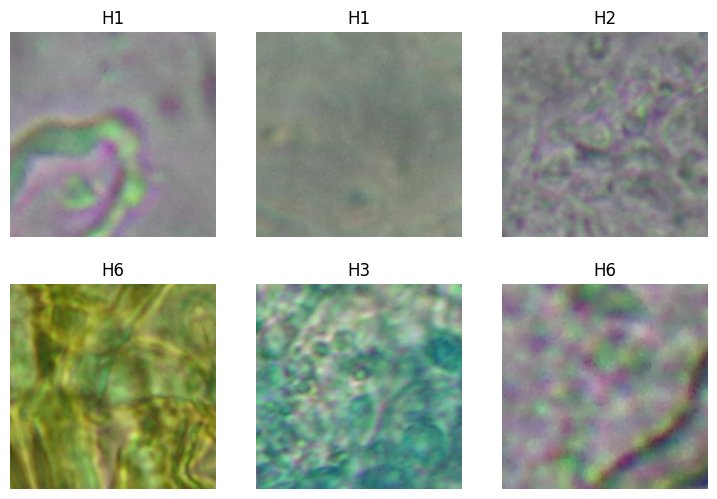

In [ ]:
dls.show_batch(max_n=6)

Now we'll download a model and fine-tune it. More on what this means later. Let's focus on the output. We can see before that we have a training and validation loss, but now there is a new output, the `error_rate` instead of the `rmse`. We're looking at the percentage of images which are classified incorrectly.

Why is this? It's because classifiers are different from regression models and must be treated differently.

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


___

## 2. Regression vs. Classification

So far, we've been examining the problem of **regression**, that is, predicting continuous numbers as outputs for our models. Important considerations for building a regression network:

* We use a loss of either the mean squared error, `(y-yhat).pow(2).mean()`, or the mean absolute error, `(y-yhat).abs().mean()`.
* The last layer of our network doesn't use an activation function. Or, you could say it's the identity activation $a = z$. This is because after producing a final linear fit, the model has produced a number in the range $(-\infty, \infty)$. Nothing more needs done.
* When evaluating the network, we can look at the rmse, or root mean squared error of the model on the validation set (this is equivalent to the standard deviation of the residuals).

But we're also interested in **classification**, telling different categories apart (e.g. "What kind of animal is this?"). For a classification problem, we can no longer use the same loss. We cannot make a number signify the kind of animal (2.5 means "cat") and measure an error in the same way, and we cannot look at the rmse or the residuals in the same way. So we need:

* A new loss.
* A new final layer.
* A new human-readable metric.
* A new deeper assessment.

### 2.1 Output Function
Let's start with the output of the network. We'll interpret the outputs to be the probabilities for each class. For example, Let's say we are making a classifier telling us if something is a picture of a cat, lizard, or horse. Our output might be the probability that the picture is of each class. One sample output might be:

$$ \hat{p} = \left(\begin{array}{l} \hat{p}_{cat} \\ \hat{p}_{lizard} \\ \hat{p}_{horse}  \end{array} \right) = \left(\begin{array}{l} 0.95 \\ 0.02 \\ 0.03  \end{array} \right) $$

In this example, we're very certain that the image is of a cat: we're predicting that it has a 95% chance of being a cat. How do we produce this? Well, a first step would be to produce 3 outputs instead of one in the last layer. So what was:

$$\hat{y} = b + w_1 a_1 + w_2 a_2 + \cdots$$

(This $b$ is just the final layer's $b$, the $w$s are the weights for the final layer, and the $a$ are the outputs of the previous layer). This now becomes:

$$z_{c} = b_{c} + w_{1c} a_1 + w_{2c} a_2 + \cdots\\
  z_{l} = b_{l} + w_{1l} a_1 + w_{2l} a_2 + \cdots\\
  z_{h} = b_{h} + w_{1h} a_1 + w_{2h} a_2 + \cdots$$

I'm using $z$ instead of $\hat{p}$ because we'll soon see that these are insufficient. This entails three biases and three sets of weights for the last layer, rather than just one, but it still takes in the same $a$ from the previous layer.

What's wrong with using $z$ as the probabilities? There's nothing enforcing all of the outputs to add up to 1 (like a probability should) or forcing them all to be positive numbers (like probabilities should). So instead of using this calculation, we'll instead use the same input-activation we've done with the ReLU.

The function $e^{x}$ is always positive, no matter what $x$ is, so that's a good start. Then, we normalize the probability by dividing by the sum of all of the different $e^x$ values. This output is called a *softmax*.

$$\hat{p}_{c} = \frac{e^{z_c}}{e^{z_c} + e^{z_l} + e^{z_h}}$$

More generally, you can write the probability that something is in the $i$th class out of $N$ total classes as:

$$\hat{p}_i = \frac{e^{z_i}}{\sum\limits_j e^{z_j}}$$

#### Example:

Here we have 3 different hypothetical outputs from the last layer of the neural network, and how they get transformed into $e^{z}$ and finally the $\hat{p}$ produced by softmax. Notice that all of the $e^{z}$ values are positive, and a small change in $z$ changes $e^{z}$ by a large amount. The values of $\hat{p}$ also add to 100%.

<center>

|animal|$z$|$e^{z}$|$\hat{p}$|
|:-:|-:|-:|:-:|
|cat|3.1|22.2|0.74|
|lizard|-0.5|0.6|0.02|
|horse|2.0|7.4|0.24|

</center>

### 2.2 A New Loss Function

Let's say the image is actually of a cat, which means we can write the true y as:

$$ p = \left(\begin{array}{l} p_{cat} \\ p_{lizard} \\ p_{horse}  \end{array} \right) = \left(\begin{array}{l} 1 \\ 0 \\ 0  \end{array} \right) $$

This leads us to a natural way to describe a loss: look at the *correct* answer, and see how close it is to 1. In this case, the correct is cat, so we just use that one. Since offsets to the loss don't matter, we can also throw away the 1. The $-$ is also important because we will be trying to minimize the loss.

$$J = (1-\hat{p}_{cat}) \equiv -\hat{p}_{cat}$$

But this becomes annoying to evaluate for each observation, as we need to look up what the true type is for that observation, then check that entry in the prediction. This is computationally inefficient. We can use the fact that all of the true $p$s are all 0 and 1 and rewrite the above as:

$$J = -p_{cat}\hat{p}_{cat} - p_{lizard}\hat{p}_{lizard} - p_{horse}\hat{p}_{horse}\\
 = - \sum_i p_i \hat{p}_i$$

 For a [few reasons](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html) that have to do with weighting different kinds of errors differently, it is common to use $\ln\hat{p}_i$ instead of $\hat{p}_i$. As $\ln x$ is a monotonic function, this doesn't disrupt any of our arguments so far. This makes our loss:

 $$J = -\sum_i p_i \ln \hat{p}_i$$

 This is called sparse categorical cross-entropy. (Anything of the form $p \ln p$ is called an entropy, coming from physics and [information theory](https://colah.github.io/posts/2015-09-Visual-Information/)).

### 2.3 A New Human-Readable Metric

I don't know about you, but the sparse categorical cross-entropy is even more confusing than the previous losses we've used. A standard metric to display to a user for classification tasks is either the **accuracy** (% of answers you got right) or the **error rate** (% of answers you got wrong). The second is especially useful when you've got a high accuracy, as the difference between 0.1% and 0.01% is a lot clearer that it's a significant improvement than 99.9% and 99.99%.

After training above, we got an error rate of 25%, meaning that we successfully classified 75% of the images. Is that good? Well, we're getting toward the published accuracy, so that's encouraging. Let's see where our problems lie.

### 2.4 Looking Deeper

The residual plot compares true values to predicted values. The equivalent with a classifier is the **confusion matrix**, which displays counts of ach prediction vs true value, as shown below. For a good classifier, the diagonals (where prediction = true value) should have the most counts (and are usually then dark in color), with the off-diagonals being relatively sparse. In a perfect model, every off-diagonal element would be 0.

Here's the confusion matrix for this dataset. We can see:
* Most of the diagonals have large numbers: most of the images are properly classified (unsurprising, as we have about 70% accuracy).
* Most off the off-diagonals are 0 or small.
* There are a few issues, though: images with H1 (candida) and H2 (aspergillus) are quite confused with each other.

What can we do about this? If we were experts in the field, we might ask the question of *why* our candida and aspergillus samples are being confused. Are they really similar? Or is something else happening? We might consider getting more samples of these two fungal infections in particular, as they are the ones we have the most trouble with. It's good to be targeted with any approach involving getting more data.

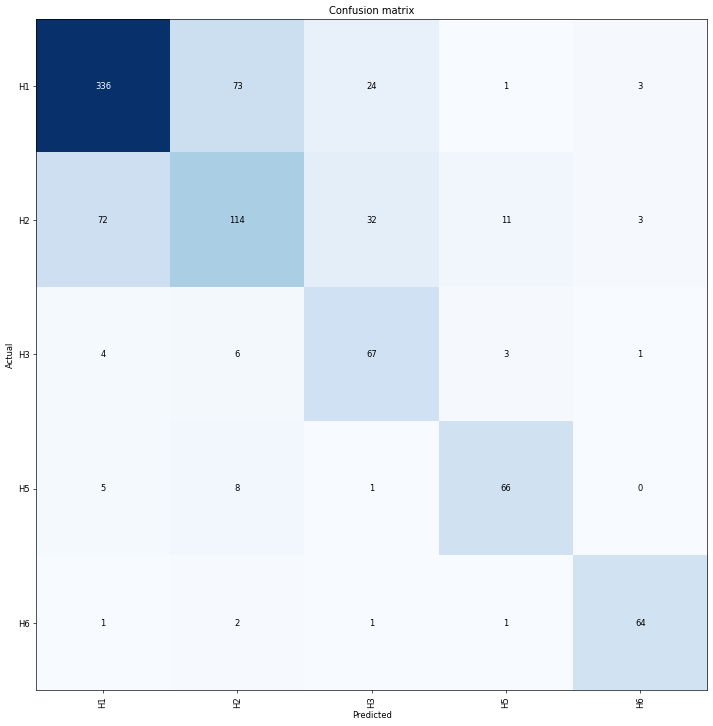

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

#Counts of things in a bin, you read it as for example - The model predicted 66 H6 and those were actually H6, then the model predicted 1 H6 that was actually an H5

## 3. Architectures and Transfer Learning

Previously, we built and trained our own neural network for tabular data from scratch, with random starting weights. That's *not* what we've done here. We're downloading a pre-trained model and performing **transfer learning** on it.

The model we used above is resnet18, which means that it's a 18 layer deep convolutional neural network and is designed with residual connections, both features of which are designed to be good at image recognition. The model has already been trained for some image recognition task (probably [ImageNet](https://www.image-net.org/)).

We can think of the task of recognizing an object or animal as being broken down into various steps: finding colors, shapes, building the pieces together into faces or smaller items in the scene, until those finally come together into the whole picture. This is what is being done in a convolutional neural network, layer by layer (images from [Zeiler and Fergus (2013)](https://arxiv.org/pdf/1311.2901.pdf).

The images below show the filters for each layer (in the architecture for a CNN, each filter is, roughly speaking, one of the nodes in a fully connect network) along with what pieces of image have the strongest activation output (that is, most strongly correspond to that filter). In Layer 1 of the network, the nodes are picking up on colors, gradients, and directional information, while in Layer 2 we get more complex shapes like circles and curves, building up to full objects, faces, and animals by Layer 5.



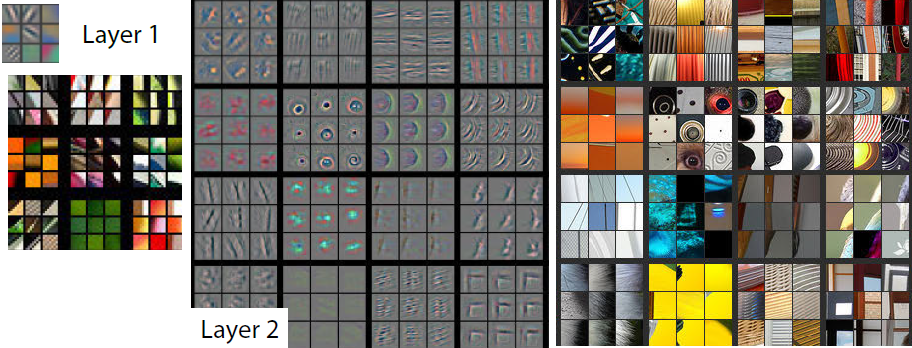

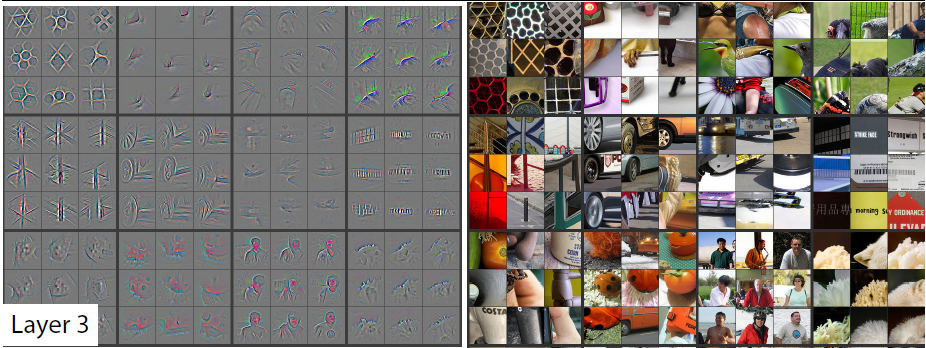

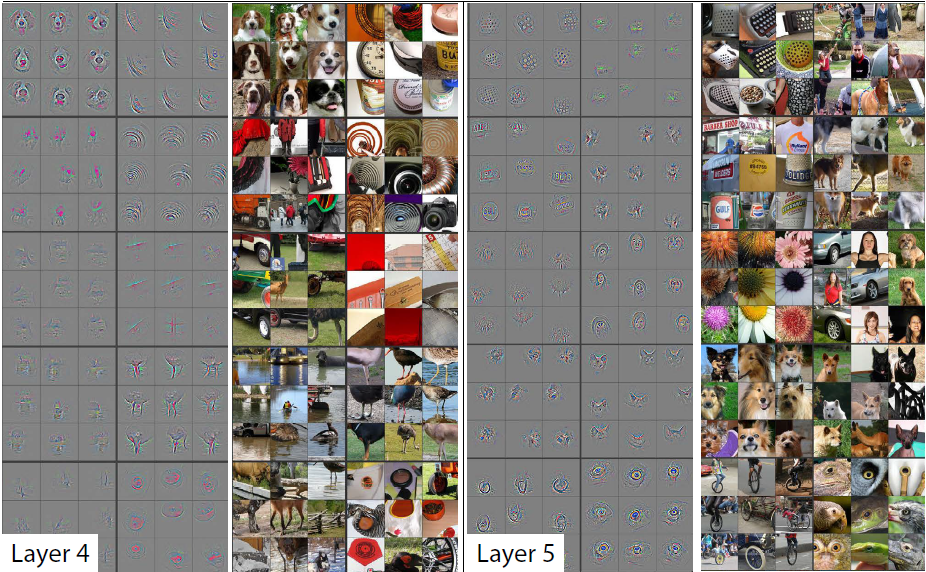

Now, we're trying to identify fungal infections and the resnet18 model we downloaded was definitely not trained on that. That's fine! Most of these elements are re-usable.

The only thing that needs to be trained from scratch is the last few layers, where we make sense of all of these elements and train the network on the specific outputs we're interested in. We can do a fairly good job without adjusting these early layers at all (and indeed, that's what we did). This is transfer learning.

In [ ]:
#Looks at little parts of the picture, instead of the picture as a whole to find patterns within those smaller aspects which it can then use to
# decide what that picture is

#EX: if the pixels of a certain breed of dog tend to be brown and slowly change to brown as you move along the image, it'll look for that pattern

#Each of these things it looks for can be thought of as the inputs, which then get factored into the next layer of inputs, this next layer of inputs then looks
#At identifiers in the next layer of pictures to create another layer of inputs, and this process of adding layers of inputs and layers to the pictures continues
#Until you have a prediction of what category the image fits into

#Our model that we downloaded is 18 layers deep

## 4. Towards a State-of-the-Art Model

This section is a series of improvements and tweaks we can make to the model which should improve its training and performance. These won't always improve the model, but it is worth trying each

Let's take a look:
 * Learning Rate Finder
 * Data Augmentation
 * Normalization
 * Mixup
 * Label Smoothing
 * Progressive Resizing
 * Test-Time Augmentation


### 4.1 Learning Rate Finder

We've discussed this before: we can train the model just a little bit with a wide range of different learning rates to see which improves the model best and work from there.

Just to think about this a little more closely: if we choose too large of a learning rate, then we will jum over the correct answer. If we choose too small of a learning rate, then we are wasting time: if the best learning rate is $10^{-3}$ and we use a learning rate of $10^{-4}$, which is 1/10th of $10^{-3}$, then it will need to take 10 times as many steps, and thus take 10 times as long to achieve the same results!

The received wisdom is that you should find a point where the loss is still decreasing as you increase the learning rate, and has clearly *not* started increasing again. Remember that our starting points are always a little bit randomized, and that we don't have infinite resolution on this graph, so we need to be a little bit careful.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=0.0008317637839354575)

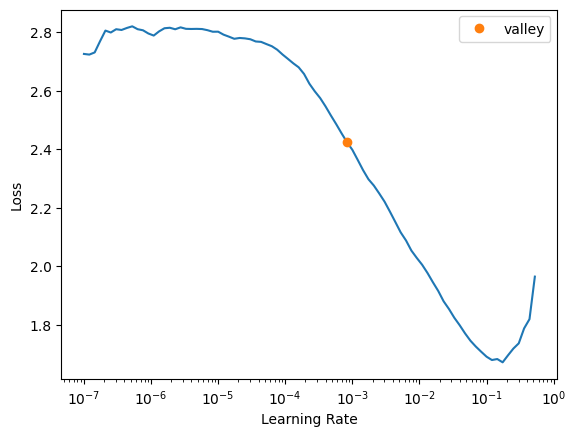

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.lr_find()

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=0.01)

### 4.2 Data Augmentation

Wouldn't it be great if we had more training data? Then we would have more varied examples and be less prone to overfitting. Well, sometimes we *can* get more data, even without more data collection. You just have to be clever and think carefully about your dataset.

The following are ways that you can create new images from the existing training images:

* **Mirroring:** Take images and mirror them horizontally, vertivally, or both at random.
* **Crop:** Randomly crop the image, cutting out the edges of the image.
* **Rotate:** Rotate the angle by some random amount.
* **Change Brightness:** Randomly darken or brighten the image, or shift the colors in some way.

For each of these following tasks, which of the augmentation methods above would be appropriate?

* Animal identification (what kind of animal is this?) - All except crop (be careful with cropping correctly atleast)
* License plate identification (what is the number on the plate?) - No mirror, potentially no cropping
* ASL identification (what is this sign?) - No cropping, mirroring is tricky too here
* Object identification (what is this thing?) - All are fine
* Motion detection (did something move between these two image?) - Apply the same transformation on all the images (apply both transforms the same way between images)

Keep in mind that data augmentation is only done with the training data, never with the validation data or the testing data.

Here's how this is done with fastai. Take a look at this link to see the [full options availabile for augmentation](https://docs.fast.ai/vision.augment.html#aug_transforms).

In [ ]:
#Changing our existing images to give us more data to work with

In [ ]:
fungi = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                 get_y = parent_label,
                 item_tfms=Resize(224),
                 batch_tfms=aug_transforms(size=160, min_scale=0.75, max_rotate=90, flip_vert=True)) #flip_horiz = True

dls = fungi.dataloaders(path, bs=256)

Let's see what they look like applied to our data. It may not be immediately obvious, so we can make things a little more extreme, like changing `max_lighting` to 0.8 from its default of 0.2

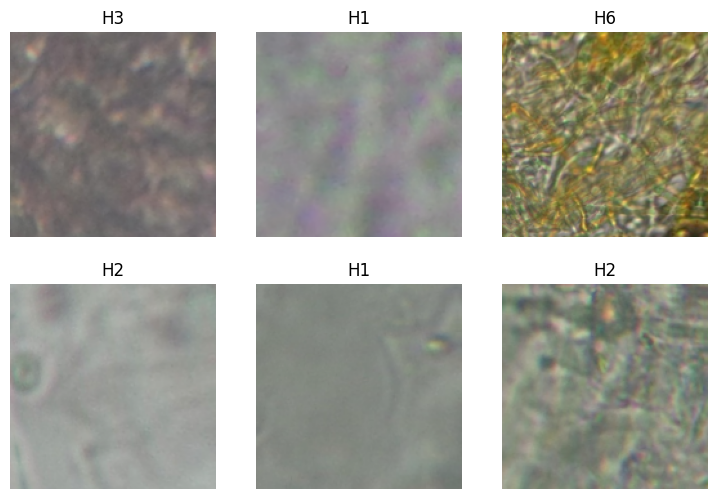

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn= vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=0.01)

### 4.3 Normalization

This is also something we've done before: we normalized the values of $x$ and $y$ for our model, so that the range was confined to the range \[0,1\].

Why was this done? As noted before, this makes every $x$ variable equal in importance, meaning that it's unlikely that the changes in $w_1$ and $w_2$ won't have to be potentially vastly different in scale.

In addition, the resnet model itself (and many other pretrained models) was originally trained on data that was normalized, so we should give it data that is more like the data it already knows.



In [ ]:
fungi = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                 get_y = parent_label,
                 item_tfms=Resize(224),
                 batch_tfms=[*aug_transforms(size=160, min_scale=0.75, max_rotate=90, flip_vert=True),
                             Normalize()])

dls = fungi.dataloaders(path, bs=256)

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate)
learn.fine_tune(2, base_lr=0.01)

### 4.4 Mixup

Mixup is an interesting form of data augmentation where two images are mixed together. The final image is just the average of the inputs, weighted by some factor $0<\lambda < 1$. If image 1 was a picture of a cat, and image 2 an image of a horse, then the target output is:

$$ p = \left(\begin{array}{l} p_{cat} \\ p_{lizard} \\ p_{horse}  \end{array} \right) = \left(\begin{array}{c} \lambda \\ 0 \\ 1-\lambda  \end{array} \right) $$

Here's an image taken from the [fastai documentation](https://docs.fast.ai/callback.mixup.html) demonstrating this effect.

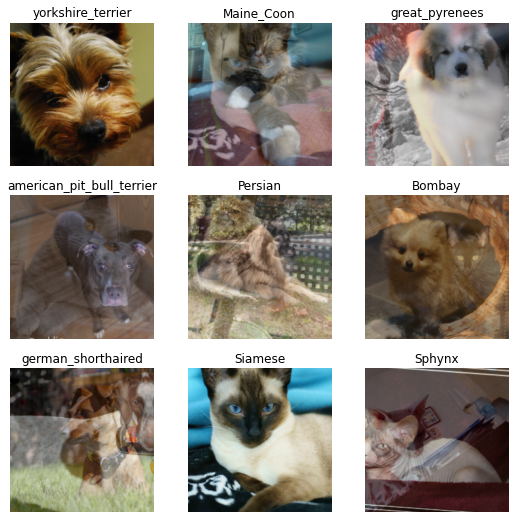

 It can take quite some time for mixup to show much of an effect, so we'll try training for 20 epochs.

 ...hey, we hit the accuracy of the 2021 paper!

In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate, cbs=MixUp())
learn.fine_tune(20, base_lr=0.01)

## 4.5 Label Smoothing

Let's consider what the softmax output looks like when there are only two possible classes. In that case, the function becomes:

$$\hat{p} = \frac{e^{z}}{1 + e^{z}} = \frac{1}{1+e^{-z}}$$

And we get this as a graph:

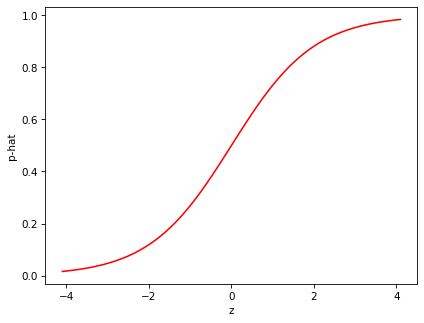

Notice that the value of $\hat{p}\rightarrow  0$ or $1$ only when $z$ approaches $\pm\infty$. As the true labels $p$ on the images are exactly $0$ and $1$, our gradient descent algorithm will force the $z$ in the last layer to very large positive and values, and they will *still* produce incorrect outputs because they can never reach $\pm\infty$.

Label smoothing tries to correct for this issue. Instead of setting the labels as $0$ and $1$, they are set to $0.1$ and $0.9$, which are achievable values. You can also set [whatever value you like](https://docs.fast.ai/losses.html#labelsmoothingcrossentropy) as well.

Label smoothing is also helpful when the labels themselves are known to not be perfectly accurate. This may be due to human error, or it may just be due to the limit of human ability. Perhaps an image labeled as "non-cancerous" by an expert turns out later to actually be cancerous. By reducing how confident the model is expected to be (how close $\hat{p}$ are supposed to be to $0$ and $1$), less overfitting to incorrect labels will occur.

Like mixup, label smoothing can take quite a while to become effective, so here's the result of training 20 epochs. It looks like this has not improved over mixup.



In [ ]:
learn = vision_learner(dls, models.resnet18, metrics=error_rate, cbs=MixUp(), loss_func=LabelSmoothingCrossEntropy())
learn.fine_tune(20, base_lr=0.01)

### 4.6 Progressive Resizing

The following code is a quick wrap of the way we created our DataLoaders and lets the user input a batchsize and image size:

In [ ]:
def get_fungi_dataloaders(bs=256, imsize=224):

    fungi = DataBlock(blocks = (ImageBlock, CategoryBlock),
        get_items = get_image_files,
        splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
        get_y = parent_label,
        item_tfms=Resize(224),
        batch_tfms=[*aug_transforms(size=imsize, min_scale=0.75, max_rotate=90, flip_vert=True),
                    Normalize()])

    path = Path(".")
    return fungi.dataloaders(path, bs=bs)

We create our learner and then start by training on a small image size:

SuggestedLRs(valley=0.0008317637839354575)

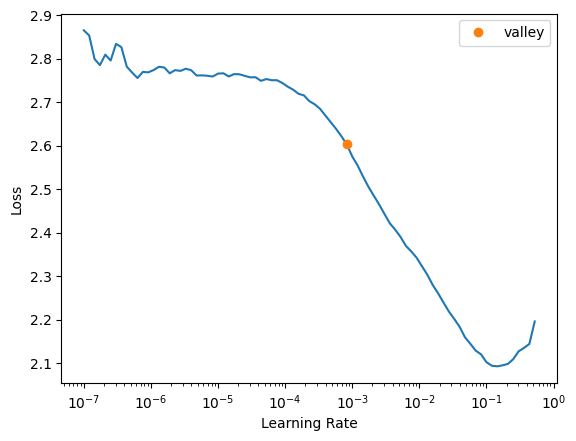

In [ ]:
dls = get_fungi_dataloaders(imsize=64)
learn = vision_learner(dls, models.resnet18, metrics=error_rate, cbs=MixUp())
learn.lr_find()


In [ ]:
learn.fit_one_cycle(5, 0.01)

That doesn't seem to have been very effective, especially compared with our baseline. But we'll keep trying since we're not wasting too much GPU time (or our time!) getting this done.

For the next step, we increase the image size. Most importantly, we don't create a *new* learner as we size up our training set, but simply replace the DataLoaders in the existing learner.

SuggestedLRs(valley=0.002511886414140463)

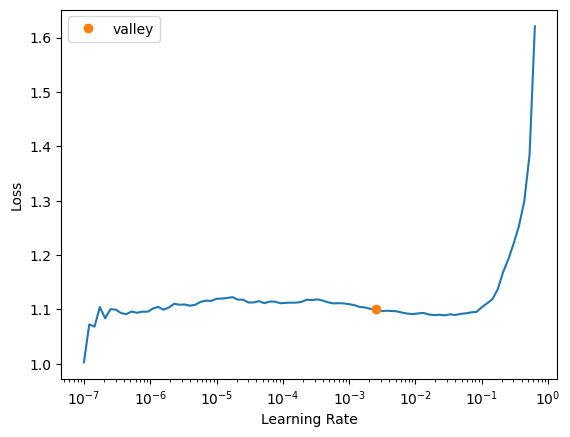

In [ ]:
learn.dls = get_fungi_dataloaders(imsize=128)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 0.0025)

And here's a final step, at the original image size:

SuggestedLRs(valley=0.0014454397605732083)

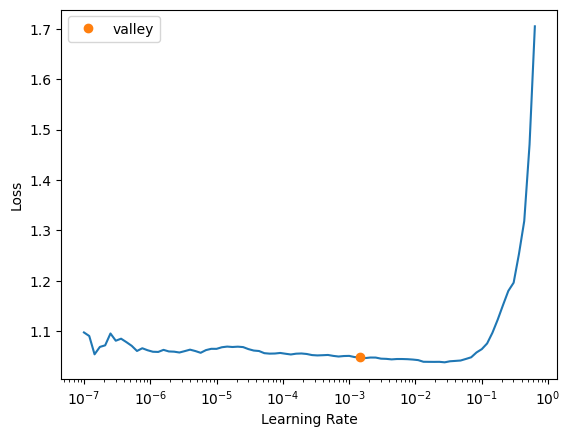

In [ ]:
learn.dls = get_fungi_dataloaders(imsize=224)
learn.lr_find()

In [ ]:
learn.fine_tune(10, 0.0014)

Ultimately, this is worse than we found before. That's okay though. It might be worth trying again, with a more aggressive learning rate. Something to investigate later.

### 4.7 Test-Time Augmentation

Earlier, I said that you don't augment the validation or testing data. And yeah, we're about to augment the testing data. But we're doing so in a particular way.

For each image in the validation set (or testing set), we're augmenting it in the same way we augmented the training data. You can add more augmentations if you like, as well. Let's say this produces $A$ total images for each individual test image. We then average the predictions for each of those $A$ images together to get our final prediction.

For the code below, I went back to before we did progressive resizing. Compared with the 85% accuracy we got, it looks like test-time augmentation has had a negligible improvement on our dataset.

In [ ]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8565072417259216